In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "int99"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 288
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 360
Categorical Columns: 8


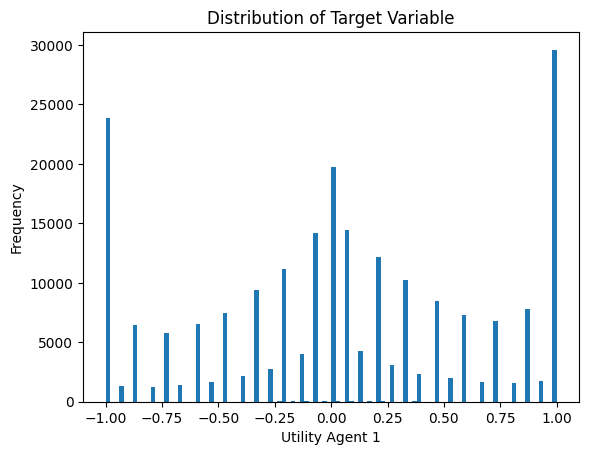

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.02,
        'depth': 10,
        'iterations': 10_000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6320829	test: 0.5544050	best: 0.5544050 (0)	total: 176ms	remaining: 29m 20s


50:	learn: 0.4904525	test: 0.5112965	best: 0.5112965 (50)	total: 6.81s	remaining: 22m 7s


100:	learn: 0.4415522	test: 0.4920780	best: 0.4920780 (100)	total: 13.5s	remaining: 22m 3s


150:	learn: 0.4141202	test: 0.4778126	best: 0.4778126 (150)	total: 20.4s	remaining: 22m 7s


200:	learn: 0.3961223	test: 0.4673782	best: 0.4673782 (200)	total: 27.4s	remaining: 22m 13s


250:	learn: 0.3827074	test: 0.4601636	best: 0.4601636 (250)	total: 34.3s	remaining: 22m 12s


300:	learn: 0.3714705	test: 0.4549294	best: 0.4549294 (300)	total: 41.3s	remaining: 22m 10s


350:	learn: 0.3621340	test: 0.4503102	best: 0.4503102 (350)	total: 48.5s	remaining: 22m 12s


400:	learn: 0.3543938	test: 0.4472733	best: 0.4472733 (400)	total: 55.6s	remaining: 22m 10s


450:	learn: 0.3476880	test: 0.4448341	best: 0.4448341 (450)	total: 1m 2s	remaining: 22m 6s


500:	learn: 0.3410250	test: 0.4422001	best: 0.4422001 (500)	total: 1m 9s	remaining: 22m 3s


550:	learn: 0.3355130	test: 0.4397606	best: 0.4397606 (550)	total: 1m 16s	remaining: 21m 57s


600:	learn: 0.3302181	test: 0.4375878	best: 0.4375878 (600)	total: 1m 23s	remaining: 21m 51s


650:	learn: 0.3259972	test: 0.4360020	best: 0.4360020 (650)	total: 1m 31s	remaining: 21m 49s


700:	learn: 0.3218091	test: 0.4342788	best: 0.4342788 (700)	total: 1m 38s	remaining: 21m 47s


750:	learn: 0.3179651	test: 0.4329835	best: 0.4329835 (750)	total: 1m 46s	remaining: 21m 46s


800:	learn: 0.3144833	test: 0.4316736	best: 0.4316736 (800)	total: 1m 53s	remaining: 21m 46s


850:	learn: 0.3114543	test: 0.4305932	best: 0.4305835 (849)	total: 2m 1s	remaining: 21m 49s


900:	learn: 0.3083388	test: 0.4296428	best: 0.4296428 (900)	total: 2m 9s	remaining: 21m 51s


950:	learn: 0.3054952	test: 0.4289142	best: 0.4289142 (950)	total: 2m 17s	remaining: 21m 53s


1000:	learn: 0.3026741	test: 0.4281116	best: 0.4281116 (1000)	total: 2m 26s	remaining: 21m 57s


1050:	learn: 0.3000341	test: 0.4274650	best: 0.4274650 (1050)	total: 2m 35s	remaining: 22m 4s


1100:	learn: 0.2973458	test: 0.4267805	best: 0.4267805 (1100)	total: 2m 45s	remaining: 22m 14s


1150:	learn: 0.2951151	test: 0.4261770	best: 0.4261770 (1150)	total: 2m 55s	remaining: 22m 26s


1200:	learn: 0.2928443	test: 0.4255800	best: 0.4255800 (1200)	total: 3m 6s	remaining: 22m 46s


1250:	learn: 0.2907688	test: 0.4252276	best: 0.4252276 (1250)	total: 3m 19s	remaining: 23m 13s


1300:	learn: 0.2888082	test: 0.4247998	best: 0.4247998 (1300)	total: 3m 33s	remaining: 23m 45s


1350:	learn: 0.2870102	test: 0.4242874	best: 0.4242874 (1350)	total: 3m 48s	remaining: 24m 24s


1400:	learn: 0.2850798	test: 0.4238389	best: 0.4238389 (1400)	total: 4m 6s	remaining: 25m 10s


1450:	learn: 0.2832855	test: 0.4234846	best: 0.4234846 (1450)	total: 4m 23s	remaining: 25m 54s


1500:	learn: 0.2814723	test: 0.4231463	best: 0.4231463 (1500)	total: 4m 40s	remaining: 26m 26s


1550:	learn: 0.2796884	test: 0.4227730	best: 0.4227730 (1550)	total: 4m 54s	remaining: 26m 42s


1600:	learn: 0.2780284	test: 0.4224520	best: 0.4224520 (1600)	total: 5m 7s	remaining: 26m 50s


1650:	learn: 0.2764809	test: 0.4220651	best: 0.4220651 (1650)	total: 5m 18s	remaining: 26m 53s


1700:	learn: 0.2749374	test: 0.4218170	best: 0.4218137 (1698)	total: 5m 30s	remaining: 26m 51s


1750:	learn: 0.2733895	test: 0.4215982	best: 0.4215982 (1750)	total: 5m 40s	remaining: 26m 46s


1800:	learn: 0.2718994	test: 0.4213061	best: 0.4213061 (1800)	total: 5m 51s	remaining: 26m 39s


1850:	learn: 0.2704020	test: 0.4209858	best: 0.4209789 (1849)	total: 6m 1s	remaining: 26m 31s


1900:	learn: 0.2689864	test: 0.4207355	best: 0.4207204 (1899)	total: 6m 11s	remaining: 26m 22s


1950:	learn: 0.2677421	test: 0.4204729	best: 0.4204697 (1947)	total: 6m 21s	remaining: 26m 12s


2000:	learn: 0.2664402	test: 0.4202308	best: 0.4202308 (2000)	total: 6m 30s	remaining: 26m


2050:	learn: 0.2652614	test: 0.4201095	best: 0.4201065 (2049)	total: 6m 39s	remaining: 25m 48s


2100:	learn: 0.2640199	test: 0.4199410	best: 0.4199410 (2100)	total: 6m 48s	remaining: 25m 35s


2150:	learn: 0.2628969	test: 0.4197965	best: 0.4197940 (2148)	total: 6m 57s	remaining: 25m 22s


2200:	learn: 0.2617826	test: 0.4196042	best: 0.4196023 (2198)	total: 7m 5s	remaining: 25m 8s


2250:	learn: 0.2607512	test: 0.4194118	best: 0.4194118 (2250)	total: 7m 14s	remaining: 24m 56s


2300:	learn: 0.2595922	test: 0.4191752	best: 0.4191730 (2297)	total: 7m 23s	remaining: 24m 42s


2350:	learn: 0.2585026	test: 0.4189744	best: 0.4189744 (2350)	total: 7m 31s	remaining: 24m 28s


2400:	learn: 0.2573043	test: 0.4187170	best: 0.4187170 (2400)	total: 7m 39s	remaining: 24m 13s


2450:	learn: 0.2562390	test: 0.4185137	best: 0.4185128 (2448)	total: 7m 47s	remaining: 23m 59s


2500:	learn: 0.2552714	test: 0.4183295	best: 0.4183295 (2500)	total: 7m 55s	remaining: 23m 45s


2550:	learn: 0.2543415	test: 0.4182151	best: 0.4182151 (2550)	total: 8m 3s	remaining: 23m 30s


2600:	learn: 0.2532832	test: 0.4180270	best: 0.4180270 (2600)	total: 8m 11s	remaining: 23m 17s


2650:	learn: 0.2523905	test: 0.4179237	best: 0.4179152 (2644)	total: 8m 19s	remaining: 23m 5s


2700:	learn: 0.2515120	test: 0.4178142	best: 0.4178142 (2700)	total: 8m 27s	remaining: 22m 50s


2750:	learn: 0.2505723	test: 0.4177317	best: 0.4177317 (2750)	total: 8m 35s	remaining: 22m 37s


2800:	learn: 0.2496283	test: 0.4176647	best: 0.4176647 (2800)	total: 8m 42s	remaining: 22m 22s


2850:	learn: 0.2486995	test: 0.4175426	best: 0.4175426 (2850)	total: 8m 49s	remaining: 22m 8s


2900:	learn: 0.2478551	test: 0.4173706	best: 0.4173706 (2900)	total: 8m 57s	remaining: 21m 54s


2950:	learn: 0.2469791	test: 0.4172380	best: 0.4172380 (2950)	total: 9m 4s	remaining: 21m 40s


3000:	learn: 0.2460595	test: 0.4171294	best: 0.4171284 (2998)	total: 9m 11s	remaining: 21m 26s


3050:	learn: 0.2452572	test: 0.4170687	best: 0.4170687 (3050)	total: 9m 20s	remaining: 21m 17s


3100:	learn: 0.2444445	test: 0.4169370	best: 0.4169291 (3096)	total: 9m 27s	remaining: 21m 1s


3150:	learn: 0.2436388	test: 0.4168951	best: 0.4168920 (3140)	total: 9m 33s	remaining: 20m 46s


3200:	learn: 0.2428417	test: 0.4167315	best: 0.4167315 (3200)	total: 9m 39s	remaining: 20m 31s


3250:	learn: 0.2420315	test: 0.4165950	best: 0.4165950 (3250)	total: 9m 45s	remaining: 20m 16s


3300:	learn: 0.2412686	test: 0.4164292	best: 0.4164290 (3298)	total: 9m 52s	remaining: 20m 1s


3350:	learn: 0.2404689	test: 0.4162957	best: 0.4162957 (3350)	total: 9m 58s	remaining: 19m 47s


3400:	learn: 0.2397087	test: 0.4161690	best: 0.4161644 (3397)	total: 10m 4s	remaining: 19m 33s


3450:	learn: 0.2389586	test: 0.4160366	best: 0.4160337 (3449)	total: 10m 10s	remaining: 19m 19s


3500:	learn: 0.2383096	test: 0.4159751	best: 0.4159751 (3499)	total: 10m 17s	remaining: 19m 5s


3550:	learn: 0.2376169	test: 0.4159425	best: 0.4159327 (3537)	total: 10m 23s	remaining: 18m 52s


3600:	learn: 0.2368823	test: 0.4158372	best: 0.4158363 (3599)	total: 10m 29s	remaining: 18m 38s


3650:	learn: 0.2362506	test: 0.4157569	best: 0.4157495 (3637)	total: 10m 35s	remaining: 18m 25s


3700:	learn: 0.2356142	test: 0.4156968	best: 0.4156968 (3700)	total: 10m 41s	remaining: 18m 12s


3750:	learn: 0.2349311	test: 0.4156650	best: 0.4156625 (3748)	total: 10m 48s	remaining: 17m 59s


3800:	learn: 0.2342970	test: 0.4155934	best: 0.4155899 (3799)	total: 10m 54s	remaining: 17m 47s


3850:	learn: 0.2336255	test: 0.4155601	best: 0.4155601 (3850)	total: 11m	remaining: 17m 34s


3900:	learn: 0.2329828	test: 0.4154760	best: 0.4154749 (3899)	total: 11m 6s	remaining: 17m 22s


3950:	learn: 0.2322989	test: 0.4154122	best: 0.4154122 (3950)	total: 11m 13s	remaining: 17m 10s


4000:	learn: 0.2316490	test: 0.4152743	best: 0.4152743 (4000)	total: 11m 19s	remaining: 16m 58s


4050:	learn: 0.2310521	test: 0.4152231	best: 0.4152210 (4043)	total: 11m 25s	remaining: 16m 47s


4100:	learn: 0.2304887	test: 0.4152062	best: 0.4152062 (4100)	total: 11m 32s	remaining: 16m 35s


4150:	learn: 0.2298524	test: 0.4151707	best: 0.4151618 (4149)	total: 11m 38s	remaining: 16m 23s


4200:	learn: 0.2292448	test: 0.4151210	best: 0.4151210 (4200)	total: 11m 44s	remaining: 16m 12s


4250:	learn: 0.2286162	test: 0.4150373	best: 0.4150355 (4249)	total: 11m 50s	remaining: 16m


4300:	learn: 0.2280077	test: 0.4149757	best: 0.4149757 (4300)	total: 11m 56s	remaining: 15m 49s


4350:	learn: 0.2274086	test: 0.4149307	best: 0.4149307 (4350)	total: 12m 2s	remaining: 15m 38s


4400:	learn: 0.2267878	test: 0.4148686	best: 0.4148686 (4400)	total: 12m 9s	remaining: 15m 27s


4450:	learn: 0.2261908	test: 0.4148059	best: 0.4148059 (4450)	total: 12m 15s	remaining: 15m 16s


4500:	learn: 0.2256049	test: 0.4147603	best: 0.4147540 (4499)	total: 12m 21s	remaining: 15m 5s


4550:	learn: 0.2250361	test: 0.4147340	best: 0.4147150 (4531)	total: 12m 27s	remaining: 14m 55s


4600:	learn: 0.2244161	test: 0.4147167	best: 0.4147148 (4599)	total: 12m 33s	remaining: 14m 44s


4650:	learn: 0.2238792	test: 0.4146702	best: 0.4146702 (4650)	total: 12m 40s	remaining: 14m 34s


4700:	learn: 0.2233682	test: 0.4146460	best: 0.4146412 (4681)	total: 12m 46s	remaining: 14m 23s


4750:	learn: 0.2228428	test: 0.4146689	best: 0.4146412 (4681)	total: 12m 52s	remaining: 14m 13s


4800:	learn: 0.2222477	test: 0.4146291	best: 0.4146261 (4797)	total: 12m 58s	remaining: 14m 3s


4850:	learn: 0.2217171	test: 0.4145863	best: 0.4145778 (4846)	total: 13m 5s	remaining: 13m 53s


4900:	learn: 0.2212294	test: 0.4145202	best: 0.4145202 (4900)	total: 13m 11s	remaining: 13m 43s


4950:	learn: 0.2207141	test: 0.4144828	best: 0.4144791 (4946)	total: 13m 17s	remaining: 13m 33s


5000:	learn: 0.2202123	test: 0.4144801	best: 0.4144791 (4946)	total: 13m 23s	remaining: 13m 23s


5050:	learn: 0.2197251	test: 0.4144543	best: 0.4144401 (5026)	total: 13m 30s	remaining: 13m 13s


5100:	learn: 0.2192387	test: 0.4144073	best: 0.4144073 (5100)	total: 13m 36s	remaining: 13m 4s


5150:	learn: 0.2187318	test: 0.4143422	best: 0.4143414 (5149)	total: 13m 42s	remaining: 12m 54s


5200:	learn: 0.2182220	test: 0.4143091	best: 0.4143011 (5190)	total: 13m 49s	remaining: 12m 45s


5250:	learn: 0.2177780	test: 0.4142959	best: 0.4142957 (5245)	total: 13m 55s	remaining: 12m 35s


5300:	learn: 0.2172925	test: 0.4142469	best: 0.4142469 (5300)	total: 14m 1s	remaining: 12m 26s


5350:	learn: 0.2167973	test: 0.4142177	best: 0.4142177 (5350)	total: 14m 8s	remaining: 12m 16s


5400:	learn: 0.2162988	test: 0.4141636	best: 0.4141507 (5394)	total: 14m 14s	remaining: 12m 7s


5450:	learn: 0.2158130	test: 0.4141687	best: 0.4141507 (5394)	total: 14m 20s	remaining: 11m 58s


5500:	learn: 0.2152930	test: 0.4141550	best: 0.4141507 (5394)	total: 14m 26s	remaining: 11m 49s


5550:	learn: 0.2148488	test: 0.4141293	best: 0.4141272 (5545)	total: 14m 33s	remaining: 11m 39s


5600:	learn: 0.2143470	test: 0.4141121	best: 0.4141103 (5597)	total: 14m 39s	remaining: 11m 30s


5650:	learn: 0.2139249	test: 0.4140764	best: 0.4140764 (5650)	total: 14m 45s	remaining: 11m 21s


5700:	learn: 0.2134779	test: 0.4140350	best: 0.4140326 (5696)	total: 14m 52s	remaining: 11m 12s


5750:	learn: 0.2130112	test: 0.4140372	best: 0.4140300 (5705)	total: 14m 58s	remaining: 11m 3s


5800:	learn: 0.2125557	test: 0.4140066	best: 0.4140041 (5789)	total: 15m 4s	remaining: 10m 54s


5850:	learn: 0.2120910	test: 0.4139740	best: 0.4139722 (5849)	total: 15m 10s	remaining: 10m 45s


5900:	learn: 0.2116019	test: 0.4139551	best: 0.4139551 (5900)	total: 15m 17s	remaining: 10m 37s


5950:	learn: 0.2111532	test: 0.4138944	best: 0.4138944 (5950)	total: 15m 23s	remaining: 10m 28s


6000:	learn: 0.2107165	test: 0.4138781	best: 0.4138767 (5999)	total: 15m 29s	remaining: 10m 19s


6050:	learn: 0.2102922	test: 0.4138608	best: 0.4138607 (6038)	total: 15m 35s	remaining: 10m 10s


6100:	learn: 0.2098496	test: 0.4138587	best: 0.4138568 (6078)	total: 15m 42s	remaining: 10m 2s


6150:	learn: 0.2094439	test: 0.4138228	best: 0.4138227 (6149)	total: 15m 48s	remaining: 9m 53s


6200:	learn: 0.2089614	test: 0.4138053	best: 0.4138053 (6200)	total: 15m 54s	remaining: 9m 45s


6250:	learn: 0.2085036	test: 0.4137563	best: 0.4137552 (6248)	total: 16m 1s	remaining: 9m 36s


6300:	learn: 0.2080554	test: 0.4137429	best: 0.4137390 (6298)	total: 16m 7s	remaining: 9m 27s


6350:	learn: 0.2075966	test: 0.4137080	best: 0.4137080 (6350)	total: 16m 13s	remaining: 9m 19s


6400:	learn: 0.2071902	test: 0.4136950	best: 0.4136941 (6399)	total: 16m 19s	remaining: 9m 10s


6450:	learn: 0.2067698	test: 0.4136787	best: 0.4136757 (6448)	total: 16m 26s	remaining: 9m 2s


6500:	learn: 0.2063613	test: 0.4136542	best: 0.4136485 (6496)	total: 16m 32s	remaining: 8m 54s


6550:	learn: 0.2060003	test: 0.4136161	best: 0.4136161 (6550)	total: 16m 38s	remaining: 8m 45s


6600:	learn: 0.2055876	test: 0.4135928	best: 0.4135896 (6596)	total: 16m 44s	remaining: 8m 37s


6650:	learn: 0.2051785	test: 0.4135914	best: 0.4135789 (6634)	total: 16m 51s	remaining: 8m 29s


6700:	learn: 0.2047784	test: 0.4135699	best: 0.4135685 (6696)	total: 16m 57s	remaining: 8m 20s


6750:	learn: 0.2043431	test: 0.4135407	best: 0.4135407 (6750)	total: 17m 3s	remaining: 8m 12s


6800:	learn: 0.2039485	test: 0.4135096	best: 0.4135045 (6796)	total: 17m 9s	remaining: 8m 4s


6850:	learn: 0.2035483	test: 0.4135064	best: 0.4135045 (6796)	total: 17m 16s	remaining: 7m 56s


6900:	learn: 0.2032009	test: 0.4134633	best: 0.4134623 (6888)	total: 17m 22s	remaining: 7m 48s


6950:	learn: 0.2028114	test: 0.4134572	best: 0.4134566 (6942)	total: 17m 28s	remaining: 7m 39s


7000:	learn: 0.2024489	test: 0.4134287	best: 0.4134287 (7000)	total: 17m 34s	remaining: 7m 31s


7050:	learn: 0.2021006	test: 0.4134069	best: 0.4134069 (7050)	total: 17m 41s	remaining: 7m 23s


7100:	learn: 0.2017047	test: 0.4133955	best: 0.4133955 (7100)	total: 17m 47s	remaining: 7m 15s


7150:	learn: 0.2013240	test: 0.4133660	best: 0.4133660 (7150)	total: 17m 53s	remaining: 7m 7s


7200:	learn: 0.2009254	test: 0.4133320	best: 0.4133320 (7200)	total: 17m 59s	remaining: 6m 59s


7250:	learn: 0.2005296	test: 0.4133246	best: 0.4133199 (7223)	total: 18m 5s	remaining: 6m 51s


7300:	learn: 0.2001222	test: 0.4132820	best: 0.4132820 (7300)	total: 18m 12s	remaining: 6m 43s


7350:	learn: 0.1997527	test: 0.4132814	best: 0.4132763 (7304)	total: 18m 18s	remaining: 6m 35s


7400:	learn: 0.1993948	test: 0.4132520	best: 0.4132520 (7400)	total: 18m 24s	remaining: 6m 27s


7450:	learn: 0.1990483	test: 0.4132591	best: 0.4132464 (7422)	total: 18m 30s	remaining: 6m 20s


7500:	learn: 0.1986581	test: 0.4132300	best: 0.4132300 (7500)	total: 18m 37s	remaining: 6m 12s


7550:	learn: 0.1982725	test: 0.4132145	best: 0.4132141 (7548)	total: 18m 43s	remaining: 6m 4s


7600:	learn: 0.1979034	test: 0.4131984	best: 0.4131955 (7592)	total: 18m 49s	remaining: 5m 56s


7650:	learn: 0.1975465	test: 0.4131879	best: 0.4131825 (7645)	total: 18m 55s	remaining: 5m 48s


7700:	learn: 0.1971611	test: 0.4131786	best: 0.4131762 (7691)	total: 19m 1s	remaining: 5m 40s


7750:	learn: 0.1967988	test: 0.4131699	best: 0.4131693 (7749)	total: 19m 8s	remaining: 5m 33s


7800:	learn: 0.1964325	test: 0.4131316	best: 0.4131301 (7799)	total: 19m 14s	remaining: 5m 25s


7850:	learn: 0.1960711	test: 0.4131039	best: 0.4131039 (7850)	total: 19m 20s	remaining: 5m 17s


7900:	learn: 0.1957307	test: 0.4130819	best: 0.4130819 (7900)	total: 19m 26s	remaining: 5m 9s


7950:	learn: 0.1953868	test: 0.4130571	best: 0.4130561 (7948)	total: 19m 33s	remaining: 5m 2s


8000:	learn: 0.1950535	test: 0.4130454	best: 0.4130439 (7998)	total: 19m 39s	remaining: 4m 54s


8050:	learn: 0.1947296	test: 0.4130237	best: 0.4130237 (8050)	total: 19m 45s	remaining: 4m 46s


8100:	learn: 0.1944091	test: 0.4129879	best: 0.4129864 (8095)	total: 19m 51s	remaining: 4m 39s


8150:	learn: 0.1940465	test: 0.4130005	best: 0.4129860 (8109)	total: 19m 57s	remaining: 4m 31s


8200:	learn: 0.1937108	test: 0.4129948	best: 0.4129860 (8109)	total: 20m 4s	remaining: 4m 24s


8250:	learn: 0.1933978	test: 0.4129667	best: 0.4129667 (8250)	total: 20m 10s	remaining: 4m 16s


8300:	learn: 0.1930478	test: 0.4129438	best: 0.4129438 (8300)	total: 20m 16s	remaining: 4m 9s


8350:	learn: 0.1927144	test: 0.4129205	best: 0.4129194 (8342)	total: 20m 22s	remaining: 4m 1s


8400:	learn: 0.1923994	test: 0.4129152	best: 0.4129123 (8361)	total: 20m 29s	remaining: 3m 53s


8450:	learn: 0.1920912	test: 0.4129048	best: 0.4129048 (8450)	total: 20m 35s	remaining: 3m 46s


8500:	learn: 0.1917545	test: 0.4128839	best: 0.4128795 (8496)	total: 20m 41s	remaining: 3m 38s


8550:	learn: 0.1914533	test: 0.4128832	best: 0.4128793 (8541)	total: 20m 47s	remaining: 3m 31s


8600:	learn: 0.1910978	test: 0.4128642	best: 0.4128579 (8592)	total: 20m 54s	remaining: 3m 24s


8650:	learn: 0.1907556	test: 0.4128688	best: 0.4128544 (8615)	total: 21m	remaining: 3m 16s


8700:	learn: 0.1904139	test: 0.4128468	best: 0.4128463 (8699)	total: 21m 6s	remaining: 3m 9s


8750:	learn: 0.1900982	test: 0.4128318	best: 0.4128318 (8750)	total: 21m 13s	remaining: 3m 1s


8800:	learn: 0.1897855	test: 0.4128204	best: 0.4128191 (8796)	total: 21m 19s	remaining: 2m 54s


8850:	learn: 0.1894394	test: 0.4128072	best: 0.4128069 (8849)	total: 21m 25s	remaining: 2m 46s


8900:	learn: 0.1891031	test: 0.4127980	best: 0.4127949 (8890)	total: 21m 31s	remaining: 2m 39s


8950:	learn: 0.1887796	test: 0.4127929	best: 0.4127907 (8917)	total: 21m 38s	remaining: 2m 32s


9000:	learn: 0.1884532	test: 0.4128017	best: 0.4127907 (8917)	total: 21m 44s	remaining: 2m 24s


9050:	learn: 0.1881230	test: 0.4128025	best: 0.4127907 (8917)	total: 21m 50s	remaining: 2m 17s


9100:	learn: 0.1878121	test: 0.4128024	best: 0.4127907 (8917)	total: 21m 56s	remaining: 2m 10s


9150:	learn: 0.1875366	test: 0.4127932	best: 0.4127907 (8917)	total: 22m 3s	remaining: 2m 2s


9200:	learn: 0.1872397	test: 0.4127861	best: 0.4127815 (9174)	total: 22m 9s	remaining: 1m 55s


9250:	learn: 0.1869364	test: 0.4127783	best: 0.4127715 (9245)	total: 22m 15s	remaining: 1m 48s


9300:	learn: 0.1866402	test: 0.4127859	best: 0.4127715 (9245)	total: 22m 21s	remaining: 1m 40s


9350:	learn: 0.1863372	test: 0.4127768	best: 0.4127715 (9245)	total: 22m 27s	remaining: 1m 33s


9400:	learn: 0.1860456	test: 0.4127552	best: 0.4127495 (9381)	total: 22m 34s	remaining: 1m 26s


9450:	learn: 0.1857584	test: 0.4127522	best: 0.4127495 (9381)	total: 22m 40s	remaining: 1m 19s


9500:	learn: 0.1854904	test: 0.4127511	best: 0.4127458 (9470)	total: 22m 46s	remaining: 1m 11s


9550:	learn: 0.1851558	test: 0.4127328	best: 0.4127322 (9547)	total: 22m 52s	remaining: 1m 4s


9600:	learn: 0.1848658	test: 0.4127539	best: 0.4127321 (9553)	total: 22m 59s	remaining: 57.3s


9650:	learn: 0.1845560	test: 0.4127426	best: 0.4127321 (9553)	total: 23m 5s	remaining: 50.1s


9700:	learn: 0.1842736	test: 0.4127367	best: 0.4127321 (9553)	total: 23m 11s	remaining: 42.9s


9750:	learn: 0.1839942	test: 0.4127312	best: 0.4127276 (9723)	total: 23m 17s	remaining: 35.7s


9800:	learn: 0.1837085	test: 0.4127270	best: 0.4127225 (9767)	total: 23m 23s	remaining: 28.5s


9850:	learn: 0.1834251	test: 0.4127165	best: 0.4127165 (9850)	total: 23m 30s	remaining: 21.3s


9900:	learn: 0.1831516	test: 0.4127053	best: 0.4127019 (9891)	total: 23m 36s	remaining: 14.2s


9950:	learn: 0.1828456	test: 0.4127007	best: 0.4126957 (9922)	total: 23m 42s	remaining: 7s


9999:	learn: 0.1825685	test: 0.4126915	best: 0.4126915 (9999)	total: 23m 48s	remaining: 0us

bestTest = 0.4126914918
bestIteration = 9999



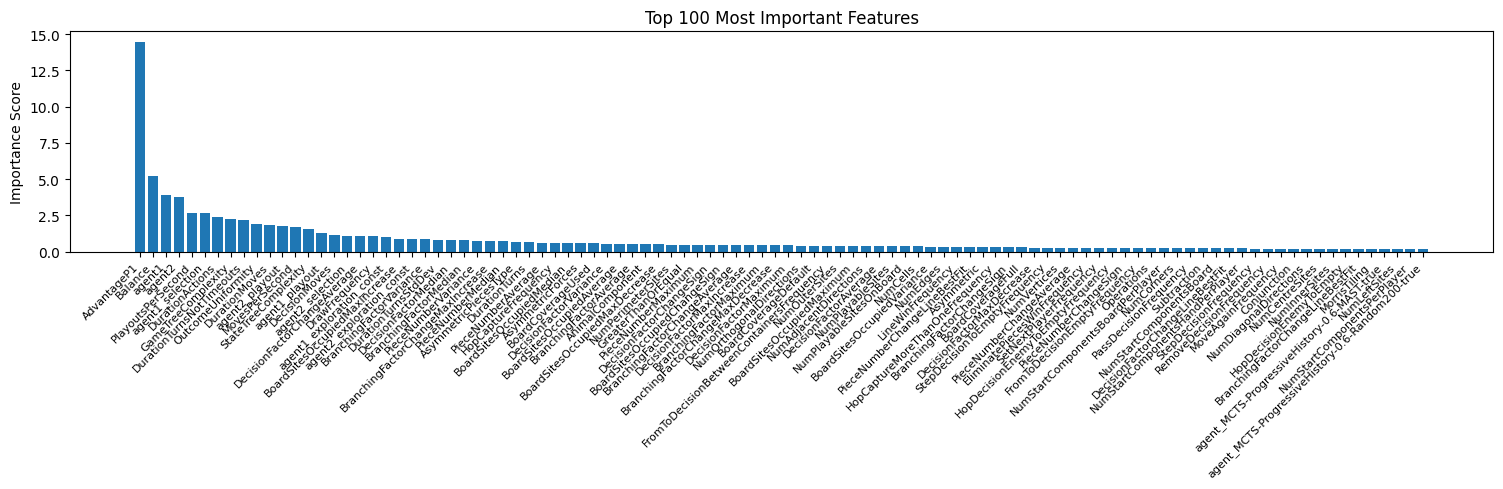

Fold 1 - RMSE: 0.41241913543703884
Fold 2


0:	learn: 0.6242687	test: 0.5895140	best: 0.5895140 (0)	total: 103ms	remaining: 17m 11s


50:	learn: 0.4935746	test: 0.5331315	best: 0.5331315 (50)	total: 5.76s	remaining: 18m 42s


100:	learn: 0.4466493	test: 0.5078271	best: 0.5078271 (100)	total: 11.5s	remaining: 18m 52s


150:	learn: 0.4208729	test: 0.4939375	best: 0.4939375 (150)	total: 17.6s	remaining: 19m 6s


200:	learn: 0.4027949	test: 0.4836904	best: 0.4836904 (200)	total: 23.8s	remaining: 19m 21s


250:	learn: 0.3892870	test: 0.4769921	best: 0.4769921 (250)	total: 30.1s	remaining: 19m 29s


300:	learn: 0.3785030	test: 0.4723309	best: 0.4723309 (300)	total: 36.5s	remaining: 19m 34s


350:	learn: 0.3698058	test: 0.4687460	best: 0.4687460 (350)	total: 42.7s	remaining: 19m 34s


400:	learn: 0.3622129	test: 0.4663003	best: 0.4663003 (400)	total: 49s	remaining: 19m 32s


450:	learn: 0.3551307	test: 0.4637680	best: 0.4637680 (450)	total: 55.2s	remaining: 19m 29s


500:	learn: 0.3487469	test: 0.4616965	best: 0.4616965 (500)	total: 1m 1s	remaining: 19m 25s


550:	learn: 0.3433536	test: 0.4599346	best: 0.4599346 (550)	total: 1m 7s	remaining: 19m 19s


600:	learn: 0.3385978	test: 0.4581157	best: 0.4581157 (600)	total: 1m 13s	remaining: 19m 15s


650:	learn: 0.3341719	test: 0.4567110	best: 0.4567110 (650)	total: 1m 20s	remaining: 19m 9s


700:	learn: 0.3300430	test: 0.4551558	best: 0.4551455 (699)	total: 1m 26s	remaining: 19m 3s


750:	learn: 0.3258342	test: 0.4545846	best: 0.4545846 (750)	total: 1m 32s	remaining: 18m 58s


800:	learn: 0.3221328	test: 0.4535831	best: 0.4535683 (799)	total: 1m 38s	remaining: 18m 51s


850:	learn: 0.3186185	test: 0.4526975	best: 0.4526975 (850)	total: 1m 44s	remaining: 18m 44s


900:	learn: 0.3152549	test: 0.4519057	best: 0.4519057 (900)	total: 1m 50s	remaining: 18m 38s


950:	learn: 0.3123656	test: 0.4512769	best: 0.4512520 (946)	total: 1m 57s	remaining: 18m 33s


1000:	learn: 0.3093793	test: 0.4506341	best: 0.4506341 (1000)	total: 2m 3s	remaining: 18m 27s


1050:	learn: 0.3069995	test: 0.4501568	best: 0.4501503 (1049)	total: 2m 9s	remaining: 18m 21s


1100:	learn: 0.3045700	test: 0.4498490	best: 0.4498490 (1100)	total: 2m 15s	remaining: 18m 15s


1150:	learn: 0.3023029	test: 0.4494476	best: 0.4494476 (1150)	total: 2m 21s	remaining: 18m 10s


1200:	learn: 0.3002008	test: 0.4492433	best: 0.4492433 (1200)	total: 2m 27s	remaining: 18m 3s


1250:	learn: 0.2980738	test: 0.4486656	best: 0.4486656 (1250)	total: 2m 34s	remaining: 17m 57s


1300:	learn: 0.2959935	test: 0.4484188	best: 0.4484188 (1300)	total: 2m 40s	remaining: 17m 51s


1350:	learn: 0.2939327	test: 0.4481509	best: 0.4481480 (1347)	total: 2m 46s	remaining: 17m 45s


1400:	learn: 0.2918463	test: 0.4477132	best: 0.4477132 (1400)	total: 2m 52s	remaining: 17m 40s


1450:	learn: 0.2900092	test: 0.4474631	best: 0.4474631 (1450)	total: 2m 58s	remaining: 17m 34s


1500:	learn: 0.2881917	test: 0.4470218	best: 0.4470218 (1500)	total: 3m 5s	remaining: 17m 28s


1550:	learn: 0.2863025	test: 0.4466590	best: 0.4466512 (1549)	total: 3m 11s	remaining: 17m 22s


1600:	learn: 0.2845692	test: 0.4464128	best: 0.4463847 (1595)	total: 3m 17s	remaining: 17m 17s


1650:	learn: 0.2829573	test: 0.4461516	best: 0.4461440 (1649)	total: 3m 23s	remaining: 17m 10s


1700:	learn: 0.2813578	test: 0.4459309	best: 0.4459309 (1700)	total: 3m 30s	remaining: 17m 5s


1750:	learn: 0.2798100	test: 0.4457064	best: 0.4457023 (1744)	total: 3m 36s	remaining: 16m 58s


1800:	learn: 0.2782202	test: 0.4454180	best: 0.4454044 (1794)	total: 3m 42s	remaining: 16m 53s


1850:	learn: 0.2767287	test: 0.4450407	best: 0.4450407 (1850)	total: 3m 48s	remaining: 16m 47s


1900:	learn: 0.2753771	test: 0.4449105	best: 0.4449030 (1898)	total: 3m 55s	remaining: 16m 41s


1950:	learn: 0.2739950	test: 0.4447469	best: 0.4447296 (1949)	total: 4m 1s	remaining: 16m 35s


2000:	learn: 0.2726927	test: 0.4445539	best: 0.4445539 (2000)	total: 4m 7s	remaining: 16m 29s


2050:	learn: 0.2713289	test: 0.4444243	best: 0.4444243 (2050)	total: 4m 13s	remaining: 16m 23s


2100:	learn: 0.2701001	test: 0.4442399	best: 0.4442399 (2100)	total: 4m 19s	remaining: 16m 16s


2150:	learn: 0.2688646	test: 0.4441516	best: 0.4441492 (2147)	total: 4m 26s	remaining: 16m 11s


2200:	learn: 0.2677640	test: 0.4440538	best: 0.4440538 (2200)	total: 4m 32s	remaining: 16m 5s


2250:	learn: 0.2666640	test: 0.4438689	best: 0.4438664 (2249)	total: 4m 38s	remaining: 15m 59s


2300:	learn: 0.2654593	test: 0.4437544	best: 0.4437544 (2300)	total: 4m 44s	remaining: 15m 53s


2350:	learn: 0.2643649	test: 0.4436646	best: 0.4436623 (2347)	total: 4m 51s	remaining: 15m 47s


2400:	learn: 0.2631919	test: 0.4434834	best: 0.4434834 (2400)	total: 4m 57s	remaining: 15m 40s


2450:	learn: 0.2620667	test: 0.4433082	best: 0.4433019 (2448)	total: 5m 3s	remaining: 15m 34s


2500:	learn: 0.2610499	test: 0.4431085	best: 0.4431085 (2500)	total: 5m 9s	remaining: 15m 28s


2550:	learn: 0.2600614	test: 0.4429644	best: 0.4429472 (2540)	total: 5m 16s	remaining: 15m 23s


2600:	learn: 0.2590859	test: 0.4427763	best: 0.4427763 (2600)	total: 5m 22s	remaining: 15m 17s


2650:	learn: 0.2580185	test: 0.4426740	best: 0.4426715 (2648)	total: 5m 28s	remaining: 15m 11s


2700:	learn: 0.2570195	test: 0.4425446	best: 0.4425279 (2697)	total: 5m 35s	remaining: 15m 5s


2750:	learn: 0.2560504	test: 0.4424024	best: 0.4423987 (2748)	total: 5m 41s	remaining: 14m 59s


2800:	learn: 0.2551410	test: 0.4423115	best: 0.4423115 (2800)	total: 5m 47s	remaining: 14m 53s


2850:	learn: 0.2543376	test: 0.4422335	best: 0.4422332 (2849)	total: 5m 53s	remaining: 14m 47s


2900:	learn: 0.2535102	test: 0.4421156	best: 0.4420960 (2892)	total: 6m	remaining: 14m 41s


2950:	learn: 0.2525872	test: 0.4420574	best: 0.4420492 (2949)	total: 6m 6s	remaining: 14m 35s


3000:	learn: 0.2518530	test: 0.4420077	best: 0.4420000 (2998)	total: 6m 12s	remaining: 14m 29s


3050:	learn: 0.2510263	test: 0.4418676	best: 0.4418676 (3050)	total: 6m 19s	remaining: 14m 23s


3100:	learn: 0.2502247	test: 0.4417859	best: 0.4417859 (3100)	total: 6m 25s	remaining: 14m 17s


3150:	learn: 0.2493583	test: 0.4417100	best: 0.4417100 (3150)	total: 6m 31s	remaining: 14m 11s


3200:	learn: 0.2485883	test: 0.4416516	best: 0.4416511 (3192)	total: 6m 38s	remaining: 14m 5s


3250:	learn: 0.2477639	test: 0.4415736	best: 0.4415691 (3247)	total: 6m 44s	remaining: 13m 59s


3300:	learn: 0.2468961	test: 0.4414933	best: 0.4414905 (3294)	total: 6m 50s	remaining: 13m 53s


3350:	learn: 0.2461873	test: 0.4414156	best: 0.4413940 (3348)	total: 6m 57s	remaining: 13m 47s


3400:	learn: 0.2454041	test: 0.4413044	best: 0.4413035 (3399)	total: 7m 3s	remaining: 13m 41s


3450:	learn: 0.2446603	test: 0.4412133	best: 0.4412117 (3447)	total: 7m 9s	remaining: 13m 35s


3500:	learn: 0.2438765	test: 0.4411279	best: 0.4411279 (3500)	total: 7m 15s	remaining: 13m 29s


3550:	learn: 0.2432425	test: 0.4410757	best: 0.4410628 (3540)	total: 7m 22s	remaining: 13m 23s


3600:	learn: 0.2425476	test: 0.4410498	best: 0.4410498 (3600)	total: 7m 28s	remaining: 13m 16s


3650:	learn: 0.2418443	test: 0.4409349	best: 0.4409349 (3650)	total: 7m 34s	remaining: 13m 10s


3700:	learn: 0.2411983	test: 0.4408835	best: 0.4408835 (3700)	total: 7m 41s	remaining: 13m 4s


3750:	learn: 0.2405435	test: 0.4407686	best: 0.4407686 (3750)	total: 7m 47s	remaining: 12m 58s


3800:	learn: 0.2399082	test: 0.4407457	best: 0.4407430 (3783)	total: 7m 53s	remaining: 12m 52s


3850:	learn: 0.2393031	test: 0.4407429	best: 0.4407347 (3846)	total: 7m 59s	remaining: 12m 45s


3900:	learn: 0.2386684	test: 0.4406623	best: 0.4406584 (3899)	total: 8m 5s	remaining: 12m 39s


3950:	learn: 0.2380183	test: 0.4405442	best: 0.4405442 (3950)	total: 8m 12s	remaining: 12m 33s


4000:	learn: 0.2374555	test: 0.4404431	best: 0.4404431 (4000)	total: 8m 18s	remaining: 12m 27s


4050:	learn: 0.2368633	test: 0.4404096	best: 0.4404031 (4042)	total: 8m 24s	remaining: 12m 21s


4100:	learn: 0.2362526	test: 0.4403720	best: 0.4403602 (4090)	total: 8m 31s	remaining: 12m 15s


4150:	learn: 0.2356558	test: 0.4403159	best: 0.4403074 (4148)	total: 8m 37s	remaining: 12m 9s


4200:	learn: 0.2350458	test: 0.4403007	best: 0.4402815 (4178)	total: 8m 43s	remaining: 12m 3s


4250:	learn: 0.2344539	test: 0.4402216	best: 0.4402183 (4238)	total: 8m 50s	remaining: 11m 56s


4300:	learn: 0.2338884	test: 0.4401809	best: 0.4401741 (4297)	total: 8m 56s	remaining: 11m 50s


4350:	learn: 0.2332570	test: 0.4400822	best: 0.4400708 (4342)	total: 9m 2s	remaining: 11m 44s


4400:	learn: 0.2326472	test: 0.4400428	best: 0.4400307 (4396)	total: 9m 8s	remaining: 11m 38s


4450:	learn: 0.2321071	test: 0.4400108	best: 0.4399997 (4445)	total: 9m 14s	remaining: 11m 31s


4500:	learn: 0.2315194	test: 0.4399414	best: 0.4399380 (4498)	total: 9m 21s	remaining: 11m 25s


4550:	learn: 0.2309485	test: 0.4398702	best: 0.4398687 (4548)	total: 9m 27s	remaining: 11m 19s


4600:	learn: 0.2304049	test: 0.4398330	best: 0.4398320 (4599)	total: 9m 33s	remaining: 11m 13s


4650:	learn: 0.2298351	test: 0.4398272	best: 0.4398272 (4650)	total: 9m 40s	remaining: 11m 7s


4700:	learn: 0.2293339	test: 0.4398068	best: 0.4397958 (4694)	total: 9m 46s	remaining: 11m 1s


4750:	learn: 0.2288016	test: 0.4397671	best: 0.4397671 (4750)	total: 9m 52s	remaining: 10m 54s


4800:	learn: 0.2282885	test: 0.4397516	best: 0.4397499 (4798)	total: 9m 59s	remaining: 10m 48s


4850:	learn: 0.2277634	test: 0.4397058	best: 0.4397037 (4849)	total: 10m 5s	remaining: 10m 42s


4900:	learn: 0.2272813	test: 0.4396608	best: 0.4396548 (4894)	total: 10m 11s	remaining: 10m 36s


4950:	learn: 0.2267482	test: 0.4396294	best: 0.4396248 (4932)	total: 10m 17s	remaining: 10m 30s


5000:	learn: 0.2262527	test: 0.4395678	best: 0.4395650 (4996)	total: 10m 24s	remaining: 10m 23s


5050:	learn: 0.2257208	test: 0.4395365	best: 0.4395319 (5028)	total: 10m 30s	remaining: 10m 17s


5100:	learn: 0.2252128	test: 0.4395096	best: 0.4395086 (5099)	total: 10m 36s	remaining: 10m 11s


5150:	learn: 0.2247340	test: 0.4394695	best: 0.4394695 (5150)	total: 10m 42s	remaining: 10m 5s


5200:	learn: 0.2242148	test: 0.4394078	best: 0.4394078 (5200)	total: 10m 49s	remaining: 9m 58s


5250:	learn: 0.2237063	test: 0.4393615	best: 0.4393600 (5248)	total: 10m 55s	remaining: 9m 52s


5300:	learn: 0.2232244	test: 0.4393602	best: 0.4393578 (5261)	total: 11m 1s	remaining: 9m 46s


5350:	learn: 0.2227704	test: 0.4393255	best: 0.4393255 (5350)	total: 11m 7s	remaining: 9m 40s


5400:	learn: 0.2223500	test: 0.4392726	best: 0.4392719 (5399)	total: 11m 14s	remaining: 9m 34s


5450:	learn: 0.2218443	test: 0.4392629	best: 0.4392377 (5441)	total: 11m 20s	remaining: 9m 27s


5500:	learn: 0.2213475	test: 0.4392333	best: 0.4392333 (5500)	total: 11m 26s	remaining: 9m 21s


5550:	learn: 0.2208641	test: 0.4392121	best: 0.4392054 (5540)	total: 11m 32s	remaining: 9m 15s


5600:	learn: 0.2203896	test: 0.4391534	best: 0.4391497 (5589)	total: 11m 39s	remaining: 9m 9s


5650:	learn: 0.2199099	test: 0.4391177	best: 0.4391156 (5644)	total: 11m 45s	remaining: 9m 2s


5700:	learn: 0.2194513	test: 0.4390839	best: 0.4390839 (5700)	total: 11m 51s	remaining: 8m 56s


5750:	learn: 0.2190297	test: 0.4390765	best: 0.4390619 (5740)	total: 11m 57s	remaining: 8m 50s


5800:	learn: 0.2185776	test: 0.4390347	best: 0.4390332 (5799)	total: 12m 4s	remaining: 8m 44s


5850:	learn: 0.2181367	test: 0.4390331	best: 0.4390259 (5835)	total: 12m 10s	remaining: 8m 37s


5900:	learn: 0.2176355	test: 0.4389764	best: 0.4389758 (5897)	total: 12m 16s	remaining: 8m 31s


5950:	learn: 0.2171804	test: 0.4389760	best: 0.4389678 (5943)	total: 12m 23s	remaining: 8m 25s


6000:	learn: 0.2167780	test: 0.4389738	best: 0.4389586 (5980)	total: 12m 29s	remaining: 8m 19s


6050:	learn: 0.2162891	test: 0.4389286	best: 0.4389286 (6050)	total: 12m 35s	remaining: 8m 13s


6100:	learn: 0.2158655	test: 0.4389170	best: 0.4389136 (6093)	total: 12m 41s	remaining: 8m 6s


6150:	learn: 0.2154441	test: 0.4389125	best: 0.4388959 (6120)	total: 12m 48s	remaining: 8m


6200:	learn: 0.2150295	test: 0.4388950	best: 0.4388925 (6199)	total: 12m 54s	remaining: 7m 54s


6250:	learn: 0.2146153	test: 0.4388324	best: 0.4388324 (6250)	total: 13m	remaining: 7m 48s


6300:	learn: 0.2142466	test: 0.4388451	best: 0.4388204 (6262)	total: 13m 7s	remaining: 7m 42s


6350:	learn: 0.2138145	test: 0.4388001	best: 0.4387998 (6349)	total: 13m 13s	remaining: 7m 35s


6400:	learn: 0.2133928	test: 0.4387780	best: 0.4387768 (6398)	total: 13m 19s	remaining: 7m 29s


6450:	learn: 0.2129533	test: 0.4387700	best: 0.4387594 (6426)	total: 13m 25s	remaining: 7m 23s


6500:	learn: 0.2125693	test: 0.4387459	best: 0.4387459 (6500)	total: 13m 32s	remaining: 7m 17s


6550:	learn: 0.2121856	test: 0.4387281	best: 0.4387160 (6544)	total: 13m 38s	remaining: 7m 10s


6600:	learn: 0.2117810	test: 0.4387153	best: 0.4387104 (6582)	total: 13m 44s	remaining: 7m 4s


6650:	learn: 0.2114218	test: 0.4387115	best: 0.4386984 (6641)	total: 13m 51s	remaining: 6m 58s


6700:	learn: 0.2110003	test: 0.4387217	best: 0.4386984 (6641)	total: 13m 57s	remaining: 6m 52s


6750:	learn: 0.2106314	test: 0.4386891	best: 0.4386884 (6749)	total: 14m 3s	remaining: 6m 46s


6800:	learn: 0.2102350	test: 0.4386371	best: 0.4386362 (6796)	total: 14m 9s	remaining: 6m 39s


6850:	learn: 0.2098333	test: 0.4386263	best: 0.4385989 (6822)	total: 14m 16s	remaining: 6m 33s


6900:	learn: 0.2094330	test: 0.4386140	best: 0.4385989 (6822)	total: 14m 22s	remaining: 6m 27s


6950:	learn: 0.2090849	test: 0.4386103	best: 0.4385989 (6822)	total: 14m 28s	remaining: 6m 21s


7000:	learn: 0.2087062	test: 0.4385710	best: 0.4385710 (7000)	total: 14m 34s	remaining: 6m 14s


7050:	learn: 0.2082926	test: 0.4385833	best: 0.4385658 (7027)	total: 14m 41s	remaining: 6m 8s


7100:	learn: 0.2078936	test: 0.4385474	best: 0.4385444 (7098)	total: 14m 47s	remaining: 6m 2s


7150:	learn: 0.2075507	test: 0.4385377	best: 0.4385374 (7149)	total: 14m 53s	remaining: 5m 56s


7200:	learn: 0.2071806	test: 0.4384981	best: 0.4384981 (7200)	total: 14m 59s	remaining: 5m 49s


7250:	learn: 0.2067998	test: 0.4384583	best: 0.4384545 (7239)	total: 15m 5s	remaining: 5m 43s


7300:	learn: 0.2064349	test: 0.4384301	best: 0.4384287 (7290)	total: 15m 12s	remaining: 5m 37s


7350:	learn: 0.2060803	test: 0.4384046	best: 0.4384045 (7346)	total: 15m 18s	remaining: 5m 30s


7400:	learn: 0.2057335	test: 0.4384000	best: 0.4383915 (7375)	total: 15m 24s	remaining: 5m 24s


7450:	learn: 0.2053879	test: 0.4383939	best: 0.4383887 (7427)	total: 15m 31s	remaining: 5m 18s


7500:	learn: 0.2050332	test: 0.4383879	best: 0.4383780 (7477)	total: 15m 37s	remaining: 5m 12s


7550:	learn: 0.2047111	test: 0.4383521	best: 0.4383513 (7549)	total: 15m 43s	remaining: 5m 6s


7600:	learn: 0.2043264	test: 0.4383439	best: 0.4383439 (7600)	total: 15m 49s	remaining: 4m 59s


7650:	learn: 0.2039308	test: 0.4383106	best: 0.4383106 (7650)	total: 15m 56s	remaining: 4m 53s


7700:	learn: 0.2036176	test: 0.4383066	best: 0.4383018 (7671)	total: 16m 2s	remaining: 4m 47s


7750:	learn: 0.2032320	test: 0.4382653	best: 0.4382653 (7750)	total: 16m 8s	remaining: 4m 41s


7800:	learn: 0.2028969	test: 0.4382487	best: 0.4382482 (7796)	total: 16m 14s	remaining: 4m 34s


7850:	learn: 0.2025410	test: 0.4382197	best: 0.4382197 (7850)	total: 16m 21s	remaining: 4m 28s


7900:	learn: 0.2021763	test: 0.4382002	best: 0.4381984 (7888)	total: 16m 27s	remaining: 4m 22s


7950:	learn: 0.2018317	test: 0.4381712	best: 0.4381693 (7947)	total: 16m 33s	remaining: 4m 16s


8000:	learn: 0.2014575	test: 0.4381473	best: 0.4381470 (7999)	total: 16m 39s	remaining: 4m 9s


8050:	learn: 0.2011206	test: 0.4381471	best: 0.4381433 (8012)	total: 16m 46s	remaining: 4m 3s


8100:	learn: 0.2008004	test: 0.4381469	best: 0.4381359 (8070)	total: 16m 52s	remaining: 3m 57s


8150:	learn: 0.2004637	test: 0.4381438	best: 0.4381359 (8070)	total: 16m 58s	remaining: 3m 51s


8200:	learn: 0.2001541	test: 0.4381433	best: 0.4381357 (8185)	total: 17m 4s	remaining: 3m 44s


8250:	learn: 0.1998128	test: 0.4381127	best: 0.4381095 (8242)	total: 17m 11s	remaining: 3m 38s


8300:	learn: 0.1994622	test: 0.4381073	best: 0.4380941 (8289)	total: 17m 17s	remaining: 3m 32s


8350:	learn: 0.1991298	test: 0.4380942	best: 0.4380924 (8345)	total: 17m 23s	remaining: 3m 26s


8400:	learn: 0.1987890	test: 0.4380570	best: 0.4380570 (8400)	total: 17m 29s	remaining: 3m 19s


8450:	learn: 0.1984762	test: 0.4380677	best: 0.4380550 (8423)	total: 17m 35s	remaining: 3m 13s


8500:	learn: 0.1981589	test: 0.4380576	best: 0.4380550 (8423)	total: 17m 42s	remaining: 3m 7s


8550:	learn: 0.1978600	test: 0.4380567	best: 0.4380509 (8514)	total: 17m 48s	remaining: 3m 1s


8600:	learn: 0.1975455	test: 0.4380358	best: 0.4380251 (8593)	total: 17m 54s	remaining: 2m 54s


8650:	learn: 0.1972569	test: 0.4380286	best: 0.4380240 (8645)	total: 18m 1s	remaining: 2m 48s


8700:	learn: 0.1969440	test: 0.4380021	best: 0.4380021 (8700)	total: 18m 7s	remaining: 2m 42s


8750:	learn: 0.1966414	test: 0.4379975	best: 0.4379831 (8717)	total: 18m 13s	remaining: 2m 36s


8800:	learn: 0.1963366	test: 0.4379904	best: 0.4379831 (8717)	total: 18m 20s	remaining: 2m 29s


8850:	learn: 0.1960370	test: 0.4379622	best: 0.4379622 (8850)	total: 18m 26s	remaining: 2m 23s


8900:	learn: 0.1957071	test: 0.4379531	best: 0.4379531 (8900)	total: 18m 32s	remaining: 2m 17s


8950:	learn: 0.1954032	test: 0.4379420	best: 0.4379408 (8934)	total: 18m 38s	remaining: 2m 11s


9000:	learn: 0.1950817	test: 0.4379342	best: 0.4379342 (9000)	total: 18m 45s	remaining: 2m 4s


9050:	learn: 0.1947995	test: 0.4379305	best: 0.4379262 (9025)	total: 18m 51s	remaining: 1m 58s


9100:	learn: 0.1944763	test: 0.4379204	best: 0.4379166 (9083)	total: 18m 57s	remaining: 1m 52s


9150:	learn: 0.1942009	test: 0.4379144	best: 0.4379110 (9141)	total: 19m 3s	remaining: 1m 46s


9200:	learn: 0.1939031	test: 0.4378857	best: 0.4378854 (9198)	total: 19m 10s	remaining: 1m 39s


9250:	learn: 0.1935718	test: 0.4378735	best: 0.4378716 (9248)	total: 19m 16s	remaining: 1m 33s


9300:	learn: 0.1932542	test: 0.4378674	best: 0.4378665 (9297)	total: 19m 22s	remaining: 1m 27s


9350:	learn: 0.1929441	test: 0.4378402	best: 0.4378364 (9338)	total: 19m 28s	remaining: 1m 21s


9400:	learn: 0.1926393	test: 0.4378241	best: 0.4378239 (9397)	total: 19m 35s	remaining: 1m 14s


9450:	learn: 0.1923380	test: 0.4378269	best: 0.4378228 (9447)	total: 19m 41s	remaining: 1m 8s


9500:	learn: 0.1920519	test: 0.4378231	best: 0.4378221 (9498)	total: 19m 47s	remaining: 1m 2s


9550:	learn: 0.1917231	test: 0.4377828	best: 0.4377817 (9549)	total: 19m 54s	remaining: 56.1s


9600:	learn: 0.1914376	test: 0.4377570	best: 0.4377567 (9598)	total: 20m	remaining: 49.9s


9650:	learn: 0.1911622	test: 0.4377419	best: 0.4377417 (9648)	total: 20m 6s	remaining: 43.6s


9700:	learn: 0.1908932	test: 0.4377423	best: 0.4377417 (9648)	total: 20m 12s	remaining: 37.4s


9750:	learn: 0.1906067	test: 0.4377481	best: 0.4377417 (9648)	total: 20m 19s	remaining: 31.1s


9800:	learn: 0.1903132	test: 0.4377387	best: 0.4377279 (9771)	total: 20m 25s	remaining: 24.9s


9850:	learn: 0.1900258	test: 0.4377379	best: 0.4377279 (9771)	total: 20m 31s	remaining: 18.6s


9900:	learn: 0.1897482	test: 0.4377239	best: 0.4377239 (9900)	total: 20m 37s	remaining: 12.4s


9950:	learn: 0.1894862	test: 0.4377064	best: 0.4377056 (9946)	total: 20m 44s	remaining: 6.13s


9999:	learn: 0.1892199	test: 0.4377085	best: 0.4377038 (9988)	total: 20m 50s	remaining: 0us

bestTest = 0.4377037536
bestIteration = 9988

Shrink model to first 9989 iterations.


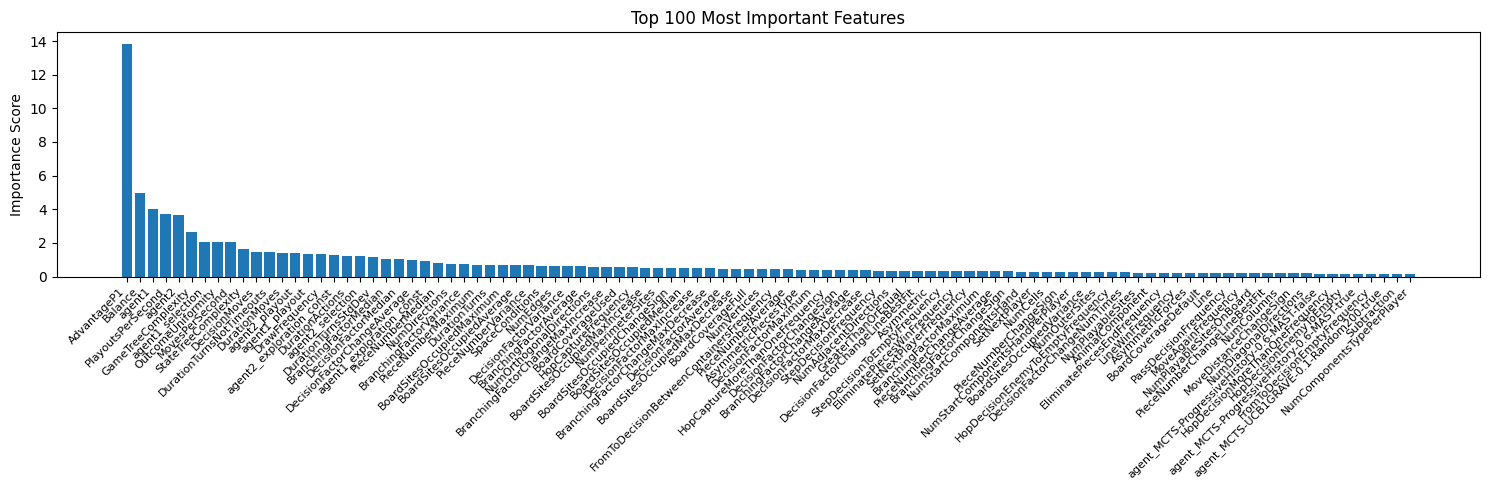

Fold 2 - RMSE: 0.43737478386651546
Fold 3


0:	learn: 0.6209270	test: 0.6063760	best: 0.6063760 (0)	total: 96.1ms	remaining: 16m


50:	learn: 0.4903047	test: 0.5319158	best: 0.5319158 (50)	total: 5.66s	remaining: 18m 24s


100:	learn: 0.4446726	test: 0.4976901	best: 0.4976901 (100)	total: 11.4s	remaining: 18m 39s


150:	learn: 0.4183134	test: 0.4818491	best: 0.4818491 (150)	total: 17.4s	remaining: 18m 53s


200:	learn: 0.4006650	test: 0.4714448	best: 0.4714448 (200)	total: 23.6s	remaining: 19m 10s


250:	learn: 0.3887014	test: 0.4658374	best: 0.4658374 (250)	total: 29.9s	remaining: 19m 20s


300:	learn: 0.3790934	test: 0.4612140	best: 0.4612140 (300)	total: 36.2s	remaining: 19m 27s


350:	learn: 0.3707800	test: 0.4578566	best: 0.4577683 (349)	total: 42.5s	remaining: 19m 28s


400:	learn: 0.3632376	test: 0.4546444	best: 0.4546084 (399)	total: 48.6s	remaining: 19m 24s


450:	learn: 0.3568068	test: 0.4525007	best: 0.4524773 (449)	total: 54.9s	remaining: 19m 21s


500:	learn: 0.3508970	test: 0.4503487	best: 0.4503487 (500)	total: 1m	remaining: 19m 16s


550:	learn: 0.3453338	test: 0.4481164	best: 0.4481164 (550)	total: 1m 7s	remaining: 19m 9s


600:	learn: 0.3403480	test: 0.4464352	best: 0.4464352 (600)	total: 1m 13s	remaining: 19m 4s


650:	learn: 0.3354134	test: 0.4447815	best: 0.4447815 (650)	total: 1m 19s	remaining: 18m 55s


700:	learn: 0.3310680	test: 0.4434041	best: 0.4434041 (700)	total: 1m 25s	remaining: 18m 48s


750:	learn: 0.3271253	test: 0.4423462	best: 0.4423462 (750)	total: 1m 31s	remaining: 18m 42s


800:	learn: 0.3232674	test: 0.4411825	best: 0.4411825 (800)	total: 1m 37s	remaining: 18m 36s


850:	learn: 0.3197792	test: 0.4401820	best: 0.4401820 (850)	total: 1m 43s	remaining: 18m 30s


900:	learn: 0.3167099	test: 0.4394507	best: 0.4394507 (900)	total: 1m 49s	remaining: 18m 26s


950:	learn: 0.3137282	test: 0.4385129	best: 0.4385129 (950)	total: 1m 55s	remaining: 18m 20s


1000:	learn: 0.3109065	test: 0.4378298	best: 0.4378298 (1000)	total: 2m 1s	remaining: 18m 15s


1050:	learn: 0.3084382	test: 0.4372627	best: 0.4372627 (1050)	total: 2m 8s	remaining: 18m 10s


1100:	learn: 0.3058436	test: 0.4368192	best: 0.4368184 (1097)	total: 2m 14s	remaining: 18m 4s


1150:	learn: 0.3036166	test: 0.4364175	best: 0.4364175 (1150)	total: 2m 20s	remaining: 17m 58s


1200:	learn: 0.3013047	test: 0.4359329	best: 0.4359241 (1199)	total: 2m 26s	remaining: 17m 52s


1250:	learn: 0.2991515	test: 0.4353954	best: 0.4353880 (1248)	total: 2m 32s	remaining: 17m 46s


1300:	learn: 0.2969997	test: 0.4349879	best: 0.4349879 (1300)	total: 2m 38s	remaining: 17m 40s


1350:	learn: 0.2948533	test: 0.4344827	best: 0.4344827 (1350)	total: 2m 44s	remaining: 17m 34s


1400:	learn: 0.2930573	test: 0.4341578	best: 0.4341578 (1400)	total: 2m 50s	remaining: 17m 28s


1450:	learn: 0.2912018	test: 0.4339084	best: 0.4338895 (1443)	total: 2m 56s	remaining: 17m 22s


1500:	learn: 0.2895475	test: 0.4335751	best: 0.4335751 (1500)	total: 3m 2s	remaining: 17m 15s


1550:	learn: 0.2878621	test: 0.4332312	best: 0.4332312 (1550)	total: 3m 9s	remaining: 17m 9s


1600:	learn: 0.2861800	test: 0.4328471	best: 0.4328471 (1600)	total: 3m 15s	remaining: 17m 3s


1650:	learn: 0.2844307	test: 0.4325426	best: 0.4325426 (1650)	total: 3m 21s	remaining: 16m 57s


1700:	learn: 0.2826797	test: 0.4322474	best: 0.4322474 (1700)	total: 3m 27s	remaining: 16m 51s


1750:	learn: 0.2810902	test: 0.4320618	best: 0.4320618 (1750)	total: 3m 33s	remaining: 16m 45s


1800:	learn: 0.2794941	test: 0.4317084	best: 0.4317083 (1799)	total: 3m 39s	remaining: 16m 39s


1850:	learn: 0.2779580	test: 0.4313943	best: 0.4313809 (1846)	total: 3m 45s	remaining: 16m 33s


1900:	learn: 0.2764654	test: 0.4310745	best: 0.4310745 (1900)	total: 3m 51s	remaining: 16m 27s


1950:	learn: 0.2752201	test: 0.4308930	best: 0.4308790 (1941)	total: 3m 58s	remaining: 16m 22s


2000:	learn: 0.2737292	test: 0.4306256	best: 0.4306145 (1999)	total: 4m 4s	remaining: 16m 16s


2050:	learn: 0.2724279	test: 0.4304743	best: 0.4304651 (2046)	total: 4m 10s	remaining: 16m 10s


2100:	learn: 0.2711702	test: 0.4302962	best: 0.4302953 (2099)	total: 4m 16s	remaining: 16m 4s


2150:	learn: 0.2699484	test: 0.4301411	best: 0.4301411 (2150)	total: 4m 22s	remaining: 15m 58s


2200:	learn: 0.2687927	test: 0.4299006	best: 0.4299004 (2199)	total: 4m 28s	remaining: 15m 52s


2250:	learn: 0.2675624	test: 0.4297342	best: 0.4297342 (2250)	total: 4m 34s	remaining: 15m 46s


2300:	learn: 0.2663571	test: 0.4295508	best: 0.4295508 (2300)	total: 4m 41s	remaining: 15m 40s


2350:	learn: 0.2652592	test: 0.4293408	best: 0.4293408 (2350)	total: 4m 47s	remaining: 15m 34s


2400:	learn: 0.2640848	test: 0.4292321	best: 0.4292265 (2398)	total: 4m 53s	remaining: 15m 28s


2450:	learn: 0.2629937	test: 0.4290728	best: 0.4290682 (2448)	total: 4m 59s	remaining: 15m 22s


2500:	learn: 0.2619148	test: 0.4289427	best: 0.4289302 (2498)	total: 5m 5s	remaining: 15m 16s


2550:	learn: 0.2608975	test: 0.4289103	best: 0.4289047 (2526)	total: 5m 11s	remaining: 15m 10s


2600:	learn: 0.2598857	test: 0.4288504	best: 0.4288476 (2599)	total: 5m 18s	remaining: 15m 5s


2650:	learn: 0.2588870	test: 0.4287033	best: 0.4287009 (2647)	total: 5m 24s	remaining: 14m 58s


2700:	learn: 0.2578685	test: 0.4284570	best: 0.4284570 (2700)	total: 5m 30s	remaining: 14m 53s


2750:	learn: 0.2568783	test: 0.4282584	best: 0.4282456 (2743)	total: 5m 36s	remaining: 14m 47s


2800:	learn: 0.2558947	test: 0.4281986	best: 0.4281906 (2798)	total: 5m 42s	remaining: 14m 41s


2850:	learn: 0.2549274	test: 0.4280330	best: 0.4280314 (2849)	total: 5m 49s	remaining: 14m 35s


2900:	learn: 0.2540581	test: 0.4279213	best: 0.4279213 (2900)	total: 5m 55s	remaining: 14m 29s


2950:	learn: 0.2531615	test: 0.4278321	best: 0.4278300 (2947)	total: 6m 1s	remaining: 14m 22s


3000:	learn: 0.2522887	test: 0.4277428	best: 0.4277395 (2995)	total: 6m 7s	remaining: 14m 17s


3050:	learn: 0.2513698	test: 0.4276308	best: 0.4276298 (3049)	total: 6m 13s	remaining: 14m 11s


3100:	learn: 0.2504739	test: 0.4275675	best: 0.4275647 (3097)	total: 6m 19s	remaining: 14m 5s


3150:	learn: 0.2496755	test: 0.4275422	best: 0.4275370 (3149)	total: 6m 26s	remaining: 13m 59s


3200:	learn: 0.2488276	test: 0.4274289	best: 0.4274177 (3194)	total: 6m 32s	remaining: 13m 53s


3250:	learn: 0.2480276	test: 0.4273296	best: 0.4273264 (3245)	total: 6m 38s	remaining: 13m 47s


3300:	learn: 0.2472122	test: 0.4272529	best: 0.4272496 (3298)	total: 6m 44s	remaining: 13m 41s


3350:	learn: 0.2464214	test: 0.4271489	best: 0.4271481 (3349)	total: 6m 51s	remaining: 13m 35s


3400:	learn: 0.2456960	test: 0.4271365	best: 0.4271075 (3369)	total: 6m 57s	remaining: 13m 29s


3450:	learn: 0.2449027	test: 0.4270000	best: 0.4269994 (3449)	total: 7m 3s	remaining: 13m 23s


3500:	learn: 0.2441469	test: 0.4269060	best: 0.4269042 (3499)	total: 7m 9s	remaining: 13m 17s


3550:	learn: 0.2434071	test: 0.4268578	best: 0.4268578 (3550)	total: 7m 15s	remaining: 13m 11s


3600:	learn: 0.2427130	test: 0.4268142	best: 0.4268142 (3600)	total: 7m 22s	remaining: 13m 5s


3650:	learn: 0.2420422	test: 0.4267545	best: 0.4267488 (3631)	total: 7m 28s	remaining: 12m 59s


3700:	learn: 0.2413654	test: 0.4266852	best: 0.4266833 (3698)	total: 7m 34s	remaining: 12m 53s


3750:	learn: 0.2406695	test: 0.4266337	best: 0.4266059 (3731)	total: 7m 40s	remaining: 12m 47s


3800:	learn: 0.2399859	test: 0.4265921	best: 0.4265665 (3786)	total: 7m 47s	remaining: 12m 41s


3850:	learn: 0.2393106	test: 0.4265058	best: 0.4265022 (3849)	total: 7m 53s	remaining: 12m 35s


3900:	learn: 0.2385900	test: 0.4264623	best: 0.4264623 (3900)	total: 7m 59s	remaining: 12m 29s


3950:	learn: 0.2379118	test: 0.4263366	best: 0.4263363 (3948)	total: 8m 5s	remaining: 12m 23s


4000:	learn: 0.2372712	test: 0.4262794	best: 0.4262638 (3990)	total: 8m 11s	remaining: 12m 17s


4050:	learn: 0.2366015	test: 0.4262102	best: 0.4262102 (4050)	total: 8m 17s	remaining: 12m 11s


4100:	learn: 0.2360086	test: 0.4261452	best: 0.4261358 (4099)	total: 8m 24s	remaining: 12m 5s


4150:	learn: 0.2354419	test: 0.4260953	best: 0.4260953 (4150)	total: 8m 30s	remaining: 11m 59s


4200:	learn: 0.2348261	test: 0.4260809	best: 0.4260784 (4175)	total: 8m 36s	remaining: 11m 53s


4250:	learn: 0.2342360	test: 0.4260092	best: 0.4260092 (4250)	total: 8m 42s	remaining: 11m 47s


4300:	learn: 0.2335922	test: 0.4260111	best: 0.4259990 (4280)	total: 8m 49s	remaining: 11m 41s


4350:	learn: 0.2329881	test: 0.4259417	best: 0.4259417 (4350)	total: 8m 55s	remaining: 11m 35s


4400:	learn: 0.2324024	test: 0.4259090	best: 0.4259041 (4395)	total: 9m 1s	remaining: 11m 28s


4450:	learn: 0.2318450	test: 0.4258377	best: 0.4258370 (4448)	total: 9m 7s	remaining: 11m 22s


4500:	learn: 0.2312616	test: 0.4257999	best: 0.4257999 (4500)	total: 9m 13s	remaining: 11m 16s


4550:	learn: 0.2307152	test: 0.4257943	best: 0.4257902 (4515)	total: 9m 20s	remaining: 11m 10s


4600:	learn: 0.2301529	test: 0.4257533	best: 0.4257494 (4589)	total: 9m 26s	remaining: 11m 4s


4650:	learn: 0.2296083	test: 0.4257328	best: 0.4257328 (4650)	total: 9m 32s	remaining: 10m 58s


4700:	learn: 0.2290897	test: 0.4256998	best: 0.4256998 (4700)	total: 9m 38s	remaining: 10m 52s


4750:	learn: 0.2285546	test: 0.4256844	best: 0.4256801 (4736)	total: 9m 45s	remaining: 10m 46s


4800:	learn: 0.2280063	test: 0.4256204	best: 0.4256204 (4800)	total: 9m 51s	remaining: 10m 40s


4850:	learn: 0.2274794	test: 0.4255701	best: 0.4255683 (4845)	total: 9m 57s	remaining: 10m 34s


4900:	learn: 0.2269583	test: 0.4255971	best: 0.4255526 (4870)	total: 10m 3s	remaining: 10m 28s


4950:	learn: 0.2264596	test: 0.4256242	best: 0.4255526 (4870)	total: 10m 9s	remaining: 10m 22s


5000:	learn: 0.2259190	test: 0.4256156	best: 0.4255526 (4870)	total: 10m 16s	remaining: 10m 15s


5050:	learn: 0.2253750	test: 0.4256085	best: 0.4255526 (4870)	total: 10m 22s	remaining: 10m 9s


5100:	learn: 0.2248663	test: 0.4255598	best: 0.4255526 (4870)	total: 10m 28s	remaining: 10m 3s


5150:	learn: 0.2243494	test: 0.4255241	best: 0.4255241 (5150)	total: 10m 34s	remaining: 9m 57s


5200:	learn: 0.2238252	test: 0.4254897	best: 0.4254885 (5179)	total: 10m 41s	remaining: 9m 51s


5250:	learn: 0.2233485	test: 0.4254306	best: 0.4254306 (5250)	total: 10m 47s	remaining: 9m 45s


5300:	learn: 0.2228536	test: 0.4253814	best: 0.4253789 (5298)	total: 10m 53s	remaining: 9m 39s


5350:	learn: 0.2223744	test: 0.4253405	best: 0.4253298 (5332)	total: 10m 59s	remaining: 9m 33s


5400:	learn: 0.2218856	test: 0.4253147	best: 0.4253147 (5400)	total: 11m 6s	remaining: 9m 27s


5450:	learn: 0.2213762	test: 0.4252509	best: 0.4252479 (5449)	total: 11m 12s	remaining: 9m 20s


5500:	learn: 0.2208872	test: 0.4252458	best: 0.4252332 (5469)	total: 11m 18s	remaining: 9m 14s


5550:	learn: 0.2204247	test: 0.4252099	best: 0.4252099 (5550)	total: 11m 24s	remaining: 9m 8s


5600:	learn: 0.2199549	test: 0.4251798	best: 0.4251798 (5600)	total: 11m 30s	remaining: 9m 2s


5650:	learn: 0.2195358	test: 0.4251553	best: 0.4251447 (5644)	total: 11m 37s	remaining: 8m 56s


5700:	learn: 0.2190501	test: 0.4250962	best: 0.4250962 (5700)	total: 11m 43s	remaining: 8m 50s


5750:	learn: 0.2185659	test: 0.4250407	best: 0.4250407 (5750)	total: 11m 49s	remaining: 8m 44s


5800:	learn: 0.2180955	test: 0.4250255	best: 0.4250151 (5782)	total: 11m 55s	remaining: 8m 38s


5850:	learn: 0.2176237	test: 0.4250126	best: 0.4250126 (5850)	total: 12m 1s	remaining: 8m 31s


5900:	learn: 0.2171593	test: 0.4249451	best: 0.4249451 (5900)	total: 12m 8s	remaining: 8m 25s


5950:	learn: 0.2167211	test: 0.4249312	best: 0.4249236 (5915)	total: 12m 14s	remaining: 8m 19s


6000:	learn: 0.2163167	test: 0.4248915	best: 0.4248915 (6000)	total: 12m 20s	remaining: 8m 13s


6050:	learn: 0.2159221	test: 0.4248819	best: 0.4248752 (6048)	total: 12m 26s	remaining: 8m 7s


6100:	learn: 0.2154930	test: 0.4248545	best: 0.4248474 (6094)	total: 12m 33s	remaining: 8m 1s


6150:	learn: 0.2150750	test: 0.4248415	best: 0.4248415 (6150)	total: 12m 39s	remaining: 7m 55s


6200:	learn: 0.2146368	test: 0.4248275	best: 0.4248253 (6199)	total: 12m 45s	remaining: 7m 49s


6250:	learn: 0.2141908	test: 0.4248126	best: 0.4248054 (6221)	total: 12m 51s	remaining: 7m 42s


6300:	learn: 0.2137800	test: 0.4247831	best: 0.4247831 (6300)	total: 12m 58s	remaining: 7m 36s


6350:	learn: 0.2133621	test: 0.4247397	best: 0.4247397 (6350)	total: 13m 4s	remaining: 7m 30s


6400:	learn: 0.2129048	test: 0.4247125	best: 0.4247125 (6400)	total: 13m 10s	remaining: 7m 24s


6450:	learn: 0.2124926	test: 0.4247013	best: 0.4246948 (6437)	total: 13m 16s	remaining: 7m 18s


6500:	learn: 0.2121130	test: 0.4246662	best: 0.4246662 (6500)	total: 13m 22s	remaining: 7m 12s


6550:	learn: 0.2117136	test: 0.4246656	best: 0.4246629 (6545)	total: 13m 29s	remaining: 7m 5s


6600:	learn: 0.2113299	test: 0.4246598	best: 0.4246598 (6600)	total: 13m 35s	remaining: 6m 59s


6650:	learn: 0.2109059	test: 0.4246644	best: 0.4246559 (6608)	total: 13m 41s	remaining: 6m 53s


6700:	learn: 0.2105295	test: 0.4246389	best: 0.4246346 (6689)	total: 13m 47s	remaining: 6m 47s


6750:	learn: 0.2101488	test: 0.4246392	best: 0.4246266 (6732)	total: 13m 53s	remaining: 6m 41s


6800:	learn: 0.2097875	test: 0.4246289	best: 0.4246266 (6732)	total: 14m	remaining: 6m 35s


6850:	learn: 0.2093998	test: 0.4245968	best: 0.4245968 (6850)	total: 14m 6s	remaining: 6m 28s


6900:	learn: 0.2090051	test: 0.4245852	best: 0.4245739 (6892)	total: 14m 12s	remaining: 6m 22s


6950:	learn: 0.2086261	test: 0.4245851	best: 0.4245739 (6892)	total: 14m 18s	remaining: 6m 16s


7000:	learn: 0.2082551	test: 0.4245490	best: 0.4245480 (6999)	total: 14m 24s	remaining: 6m 10s


7050:	learn: 0.2078958	test: 0.4245201	best: 0.4245171 (7045)	total: 14m 30s	remaining: 6m 4s


7100:	learn: 0.2075143	test: 0.4244925	best: 0.4244918 (7090)	total: 14m 37s	remaining: 5m 58s


7150:	learn: 0.2071465	test: 0.4244786	best: 0.4244761 (7138)	total: 14m 43s	remaining: 5m 51s


7200:	learn: 0.2067405	test: 0.4244663	best: 0.4244542 (7191)	total: 14m 49s	remaining: 5m 45s


7250:	learn: 0.2063985	test: 0.4244636	best: 0.4244521 (7215)	total: 14m 55s	remaining: 5m 39s


7300:	learn: 0.2060519	test: 0.4244508	best: 0.4244466 (7295)	total: 15m 1s	remaining: 5m 33s


7350:	learn: 0.2057190	test: 0.4244276	best: 0.4244276 (7350)	total: 15m 8s	remaining: 5m 27s


7400:	learn: 0.2053481	test: 0.4243884	best: 0.4243868 (7394)	total: 15m 14s	remaining: 5m 21s


7450:	learn: 0.2050106	test: 0.4243740	best: 0.4243668 (7444)	total: 15m 20s	remaining: 5m 14s


7500:	learn: 0.2046804	test: 0.4243887	best: 0.4243663 (7487)	total: 15m 26s	remaining: 5m 8s


7550:	learn: 0.2043069	test: 0.4243605	best: 0.4243590 (7536)	total: 15m 33s	remaining: 5m 2s


7600:	learn: 0.2039672	test: 0.4243303	best: 0.4243303 (7600)	total: 15m 39s	remaining: 4m 56s


7650:	learn: 0.2036075	test: 0.4243135	best: 0.4243123 (7649)	total: 15m 45s	remaining: 4m 50s


7700:	learn: 0.2032602	test: 0.4242996	best: 0.4242953 (7685)	total: 15m 51s	remaining: 4m 44s


7750:	learn: 0.2028973	test: 0.4242878	best: 0.4242752 (7740)	total: 15m 57s	remaining: 4m 37s


7800:	learn: 0.2025542	test: 0.4242650	best: 0.4242650 (7800)	total: 16m 3s	remaining: 4m 31s


7850:	learn: 0.2022049	test: 0.4242448	best: 0.4242424 (7846)	total: 16m 10s	remaining: 4m 25s


7900:	learn: 0.2018445	test: 0.4242197	best: 0.4242185 (7899)	total: 16m 16s	remaining: 4m 19s


7950:	learn: 0.2015181	test: 0.4242047	best: 0.4242023 (7933)	total: 16m 22s	remaining: 4m 13s


8000:	learn: 0.2011966	test: 0.4241867	best: 0.4241867 (8000)	total: 16m 29s	remaining: 4m 7s


8050:	learn: 0.2008790	test: 0.4241781	best: 0.4241714 (8047)	total: 16m 35s	remaining: 4m


8100:	learn: 0.2005349	test: 0.4241705	best: 0.4241596 (8094)	total: 16m 41s	remaining: 3m 54s


8150:	learn: 0.2001898	test: 0.4241755	best: 0.4241596 (8094)	total: 16m 47s	remaining: 3m 48s


8200:	learn: 0.1998608	test: 0.4241711	best: 0.4241596 (8094)	total: 16m 54s	remaining: 3m 42s


8250:	learn: 0.1995157	test: 0.4241685	best: 0.4241596 (8094)	total: 17m	remaining: 3m 36s


8300:	learn: 0.1991790	test: 0.4241448	best: 0.4241448 (8300)	total: 17m 6s	remaining: 3m 30s


8350:	learn: 0.1988615	test: 0.4241466	best: 0.4241411 (8319)	total: 17m 12s	remaining: 3m 23s


8400:	learn: 0.1985337	test: 0.4241450	best: 0.4241389 (8384)	total: 17m 19s	remaining: 3m 17s


8450:	learn: 0.1981787	test: 0.4241421	best: 0.4241287 (8419)	total: 17m 25s	remaining: 3m 11s


8500:	learn: 0.1978744	test: 0.4241396	best: 0.4241287 (8419)	total: 17m 31s	remaining: 3m 5s


8550:	learn: 0.1975423	test: 0.4241315	best: 0.4241287 (8419)	total: 17m 37s	remaining: 2m 59s


8600:	learn: 0.1971938	test: 0.4241247	best: 0.4241207 (8587)	total: 17m 44s	remaining: 2m 53s


8650:	learn: 0.1968831	test: 0.4241228	best: 0.4241094 (8614)	total: 17m 50s	remaining: 2m 46s


8700:	learn: 0.1965695	test: 0.4241009	best: 0.4241009 (8700)	total: 17m 56s	remaining: 2m 40s


8750:	learn: 0.1962377	test: 0.4240758	best: 0.4240717 (8741)	total: 18m 2s	remaining: 2m 34s


8800:	learn: 0.1959365	test: 0.4240661	best: 0.4240619 (8787)	total: 18m 9s	remaining: 2m 28s


8850:	learn: 0.1956614	test: 0.4240566	best: 0.4240510 (8840)	total: 18m 15s	remaining: 2m 22s


8900:	learn: 0.1953165	test: 0.4240629	best: 0.4240510 (8840)	total: 18m 21s	remaining: 2m 16s


8950:	learn: 0.1950183	test: 0.4240475	best: 0.4240430 (8944)	total: 18m 27s	remaining: 2m 9s


9000:	learn: 0.1946973	test: 0.4240352	best: 0.4240350 (8992)	total: 18m 34s	remaining: 2m 3s


9050:	learn: 0.1944034	test: 0.4240421	best: 0.4240279 (9012)	total: 18m 40s	remaining: 1m 57s


9100:	learn: 0.1940994	test: 0.4240066	best: 0.4240066 (9100)	total: 18m 46s	remaining: 1m 51s


9150:	learn: 0.1938104	test: 0.4239889	best: 0.4239885 (9149)	total: 18m 52s	remaining: 1m 45s


9200:	learn: 0.1935205	test: 0.4239766	best: 0.4239670 (9175)	total: 18m 59s	remaining: 1m 38s


9250:	learn: 0.1932119	test: 0.4239822	best: 0.4239670 (9175)	total: 19m 5s	remaining: 1m 32s


9300:	learn: 0.1929096	test: 0.4239678	best: 0.4239670 (9175)	total: 19m 11s	remaining: 1m 26s


9350:	learn: 0.1926236	test: 0.4239516	best: 0.4239515 (9347)	total: 19m 17s	remaining: 1m 20s


9400:	learn: 0.1923323	test: 0.4239259	best: 0.4239243 (9377)	total: 19m 24s	remaining: 1m 14s


9450:	learn: 0.1920336	test: 0.4239194	best: 0.4239194 (9450)	total: 19m 30s	remaining: 1m 7s


9500:	learn: 0.1917471	test: 0.4239107	best: 0.4239094 (9463)	total: 19m 36s	remaining: 1m 1s


9550:	learn: 0.1914428	test: 0.4239152	best: 0.4239094 (9463)	total: 19m 43s	remaining: 55.6s


9600:	learn: 0.1911622	test: 0.4238927	best: 0.4238927 (9600)	total: 19m 49s	remaining: 49.4s


9650:	learn: 0.1908792	test: 0.4238829	best: 0.4238790 (9648)	total: 19m 55s	remaining: 43.2s


9700:	learn: 0.1905613	test: 0.4238665	best: 0.4238581 (9689)	total: 20m 1s	remaining: 37s


9750:	learn: 0.1902896	test: 0.4238649	best: 0.4238581 (9689)	total: 20m 8s	remaining: 30.9s


9800:	learn: 0.1900080	test: 0.4238427	best: 0.4238385 (9787)	total: 20m 14s	remaining: 24.7s


9850:	learn: 0.1897155	test: 0.4238472	best: 0.4238381 (9809)	total: 20m 20s	remaining: 18.5s


9900:	learn: 0.1894324	test: 0.4238211	best: 0.4238211 (9900)	total: 20m 26s	remaining: 12.3s


9950:	learn: 0.1891245	test: 0.4238124	best: 0.4238027 (9924)	total: 20m 33s	remaining: 6.07s


9999:	learn: 0.1888633	test: 0.4238048	best: 0.4238027 (9924)	total: 20m 39s	remaining: 0us

bestTest = 0.4238027324
bestIteration = 9924

Shrink model to first 9925 iterations.


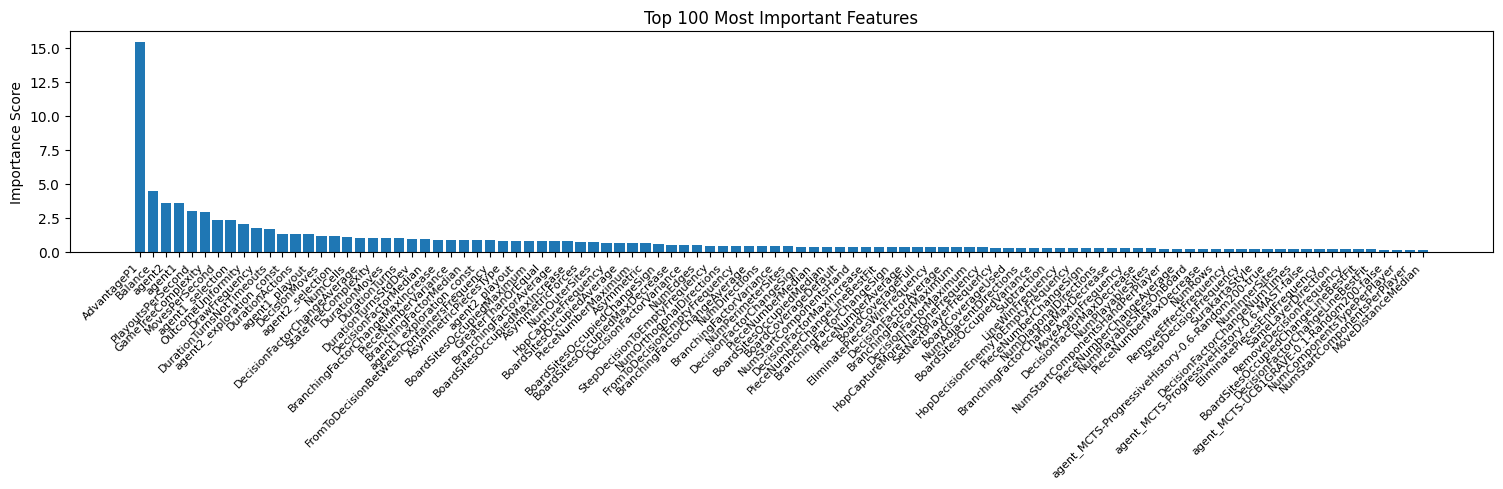

Fold 3 - RMSE: 0.4233689980314701
Fold 4


0:	learn: 0.6232613	test: 0.5961903	best: 0.5961903 (0)	total: 103ms	remaining: 17m 13s


50:	learn: 0.4850282	test: 0.5365425	best: 0.5365425 (50)	total: 5.63s	remaining: 18m 18s


100:	learn: 0.4398849	test: 0.5140723	best: 0.5140723 (100)	total: 11.3s	remaining: 18m 29s


150:	learn: 0.4160541	test: 0.5002010	best: 0.5002010 (150)	total: 17.2s	remaining: 18m 39s


200:	learn: 0.4004935	test: 0.4895643	best: 0.4895643 (200)	total: 23.3s	remaining: 18m 54s


250:	learn: 0.3877512	test: 0.4807558	best: 0.4807558 (250)	total: 29.4s	remaining: 19m 1s


300:	learn: 0.3761972	test: 0.4736330	best: 0.4736330 (300)	total: 35.4s	remaining: 18m 59s


350:	learn: 0.3666882	test: 0.4688493	best: 0.4688493 (350)	total: 41.4s	remaining: 18m 57s


400:	learn: 0.3595056	test: 0.4649295	best: 0.4649295 (400)	total: 47.6s	remaining: 18m 59s


450:	learn: 0.3531281	test: 0.4622638	best: 0.4622638 (450)	total: 53.7s	remaining: 18m 57s


500:	learn: 0.3469120	test: 0.4596828	best: 0.4596828 (500)	total: 59.9s	remaining: 18m 56s


550:	learn: 0.3411944	test: 0.4573317	best: 0.4573317 (550)	total: 1m 5s	remaining: 18m 49s


600:	learn: 0.3363545	test: 0.4554287	best: 0.4554287 (600)	total: 1m 11s	remaining: 18m 44s


650:	learn: 0.3312443	test: 0.4533186	best: 0.4533186 (650)	total: 1m 17s	remaining: 18m 37s


700:	learn: 0.3269491	test: 0.4522119	best: 0.4522119 (700)	total: 1m 23s	remaining: 18m 32s


750:	learn: 0.3229167	test: 0.4507446	best: 0.4507446 (750)	total: 1m 29s	remaining: 18m 26s


800:	learn: 0.3189711	test: 0.4494291	best: 0.4494291 (800)	total: 1m 35s	remaining: 18m 20s


850:	learn: 0.3154908	test: 0.4485376	best: 0.4485376 (850)	total: 1m 41s	remaining: 18m 15s


900:	learn: 0.3123778	test: 0.4477432	best: 0.4477408 (899)	total: 1m 47s	remaining: 18m 10s


950:	learn: 0.3094781	test: 0.4468536	best: 0.4468515 (949)	total: 1m 53s	remaining: 18m 3s


1000:	learn: 0.3067778	test: 0.4461346	best: 0.4461346 (1000)	total: 2m	remaining: 17m 59s


1050:	learn: 0.3040687	test: 0.4455500	best: 0.4455500 (1050)	total: 2m 6s	remaining: 17m 53s


1100:	learn: 0.3015058	test: 0.4449484	best: 0.4449484 (1100)	total: 2m 12s	remaining: 17m 47s


1150:	learn: 0.2990651	test: 0.4442185	best: 0.4442185 (1150)	total: 2m 18s	remaining: 17m 41s


1200:	learn: 0.2967629	test: 0.4438315	best: 0.4438315 (1200)	total: 2m 24s	remaining: 17m 35s


1250:	learn: 0.2946130	test: 0.4434715	best: 0.4434715 (1250)	total: 2m 30s	remaining: 17m 29s


1300:	learn: 0.2923729	test: 0.4430384	best: 0.4430384 (1300)	total: 2m 36s	remaining: 17m 23s


1350:	learn: 0.2902898	test: 0.4427076	best: 0.4427076 (1350)	total: 2m 42s	remaining: 17m 18s


1400:	learn: 0.2882291	test: 0.4422982	best: 0.4422982 (1400)	total: 2m 48s	remaining: 17m 12s


1450:	learn: 0.2862967	test: 0.4418684	best: 0.4418684 (1450)	total: 2m 54s	remaining: 17m 6s


1500:	learn: 0.2843985	test: 0.4414990	best: 0.4414990 (1500)	total: 3m	remaining: 17m


1550:	learn: 0.2826920	test: 0.4411604	best: 0.4411604 (1550)	total: 3m 6s	remaining: 16m 54s


1600:	learn: 0.2808972	test: 0.4408327	best: 0.4408327 (1600)	total: 3m 12s	remaining: 16m 47s


1650:	learn: 0.2793368	test: 0.4405509	best: 0.4405509 (1650)	total: 3m 18s	remaining: 16m 42s


1700:	learn: 0.2777368	test: 0.4403954	best: 0.4403954 (1700)	total: 3m 24s	remaining: 16m 36s


1750:	learn: 0.2762296	test: 0.4401096	best: 0.4401096 (1750)	total: 3m 30s	remaining: 16m 31s


1800:	learn: 0.2748555	test: 0.4399286	best: 0.4399267 (1799)	total: 3m 36s	remaining: 16m 25s


1850:	learn: 0.2732967	test: 0.4396385	best: 0.4396352 (1849)	total: 3m 42s	remaining: 16m 20s


1900:	learn: 0.2720893	test: 0.4393899	best: 0.4393899 (1900)	total: 3m 48s	remaining: 16m 14s


1950:	learn: 0.2706118	test: 0.4392130	best: 0.4392130 (1950)	total: 3m 54s	remaining: 16m 9s


2000:	learn: 0.2692868	test: 0.4389837	best: 0.4389816 (1999)	total: 4m	remaining: 16m 3s


2050:	learn: 0.2680028	test: 0.4387844	best: 0.4387843 (2049)	total: 4m 7s	remaining: 15m 57s


2100:	learn: 0.2666716	test: 0.4385637	best: 0.4385637 (2100)	total: 4m 13s	remaining: 15m 51s


2150:	learn: 0.2653758	test: 0.4383111	best: 0.4383111 (2150)	total: 4m 19s	remaining: 15m 45s


2200:	learn: 0.2641924	test: 0.4381720	best: 0.4381665 (2197)	total: 4m 25s	remaining: 15m 39s


2250:	learn: 0.2630165	test: 0.4380264	best: 0.4380264 (2250)	total: 4m 31s	remaining: 15m 34s


2300:	learn: 0.2618204	test: 0.4378357	best: 0.4378357 (2300)	total: 4m 37s	remaining: 15m 28s


2350:	learn: 0.2606905	test: 0.4376363	best: 0.4376363 (2350)	total: 4m 43s	remaining: 15m 22s


2400:	learn: 0.2595512	test: 0.4375171	best: 0.4375142 (2397)	total: 4m 49s	remaining: 15m 17s


2450:	learn: 0.2584464	test: 0.4373692	best: 0.4373531 (2443)	total: 4m 55s	remaining: 15m 11s


2500:	learn: 0.2573850	test: 0.4372749	best: 0.4372749 (2500)	total: 5m 2s	remaining: 15m 5s


2550:	learn: 0.2563428	test: 0.4371541	best: 0.4371541 (2550)	total: 5m 8s	remaining: 14m 59s


2600:	learn: 0.2553685	test: 0.4370314	best: 0.4370314 (2600)	total: 5m 14s	remaining: 14m 54s


2650:	learn: 0.2543491	test: 0.4369037	best: 0.4368960 (2645)	total: 5m 20s	remaining: 14m 48s


2700:	learn: 0.2534097	test: 0.4367824	best: 0.4367823 (2698)	total: 5m 26s	remaining: 14m 42s


2750:	learn: 0.2524410	test: 0.4366670	best: 0.4366593 (2748)	total: 5m 32s	remaining: 14m 37s


2800:	learn: 0.2515625	test: 0.4365173	best: 0.4365173 (2800)	total: 5m 39s	remaining: 14m 31s


2850:	learn: 0.2507366	test: 0.4364346	best: 0.4364283 (2839)	total: 5m 45s	remaining: 14m 25s


2900:	learn: 0.2497950	test: 0.4363904	best: 0.4363641 (2884)	total: 5m 51s	remaining: 14m 19s


2950:	learn: 0.2489236	test: 0.4362751	best: 0.4362751 (2950)	total: 5m 57s	remaining: 14m 13s


3000:	learn: 0.2479455	test: 0.4361605	best: 0.4361467 (2997)	total: 6m 3s	remaining: 14m 7s


3050:	learn: 0.2471112	test: 0.4360881	best: 0.4360870 (3037)	total: 6m 9s	remaining: 14m 1s


3100:	learn: 0.2462294	test: 0.4360395	best: 0.4360379 (3098)	total: 6m 15s	remaining: 13m 55s


3150:	learn: 0.2453794	test: 0.4359373	best: 0.4359365 (3147)	total: 6m 21s	remaining: 13m 49s


3200:	learn: 0.2445726	test: 0.4358039	best: 0.4358039 (3200)	total: 6m 27s	remaining: 13m 43s


3250:	learn: 0.2438102	test: 0.4356717	best: 0.4356717 (3250)	total: 6m 33s	remaining: 13m 37s


3300:	learn: 0.2430656	test: 0.4355814	best: 0.4355776 (3298)	total: 6m 40s	remaining: 13m 32s


3350:	learn: 0.2422992	test: 0.4355267	best: 0.4355259 (3343)	total: 6m 46s	remaining: 13m 26s


3400:	learn: 0.2415116	test: 0.4354630	best: 0.4354620 (3399)	total: 6m 52s	remaining: 13m 20s


3450:	learn: 0.2407159	test: 0.4353484	best: 0.4353484 (3450)	total: 6m 58s	remaining: 13m 14s


3500:	learn: 0.2399919	test: 0.4352755	best: 0.4352755 (3500)	total: 7m 4s	remaining: 13m 8s


3550:	learn: 0.2392699	test: 0.4351796	best: 0.4351793 (3548)	total: 7m 10s	remaining: 13m 2s


3600:	learn: 0.2385122	test: 0.4350627	best: 0.4350627 (3600)	total: 7m 16s	remaining: 12m 56s


3650:	learn: 0.2377687	test: 0.4350014	best: 0.4349988 (3649)	total: 7m 23s	remaining: 12m 50s


3700:	learn: 0.2370708	test: 0.4349367	best: 0.4349312 (3697)	total: 7m 29s	remaining: 12m 44s


3750:	learn: 0.2363631	test: 0.4348780	best: 0.4348708 (3744)	total: 7m 35s	remaining: 12m 38s


3800:	learn: 0.2357168	test: 0.4347817	best: 0.4347681 (3793)	total: 7m 41s	remaining: 12m 32s


3850:	learn: 0.2350693	test: 0.4347071	best: 0.4347071 (3850)	total: 7m 47s	remaining: 12m 26s


3900:	learn: 0.2344166	test: 0.4346400	best: 0.4346400 (3900)	total: 7m 53s	remaining: 12m 20s


3950:	learn: 0.2337849	test: 0.4345486	best: 0.4345486 (3950)	total: 7m 59s	remaining: 12m 14s


4000:	learn: 0.2330954	test: 0.4344911	best: 0.4344911 (4000)	total: 8m 5s	remaining: 12m 8s


4050:	learn: 0.2324761	test: 0.4344417	best: 0.4344417 (4050)	total: 8m 11s	remaining: 12m 2s


4100:	learn: 0.2319064	test: 0.4343654	best: 0.4343654 (4100)	total: 8m 18s	remaining: 11m 56s


4150:	learn: 0.2313202	test: 0.4343322	best: 0.4343204 (4141)	total: 8m 24s	remaining: 11m 50s


4200:	learn: 0.2306883	test: 0.4343256	best: 0.4343204 (4141)	total: 8m 30s	remaining: 11m 44s


4250:	learn: 0.2300536	test: 0.4342856	best: 0.4342749 (4247)	total: 8m 36s	remaining: 11m 38s


4300:	learn: 0.2294855	test: 0.4342494	best: 0.4342488 (4292)	total: 8m 42s	remaining: 11m 32s


4350:	learn: 0.2289036	test: 0.4342063	best: 0.4341969 (4347)	total: 8m 48s	remaining: 11m 26s


4400:	learn: 0.2283198	test: 0.4341837	best: 0.4341837 (4400)	total: 8m 54s	remaining: 11m 20s


4450:	learn: 0.2277120	test: 0.4340981	best: 0.4340981 (4450)	total: 9m	remaining: 11m 14s


4500:	learn: 0.2271873	test: 0.4340443	best: 0.4340440 (4498)	total: 9m 7s	remaining: 11m 8s


4550:	learn: 0.2266073	test: 0.4339719	best: 0.4339719 (4550)	total: 9m 13s	remaining: 11m 2s


4600:	learn: 0.2260405	test: 0.4339237	best: 0.4339235 (4599)	total: 9m 19s	remaining: 10m 56s


4650:	learn: 0.2255142	test: 0.4338733	best: 0.4338733 (4650)	total: 9m 25s	remaining: 10m 50s


4700:	learn: 0.2249538	test: 0.4338427	best: 0.4338340 (4698)	total: 9m 31s	remaining: 10m 44s


4750:	learn: 0.2244083	test: 0.4338216	best: 0.4338201 (4749)	total: 9m 37s	remaining: 10m 38s


4800:	learn: 0.2238896	test: 0.4337879	best: 0.4337852 (4799)	total: 9m 44s	remaining: 10m 32s


4850:	learn: 0.2234004	test: 0.4337419	best: 0.4337419 (4850)	total: 9m 50s	remaining: 10m 26s


4900:	learn: 0.2228289	test: 0.4336907	best: 0.4336855 (4896)	total: 9m 56s	remaining: 10m 20s


4950:	learn: 0.2222977	test: 0.4336650	best: 0.4336641 (4939)	total: 10m 2s	remaining: 10m 14s


5000:	learn: 0.2217775	test: 0.4336360	best: 0.4336343 (4997)	total: 10m 8s	remaining: 10m 8s


5050:	learn: 0.2212555	test: 0.4335958	best: 0.4335949 (5039)	total: 10m 14s	remaining: 10m 2s


5100:	learn: 0.2207142	test: 0.4335751	best: 0.4335751 (5100)	total: 10m 20s	remaining: 9m 56s


5150:	learn: 0.2201720	test: 0.4335199	best: 0.4335104 (5140)	total: 10m 27s	remaining: 9m 50s


5200:	learn: 0.2196701	test: 0.4335178	best: 0.4335024 (5176)	total: 10m 33s	remaining: 9m 44s


5250:	learn: 0.2192157	test: 0.4334777	best: 0.4334748 (5226)	total: 10m 39s	remaining: 9m 38s


5300:	learn: 0.2187700	test: 0.4334201	best: 0.4334177 (5299)	total: 10m 45s	remaining: 9m 32s


5350:	learn: 0.2182919	test: 0.4333559	best: 0.4333536 (5344)	total: 10m 51s	remaining: 9m 26s


5400:	learn: 0.2178222	test: 0.4333138	best: 0.4333138 (5400)	total: 10m 57s	remaining: 9m 20s


5450:	learn: 0.2173450	test: 0.4332886	best: 0.4332886 (5450)	total: 11m 3s	remaining: 9m 14s


5500:	learn: 0.2169110	test: 0.4332510	best: 0.4332508 (5498)	total: 11m 10s	remaining: 9m 7s


5550:	learn: 0.2164619	test: 0.4331847	best: 0.4331847 (5550)	total: 11m 16s	remaining: 9m 1s


5600:	learn: 0.2160176	test: 0.4331571	best: 0.4331571 (5600)	total: 11m 22s	remaining: 8m 55s


5650:	learn: 0.2155957	test: 0.4331301	best: 0.4331274 (5645)	total: 11m 28s	remaining: 8m 49s


5700:	learn: 0.2151342	test: 0.4330844	best: 0.4330844 (5700)	total: 11m 34s	remaining: 8m 43s


5750:	learn: 0.2147375	test: 0.4330429	best: 0.4330429 (5750)	total: 11m 40s	remaining: 8m 37s


5800:	learn: 0.2143148	test: 0.4330335	best: 0.4330312 (5799)	total: 11m 47s	remaining: 8m 31s


5850:	learn: 0.2138661	test: 0.4329881	best: 0.4329846 (5848)	total: 11m 53s	remaining: 8m 25s


5900:	learn: 0.2134434	test: 0.4329611	best: 0.4329610 (5899)	total: 11m 59s	remaining: 8m 19s


5950:	learn: 0.2130252	test: 0.4329360	best: 0.4329295 (5945)	total: 12m 5s	remaining: 8m 13s


6000:	learn: 0.2125740	test: 0.4329281	best: 0.4329168 (5992)	total: 12m 11s	remaining: 8m 7s


6050:	learn: 0.2121531	test: 0.4328763	best: 0.4328738 (6047)	total: 12m 17s	remaining: 8m 1s


6100:	learn: 0.2117490	test: 0.4328412	best: 0.4328330 (6095)	total: 12m 23s	remaining: 7m 55s


6150:	learn: 0.2113799	test: 0.4327926	best: 0.4327926 (6150)	total: 12m 30s	remaining: 7m 49s


6200:	learn: 0.2109973	test: 0.4327603	best: 0.4327578 (6192)	total: 12m 36s	remaining: 7m 43s


6250:	learn: 0.2105775	test: 0.4327420	best: 0.4327350 (6245)	total: 12m 42s	remaining: 7m 37s


6300:	learn: 0.2102245	test: 0.4327241	best: 0.4327222 (6296)	total: 12m 48s	remaining: 7m 31s


6350:	learn: 0.2097941	test: 0.4326995	best: 0.4326994 (6346)	total: 12m 54s	remaining: 7m 25s


6400:	learn: 0.2094223	test: 0.4326708	best: 0.4326669 (6396)	total: 13m	remaining: 7m 18s


6450:	learn: 0.2090263	test: 0.4326358	best: 0.4326358 (6450)	total: 13m 6s	remaining: 7m 12s


6500:	learn: 0.2086559	test: 0.4325954	best: 0.4325954 (6500)	total: 13m 12s	remaining: 7m 6s


6550:	learn: 0.2082432	test: 0.4325693	best: 0.4325693 (6550)	total: 13m 19s	remaining: 7m


6600:	learn: 0.2078815	test: 0.4325297	best: 0.4325275 (6599)	total: 13m 25s	remaining: 6m 54s


6650:	learn: 0.2074933	test: 0.4325132	best: 0.4325132 (6650)	total: 13m 31s	remaining: 6m 48s


6700:	learn: 0.2071099	test: 0.4324832	best: 0.4324825 (6699)	total: 13m 37s	remaining: 6m 42s


6750:	learn: 0.2067542	test: 0.4324481	best: 0.4324471 (6745)	total: 13m 43s	remaining: 6m 36s


6800:	learn: 0.2063937	test: 0.4324075	best: 0.4324074 (6798)	total: 13m 49s	remaining: 6m 30s


6850:	learn: 0.2060349	test: 0.4323498	best: 0.4323458 (6847)	total: 13m 56s	remaining: 6m 24s


6900:	learn: 0.2056417	test: 0.4323063	best: 0.4323063 (6900)	total: 14m 2s	remaining: 6m 18s


6950:	learn: 0.2052758	test: 0.4322743	best: 0.4322743 (6950)	total: 14m 8s	remaining: 6m 12s


7000:	learn: 0.2048845	test: 0.4322568	best: 0.4322568 (7000)	total: 14m 14s	remaining: 6m 6s


7050:	learn: 0.2045036	test: 0.4322364	best: 0.4322364 (7050)	total: 14m 20s	remaining: 5m 59s


7100:	learn: 0.2041624	test: 0.4322484	best: 0.4322360 (7057)	total: 14m 26s	remaining: 5m 53s


7150:	learn: 0.2037924	test: 0.4322284	best: 0.4322284 (7150)	total: 14m 33s	remaining: 5m 47s


7200:	learn: 0.2033988	test: 0.4322004	best: 0.4322004 (7200)	total: 14m 39s	remaining: 5m 41s


7250:	learn: 0.2030329	test: 0.4321844	best: 0.4321844 (7219)	total: 14m 45s	remaining: 5m 35s


7300:	learn: 0.2027091	test: 0.4321443	best: 0.4321430 (7298)	total: 14m 51s	remaining: 5m 29s


7350:	learn: 0.2023713	test: 0.4321270	best: 0.4321237 (7344)	total: 14m 57s	remaining: 5m 23s


7400:	learn: 0.2020687	test: 0.4321135	best: 0.4321135 (7400)	total: 15m 3s	remaining: 5m 17s


7450:	learn: 0.2017142	test: 0.4320913	best: 0.4320913 (7450)	total: 15m 9s	remaining: 5m 11s


7500:	learn: 0.2013753	test: 0.4320913	best: 0.4320792 (7472)	total: 15m 16s	remaining: 5m 5s


7550:	learn: 0.2010411	test: 0.4320778	best: 0.4320777 (7549)	total: 15m 22s	remaining: 4m 59s


7600:	learn: 0.2007194	test: 0.4320647	best: 0.4320647 (7600)	total: 15m 28s	remaining: 4m 52s


7650:	learn: 0.2003769	test: 0.4320594	best: 0.4320550 (7627)	total: 15m 34s	remaining: 4m 46s


7700:	learn: 0.2000209	test: 0.4320376	best: 0.4320376 (7700)	total: 15m 40s	remaining: 4m 40s


7750:	learn: 0.1996796	test: 0.4320203	best: 0.4320124 (7746)	total: 15m 46s	remaining: 4m 34s


7800:	learn: 0.1993370	test: 0.4319994	best: 0.4319994 (7800)	total: 15m 52s	remaining: 4m 28s


7850:	learn: 0.1989989	test: 0.4319802	best: 0.4319802 (7850)	total: 15m 59s	remaining: 4m 22s


7900:	learn: 0.1986587	test: 0.4319604	best: 0.4319584 (7897)	total: 16m 5s	remaining: 4m 16s


7950:	learn: 0.1983295	test: 0.4319477	best: 0.4319462 (7949)	total: 16m 11s	remaining: 4m 10s


8000:	learn: 0.1980241	test: 0.4319383	best: 0.4319333 (7996)	total: 16m 17s	remaining: 4m 4s


8050:	learn: 0.1976918	test: 0.4319232	best: 0.4319209 (8046)	total: 16m 23s	remaining: 3m 58s


8100:	learn: 0.1973797	test: 0.4319185	best: 0.4319141 (8085)	total: 16m 29s	remaining: 3m 51s


8150:	learn: 0.1970444	test: 0.4318983	best: 0.4318973 (8141)	total: 16m 35s	remaining: 3m 45s


8200:	learn: 0.1967144	test: 0.4318929	best: 0.4318914 (8178)	total: 16m 41s	remaining: 3m 39s


8250:	learn: 0.1964063	test: 0.4318878	best: 0.4318809 (8240)	total: 16m 47s	remaining: 3m 33s


8300:	learn: 0.1960874	test: 0.4318830	best: 0.4318779 (8278)	total: 16m 54s	remaining: 3m 27s


8350:	learn: 0.1957877	test: 0.4318733	best: 0.4318720 (8347)	total: 17m	remaining: 3m 21s


8400:	learn: 0.1954611	test: 0.4318601	best: 0.4318546 (8397)	total: 17m 6s	remaining: 3m 15s


8450:	learn: 0.1951470	test: 0.4318525	best: 0.4318435 (8435)	total: 17m 12s	remaining: 3m 9s


8500:	learn: 0.1947977	test: 0.4318272	best: 0.4318164 (8488)	total: 17m 18s	remaining: 3m 3s


8550:	learn: 0.1944542	test: 0.4318032	best: 0.4318011 (8548)	total: 17m 24s	remaining: 2m 57s


8600:	learn: 0.1941305	test: 0.4317861	best: 0.4317861 (8600)	total: 17m 30s	remaining: 2m 50s


8650:	learn: 0.1938344	test: 0.4317763	best: 0.4317763 (8650)	total: 17m 36s	remaining: 2m 44s


8700:	learn: 0.1935414	test: 0.4317675	best: 0.4317658 (8694)	total: 17m 43s	remaining: 2m 38s


8750:	learn: 0.1932311	test: 0.4317445	best: 0.4317367 (8738)	total: 17m 49s	remaining: 2m 32s


8800:	learn: 0.1929323	test: 0.4317436	best: 0.4317367 (8738)	total: 17m 55s	remaining: 2m 26s


8850:	learn: 0.1926345	test: 0.4317576	best: 0.4317367 (8738)	total: 18m 1s	remaining: 2m 20s


8900:	learn: 0.1923280	test: 0.4317073	best: 0.4317048 (8895)	total: 18m 7s	remaining: 2m 14s


8950:	learn: 0.1920486	test: 0.4317021	best: 0.4317021 (8950)	total: 18m 13s	remaining: 2m 8s


9000:	learn: 0.1917519	test: 0.4316825	best: 0.4316825 (9000)	total: 18m 20s	remaining: 2m 2s


9050:	learn: 0.1914656	test: 0.4316714	best: 0.4316710 (9049)	total: 18m 26s	remaining: 1m 56s


9100:	learn: 0.1911739	test: 0.4316682	best: 0.4316678 (9099)	total: 18m 32s	remaining: 1m 49s


9150:	learn: 0.1908728	test: 0.4316615	best: 0.4316574 (9140)	total: 18m 38s	remaining: 1m 43s


9200:	learn: 0.1905358	test: 0.4316393	best: 0.4316393 (9200)	total: 18m 44s	remaining: 1m 37s


9250:	learn: 0.1902423	test: 0.4316302	best: 0.4316261 (9231)	total: 18m 50s	remaining: 1m 31s


9300:	learn: 0.1899677	test: 0.4315935	best: 0.4315919 (9281)	total: 18m 57s	remaining: 1m 25s


9350:	learn: 0.1897043	test: 0.4315912	best: 0.4315899 (9345)	total: 19m 3s	remaining: 1m 19s


9400:	learn: 0.1894082	test: 0.4315858	best: 0.4315843 (9394)	total: 19m 9s	remaining: 1m 13s


9450:	learn: 0.1891322	test: 0.4315798	best: 0.4315761 (9443)	total: 19m 15s	remaining: 1m 7s


9500:	learn: 0.1888412	test: 0.4315552	best: 0.4315552 (9500)	total: 19m 21s	remaining: 1m 1s


9550:	learn: 0.1885522	test: 0.4315380	best: 0.4315357 (9546)	total: 19m 27s	remaining: 54.9s


9600:	learn: 0.1882308	test: 0.4315262	best: 0.4315261 (9598)	total: 19m 33s	remaining: 48.8s


9650:	learn: 0.1879348	test: 0.4314838	best: 0.4314838 (9650)	total: 19m 39s	remaining: 42.7s


9700:	learn: 0.1876517	test: 0.4314629	best: 0.4314591 (9696)	total: 19m 46s	remaining: 36.6s


9750:	learn: 0.1873802	test: 0.4314590	best: 0.4314590 (9739)	total: 19m 52s	remaining: 30.4s


9800:	learn: 0.1870733	test: 0.4314501	best: 0.4314470 (9792)	total: 19m 58s	remaining: 24.3s


9850:	learn: 0.1868019	test: 0.4314273	best: 0.4314250 (9842)	total: 20m 4s	remaining: 18.2s


9900:	learn: 0.1865099	test: 0.4314214	best: 0.4314124 (9866)	total: 20m 10s	remaining: 12.1s


9950:	learn: 0.1862012	test: 0.4313861	best: 0.4313825 (9940)	total: 20m 17s	remaining: 5.99s


9999:	learn: 0.1859290	test: 0.4313710	best: 0.4313710 (9999)	total: 20m 23s	remaining: 0us

bestTest = 0.4313709569
bestIteration = 9999



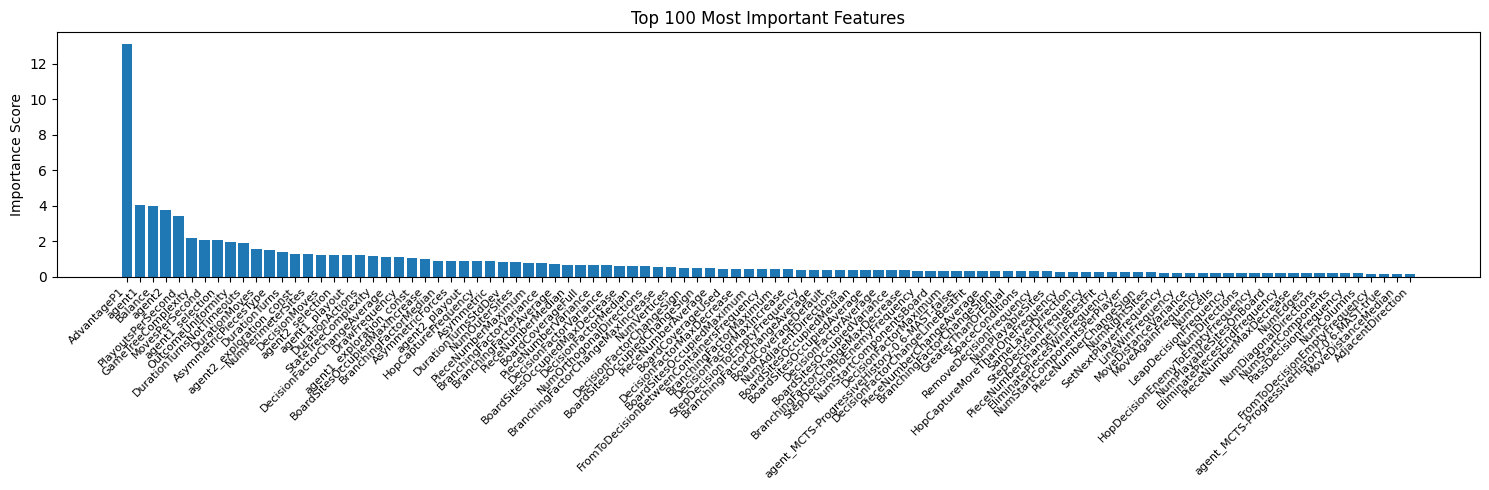

Fold 4 - RMSE: 0.43070953658340294
Fold 5


0:	learn: 0.6350827	test: 0.5484418	best: 0.5484418 (0)	total: 83.5ms	remaining: 13m 54s


50:	learn: 0.4965866	test: 0.5072031	best: 0.5072031 (50)	total: 5.46s	remaining: 17m 45s


100:	learn: 0.4496510	test: 0.4841151	best: 0.4841151 (100)	total: 11s	remaining: 17m 58s


150:	learn: 0.4242829	test: 0.4657027	best: 0.4657027 (150)	total: 16.7s	remaining: 18m 11s


200:	learn: 0.4079709	test: 0.4530484	best: 0.4530484 (200)	total: 22.8s	remaining: 18m 30s


250:	learn: 0.3960308	test: 0.4456307	best: 0.4456307 (250)	total: 28.9s	remaining: 18m 40s


300:	learn: 0.3850852	test: 0.4387150	best: 0.4387150 (300)	total: 35s	remaining: 18m 46s


350:	learn: 0.3759232	test: 0.4337405	best: 0.4337405 (350)	total: 41s	remaining: 18m 46s


400:	learn: 0.3685451	test: 0.4297727	best: 0.4297727 (400)	total: 47.1s	remaining: 18m 47s


450:	learn: 0.3619602	test: 0.4268761	best: 0.4268761 (450)	total: 53.3s	remaining: 18m 47s


500:	learn: 0.3560499	test: 0.4241347	best: 0.4241347 (500)	total: 59.3s	remaining: 18m 43s


550:	learn: 0.3500242	test: 0.4218839	best: 0.4218839 (550)	total: 1m 5s	remaining: 18m 37s


600:	learn: 0.3446275	test: 0.4196957	best: 0.4196957 (600)	total: 1m 11s	remaining: 18m 32s


650:	learn: 0.3398568	test: 0.4179231	best: 0.4179231 (650)	total: 1m 17s	remaining: 18m 25s


700:	learn: 0.3357319	test: 0.4163749	best: 0.4163749 (700)	total: 1m 22s	remaining: 18m 19s


750:	learn: 0.3316880	test: 0.4149533	best: 0.4149533 (750)	total: 1m 28s	remaining: 18m 14s


800:	learn: 0.3279926	test: 0.4139121	best: 0.4139121 (800)	total: 1m 34s	remaining: 18m 9s


850:	learn: 0.3246206	test: 0.4128232	best: 0.4128232 (850)	total: 1m 40s	remaining: 18m 2s


900:	learn: 0.3213581	test: 0.4119236	best: 0.4119236 (900)	total: 1m 46s	remaining: 17m 56s


950:	learn: 0.3180891	test: 0.4107155	best: 0.4107155 (950)	total: 1m 52s	remaining: 17m 50s


1000:	learn: 0.3153484	test: 0.4098905	best: 0.4098905 (1000)	total: 1m 58s	remaining: 17m 45s


1050:	learn: 0.3126118	test: 0.4091889	best: 0.4091889 (1050)	total: 2m 4s	remaining: 17m 40s


1100:	learn: 0.3100721	test: 0.4084852	best: 0.4084852 (1100)	total: 2m 10s	remaining: 17m 32s


1150:	learn: 0.3073745	test: 0.4077310	best: 0.4077310 (1150)	total: 2m 16s	remaining: 17m 28s


1200:	learn: 0.3048917	test: 0.4071371	best: 0.4071302 (1199)	total: 2m 22s	remaining: 17m 22s


1250:	learn: 0.3027136	test: 0.4064516	best: 0.4064424 (1249)	total: 2m 28s	remaining: 17m 16s


1300:	learn: 0.3004334	test: 0.4059653	best: 0.4059653 (1300)	total: 2m 34s	remaining: 17m 10s


1350:	learn: 0.2981756	test: 0.4053901	best: 0.4053895 (1349)	total: 2m 39s	remaining: 17m 4s


1400:	learn: 0.2961426	test: 0.4049924	best: 0.4049924 (1400)	total: 2m 45s	remaining: 16m 58s


1450:	learn: 0.2942766	test: 0.4046408	best: 0.4046408 (1450)	total: 2m 51s	remaining: 16m 53s


1500:	learn: 0.2923974	test: 0.4041680	best: 0.4041680 (1500)	total: 2m 57s	remaining: 16m 47s


1550:	learn: 0.2907903	test: 0.4038620	best: 0.4038612 (1549)	total: 3m 3s	remaining: 16m 41s


1600:	learn: 0.2891092	test: 0.4036091	best: 0.4036091 (1600)	total: 3m 9s	remaining: 16m 35s


1650:	learn: 0.2873927	test: 0.4033408	best: 0.4033408 (1650)	total: 3m 15s	remaining: 16m 30s


1700:	learn: 0.2857779	test: 0.4028953	best: 0.4028953 (1700)	total: 3m 21s	remaining: 16m 24s


1750:	learn: 0.2840860	test: 0.4024650	best: 0.4024614 (1747)	total: 3m 27s	remaining: 16m 18s


1800:	learn: 0.2824601	test: 0.4022560	best: 0.4022560 (1800)	total: 3m 33s	remaining: 16m 12s


1850:	learn: 0.2808840	test: 0.4020348	best: 0.4020271 (1843)	total: 3m 39s	remaining: 16m 7s


1900:	learn: 0.2795482	test: 0.4017678	best: 0.4017678 (1900)	total: 3m 45s	remaining: 16m 1s


1950:	learn: 0.2780473	test: 0.4014947	best: 0.4014943 (1949)	total: 3m 51s	remaining: 15m 55s


2000:	learn: 0.2766751	test: 0.4011499	best: 0.4011478 (1999)	total: 3m 57s	remaining: 15m 50s


2050:	learn: 0.2751712	test: 0.4009211	best: 0.4009211 (2050)	total: 4m 3s	remaining: 15m 44s


2100:	learn: 0.2739412	test: 0.4008068	best: 0.4008068 (2100)	total: 4m 9s	remaining: 15m 38s


2150:	learn: 0.2724918	test: 0.4005897	best: 0.4005897 (2150)	total: 4m 15s	remaining: 15m 33s


2200:	learn: 0.2711955	test: 0.4003604	best: 0.4003585 (2198)	total: 4m 21s	remaining: 15m 27s


2250:	learn: 0.2699395	test: 0.4000936	best: 0.4000881 (2247)	total: 4m 27s	remaining: 15m 21s


2300:	learn: 0.2686572	test: 0.3998340	best: 0.3998340 (2300)	total: 4m 33s	remaining: 15m 15s


2350:	learn: 0.2674817	test: 0.3996287	best: 0.3996287 (2350)	total: 4m 39s	remaining: 15m 9s


2400:	learn: 0.2663441	test: 0.3994569	best: 0.3994522 (2399)	total: 4m 45s	remaining: 15m 4s


2450:	learn: 0.2652466	test: 0.3992521	best: 0.3992517 (2449)	total: 4m 51s	remaining: 14m 58s


2500:	learn: 0.2642229	test: 0.3990458	best: 0.3990458 (2500)	total: 4m 57s	remaining: 14m 53s


2550:	learn: 0.2631497	test: 0.3989686	best: 0.3989671 (2549)	total: 5m 3s	remaining: 14m 47s


2600:	learn: 0.2621754	test: 0.3988251	best: 0.3988185 (2594)	total: 5m 10s	remaining: 14m 42s


2650:	learn: 0.2611915	test: 0.3987241	best: 0.3987241 (2650)	total: 5m 16s	remaining: 14m 36s


2700:	learn: 0.2602032	test: 0.3985248	best: 0.3985248 (2700)	total: 5m 22s	remaining: 14m 31s


2750:	learn: 0.2592652	test: 0.3984359	best: 0.3984359 (2750)	total: 5m 28s	remaining: 14m 25s


2800:	learn: 0.2583494	test: 0.3983552	best: 0.3983552 (2800)	total: 5m 34s	remaining: 14m 20s


2850:	learn: 0.2574914	test: 0.3982430	best: 0.3982422 (2844)	total: 5m 40s	remaining: 14m 14s


2900:	learn: 0.2566397	test: 0.3981688	best: 0.3981688 (2900)	total: 5m 47s	remaining: 14m 9s


2950:	learn: 0.2556652	test: 0.3980191	best: 0.3980191 (2950)	total: 5m 53s	remaining: 14m 3s


3000:	learn: 0.2548276	test: 0.3978605	best: 0.3978605 (3000)	total: 5m 59s	remaining: 13m 57s


3050:	learn: 0.2538763	test: 0.3977371	best: 0.3977364 (3049)	total: 6m 5s	remaining: 13m 52s


3100:	learn: 0.2530016	test: 0.3976279	best: 0.3976279 (3100)	total: 6m 11s	remaining: 13m 46s


3150:	learn: 0.2521765	test: 0.3975317	best: 0.3975090 (3143)	total: 6m 17s	remaining: 13m 40s


3200:	learn: 0.2514013	test: 0.3974247	best: 0.3974189 (3198)	total: 6m 23s	remaining: 13m 35s


3250:	learn: 0.2505451	test: 0.3973133	best: 0.3973133 (3250)	total: 6m 29s	remaining: 13m 29s


3300:	learn: 0.2497913	test: 0.3972381	best: 0.3972370 (3298)	total: 6m 36s	remaining: 13m 23s


3350:	learn: 0.2489905	test: 0.3971406	best: 0.3971406 (3350)	total: 6m 42s	remaining: 13m 18s


3400:	learn: 0.2481503	test: 0.3970327	best: 0.3970268 (3399)	total: 6m 48s	remaining: 13m 12s


3450:	learn: 0.2473421	test: 0.3969762	best: 0.3969699 (3447)	total: 6m 54s	remaining: 13m 6s


3500:	learn: 0.2465430	test: 0.3968573	best: 0.3968538 (3492)	total: 7m	remaining: 13m


3550:	learn: 0.2457806	test: 0.3967385	best: 0.3967326 (3546)	total: 7m 6s	remaining: 12m 54s


3600:	learn: 0.2450332	test: 0.3966688	best: 0.3966688 (3600)	total: 7m 12s	remaining: 12m 49s


3650:	learn: 0.2443107	test: 0.3966023	best: 0.3966023 (3650)	total: 7m 18s	remaining: 12m 43s


3700:	learn: 0.2435926	test: 0.3965291	best: 0.3965275 (3686)	total: 7m 24s	remaining: 12m 37s


3750:	learn: 0.2428703	test: 0.3964037	best: 0.3964014 (3746)	total: 7m 31s	remaining: 12m 31s


3800:	learn: 0.2421577	test: 0.3962522	best: 0.3962522 (3800)	total: 7m 37s	remaining: 12m 25s


3850:	learn: 0.2414642	test: 0.3961774	best: 0.3961774 (3850)	total: 7m 43s	remaining: 12m 19s


3900:	learn: 0.2408279	test: 0.3961181	best: 0.3961181 (3900)	total: 7m 49s	remaining: 12m 13s


3950:	learn: 0.2400953	test: 0.3960543	best: 0.3960486 (3944)	total: 7m 55s	remaining: 12m 7s


4000:	learn: 0.2394023	test: 0.3960057	best: 0.3960041 (3995)	total: 8m 1s	remaining: 12m 2s


4050:	learn: 0.2387707	test: 0.3959575	best: 0.3959521 (4049)	total: 8m 7s	remaining: 11m 56s


4100:	learn: 0.2381529	test: 0.3958822	best: 0.3958822 (4100)	total: 8m 13s	remaining: 11m 50s


4150:	learn: 0.2375316	test: 0.3958327	best: 0.3958327 (4150)	total: 8m 19s	remaining: 11m 44s


4200:	learn: 0.2368558	test: 0.3957476	best: 0.3957476 (4200)	total: 8m 26s	remaining: 11m 38s


4250:	learn: 0.2362375	test: 0.3956499	best: 0.3956499 (4250)	total: 8m 32s	remaining: 11m 32s


4300:	learn: 0.2355986	test: 0.3955595	best: 0.3955595 (4300)	total: 8m 38s	remaining: 11m 26s


4350:	learn: 0.2349784	test: 0.3955172	best: 0.3955120 (4342)	total: 8m 44s	remaining: 11m 20s


4400:	learn: 0.2343809	test: 0.3954840	best: 0.3954824 (4394)	total: 8m 50s	remaining: 11m 14s


4450:	learn: 0.2338177	test: 0.3954684	best: 0.3954642 (4447)	total: 8m 56s	remaining: 11m 8s


4500:	learn: 0.2332070	test: 0.3954495	best: 0.3954495 (4500)	total: 9m 2s	remaining: 11m 2s


4550:	learn: 0.2326357	test: 0.3954024	best: 0.3954008 (4548)	total: 9m 8s	remaining: 10m 56s


4600:	learn: 0.2320497	test: 0.3953579	best: 0.3953467 (4586)	total: 9m 14s	remaining: 10m 50s


4650:	learn: 0.2314903	test: 0.3953369	best: 0.3953284 (4645)	total: 9m 20s	remaining: 10m 45s


4700:	learn: 0.2309188	test: 0.3952615	best: 0.3952615 (4700)	total: 9m 26s	remaining: 10m 38s


4750:	learn: 0.2303619	test: 0.3951960	best: 0.3951906 (4747)	total: 9m 32s	remaining: 10m 33s


4800:	learn: 0.2298106	test: 0.3951426	best: 0.3951426 (4800)	total: 9m 39s	remaining: 10m 27s


4850:	learn: 0.2292717	test: 0.3951398	best: 0.3951322 (4810)	total: 9m 45s	remaining: 10m 21s


4900:	learn: 0.2287152	test: 0.3950638	best: 0.3950638 (4900)	total: 9m 51s	remaining: 10m 15s


4950:	learn: 0.2281525	test: 0.3950414	best: 0.3950414 (4950)	total: 9m 57s	remaining: 10m 9s


5000:	learn: 0.2275668	test: 0.3949947	best: 0.3949947 (5000)	total: 10m 3s	remaining: 10m 3s


5050:	learn: 0.2270424	test: 0.3949395	best: 0.3949395 (5050)	total: 10m 9s	remaining: 9m 57s


5100:	learn: 0.2264650	test: 0.3948793	best: 0.3948793 (5100)	total: 10m 15s	remaining: 9m 51s


5150:	learn: 0.2259503	test: 0.3948372	best: 0.3948281 (5142)	total: 10m 21s	remaining: 9m 45s


5200:	learn: 0.2254352	test: 0.3948233	best: 0.3948050 (5190)	total: 10m 27s	remaining: 9m 39s


5250:	learn: 0.2249452	test: 0.3947626	best: 0.3947588 (5245)	total: 10m 33s	remaining: 9m 33s


5300:	learn: 0.2244053	test: 0.3947365	best: 0.3947253 (5293)	total: 10m 39s	remaining: 9m 27s


5350:	learn: 0.2238431	test: 0.3946788	best: 0.3946768 (5348)	total: 10m 45s	remaining: 9m 21s


5400:	learn: 0.2233338	test: 0.3946527	best: 0.3946446 (5397)	total: 10m 51s	remaining: 9m 14s


5450:	learn: 0.2228199	test: 0.3946140	best: 0.3946087 (5444)	total: 10m 57s	remaining: 9m 8s


5500:	learn: 0.2223381	test: 0.3945749	best: 0.3945749 (5500)	total: 11m 3s	remaining: 9m 2s


5550:	learn: 0.2218692	test: 0.3945677	best: 0.3945476 (5523)	total: 11m 9s	remaining: 8m 56s


5600:	learn: 0.2213832	test: 0.3945013	best: 0.3944999 (5598)	total: 11m 15s	remaining: 8m 50s


5650:	learn: 0.2209035	test: 0.3944414	best: 0.3944405 (5649)	total: 11m 21s	remaining: 8m 44s


5700:	learn: 0.2203708	test: 0.3944203	best: 0.3944203 (5700)	total: 11m 27s	remaining: 8m 38s


5750:	learn: 0.2199023	test: 0.3944058	best: 0.3944038 (5749)	total: 11m 33s	remaining: 8m 32s


5800:	learn: 0.2194101	test: 0.3943563	best: 0.3943563 (5800)	total: 11m 39s	remaining: 8m 26s


5850:	learn: 0.2189599	test: 0.3943217	best: 0.3943183 (5847)	total: 11m 45s	remaining: 8m 20s


5900:	learn: 0.2184775	test: 0.3942608	best: 0.3942608 (5900)	total: 11m 52s	remaining: 8m 14s


5950:	learn: 0.2180220	test: 0.3942495	best: 0.3942495 (5949)	total: 11m 57s	remaining: 8m 8s


6000:	learn: 0.2175473	test: 0.3942264	best: 0.3942188 (5982)	total: 12m 3s	remaining: 8m 2s


6050:	learn: 0.2170837	test: 0.3942056	best: 0.3942018 (6028)	total: 12m 10s	remaining: 7m 56s


6100:	learn: 0.2166393	test: 0.3942201	best: 0.3942018 (6028)	total: 12m 16s	remaining: 7m 50s


6150:	learn: 0.2162293	test: 0.3941969	best: 0.3941969 (6150)	total: 12m 22s	remaining: 7m 44s


6200:	learn: 0.2158273	test: 0.3941612	best: 0.3941612 (6200)	total: 12m 28s	remaining: 7m 38s


6250:	learn: 0.2153795	test: 0.3941530	best: 0.3941466 (6246)	total: 12m 34s	remaining: 7m 32s


6300:	learn: 0.2149423	test: 0.3941289	best: 0.3941289 (6300)	total: 12m 40s	remaining: 7m 26s


6350:	learn: 0.2145150	test: 0.3941408	best: 0.3941289 (6300)	total: 12m 46s	remaining: 7m 20s


6400:	learn: 0.2140757	test: 0.3941035	best: 0.3940980 (6396)	total: 12m 52s	remaining: 7m 14s


6450:	learn: 0.2136287	test: 0.3940847	best: 0.3940789 (6448)	total: 12m 58s	remaining: 7m 8s


6500:	learn: 0.2132152	test: 0.3940558	best: 0.3940558 (6500)	total: 13m 4s	remaining: 7m 2s


6550:	learn: 0.2127831	test: 0.3940387	best: 0.3940267 (6531)	total: 13m 10s	remaining: 6m 56s


6600:	learn: 0.2123389	test: 0.3940263	best: 0.3940202 (6590)	total: 13m 16s	remaining: 6m 50s


6650:	learn: 0.2119568	test: 0.3939996	best: 0.3939996 (6650)	total: 13m 22s	remaining: 6m 44s


6700:	learn: 0.2115417	test: 0.3939866	best: 0.3939854 (6686)	total: 13m 28s	remaining: 6m 38s


6750:	learn: 0.2111382	test: 0.3939699	best: 0.3939659 (6739)	total: 13m 34s	remaining: 6m 32s


6800:	learn: 0.2107174	test: 0.3939757	best: 0.3939659 (6739)	total: 13m 40s	remaining: 6m 26s


6850:	learn: 0.2103315	test: 0.3939654	best: 0.3939578 (6841)	total: 13m 46s	remaining: 6m 20s


6900:	learn: 0.2099648	test: 0.3939629	best: 0.3939578 (6841)	total: 13m 52s	remaining: 6m 13s


6950:	learn: 0.2095343	test: 0.3939370	best: 0.3939337 (6947)	total: 13m 58s	remaining: 6m 7s


7000:	learn: 0.2091631	test: 0.3939451	best: 0.3939337 (6947)	total: 14m 4s	remaining: 6m 1s


7050:	learn: 0.2087642	test: 0.3938960	best: 0.3938960 (7050)	total: 14m 10s	remaining: 5m 55s


7100:	learn: 0.2083953	test: 0.3938682	best: 0.3938682 (7100)	total: 14m 16s	remaining: 5m 49s


7150:	learn: 0.2080015	test: 0.3938551	best: 0.3938505 (7147)	total: 14m 22s	remaining: 5m 43s


7200:	learn: 0.2075944	test: 0.3938235	best: 0.3938220 (7197)	total: 14m 28s	remaining: 5m 37s


7250:	learn: 0.2071762	test: 0.3937811	best: 0.3937793 (7248)	total: 14m 34s	remaining: 5m 31s


7300:	learn: 0.2067775	test: 0.3937512	best: 0.3937508 (7298)	total: 14m 40s	remaining: 5m 25s


7350:	learn: 0.2063929	test: 0.3937186	best: 0.3937164 (7348)	total: 14m 46s	remaining: 5m 19s


7400:	learn: 0.2060082	test: 0.3936950	best: 0.3936950 (7400)	total: 14m 52s	remaining: 5m 13s


7450:	learn: 0.2056508	test: 0.3936918	best: 0.3936848 (7421)	total: 14m 59s	remaining: 5m 7s


7500:	learn: 0.2052165	test: 0.3936384	best: 0.3936384 (7500)	total: 15m 5s	remaining: 5m 1s


7550:	learn: 0.2048441	test: 0.3936402	best: 0.3936359 (7526)	total: 15m 11s	remaining: 4m 55s


7600:	learn: 0.2044452	test: 0.3936260	best: 0.3936227 (7596)	total: 15m 17s	remaining: 4m 49s


7650:	learn: 0.2041009	test: 0.3936127	best: 0.3936017 (7636)	total: 15m 23s	remaining: 4m 43s


7700:	learn: 0.2037530	test: 0.3936045	best: 0.3935983 (7693)	total: 15m 29s	remaining: 4m 37s


7750:	learn: 0.2033764	test: 0.3935821	best: 0.3935821 (7750)	total: 15m 35s	remaining: 4m 31s


7800:	learn: 0.2030181	test: 0.3935440	best: 0.3935440 (7800)	total: 15m 41s	remaining: 4m 25s


7850:	learn: 0.2026388	test: 0.3935221	best: 0.3935185 (7819)	total: 15m 47s	remaining: 4m 19s


7900:	learn: 0.2022895	test: 0.3935175	best: 0.3935134 (7895)	total: 15m 53s	remaining: 4m 13s


7950:	learn: 0.2019253	test: 0.3934802	best: 0.3934802 (7950)	total: 15m 59s	remaining: 4m 7s


8000:	learn: 0.2015487	test: 0.3934712	best: 0.3934680 (7993)	total: 16m 5s	remaining: 4m 1s


8050:	learn: 0.2012188	test: 0.3934575	best: 0.3934545 (8044)	total: 16m 11s	remaining: 3m 55s


8100:	learn: 0.2008638	test: 0.3934279	best: 0.3934244 (8097)	total: 16m 17s	remaining: 3m 49s


8150:	learn: 0.2004987	test: 0.3934341	best: 0.3934238 (8104)	total: 16m 23s	remaining: 3m 43s


8200:	learn: 0.2001496	test: 0.3934255	best: 0.3934238 (8104)	total: 16m 29s	remaining: 3m 37s


8250:	learn: 0.1997946	test: 0.3933936	best: 0.3933936 (8250)	total: 16m 35s	remaining: 3m 31s


8300:	learn: 0.1994669	test: 0.3933579	best: 0.3933568 (8299)	total: 16m 42s	remaining: 3m 25s


8350:	learn: 0.1991189	test: 0.3933413	best: 0.3933390 (8349)	total: 16m 48s	remaining: 3m 19s


8400:	learn: 0.1987755	test: 0.3933254	best: 0.3933254 (8400)	total: 16m 54s	remaining: 3m 13s


8450:	learn: 0.1984351	test: 0.3932987	best: 0.3932978 (8441)	total: 17m	remaining: 3m 7s


8500:	learn: 0.1981042	test: 0.3932857	best: 0.3932791 (8476)	total: 17m 6s	remaining: 3m


8550:	learn: 0.1977550	test: 0.3932778	best: 0.3932753 (8545)	total: 17m 12s	remaining: 2m 54s


8600:	learn: 0.1974097	test: 0.3932619	best: 0.3932611 (8599)	total: 17m 18s	remaining: 2m 48s


8650:	learn: 0.1970757	test: 0.3932532	best: 0.3932486 (8637)	total: 17m 24s	remaining: 2m 42s


8700:	learn: 0.1967637	test: 0.3932516	best: 0.3932480 (8689)	total: 17m 30s	remaining: 2m 36s


8750:	learn: 0.1964393	test: 0.3932622	best: 0.3932480 (8689)	total: 17m 36s	remaining: 2m 30s


8800:	learn: 0.1961140	test: 0.3932578	best: 0.3932480 (8689)	total: 17m 42s	remaining: 2m 24s


8850:	learn: 0.1958154	test: 0.3932525	best: 0.3932431 (8831)	total: 17m 48s	remaining: 2m 18s


8900:	learn: 0.1954818	test: 0.3932402	best: 0.3932361 (8890)	total: 17m 54s	remaining: 2m 12s


8950:	learn: 0.1951672	test: 0.3932507	best: 0.3932341 (8927)	total: 18m	remaining: 2m 6s


9000:	learn: 0.1948442	test: 0.3932497	best: 0.3932341 (8927)	total: 18m 6s	remaining: 2m


9050:	learn: 0.1945137	test: 0.3932520	best: 0.3932341 (8927)	total: 18m 12s	remaining: 1m 54s


9100:	learn: 0.1942010	test: 0.3932503	best: 0.3932341 (8927)	total: 18m 18s	remaining: 1m 48s


9150:	learn: 0.1938854	test: 0.3932326	best: 0.3932321 (9149)	total: 18m 24s	remaining: 1m 42s


9200:	learn: 0.1935569	test: 0.3932310	best: 0.3932212 (9166)	total: 18m 30s	remaining: 1m 36s


9250:	learn: 0.1932714	test: 0.3932282	best: 0.3932212 (9166)	total: 18m 37s	remaining: 1m 30s


9300:	learn: 0.1929752	test: 0.3932317	best: 0.3932212 (9166)	total: 18m 43s	remaining: 1m 24s


9350:	learn: 0.1926615	test: 0.3932002	best: 0.3931981 (9346)	total: 18m 49s	remaining: 1m 18s


9400:	learn: 0.1923565	test: 0.3932089	best: 0.3931981 (9346)	total: 18m 55s	remaining: 1m 12s


9450:	learn: 0.1920254	test: 0.3932212	best: 0.3931981 (9346)	total: 19m 1s	remaining: 1m 6s


9500:	learn: 0.1917284	test: 0.3932187	best: 0.3931981 (9346)	total: 19m 7s	remaining: 1m


9550:	learn: 0.1914217	test: 0.3931995	best: 0.3931981 (9346)	total: 19m 13s	remaining: 54.2s


9600:	learn: 0.1911043	test: 0.3931776	best: 0.3931767 (9599)	total: 19m 19s	remaining: 48.2s


9650:	learn: 0.1907640	test: 0.3931756	best: 0.3931675 (9647)	total: 19m 25s	remaining: 42.1s


9700:	learn: 0.1904689	test: 0.3931744	best: 0.3931675 (9647)	total: 19m 31s	remaining: 36.1s


9750:	learn: 0.1901608	test: 0.3931697	best: 0.3931611 (9741)	total: 19m 37s	remaining: 30.1s


9800:	learn: 0.1898464	test: 0.3931650	best: 0.3931591 (9790)	total: 19m 43s	remaining: 24s


9850:	learn: 0.1895505	test: 0.3931583	best: 0.3931569 (9847)	total: 19m 49s	remaining: 18s


9900:	learn: 0.1892480	test: 0.3931363	best: 0.3931332 (9893)	total: 19m 55s	remaining: 12s


9950:	learn: 0.1889634	test: 0.3931297	best: 0.3931204 (9917)	total: 20m 1s	remaining: 5.92s


9999:	learn: 0.1886835	test: 0.3931213	best: 0.3931204 (9917)	total: 20m 7s	remaining: 0us

bestTest = 0.3931203637
bestIteration = 9917

Shrink model to first 9918 iterations.


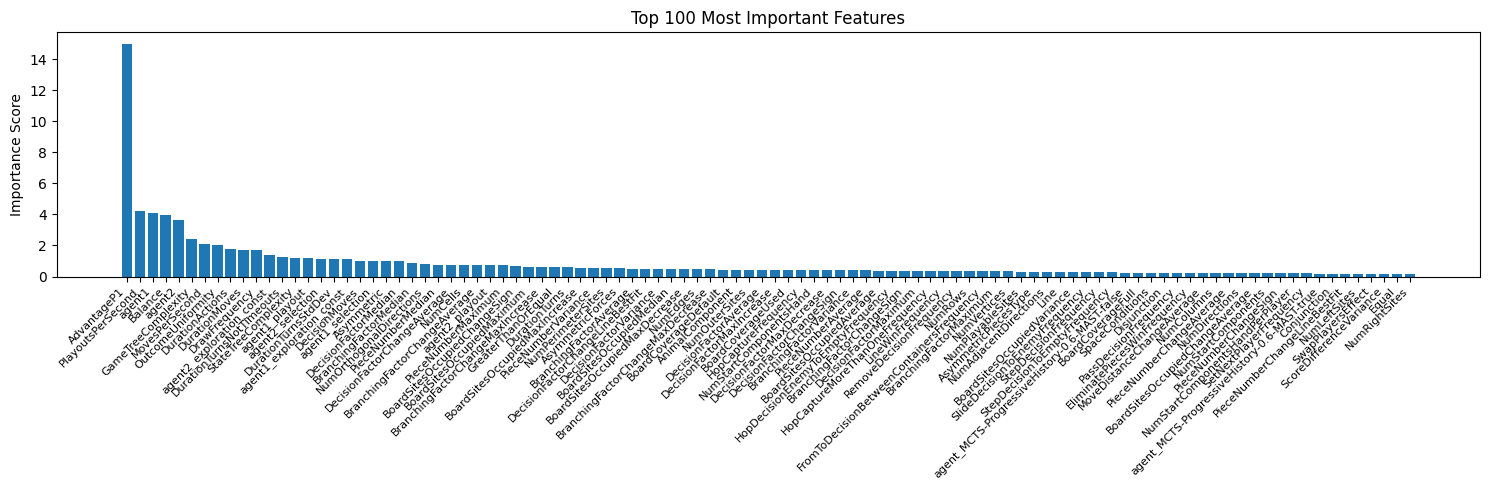

Fold 5 - RMSE: 0.3927419801293907
List of oof scores: [0.41241913543703884, 0.43737478386651546, 0.4233689980314701, 0.43070953658340294, 0.3927419801293907]
Average oof score: 0.4193228868095636


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6367618	test: 0.5361634	best: 0.5361634 (0)	total: 85.6ms	remaining: 14m 16s


50:	learn: 0.4959568	test: 0.4959049	best: 0.4959049 (50)	total: 5.5s	remaining: 17m 53s


100:	learn: 0.4482651	test: 0.4762883	best: 0.4762883 (100)	total: 11s	remaining: 18m


150:	learn: 0.4212084	test: 0.4640364	best: 0.4640364 (150)	total: 16.6s	remaining: 18m 4s


200:	learn: 0.4050948	test: 0.4551897	best: 0.4551897 (200)	total: 22.7s	remaining: 18m 27s


250:	learn: 0.3922831	test: 0.4490541	best: 0.4490541 (250)	total: 28.8s	remaining: 18m 36s


300:	learn: 0.3815227	test: 0.4443137	best: 0.4443137 (300)	total: 35s	remaining: 18m 47s


350:	learn: 0.3727252	test: 0.4408355	best: 0.4408355 (350)	total: 41s	remaining: 18m 48s


400:	learn: 0.3651506	test: 0.4379234	best: 0.4379234 (400)	total: 47.2s	remaining: 18m 49s


450:	learn: 0.3579704	test: 0.4353258	best: 0.4353258 (450)	total: 53.2s	remaining: 18m 46s


500:	learn: 0.3516472	test: 0.4330408	best: 0.4330312 (499)	total: 59.3s	remaining: 18m 44s


550:	learn: 0.3454851	test: 0.4307620	best: 0.4307620 (550)	total: 1m 5s	remaining: 18m 38s


600:	learn: 0.3397129	test: 0.4290914	best: 0.4290914 (600)	total: 1m 11s	remaining: 18m 32s


650:	learn: 0.3349631	test: 0.4276022	best: 0.4276022 (650)	total: 1m 17s	remaining: 18m 27s


700:	learn: 0.3300260	test: 0.4262735	best: 0.4262735 (700)	total: 1m 22s	remaining: 18m 20s


750:	learn: 0.3255419	test: 0.4249282	best: 0.4249282 (750)	total: 1m 28s	remaining: 18m 13s


800:	learn: 0.3218947	test: 0.4239062	best: 0.4239060 (799)	total: 1m 34s	remaining: 18m 8s


850:	learn: 0.3185169	test: 0.4227796	best: 0.4227796 (850)	total: 1m 40s	remaining: 18m 3s


900:	learn: 0.3151208	test: 0.4215824	best: 0.4215824 (900)	total: 1m 46s	remaining: 17m 57s


950:	learn: 0.3120464	test: 0.4209049	best: 0.4208965 (949)	total: 1m 52s	remaining: 17m 53s


1000:	learn: 0.3092439	test: 0.4201717	best: 0.4201717 (1000)	total: 1m 58s	remaining: 17m 47s


1050:	learn: 0.3067160	test: 0.4196058	best: 0.4195834 (1048)	total: 2m 4s	remaining: 17m 41s


1100:	learn: 0.3041663	test: 0.4189369	best: 0.4189369 (1100)	total: 2m 10s	remaining: 17m 36s


1150:	learn: 0.3017138	test: 0.4185238	best: 0.4185196 (1148)	total: 2m 16s	remaining: 17m 30s


1200:	learn: 0.2995356	test: 0.4180038	best: 0.4179990 (1199)	total: 2m 22s	remaining: 17m 25s


1250:	learn: 0.2971865	test: 0.4176892	best: 0.4176892 (1250)	total: 2m 28s	remaining: 17m 19s


1300:	learn: 0.2951449	test: 0.4171741	best: 0.4171740 (1299)	total: 2m 34s	remaining: 17m 13s


1350:	learn: 0.2931537	test: 0.4166462	best: 0.4166462 (1350)	total: 2m 40s	remaining: 17m 7s


1400:	learn: 0.2913528	test: 0.4163463	best: 0.4163463 (1400)	total: 2m 46s	remaining: 17m 1s


1450:	learn: 0.2894676	test: 0.4159918	best: 0.4159846 (1448)	total: 2m 52s	remaining: 16m 55s


1500:	learn: 0.2876874	test: 0.4157489	best: 0.4157472 (1499)	total: 2m 58s	remaining: 16m 50s


1550:	learn: 0.2858560	test: 0.4153295	best: 0.4153235 (1549)	total: 3m 4s	remaining: 16m 44s


1600:	learn: 0.2840849	test: 0.4148352	best: 0.4148352 (1600)	total: 3m 10s	remaining: 16m 38s


1650:	learn: 0.2824745	test: 0.4144712	best: 0.4144705 (1649)	total: 3m 16s	remaining: 16m 33s


1700:	learn: 0.2809007	test: 0.4143088	best: 0.4143013 (1696)	total: 3m 22s	remaining: 16m 27s


1750:	learn: 0.2792979	test: 0.4140930	best: 0.4140930 (1750)	total: 3m 28s	remaining: 16m 21s


1800:	learn: 0.2778458	test: 0.4139512	best: 0.4139453 (1798)	total: 3m 34s	remaining: 16m 15s


1850:	learn: 0.2763102	test: 0.4137391	best: 0.4137388 (1849)	total: 3m 40s	remaining: 16m 9s


1900:	learn: 0.2747951	test: 0.4134729	best: 0.4134717 (1899)	total: 3m 46s	remaining: 16m 3s


1950:	learn: 0.2733132	test: 0.4132452	best: 0.4132359 (1944)	total: 3m 52s	remaining: 15m 57s


2000:	learn: 0.2718454	test: 0.4130408	best: 0.4130407 (1999)	total: 3m 58s	remaining: 15m 51s


2050:	learn: 0.2705577	test: 0.4128334	best: 0.4128331 (2049)	total: 4m 4s	remaining: 15m 45s


2100:	learn: 0.2692446	test: 0.4125218	best: 0.4125218 (2100)	total: 4m 9s	remaining: 15m 39s


2150:	learn: 0.2679463	test: 0.4124709	best: 0.4124709 (2150)	total: 4m 15s	remaining: 15m 33s


2200:	learn: 0.2666521	test: 0.4123161	best: 0.4123150 (2199)	total: 4m 21s	remaining: 15m 27s


2250:	learn: 0.2654101	test: 0.4121000	best: 0.4121000 (2250)	total: 4m 27s	remaining: 15m 22s


2300:	learn: 0.2642355	test: 0.4119122	best: 0.4119088 (2299)	total: 4m 33s	remaining: 15m 16s


2350:	learn: 0.2631640	test: 0.4116599	best: 0.4116539 (2341)	total: 4m 39s	remaining: 15m 10s


2400:	learn: 0.2619693	test: 0.4114372	best: 0.4114372 (2400)	total: 4m 45s	remaining: 15m 4s


2450:	learn: 0.2609246	test: 0.4112614	best: 0.4112606 (2449)	total: 4m 51s	remaining: 14m 59s


2500:	learn: 0.2598015	test: 0.4111846	best: 0.4111846 (2500)	total: 4m 57s	remaining: 14m 53s


2550:	learn: 0.2587528	test: 0.4110348	best: 0.4110348 (2550)	total: 5m 3s	remaining: 14m 47s


2600:	learn: 0.2577406	test: 0.4108630	best: 0.4108630 (2600)	total: 5m 9s	remaining: 14m 41s


2650:	learn: 0.2566958	test: 0.4107604	best: 0.4107480 (2646)	total: 5m 15s	remaining: 14m 35s


2700:	learn: 0.2556750	test: 0.4106653	best: 0.4106653 (2700)	total: 5m 21s	remaining: 14m 29s


2750:	learn: 0.2546246	test: 0.4105285	best: 0.4105279 (2740)	total: 5m 27s	remaining: 14m 23s


2800:	learn: 0.2537236	test: 0.4104499	best: 0.4104442 (2794)	total: 5m 33s	remaining: 14m 17s


2850:	learn: 0.2527238	test: 0.4102908	best: 0.4102898 (2849)	total: 5m 39s	remaining: 14m 11s


2900:	learn: 0.2518482	test: 0.4102072	best: 0.4102072 (2900)	total: 5m 45s	remaining: 14m 6s


2950:	learn: 0.2509245	test: 0.4101004	best: 0.4101004 (2950)	total: 5m 51s	remaining: 14m


3000:	learn: 0.2500318	test: 0.4100060	best: 0.4100060 (3000)	total: 5m 57s	remaining: 13m 54s


3050:	learn: 0.2491780	test: 0.4098924	best: 0.4098924 (3050)	total: 6m 3s	remaining: 13m 47s


3100:	learn: 0.2482878	test: 0.4098169	best: 0.4098040 (3099)	total: 6m 9s	remaining: 13m 42s


3150:	learn: 0.2474334	test: 0.4096961	best: 0.4096961 (3150)	total: 6m 15s	remaining: 13m 36s


3200:	learn: 0.2466098	test: 0.4095951	best: 0.4095946 (3199)	total: 6m 21s	remaining: 13m 30s


3250:	learn: 0.2457634	test: 0.4095461	best: 0.4095416 (3240)	total: 6m 27s	remaining: 13m 24s


3300:	learn: 0.2448978	test: 0.4093772	best: 0.4093708 (3294)	total: 6m 33s	remaining: 13m 18s


3350:	learn: 0.2441068	test: 0.4093022	best: 0.4093022 (3350)	total: 6m 39s	remaining: 13m 12s


3400:	learn: 0.2432829	test: 0.4092013	best: 0.4091955 (3393)	total: 6m 45s	remaining: 13m 6s


3450:	learn: 0.2425303	test: 0.4091500	best: 0.4091370 (3444)	total: 6m 51s	remaining: 13m


3500:	learn: 0.2417673	test: 0.4090840	best: 0.4090840 (3500)	total: 6m 57s	remaining: 12m 54s


3550:	learn: 0.2410803	test: 0.4090140	best: 0.4090118 (3549)	total: 7m 3s	remaining: 12m 48s


3600:	learn: 0.2403016	test: 0.4088684	best: 0.4088684 (3600)	total: 7m 9s	remaining: 12m 43s


3650:	learn: 0.2395693	test: 0.4087821	best: 0.4087785 (3641)	total: 7m 15s	remaining: 12m 37s


3700:	learn: 0.2388067	test: 0.4087080	best: 0.4087073 (3698)	total: 7m 21s	remaining: 12m 31s


3750:	learn: 0.2380791	test: 0.4086265	best: 0.4086194 (3744)	total: 7m 27s	remaining: 12m 25s


3800:	learn: 0.2373010	test: 0.4085499	best: 0.4085499 (3800)	total: 7m 33s	remaining: 12m 19s


3850:	learn: 0.2366030	test: 0.4084697	best: 0.4084697 (3850)	total: 7m 39s	remaining: 12m 13s


3900:	learn: 0.2358630	test: 0.4083819	best: 0.4083816 (3899)	total: 7m 45s	remaining: 12m 7s


3950:	learn: 0.2351663	test: 0.4083554	best: 0.4083554 (3950)	total: 7m 51s	remaining: 12m 1s


4000:	learn: 0.2344651	test: 0.4082916	best: 0.4082886 (3994)	total: 7m 57s	remaining: 11m 55s


4050:	learn: 0.2338120	test: 0.4081779	best: 0.4081779 (4050)	total: 8m 3s	remaining: 11m 50s


4100:	learn: 0.2331546	test: 0.4081164	best: 0.4081142 (4099)	total: 8m 9s	remaining: 11m 44s


4150:	learn: 0.2325641	test: 0.4081140	best: 0.4081016 (4115)	total: 8m 15s	remaining: 11m 38s


4200:	learn: 0.2319023	test: 0.4080960	best: 0.4080918 (4192)	total: 8m 21s	remaining: 11m 32s


4250:	learn: 0.2313089	test: 0.4080593	best: 0.4080593 (4250)	total: 8m 27s	remaining: 11m 26s


4300:	learn: 0.2306867	test: 0.4080177	best: 0.4080145 (4297)	total: 8m 33s	remaining: 11m 21s


4350:	learn: 0.2299891	test: 0.4079499	best: 0.4079405 (4346)	total: 8m 39s	remaining: 11m 15s


4400:	learn: 0.2293730	test: 0.4078816	best: 0.4078810 (4391)	total: 8m 45s	remaining: 11m 9s


4450:	learn: 0.2287320	test: 0.4078157	best: 0.4078157 (4450)	total: 8m 51s	remaining: 11m 3s


4500:	learn: 0.2281530	test: 0.4078044	best: 0.4077963 (4483)	total: 8m 57s	remaining: 10m 57s


4550:	learn: 0.2275448	test: 0.4077760	best: 0.4077748 (4549)	total: 9m 4s	remaining: 10m 51s


4600:	learn: 0.2269139	test: 0.4077369	best: 0.4077332 (4586)	total: 9m 10s	remaining: 10m 45s


4650:	learn: 0.2263271	test: 0.4076925	best: 0.4076925 (4650)	total: 9m 16s	remaining: 10m 39s


4700:	learn: 0.2257001	test: 0.4076438	best: 0.4076438 (4700)	total: 9m 21s	remaining: 10m 33s


4750:	learn: 0.2251587	test: 0.4076055	best: 0.4076055 (4750)	total: 9m 28s	remaining: 10m 27s


4800:	learn: 0.2246030	test: 0.4075381	best: 0.4075381 (4800)	total: 9m 34s	remaining: 10m 21s


4850:	learn: 0.2240555	test: 0.4074812	best: 0.4074769 (4848)	total: 9m 40s	remaining: 10m 15s


4900:	learn: 0.2235385	test: 0.4073994	best: 0.4073994 (4900)	total: 9m 46s	remaining: 10m 9s


4950:	learn: 0.2229739	test: 0.4073316	best: 0.4073231 (4944)	total: 9m 52s	remaining: 10m 4s


5000:	learn: 0.2224264	test: 0.4072601	best: 0.4072601 (5000)	total: 9m 58s	remaining: 9m 58s


5050:	learn: 0.2218927	test: 0.4071926	best: 0.4071926 (5050)	total: 10m 4s	remaining: 9m 52s


5100:	learn: 0.2213917	test: 0.4071761	best: 0.4071761 (5100)	total: 10m 10s	remaining: 9m 46s


5150:	learn: 0.2208799	test: 0.4071084	best: 0.4071081 (5148)	total: 10m 16s	remaining: 9m 40s


5200:	learn: 0.2203429	test: 0.4070587	best: 0.4070587 (5200)	total: 10m 22s	remaining: 9m 34s


5250:	learn: 0.2198047	test: 0.4070395	best: 0.4070324 (5241)	total: 10m 28s	remaining: 9m 28s


5300:	learn: 0.2193394	test: 0.4070112	best: 0.4070042 (5292)	total: 10m 34s	remaining: 9m 22s


5350:	learn: 0.2188776	test: 0.4069832	best: 0.4069821 (5349)	total: 10m 40s	remaining: 9m 16s


5400:	learn: 0.2183969	test: 0.4069392	best: 0.4069392 (5400)	total: 10m 46s	remaining: 9m 10s


5450:	learn: 0.2179158	test: 0.4069097	best: 0.4069072 (5438)	total: 10m 52s	remaining: 9m 4s


5500:	learn: 0.2174669	test: 0.4068744	best: 0.4068706 (5493)	total: 10m 58s	remaining: 8m 58s


5550:	learn: 0.2169966	test: 0.4068584	best: 0.4068575 (5547)	total: 11m 4s	remaining: 8m 52s


5600:	learn: 0.2165525	test: 0.4068560	best: 0.4068471 (5566)	total: 11m 10s	remaining: 8m 46s


5650:	learn: 0.2161134	test: 0.4068503	best: 0.4068471 (5566)	total: 11m 16s	remaining: 8m 40s


5700:	learn: 0.2156177	test: 0.4068504	best: 0.4068471 (5566)	total: 11m 22s	remaining: 8m 34s


5750:	learn: 0.2151683	test: 0.4068308	best: 0.4068276 (5736)	total: 11m 29s	remaining: 8m 29s


5800:	learn: 0.2147063	test: 0.4068007	best: 0.4068007 (5799)	total: 11m 35s	remaining: 8m 23s


5850:	learn: 0.2142499	test: 0.4067890	best: 0.4067832 (5828)	total: 11m 41s	remaining: 8m 17s


5900:	learn: 0.2137657	test: 0.4067494	best: 0.4067494 (5900)	total: 11m 47s	remaining: 8m 11s


5950:	learn: 0.2132906	test: 0.4067151	best: 0.4067142 (5949)	total: 11m 53s	remaining: 8m 5s


6000:	learn: 0.2128548	test: 0.4067009	best: 0.4066996 (5999)	total: 11m 59s	remaining: 7m 59s


6050:	learn: 0.2124185	test: 0.4067155	best: 0.4066996 (5999)	total: 12m 5s	remaining: 7m 53s


6100:	learn: 0.2120070	test: 0.4067031	best: 0.4066996 (5999)	total: 12m 11s	remaining: 7m 47s


6150:	learn: 0.2115591	test: 0.4066369	best: 0.4066369 (6150)	total: 12m 17s	remaining: 7m 41s


6200:	learn: 0.2110964	test: 0.4066258	best: 0.4066110 (6193)	total: 12m 23s	remaining: 7m 35s


6250:	learn: 0.2106619	test: 0.4066216	best: 0.4066020 (6227)	total: 12m 29s	remaining: 7m 29s


6300:	learn: 0.2102317	test: 0.4066225	best: 0.4066020 (6227)	total: 12m 35s	remaining: 7m 23s


6350:	learn: 0.2098018	test: 0.4066039	best: 0.4066014 (6346)	total: 12m 41s	remaining: 7m 17s


6400:	learn: 0.2093598	test: 0.4065608	best: 0.4065576 (6396)	total: 12m 47s	remaining: 7m 11s


6450:	learn: 0.2089451	test: 0.4065205	best: 0.4065205 (6450)	total: 12m 53s	remaining: 7m 5s


6500:	learn: 0.2085539	test: 0.4064940	best: 0.4064929 (6496)	total: 12m 59s	remaining: 6m 59s


6550:	learn: 0.2081546	test: 0.4064805	best: 0.4064631 (6534)	total: 13m 5s	remaining: 6m 53s


6600:	learn: 0.2077698	test: 0.4064696	best: 0.4064631 (6534)	total: 13m 11s	remaining: 6m 47s


6650:	learn: 0.2073171	test: 0.4064260	best: 0.4064175 (6642)	total: 13m 17s	remaining: 6m 41s


6700:	learn: 0.2068920	test: 0.4063963	best: 0.4063963 (6700)	total: 13m 23s	remaining: 6m 35s


6750:	learn: 0.2064904	test: 0.4063584	best: 0.4063574 (6749)	total: 13m 29s	remaining: 6m 29s


6800:	learn: 0.2060772	test: 0.4063343	best: 0.4063332 (6799)	total: 13m 35s	remaining: 6m 23s


6850:	learn: 0.2056693	test: 0.4062794	best: 0.4062794 (6850)	total: 13m 41s	remaining: 6m 17s


6900:	learn: 0.2053125	test: 0.4062275	best: 0.4062272 (6898)	total: 13m 47s	remaining: 6m 11s


6950:	learn: 0.2049432	test: 0.4062213	best: 0.4062101 (6929)	total: 13m 54s	remaining: 6m 5s


7000:	learn: 0.2045548	test: 0.4062063	best: 0.4062014 (6989)	total: 14m	remaining: 5m 59s


7050:	learn: 0.2041751	test: 0.4061813	best: 0.4061772 (7017)	total: 14m 6s	remaining: 5m 53s


7100:	learn: 0.2038322	test: 0.4061604	best: 0.4061601 (7099)	total: 14m 12s	remaining: 5m 47s


7150:	learn: 0.2034227	test: 0.4061310	best: 0.4061205 (7136)	total: 14m 18s	remaining: 5m 41s


7200:	learn: 0.2030340	test: 0.4061246	best: 0.4061205 (7136)	total: 14m 24s	remaining: 5m 35s


7250:	learn: 0.2026611	test: 0.4061018	best: 0.4060985 (7243)	total: 14m 30s	remaining: 5m 29s


7300:	learn: 0.2022834	test: 0.4060854	best: 0.4060828 (7294)	total: 14m 36s	remaining: 5m 23s


7350:	learn: 0.2019353	test: 0.4060837	best: 0.4060784 (7336)	total: 14m 42s	remaining: 5m 17s


7400:	learn: 0.2015400	test: 0.4060572	best: 0.4060561 (7399)	total: 14m 48s	remaining: 5m 11s


7450:	learn: 0.2012088	test: 0.4060529	best: 0.4060505 (7448)	total: 14m 54s	remaining: 5m 5s


7500:	learn: 0.2008355	test: 0.4060291	best: 0.4060276 (7497)	total: 15m	remaining: 4m 59s


7550:	learn: 0.2004512	test: 0.4059677	best: 0.4059614 (7534)	total: 15m 6s	remaining: 4m 53s


7600:	learn: 0.2000673	test: 0.4059423	best: 0.4059423 (7600)	total: 15m 12s	remaining: 4m 47s


7650:	learn: 0.1997539	test: 0.4059463	best: 0.4059403 (7621)	total: 15m 18s	remaining: 4m 41s


7700:	learn: 0.1994090	test: 0.4059151	best: 0.4059151 (7700)	total: 15m 24s	remaining: 4m 36s


7750:	learn: 0.1990966	test: 0.4059065	best: 0.4059065 (7750)	total: 15m 30s	remaining: 4m 30s


7800:	learn: 0.1987584	test: 0.4058897	best: 0.4058869 (7795)	total: 15m 36s	remaining: 4m 24s


7850:	learn: 0.1984345	test: 0.4058799	best: 0.4058750 (7815)	total: 15m 42s	remaining: 4m 18s


7900:	learn: 0.1980611	test: 0.4058771	best: 0.4058693 (7878)	total: 15m 48s	remaining: 4m 12s


7950:	learn: 0.1977336	test: 0.4058754	best: 0.4058693 (7878)	total: 15m 54s	remaining: 4m 6s


8000:	learn: 0.1973709	test: 0.4058594	best: 0.4058573 (7999)	total: 16m	remaining: 4m


8050:	learn: 0.1970156	test: 0.4058571	best: 0.4058476 (8026)	total: 16m 7s	remaining: 3m 54s


8100:	learn: 0.1966896	test: 0.4058413	best: 0.4058393 (8095)	total: 16m 13s	remaining: 3m 48s


8150:	learn: 0.1963618	test: 0.4058399	best: 0.4058284 (8129)	total: 16m 19s	remaining: 3m 42s


8200:	learn: 0.1960280	test: 0.4058360	best: 0.4058255 (8186)	total: 16m 25s	remaining: 3m 36s


8250:	learn: 0.1956826	test: 0.4058392	best: 0.4058255 (8186)	total: 16m 31s	remaining: 3m 30s


8300:	learn: 0.1953701	test: 0.4058337	best: 0.4058255 (8186)	total: 16m 37s	remaining: 3m 24s


8350:	learn: 0.1950667	test: 0.4058374	best: 0.4058255 (8186)	total: 16m 43s	remaining: 3m 18s


8400:	learn: 0.1946859	test: 0.4058383	best: 0.4058247 (8366)	total: 16m 49s	remaining: 3m 12s


8450:	learn: 0.1943493	test: 0.4058203	best: 0.4058193 (8449)	total: 16m 55s	remaining: 3m 6s


8500:	learn: 0.1940298	test: 0.4058120	best: 0.4058120 (8500)	total: 17m 1s	remaining: 3m


8550:	learn: 0.1937074	test: 0.4057957	best: 0.4057957 (8550)	total: 17m 7s	remaining: 2m 54s


8600:	learn: 0.1933703	test: 0.4057783	best: 0.4057749 (8598)	total: 17m 13s	remaining: 2m 48s


8650:	learn: 0.1930478	test: 0.4057587	best: 0.4057587 (8650)	total: 17m 19s	remaining: 2m 42s


8700:	learn: 0.1927249	test: 0.4057523	best: 0.4057523 (8700)	total: 17m 26s	remaining: 2m 36s


8750:	learn: 0.1923966	test: 0.4057172	best: 0.4057125 (8738)	total: 17m 32s	remaining: 2m 30s


8800:	learn: 0.1920495	test: 0.4056769	best: 0.4056718 (8795)	total: 17m 38s	remaining: 2m 24s


8850:	learn: 0.1917087	test: 0.4056783	best: 0.4056684 (8820)	total: 17m 44s	remaining: 2m 18s


8900:	learn: 0.1914041	test: 0.4056661	best: 0.4056637 (8898)	total: 17m 50s	remaining: 2m 12s


8950:	learn: 0.1911181	test: 0.4056531	best: 0.4056526 (8949)	total: 17m 56s	remaining: 2m 6s


9000:	learn: 0.1908026	test: 0.4056442	best: 0.4056437 (8999)	total: 18m 2s	remaining: 2m


9050:	learn: 0.1904855	test: 0.4056346	best: 0.4056327 (9048)	total: 18m 8s	remaining: 1m 54s


9100:	learn: 0.1901826	test: 0.4056199	best: 0.4056199 (9100)	total: 18m 14s	remaining: 1m 48s


9150:	learn: 0.1898701	test: 0.4055897	best: 0.4055823 (9138)	total: 18m 20s	remaining: 1m 42s


9200:	learn: 0.1895566	test: 0.4055831	best: 0.4055823 (9138)	total: 18m 26s	remaining: 1m 36s


9250:	learn: 0.1892556	test: 0.4055692	best: 0.4055681 (9248)	total: 18m 32s	remaining: 1m 30s


9300:	learn: 0.1889625	test: 0.4055656	best: 0.4055631 (9297)	total: 18m 38s	remaining: 1m 24s


9350:	learn: 0.1886729	test: 0.4055503	best: 0.4055428 (9343)	total: 18m 44s	remaining: 1m 18s


9400:	learn: 0.1883833	test: 0.4055573	best: 0.4055427 (9367)	total: 18m 51s	remaining: 1m 12s


9450:	learn: 0.1880737	test: 0.4055610	best: 0.4055427 (9367)	total: 18m 57s	remaining: 1m 6s


9500:	learn: 0.1877634	test: 0.4055598	best: 0.4055427 (9367)	total: 19m 3s	remaining: 1m


9550:	learn: 0.1874893	test: 0.4055485	best: 0.4055427 (9367)	total: 19m 9s	remaining: 54s


9600:	learn: 0.1871814	test: 0.4055317	best: 0.4055317 (9599)	total: 19m 15s	remaining: 48s


9650:	learn: 0.1868585	test: 0.4055194	best: 0.4055194 (9650)	total: 19m 21s	remaining: 42s


9700:	learn: 0.1865638	test: 0.4055062	best: 0.4055062 (9700)	total: 19m 27s	remaining: 36s


9750:	learn: 0.1862838	test: 0.4055004	best: 0.4054919 (9739)	total: 19m 33s	remaining: 30s


9800:	learn: 0.1860203	test: 0.4054991	best: 0.4054919 (9739)	total: 19m 39s	remaining: 23.9s


9850:	learn: 0.1857555	test: 0.4054905	best: 0.4054905 (9850)	total: 19m 45s	remaining: 17.9s


9900:	learn: 0.1854713	test: 0.4054714	best: 0.4054688 (9892)	total: 19m 51s	remaining: 11.9s


9950:	learn: 0.1851894	test: 0.4054677	best: 0.4054645 (9937)	total: 19m 57s	remaining: 5.9s


9999:	learn: 0.1849347	test: 0.4054691	best: 0.4054590 (9987)	total: 20m 3s	remaining: 0us

bestTest = 0.4054589596
bestIteration = 9987

Shrink model to first 9988 iterations.


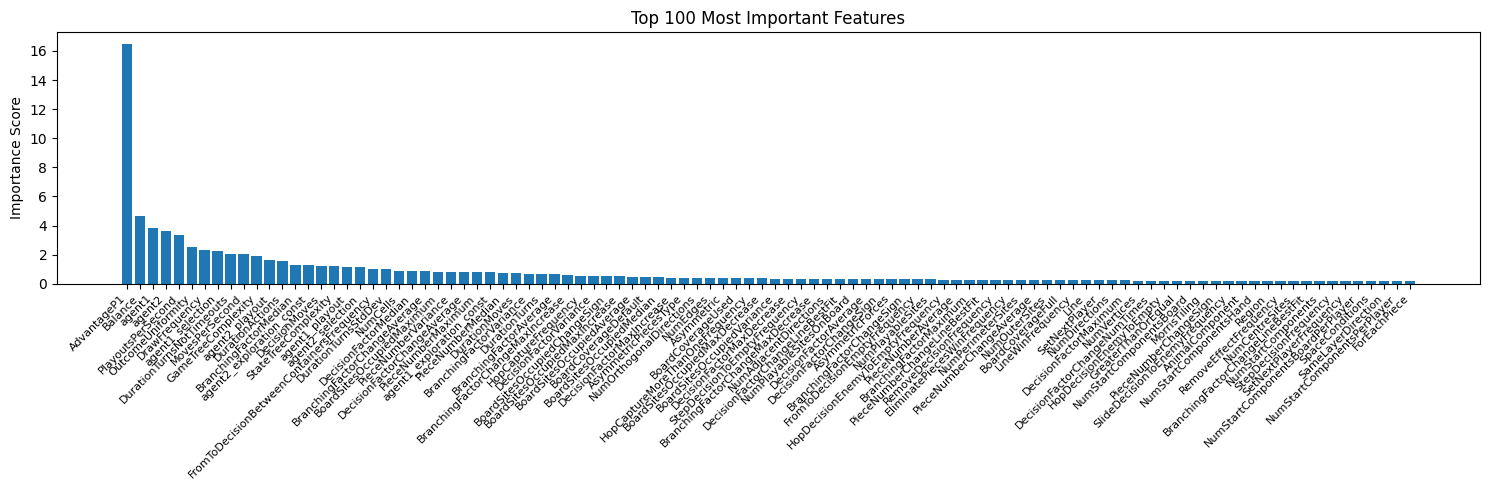

Fold 1 - RMSE: 0.40527799577858564
Fold 2


0:	learn: 0.6330951	test: 0.5468596	best: 0.5468596 (0)	total: 93.3ms	remaining: 15m 33s


50:	learn: 0.4980768	test: 0.4768407	best: 0.4768407 (50)	total: 5.58s	remaining: 18m 7s


100:	learn: 0.4492128	test: 0.4515752	best: 0.4515752 (100)	total: 11.2s	remaining: 18m 18s


150:	learn: 0.4218979	test: 0.4376044	best: 0.4376044 (150)	total: 17s	remaining: 18m 25s


200:	learn: 0.4038581	test: 0.4297065	best: 0.4297065 (200)	total: 23s	remaining: 18m 40s


250:	learn: 0.3902448	test: 0.4242728	best: 0.4242728 (250)	total: 29.1s	remaining: 18m 50s


300:	learn: 0.3789935	test: 0.4195471	best: 0.4195471 (300)	total: 35.1s	remaining: 18m 51s


350:	learn: 0.3694092	test: 0.4162775	best: 0.4162775 (350)	total: 41.2s	remaining: 18m 53s


400:	learn: 0.3613728	test: 0.4130229	best: 0.4130229 (400)	total: 47.3s	remaining: 18m 53s


450:	learn: 0.3540093	test: 0.4103081	best: 0.4103081 (450)	total: 53.3s	remaining: 18m 48s


500:	learn: 0.3472724	test: 0.4083524	best: 0.4083524 (500)	total: 59.3s	remaining: 18m 43s


550:	learn: 0.3412846	test: 0.4066114	best: 0.4066114 (550)	total: 1m 5s	remaining: 18m 37s


600:	learn: 0.3361197	test: 0.4049821	best: 0.4049821 (600)	total: 1m 11s	remaining: 18m 32s


650:	learn: 0.3313935	test: 0.4038503	best: 0.4038503 (650)	total: 1m 17s	remaining: 18m 28s


700:	learn: 0.3266864	test: 0.4029195	best: 0.4028847 (699)	total: 1m 23s	remaining: 18m 21s


750:	learn: 0.3224293	test: 0.4019921	best: 0.4019921 (750)	total: 1m 29s	remaining: 18m 16s


800:	learn: 0.3190103	test: 0.4012462	best: 0.4012462 (800)	total: 1m 34s	remaining: 18m 10s


850:	learn: 0.3155335	test: 0.4006879	best: 0.4006879 (850)	total: 1m 40s	remaining: 18m 4s


900:	learn: 0.3125191	test: 0.3999028	best: 0.3999028 (900)	total: 1m 46s	remaining: 17m 59s


950:	learn: 0.3097013	test: 0.3995156	best: 0.3995156 (950)	total: 1m 53s	remaining: 17m 55s


1000:	learn: 0.3068443	test: 0.3989781	best: 0.3989781 (1000)	total: 1m 59s	remaining: 17m 51s


1050:	learn: 0.3040394	test: 0.3987998	best: 0.3987394 (1031)	total: 2m 5s	remaining: 17m 45s


1100:	learn: 0.3015314	test: 0.3985018	best: 0.3984807 (1096)	total: 2m 11s	remaining: 17m 39s


1150:	learn: 0.2990220	test: 0.3980458	best: 0.3980373 (1149)	total: 2m 17s	remaining: 17m 33s


1200:	learn: 0.2968174	test: 0.3977129	best: 0.3977129 (1200)	total: 2m 23s	remaining: 17m 28s


1250:	learn: 0.2947625	test: 0.3973350	best: 0.3973350 (1250)	total: 2m 29s	remaining: 17m 23s


1300:	learn: 0.2925955	test: 0.3970677	best: 0.3970677 (1300)	total: 2m 35s	remaining: 17m 17s


1350:	learn: 0.2906377	test: 0.3968988	best: 0.3968859 (1345)	total: 2m 41s	remaining: 17m 12s


1400:	learn: 0.2887702	test: 0.3966835	best: 0.3966835 (1400)	total: 2m 47s	remaining: 17m 7s


1450:	learn: 0.2869065	test: 0.3963809	best: 0.3963809 (1450)	total: 2m 53s	remaining: 17m 2s


1500:	learn: 0.2852133	test: 0.3961433	best: 0.3961433 (1500)	total: 2m 59s	remaining: 16m 57s


1550:	learn: 0.2835828	test: 0.3959563	best: 0.3959490 (1532)	total: 3m 5s	remaining: 16m 52s


1600:	learn: 0.2819006	test: 0.3957990	best: 0.3957914 (1595)	total: 3m 11s	remaining: 16m 46s


1650:	learn: 0.2802787	test: 0.3955242	best: 0.3955208 (1644)	total: 3m 17s	remaining: 16m 40s


1700:	learn: 0.2786356	test: 0.3954182	best: 0.3954068 (1699)	total: 3m 23s	remaining: 16m 34s


1750:	learn: 0.2771200	test: 0.3953422	best: 0.3953323 (1739)	total: 3m 29s	remaining: 16m 29s


1800:	learn: 0.2755884	test: 0.3952150	best: 0.3951949 (1791)	total: 3m 36s	remaining: 16m 23s


1850:	learn: 0.2741661	test: 0.3950556	best: 0.3950534 (1849)	total: 3m 42s	remaining: 16m 18s


1900:	learn: 0.2727548	test: 0.3949359	best: 0.3949359 (1900)	total: 3m 48s	remaining: 16m 12s


1950:	learn: 0.2714842	test: 0.3948159	best: 0.3948159 (1950)	total: 3m 54s	remaining: 16m 7s


2000:	learn: 0.2700349	test: 0.3946792	best: 0.3946707 (1996)	total: 4m	remaining: 16m


2050:	learn: 0.2686436	test: 0.3945897	best: 0.3945616 (2047)	total: 4m 6s	remaining: 15m 54s


2100:	learn: 0.2673793	test: 0.3945557	best: 0.3945483 (2098)	total: 4m 12s	remaining: 15m 48s


2150:	learn: 0.2660540	test: 0.3945221	best: 0.3944806 (2134)	total: 4m 18s	remaining: 15m 42s


2200:	learn: 0.2648188	test: 0.3943648	best: 0.3943542 (2189)	total: 4m 24s	remaining: 15m 37s


2250:	learn: 0.2635075	test: 0.3942787	best: 0.3942454 (2246)	total: 4m 30s	remaining: 15m 30s


2300:	learn: 0.2621971	test: 0.3941525	best: 0.3941525 (2300)	total: 4m 36s	remaining: 15m 25s


2350:	learn: 0.2609923	test: 0.3940787	best: 0.3940707 (2331)	total: 4m 42s	remaining: 15m 19s


2400:	learn: 0.2598607	test: 0.3940504	best: 0.3940344 (2396)	total: 4m 48s	remaining: 15m 13s


2450:	learn: 0.2587869	test: 0.3940447	best: 0.3940259 (2423)	total: 4m 54s	remaining: 15m 7s


2500:	learn: 0.2576866	test: 0.3939707	best: 0.3939607 (2491)	total: 5m	remaining: 15m 2s


2550:	learn: 0.2565655	test: 0.3939869	best: 0.3939548 (2509)	total: 5m 6s	remaining: 14m 56s


2600:	learn: 0.2555982	test: 0.3939419	best: 0.3939364 (2597)	total: 5m 13s	remaining: 14m 50s


2650:	learn: 0.2546274	test: 0.3938831	best: 0.3938798 (2643)	total: 5m 19s	remaining: 14m 44s


2700:	learn: 0.2536119	test: 0.3938626	best: 0.3938489 (2696)	total: 5m 25s	remaining: 14m 38s


2750:	learn: 0.2526093	test: 0.3938471	best: 0.3938308 (2715)	total: 5m 31s	remaining: 14m 33s


2800:	learn: 0.2516442	test: 0.3938313	best: 0.3938227 (2775)	total: 5m 37s	remaining: 14m 27s


2850:	learn: 0.2507159	test: 0.3937546	best: 0.3937527 (2846)	total: 5m 43s	remaining: 14m 21s


2900:	learn: 0.2498329	test: 0.3936477	best: 0.3936465 (2899)	total: 5m 49s	remaining: 14m 15s


2950:	learn: 0.2489210	test: 0.3935755	best: 0.3935755 (2950)	total: 5m 55s	remaining: 14m 9s


3000:	learn: 0.2481010	test: 0.3935572	best: 0.3935472 (2986)	total: 6m 1s	remaining: 14m 3s


3050:	learn: 0.2472617	test: 0.3935784	best: 0.3935472 (2986)	total: 6m 8s	remaining: 13m 58s


3100:	learn: 0.2463883	test: 0.3935644	best: 0.3935392 (3068)	total: 6m 14s	remaining: 13m 52s


3150:	learn: 0.2455600	test: 0.3934829	best: 0.3934829 (3150)	total: 6m 20s	remaining: 13m 46s


3200:	learn: 0.2448291	test: 0.3934442	best: 0.3934442 (3200)	total: 6m 26s	remaining: 13m 40s


3250:	learn: 0.2441030	test: 0.3934180	best: 0.3933976 (3229)	total: 6m 32s	remaining: 13m 35s


3300:	learn: 0.2432864	test: 0.3933991	best: 0.3933976 (3229)	total: 6m 38s	remaining: 13m 29s


3350:	learn: 0.2424752	test: 0.3933392	best: 0.3933361 (3349)	total: 6m 44s	remaining: 13m 23s


3400:	learn: 0.2417020	test: 0.3933055	best: 0.3933015 (3386)	total: 6m 50s	remaining: 13m 17s


3450:	learn: 0.2409358	test: 0.3933605	best: 0.3932918 (3408)	total: 6m 56s	remaining: 13m 11s


3500:	learn: 0.2402544	test: 0.3933645	best: 0.3932918 (3408)	total: 7m 3s	remaining: 13m 5s


3550:	learn: 0.2395793	test: 0.3933350	best: 0.3932918 (3408)	total: 7m 9s	remaining: 12m 59s


3600:	learn: 0.2388941	test: 0.3932689	best: 0.3932685 (3599)	total: 7m 15s	remaining: 12m 53s


3650:	learn: 0.2381587	test: 0.3932593	best: 0.3932593 (3650)	total: 7m 21s	remaining: 12m 47s


3700:	learn: 0.2374800	test: 0.3932472	best: 0.3932428 (3692)	total: 7m 27s	remaining: 12m 41s


3750:	learn: 0.2367734	test: 0.3932093	best: 0.3932081 (3749)	total: 7m 33s	remaining: 12m 35s


3800:	learn: 0.2361304	test: 0.3931463	best: 0.3931408 (3799)	total: 7m 39s	remaining: 12m 29s


3850:	learn: 0.2354712	test: 0.3931252	best: 0.3931180 (3846)	total: 7m 45s	remaining: 12m 23s


3900:	learn: 0.2348493	test: 0.3930982	best: 0.3930895 (3880)	total: 7m 51s	remaining: 12m 17s


3950:	learn: 0.2341859	test: 0.3930599	best: 0.3930538 (3943)	total: 7m 58s	remaining: 12m 11s


4000:	learn: 0.2334896	test: 0.3930135	best: 0.3930135 (4000)	total: 8m 4s	remaining: 12m 6s


4050:	learn: 0.2328849	test: 0.3929674	best: 0.3929665 (4048)	total: 8m 10s	remaining: 11m 59s


4100:	learn: 0.2322307	test: 0.3929324	best: 0.3929304 (4099)	total: 8m 16s	remaining: 11m 54s


4150:	learn: 0.2316519	test: 0.3928820	best: 0.3928820 (4150)	total: 8m 22s	remaining: 11m 48s


4200:	learn: 0.2310114	test: 0.3928422	best: 0.3928337 (4193)	total: 8m 28s	remaining: 11m 42s


4250:	learn: 0.2304114	test: 0.3928045	best: 0.3928045 (4250)	total: 8m 34s	remaining: 11m 36s


4300:	learn: 0.2298171	test: 0.3928021	best: 0.3927901 (4293)	total: 8m 40s	remaining: 11m 30s


4350:	learn: 0.2292154	test: 0.3928017	best: 0.3927875 (4312)	total: 8m 47s	remaining: 11m 24s


4400:	learn: 0.2286518	test: 0.3928035	best: 0.3927875 (4312)	total: 8m 53s	remaining: 11m 18s


4450:	learn: 0.2280606	test: 0.3927542	best: 0.3927542 (4450)	total: 8m 59s	remaining: 11m 12s


4500:	learn: 0.2274925	test: 0.3927216	best: 0.3927136 (4482)	total: 9m 5s	remaining: 11m 6s


4550:	learn: 0.2269396	test: 0.3926957	best: 0.3926780 (4531)	total: 9m 11s	remaining: 11m


4600:	learn: 0.2263710	test: 0.3926599	best: 0.3926599 (4600)	total: 9m 17s	remaining: 10m 54s


4650:	learn: 0.2257697	test: 0.3926604	best: 0.3926494 (4626)	total: 9m 23s	remaining: 10m 48s


4700:	learn: 0.2252267	test: 0.3926577	best: 0.3926370 (4657)	total: 9m 30s	remaining: 10m 42s


4750:	learn: 0.2246486	test: 0.3926266	best: 0.3926266 (4750)	total: 9m 36s	remaining: 10m 36s


4800:	learn: 0.2240905	test: 0.3926201	best: 0.3925962 (4782)	total: 9m 42s	remaining: 10m 30s


4850:	learn: 0.2235041	test: 0.3925772	best: 0.3925732 (4846)	total: 9m 48s	remaining: 10m 24s


4900:	learn: 0.2229357	test: 0.3925656	best: 0.3925563 (4858)	total: 9m 54s	remaining: 10m 18s


4950:	learn: 0.2224157	test: 0.3925391	best: 0.3925376 (4947)	total: 10m	remaining: 10m 12s


5000:	learn: 0.2219125	test: 0.3925190	best: 0.3925065 (4986)	total: 10m 6s	remaining: 10m 6s


5050:	learn: 0.2213876	test: 0.3924928	best: 0.3924928 (5040)	total: 10m 12s	remaining: 10m


5100:	learn: 0.2208640	test: 0.3925282	best: 0.3924847 (5054)	total: 10m 19s	remaining: 9m 54s


5150:	learn: 0.2203383	test: 0.3925168	best: 0.3924847 (5054)	total: 10m 25s	remaining: 9m 48s


5200:	learn: 0.2198326	test: 0.3925028	best: 0.3924847 (5054)	total: 10m 31s	remaining: 9m 42s


5250:	learn: 0.2193403	test: 0.3925038	best: 0.3924847 (5054)	total: 10m 37s	remaining: 9m 36s


5300:	learn: 0.2188988	test: 0.3924783	best: 0.3924783 (5300)	total: 10m 43s	remaining: 9m 30s


5350:	learn: 0.2183735	test: 0.3924667	best: 0.3924597 (5329)	total: 10m 49s	remaining: 9m 24s


5400:	learn: 0.2179357	test: 0.3924593	best: 0.3924463 (5385)	total: 10m 55s	remaining: 9m 18s


5450:	learn: 0.2174264	test: 0.3924633	best: 0.3924463 (5385)	total: 11m 1s	remaining: 9m 12s


5500:	learn: 0.2169196	test: 0.3924514	best: 0.3924435 (5470)	total: 11m 7s	remaining: 9m 6s


5550:	learn: 0.2164004	test: 0.3924111	best: 0.3924111 (5550)	total: 11m 13s	remaining: 9m


5600:	learn: 0.2158795	test: 0.3923819	best: 0.3923819 (5600)	total: 11m 20s	remaining: 8m 54s


5650:	learn: 0.2154057	test: 0.3923990	best: 0.3923800 (5620)	total: 11m 26s	remaining: 8m 48s


5700:	learn: 0.2149040	test: 0.3924205	best: 0.3923800 (5620)	total: 11m 32s	remaining: 8m 41s


5750:	learn: 0.2144532	test: 0.3923786	best: 0.3923723 (5745)	total: 11m 38s	remaining: 8m 35s


5800:	learn: 0.2139770	test: 0.3923476	best: 0.3923476 (5800)	total: 11m 44s	remaining: 8m 29s


5850:	learn: 0.2135518	test: 0.3923593	best: 0.3923384 (5822)	total: 11m 50s	remaining: 8m 23s


5900:	learn: 0.2131487	test: 0.3923599	best: 0.3923384 (5822)	total: 11m 56s	remaining: 8m 17s


5950:	learn: 0.2126614	test: 0.3923483	best: 0.3923384 (5822)	total: 12m 2s	remaining: 8m 11s


6000:	learn: 0.2122072	test: 0.3923452	best: 0.3923384 (5822)	total: 12m 8s	remaining: 8m 5s


6050:	learn: 0.2117943	test: 0.3923106	best: 0.3923078 (6044)	total: 12m 14s	remaining: 7m 59s


6100:	learn: 0.2113543	test: 0.3922977	best: 0.3922977 (6100)	total: 12m 20s	remaining: 7m 53s


6150:	learn: 0.2109475	test: 0.3923083	best: 0.3922961 (6103)	total: 12m 26s	remaining: 7m 47s


6200:	learn: 0.2105308	test: 0.3923250	best: 0.3922961 (6103)	total: 12m 33s	remaining: 7m 41s


6250:	learn: 0.2101469	test: 0.3923319	best: 0.3922961 (6103)	total: 12m 39s	remaining: 7m 35s


6300:	learn: 0.2097129	test: 0.3923425	best: 0.3922961 (6103)	total: 12m 45s	remaining: 7m 29s


6350:	learn: 0.2092568	test: 0.3923301	best: 0.3922961 (6103)	total: 12m 51s	remaining: 7m 23s


6400:	learn: 0.2088691	test: 0.3923216	best: 0.3922961 (6103)	total: 12m 57s	remaining: 7m 17s


6450:	learn: 0.2084840	test: 0.3923293	best: 0.3922961 (6103)	total: 13m 3s	remaining: 7m 11s


6500:	learn: 0.2081028	test: 0.3923015	best: 0.3922961 (6103)	total: 13m 9s	remaining: 7m 5s


6550:	learn: 0.2077271	test: 0.3923014	best: 0.3922961 (6103)	total: 13m 15s	remaining: 6m 59s


6600:	learn: 0.2073236	test: 0.3923340	best: 0.3922961 (6103)	total: 13m 22s	remaining: 6m 52s


6650:	learn: 0.2069207	test: 0.3923419	best: 0.3922961 (6103)	total: 13m 28s	remaining: 6m 46s


6700:	learn: 0.2065043	test: 0.3923371	best: 0.3922961 (6103)	total: 13m 34s	remaining: 6m 40s


6750:	learn: 0.2061024	test: 0.3923413	best: 0.3922961 (6103)	total: 13m 40s	remaining: 6m 34s


6800:	learn: 0.2057084	test: 0.3923241	best: 0.3922961 (6103)	total: 13m 46s	remaining: 6m 28s


6850:	learn: 0.2053557	test: 0.3922894	best: 0.3922858 (6841)	total: 13m 52s	remaining: 6m 22s


6900:	learn: 0.2049442	test: 0.3922889	best: 0.3922848 (6897)	total: 13m 58s	remaining: 6m 16s


6950:	learn: 0.2045242	test: 0.3922703	best: 0.3922645 (6934)	total: 14m 4s	remaining: 6m 10s


7000:	learn: 0.2041159	test: 0.3922863	best: 0.3922645 (6934)	total: 14m 10s	remaining: 6m 4s


7050:	learn: 0.2037575	test: 0.3922881	best: 0.3922645 (6934)	total: 14m 16s	remaining: 5m 58s


7100:	learn: 0.2033591	test: 0.3923046	best: 0.3922645 (6934)	total: 14m 22s	remaining: 5m 52s


7150:	learn: 0.2030043	test: 0.3923090	best: 0.3922645 (6934)	total: 14m 28s	remaining: 5m 46s


7200:	learn: 0.2026695	test: 0.3922966	best: 0.3922645 (6934)	total: 14m 34s	remaining: 5m 40s


7250:	learn: 0.2022896	test: 0.3922905	best: 0.3922645 (6934)	total: 14m 40s	remaining: 5m 33s


7300:	learn: 0.2018516	test: 0.3922963	best: 0.3922645 (6934)	total: 14m 46s	remaining: 5m 27s


7350:	learn: 0.2014709	test: 0.3923237	best: 0.3922645 (6934)	total: 14m 53s	remaining: 5m 21s


7400:	learn: 0.2010922	test: 0.3923145	best: 0.3922645 (6934)	total: 14m 59s	remaining: 5m 15s


7450:	learn: 0.2007323	test: 0.3923014	best: 0.3922645 (6934)	total: 15m 5s	remaining: 5m 9s


7500:	learn: 0.2003429	test: 0.3923109	best: 0.3922645 (6934)	total: 15m 11s	remaining: 5m 3s


7550:	learn: 0.1999888	test: 0.3923155	best: 0.3922645 (6934)	total: 15m 17s	remaining: 4m 57s


7600:	learn: 0.1996468	test: 0.3923055	best: 0.3922645 (6934)	total: 15m 23s	remaining: 4m 51s


7650:	learn: 0.1992833	test: 0.3922943	best: 0.3922645 (6934)	total: 15m 29s	remaining: 4m 45s


7700:	learn: 0.1989117	test: 0.3922897	best: 0.3922645 (6934)	total: 15m 35s	remaining: 4m 39s


7750:	learn: 0.1985192	test: 0.3923130	best: 0.3922645 (6934)	total: 15m 41s	remaining: 4m 33s


7800:	learn: 0.1981565	test: 0.3923072	best: 0.3922645 (6934)	total: 15m 47s	remaining: 4m 27s


7850:	learn: 0.1978015	test: 0.3923336	best: 0.3922645 (6934)	total: 15m 54s	remaining: 4m 21s


7900:	learn: 0.1974097	test: 0.3923470	best: 0.3922645 (6934)	total: 16m	remaining: 4m 15s


7950:	learn: 0.1970711	test: 0.3923543	best: 0.3922645 (6934)	total: 16m 6s	remaining: 4m 8s


8000:	learn: 0.1967115	test: 0.3923450	best: 0.3922645 (6934)	total: 16m 12s	remaining: 4m 2s


8050:	learn: 0.1963621	test: 0.3923514	best: 0.3922645 (6934)	total: 16m 18s	remaining: 3m 56s


8100:	learn: 0.1960244	test: 0.3923356	best: 0.3922645 (6934)	total: 16m 24s	remaining: 3m 50s


8150:	learn: 0.1956765	test: 0.3923359	best: 0.3922645 (6934)	total: 16m 30s	remaining: 3m 44s


8200:	learn: 0.1953313	test: 0.3923200	best: 0.3922645 (6934)	total: 16m 36s	remaining: 3m 38s


8250:	learn: 0.1950092	test: 0.3923268	best: 0.3922645 (6934)	total: 16m 42s	remaining: 3m 32s


8300:	learn: 0.1946769	test: 0.3923369	best: 0.3922645 (6934)	total: 16m 48s	remaining: 3m 26s


8350:	learn: 0.1943562	test: 0.3923354	best: 0.3922645 (6934)	total: 16m 55s	remaining: 3m 20s


8400:	learn: 0.1940482	test: 0.3923170	best: 0.3922645 (6934)	total: 17m 1s	remaining: 3m 14s


8450:	learn: 0.1937183	test: 0.3923314	best: 0.3922645 (6934)	total: 17m 7s	remaining: 3m 8s


8500:	learn: 0.1933998	test: 0.3923168	best: 0.3922645 (6934)	total: 17m 13s	remaining: 3m 2s


8550:	learn: 0.1930791	test: 0.3923164	best: 0.3922645 (6934)	total: 17m 19s	remaining: 2m 56s


8600:	learn: 0.1927544	test: 0.3922992	best: 0.3922645 (6934)	total: 17m 25s	remaining: 2m 50s


8650:	learn: 0.1924349	test: 0.3922982	best: 0.3922645 (6934)	total: 17m 31s	remaining: 2m 43s


8700:	learn: 0.1921419	test: 0.3922963	best: 0.3922645 (6934)	total: 17m 37s	remaining: 2m 37s


8750:	learn: 0.1917935	test: 0.3923012	best: 0.3922645 (6934)	total: 17m 43s	remaining: 2m 31s


8800:	learn: 0.1914788	test: 0.3922967	best: 0.3922645 (6934)	total: 17m 49s	remaining: 2m 25s


8850:	learn: 0.1911603	test: 0.3922902	best: 0.3922645 (6934)	total: 17m 55s	remaining: 2m 19s


8900:	learn: 0.1908500	test: 0.3922944	best: 0.3922645 (6934)	total: 18m 1s	remaining: 2m 13s


8950:	learn: 0.1905443	test: 0.3922885	best: 0.3922645 (6934)	total: 18m 7s	remaining: 2m 7s


9000:	learn: 0.1902340	test: 0.3922869	best: 0.3922645 (6934)	total: 18m 13s	remaining: 2m 1s


9050:	learn: 0.1899312	test: 0.3922843	best: 0.3922645 (6934)	total: 18m 19s	remaining: 1m 55s


9100:	learn: 0.1896161	test: 0.3922909	best: 0.3922645 (6934)	total: 18m 26s	remaining: 1m 49s


9150:	learn: 0.1892950	test: 0.3922983	best: 0.3922645 (6934)	total: 18m 32s	remaining: 1m 43s


9200:	learn: 0.1889951	test: 0.3922974	best: 0.3922645 (6934)	total: 18m 38s	remaining: 1m 37s


9250:	learn: 0.1886996	test: 0.3923126	best: 0.3922645 (6934)	total: 18m 44s	remaining: 1m 31s


9300:	learn: 0.1883885	test: 0.3923057	best: 0.3922645 (6934)	total: 18m 50s	remaining: 1m 24s


9350:	learn: 0.1880814	test: 0.3923140	best: 0.3922645 (6934)	total: 18m 56s	remaining: 1m 18s


9400:	learn: 0.1877804	test: 0.3923184	best: 0.3922645 (6934)	total: 19m 2s	remaining: 1m 12s


9450:	learn: 0.1874635	test: 0.3923353	best: 0.3922645 (6934)	total: 19m 8s	remaining: 1m 6s


9500:	learn: 0.1871664	test: 0.3923338	best: 0.3922645 (6934)	total: 19m 14s	remaining: 1m


9550:	learn: 0.1868532	test: 0.3923224	best: 0.3922645 (6934)	total: 19m 20s	remaining: 54.6s


9600:	learn: 0.1865742	test: 0.3923332	best: 0.3922645 (6934)	total: 19m 26s	remaining: 48.5s


9650:	learn: 0.1862846	test: 0.3923329	best: 0.3922645 (6934)	total: 19m 33s	remaining: 42.4s


9700:	learn: 0.1860018	test: 0.3923299	best: 0.3922645 (6934)	total: 19m 39s	remaining: 36.3s


9750:	learn: 0.1856954	test: 0.3923401	best: 0.3922645 (6934)	total: 19m 45s	remaining: 30.3s


9800:	learn: 0.1853787	test: 0.3923269	best: 0.3922645 (6934)	total: 19m 51s	remaining: 24.2s


9850:	learn: 0.1850703	test: 0.3923261	best: 0.3922645 (6934)	total: 19m 57s	remaining: 18.1s


9900:	learn: 0.1847639	test: 0.3923078	best: 0.3922645 (6934)	total: 20m 3s	remaining: 12s


9950:	learn: 0.1844698	test: 0.3923097	best: 0.3922645 (6934)	total: 20m 9s	remaining: 5.96s


9999:	learn: 0.1841998	test: 0.3922988	best: 0.3922645 (6934)	total: 20m 15s	remaining: 0us

bestTest = 0.3922645058
bestIteration = 6934

Shrink model to first 6935 iterations.


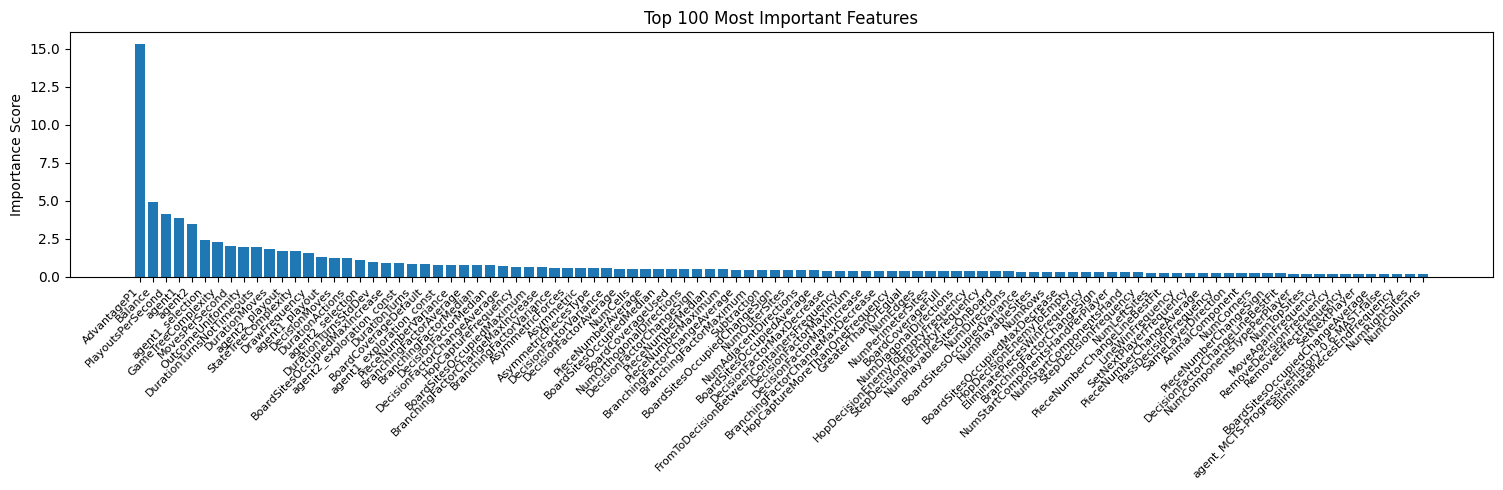

Fold 2 - RMSE: 0.3918960828939259
Fold 3


0:	learn: 0.6193381	test: 0.6142879	best: 0.6142879 (0)	total: 93.6ms	remaining: 15m 35s


50:	learn: 0.4834434	test: 0.5518252	best: 0.5518252 (50)	total: 5.54s	remaining: 18m


100:	learn: 0.4393551	test: 0.5208162	best: 0.5208162 (100)	total: 11.2s	remaining: 18m 18s


150:	learn: 0.4135996	test: 0.5044023	best: 0.5044023 (150)	total: 16.9s	remaining: 18m 24s


200:	learn: 0.3960049	test: 0.4910888	best: 0.4910888 (200)	total: 22.9s	remaining: 18m 37s


250:	learn: 0.3828605	test: 0.4816567	best: 0.4816567 (250)	total: 29s	remaining: 18m 47s


300:	learn: 0.3724346	test: 0.4747618	best: 0.4747618 (300)	total: 35.2s	remaining: 18m 53s


350:	learn: 0.3636373	test: 0.4694160	best: 0.4694160 (350)	total: 41.3s	remaining: 18m 54s


400:	learn: 0.3567343	test: 0.4651917	best: 0.4651917 (400)	total: 47.4s	remaining: 18m 54s


450:	learn: 0.3501855	test: 0.4618035	best: 0.4618035 (450)	total: 53.6s	remaining: 18m 54s


500:	learn: 0.3440203	test: 0.4587090	best: 0.4587090 (500)	total: 59.8s	remaining: 18m 52s


550:	learn: 0.3383178	test: 0.4558021	best: 0.4558021 (550)	total: 1m 5s	remaining: 18m 46s


600:	learn: 0.3333994	test: 0.4532441	best: 0.4532441 (600)	total: 1m 11s	remaining: 18m 41s


650:	learn: 0.3283956	test: 0.4508814	best: 0.4508814 (650)	total: 1m 17s	remaining: 18m 35s


700:	learn: 0.3241482	test: 0.4489739	best: 0.4489739 (700)	total: 1m 23s	remaining: 18m 31s


750:	learn: 0.3202488	test: 0.4473311	best: 0.4473311 (750)	total: 1m 29s	remaining: 18m 25s


800:	learn: 0.3167710	test: 0.4459677	best: 0.4459677 (800)	total: 1m 35s	remaining: 18m 18s


850:	learn: 0.3134987	test: 0.4448025	best: 0.4448025 (850)	total: 1m 41s	remaining: 18m 12s


900:	learn: 0.3102725	test: 0.4437910	best: 0.4437910 (900)	total: 1m 47s	remaining: 18m 6s


950:	learn: 0.3072225	test: 0.4428450	best: 0.4428450 (950)	total: 1m 53s	remaining: 18m


1000:	learn: 0.3044428	test: 0.4419117	best: 0.4419117 (1000)	total: 1m 59s	remaining: 17m 55s


1050:	learn: 0.3018168	test: 0.4409833	best: 0.4409833 (1050)	total: 2m 5s	remaining: 17m 50s


1100:	learn: 0.2993938	test: 0.4400972	best: 0.4400972 (1100)	total: 2m 11s	remaining: 17m 45s


1150:	learn: 0.2969459	test: 0.4393429	best: 0.4393429 (1150)	total: 2m 17s	remaining: 17m 39s


1200:	learn: 0.2947688	test: 0.4387339	best: 0.4387339 (1200)	total: 2m 23s	remaining: 17m 34s


1250:	learn: 0.2924740	test: 0.4379566	best: 0.4379566 (1250)	total: 2m 29s	remaining: 17m 27s


1300:	learn: 0.2904238	test: 0.4375173	best: 0.4375173 (1300)	total: 2m 35s	remaining: 17m 22s


1350:	learn: 0.2884500	test: 0.4369206	best: 0.4369202 (1349)	total: 2m 42s	remaining: 17m 17s


1400:	learn: 0.2864999	test: 0.4364361	best: 0.4364361 (1400)	total: 2m 48s	remaining: 17m 11s


1450:	learn: 0.2846645	test: 0.4359363	best: 0.4359363 (1450)	total: 2m 54s	remaining: 17m 6s


1500:	learn: 0.2829961	test: 0.4355203	best: 0.4355203 (1500)	total: 3m	remaining: 17m


1550:	learn: 0.2812262	test: 0.4351031	best: 0.4351031 (1550)	total: 3m 6s	remaining: 16m 53s


1600:	learn: 0.2796452	test: 0.4346923	best: 0.4346915 (1599)	total: 3m 12s	remaining: 16m 48s


1650:	learn: 0.2780623	test: 0.4343812	best: 0.4343812 (1650)	total: 3m 18s	remaining: 16m 42s


1700:	learn: 0.2765595	test: 0.4341544	best: 0.4341544 (1700)	total: 3m 24s	remaining: 16m 37s


1750:	learn: 0.2750742	test: 0.4339057	best: 0.4339057 (1750)	total: 3m 30s	remaining: 16m 31s


1800:	learn: 0.2735952	test: 0.4336070	best: 0.4336070 (1800)	total: 3m 36s	remaining: 16m 25s


1850:	learn: 0.2722994	test: 0.4332630	best: 0.4332630 (1850)	total: 3m 42s	remaining: 16m 19s


1900:	learn: 0.2710390	test: 0.4330336	best: 0.4330254 (1897)	total: 3m 48s	remaining: 16m 14s


1950:	learn: 0.2696753	test: 0.4326565	best: 0.4326565 (1950)	total: 3m 54s	remaining: 16m 8s


2000:	learn: 0.2683363	test: 0.4323575	best: 0.4323575 (2000)	total: 4m	remaining: 16m 2s


2050:	learn: 0.2670395	test: 0.4321264	best: 0.4321139 (2041)	total: 4m 6s	remaining: 15m 57s


2100:	learn: 0.2657825	test: 0.4318874	best: 0.4318777 (2096)	total: 4m 13s	remaining: 15m 51s


2150:	learn: 0.2645801	test: 0.4315942	best: 0.4315942 (2150)	total: 4m 19s	remaining: 15m 45s


2200:	learn: 0.2633333	test: 0.4312981	best: 0.4312981 (2200)	total: 4m 25s	remaining: 15m 39s


2250:	learn: 0.2621969	test: 0.4311765	best: 0.4311619 (2228)	total: 4m 31s	remaining: 15m 33s


2300:	learn: 0.2610940	test: 0.4309879	best: 0.4309879 (2300)	total: 4m 37s	remaining: 15m 27s


2350:	learn: 0.2599633	test: 0.4307487	best: 0.4307474 (2346)	total: 4m 43s	remaining: 15m 22s


2400:	learn: 0.2588217	test: 0.4305516	best: 0.4305516 (2400)	total: 4m 49s	remaining: 15m 16s


2450:	learn: 0.2577863	test: 0.4303262	best: 0.4303262 (2450)	total: 4m 55s	remaining: 15m 10s


2500:	learn: 0.2568099	test: 0.4302021	best: 0.4302002 (2499)	total: 5m 1s	remaining: 15m 5s


2550:	learn: 0.2557308	test: 0.4300589	best: 0.4300589 (2550)	total: 5m 8s	remaining: 14m 59s


2600:	learn: 0.2546588	test: 0.4298385	best: 0.4298385 (2600)	total: 5m 14s	remaining: 14m 53s


2650:	learn: 0.2536273	test: 0.4296883	best: 0.4296883 (2650)	total: 5m 20s	remaining: 14m 47s


2700:	learn: 0.2526201	test: 0.4295849	best: 0.4295849 (2700)	total: 5m 26s	remaining: 14m 42s


2750:	learn: 0.2516515	test: 0.4293552	best: 0.4293552 (2750)	total: 5m 32s	remaining: 14m 36s


2800:	learn: 0.2508196	test: 0.4292652	best: 0.4292607 (2799)	total: 5m 38s	remaining: 14m 30s


2850:	learn: 0.2498674	test: 0.4290991	best: 0.4290981 (2849)	total: 5m 44s	remaining: 14m 25s


2900:	learn: 0.2489324	test: 0.4289976	best: 0.4289976 (2900)	total: 5m 51s	remaining: 14m 19s


2950:	learn: 0.2480923	test: 0.4288374	best: 0.4288370 (2947)	total: 5m 57s	remaining: 14m 13s


3000:	learn: 0.2472721	test: 0.4286372	best: 0.4286372 (3000)	total: 6m 3s	remaining: 14m 7s


3050:	learn: 0.2463995	test: 0.4285179	best: 0.4285179 (3050)	total: 6m 9s	remaining: 14m 1s


3100:	learn: 0.2455968	test: 0.4283894	best: 0.4283894 (3100)	total: 6m 15s	remaining: 13m 55s


3150:	learn: 0.2446815	test: 0.4282216	best: 0.4282216 (3150)	total: 6m 21s	remaining: 13m 49s


3200:	learn: 0.2438762	test: 0.4280718	best: 0.4280718 (3200)	total: 6m 27s	remaining: 13m 43s


3250:	learn: 0.2431418	test: 0.4278978	best: 0.4278953 (3249)	total: 6m 33s	remaining: 13m 37s


3300:	learn: 0.2424077	test: 0.4277826	best: 0.4277813 (3298)	total: 6m 40s	remaining: 13m 31s


3350:	learn: 0.2416389	test: 0.4277096	best: 0.4277081 (3348)	total: 6m 46s	remaining: 13m 25s


3400:	learn: 0.2409250	test: 0.4276109	best: 0.4276098 (3394)	total: 6m 52s	remaining: 13m 20s


3450:	learn: 0.2401704	test: 0.4274606	best: 0.4274598 (3448)	total: 6m 58s	remaining: 13m 14s


3500:	learn: 0.2394278	test: 0.4273314	best: 0.4273237 (3498)	total: 7m 4s	remaining: 13m 8s


3550:	learn: 0.2387018	test: 0.4272494	best: 0.4272451 (3544)	total: 7m 10s	remaining: 13m 2s


3600:	learn: 0.2380137	test: 0.4271684	best: 0.4271656 (3598)	total: 7m 16s	remaining: 12m 56s


3650:	learn: 0.2373523	test: 0.4270550	best: 0.4270509 (3649)	total: 7m 23s	remaining: 12m 50s


3700:	learn: 0.2366854	test: 0.4269237	best: 0.4269237 (3700)	total: 7m 29s	remaining: 12m 44s


3750:	learn: 0.2359910	test: 0.4267878	best: 0.4267867 (3749)	total: 7m 35s	remaining: 12m 38s


3800:	learn: 0.2353256	test: 0.4266806	best: 0.4266806 (3800)	total: 7m 41s	remaining: 12m 32s


3850:	learn: 0.2347004	test: 0.4266210	best: 0.4266210 (3850)	total: 7m 47s	remaining: 12m 26s


3900:	learn: 0.2340607	test: 0.4265316	best: 0.4265261 (3899)	total: 7m 53s	remaining: 12m 20s


3950:	learn: 0.2334215	test: 0.4264306	best: 0.4264295 (3949)	total: 8m	remaining: 12m 15s


4000:	learn: 0.2327891	test: 0.4263525	best: 0.4263525 (4000)	total: 8m 6s	remaining: 12m 9s


4050:	learn: 0.2321540	test: 0.4263477	best: 0.4263440 (4048)	total: 8m 12s	remaining: 12m 3s


4100:	learn: 0.2315772	test: 0.4262851	best: 0.4262851 (4100)	total: 8m 18s	remaining: 11m 56s


4150:	learn: 0.2309700	test: 0.4262183	best: 0.4262169 (4144)	total: 8m 24s	remaining: 11m 50s


4200:	learn: 0.2304070	test: 0.4260941	best: 0.4260941 (4200)	total: 8m 30s	remaining: 11m 45s


4250:	learn: 0.2297771	test: 0.4259719	best: 0.4259719 (4250)	total: 8m 36s	remaining: 11m 39s


4300:	learn: 0.2291816	test: 0.4259199	best: 0.4259120 (4294)	total: 8m 43s	remaining: 11m 33s


4350:	learn: 0.2285736	test: 0.4258192	best: 0.4258192 (4350)	total: 8m 49s	remaining: 11m 26s


4400:	learn: 0.2279844	test: 0.4257713	best: 0.4257713 (4400)	total: 8m 55s	remaining: 11m 20s


4450:	learn: 0.2274625	test: 0.4256760	best: 0.4256751 (4449)	total: 9m 1s	remaining: 11m 14s


4500:	learn: 0.2269098	test: 0.4255860	best: 0.4255849 (4499)	total: 9m 7s	remaining: 11m 8s


4550:	learn: 0.2263069	test: 0.4254798	best: 0.4254798 (4550)	total: 9m 13s	remaining: 11m 2s


4600:	learn: 0.2257924	test: 0.4254314	best: 0.4254314 (4600)	total: 9m 19s	remaining: 10m 56s


4650:	learn: 0.2252687	test: 0.4253983	best: 0.4253983 (4650)	total: 9m 26s	remaining: 10m 50s


4700:	learn: 0.2247268	test: 0.4253131	best: 0.4253131 (4700)	total: 9m 32s	remaining: 10m 44s


4750:	learn: 0.2241788	test: 0.4252526	best: 0.4252526 (4750)	total: 9m 38s	remaining: 10m 38s


4800:	learn: 0.2236294	test: 0.4251321	best: 0.4251252 (4790)	total: 9m 44s	remaining: 10m 32s


4850:	learn: 0.2231262	test: 0.4250604	best: 0.4250604 (4850)	total: 9m 50s	remaining: 10m 26s


4900:	learn: 0.2226310	test: 0.4249975	best: 0.4249975 (4900)	total: 9m 56s	remaining: 10m 20s


4950:	learn: 0.2221208	test: 0.4249674	best: 0.4249674 (4950)	total: 10m 2s	remaining: 10m 14s


5000:	learn: 0.2215920	test: 0.4249343	best: 0.4249326 (4995)	total: 10m 8s	remaining: 10m 8s


5050:	learn: 0.2210506	test: 0.4248539	best: 0.4248500 (5049)	total: 10m 15s	remaining: 10m 2s


5100:	learn: 0.2205617	test: 0.4248081	best: 0.4248081 (5100)	total: 10m 21s	remaining: 9m 56s


5150:	learn: 0.2200534	test: 0.4247459	best: 0.4247428 (5148)	total: 10m 27s	remaining: 9m 50s


5200:	learn: 0.2195909	test: 0.4246730	best: 0.4246730 (5199)	total: 10m 33s	remaining: 9m 44s


5250:	learn: 0.2190548	test: 0.4246077	best: 0.4246077 (5250)	total: 10m 39s	remaining: 9m 38s


5300:	learn: 0.2185770	test: 0.4245569	best: 0.4245553 (5298)	total: 10m 45s	remaining: 9m 32s


5350:	learn: 0.2180963	test: 0.4244819	best: 0.4244816 (5349)	total: 10m 52s	remaining: 9m 26s


5400:	learn: 0.2175546	test: 0.4244537	best: 0.4244492 (5394)	total: 10m 58s	remaining: 9m 20s


5450:	learn: 0.2170938	test: 0.4244333	best: 0.4244249 (5422)	total: 11m 4s	remaining: 9m 14s


5500:	learn: 0.2166324	test: 0.4243981	best: 0.4243961 (5493)	total: 11m 10s	remaining: 9m 8s


5550:	learn: 0.2161859	test: 0.4243503	best: 0.4243503 (5550)	total: 11m 16s	remaining: 9m 2s


5600:	learn: 0.2157459	test: 0.4243054	best: 0.4243050 (5599)	total: 11m 22s	remaining: 8m 56s


5650:	learn: 0.2153304	test: 0.4242696	best: 0.4242696 (5650)	total: 11m 28s	remaining: 8m 50s


5700:	learn: 0.2148379	test: 0.4242171	best: 0.4242171 (5700)	total: 11m 35s	remaining: 8m 44s


5750:	learn: 0.2144108	test: 0.4241859	best: 0.4241859 (5750)	total: 11m 41s	remaining: 8m 38s


5800:	learn: 0.2139547	test: 0.4241198	best: 0.4241175 (5799)	total: 11m 47s	remaining: 8m 32s


5850:	learn: 0.2135467	test: 0.4240821	best: 0.4240806 (5848)	total: 11m 53s	remaining: 8m 25s


5900:	learn: 0.2131055	test: 0.4240174	best: 0.4240174 (5900)	total: 11m 59s	remaining: 8m 19s


5950:	learn: 0.2126750	test: 0.4239685	best: 0.4239685 (5950)	total: 12m 5s	remaining: 8m 13s


6000:	learn: 0.2122505	test: 0.4239421	best: 0.4239419 (5999)	total: 12m 11s	remaining: 8m 7s


6050:	learn: 0.2118202	test: 0.4238813	best: 0.4238803 (6043)	total: 12m 18s	remaining: 8m 1s


6100:	learn: 0.2113794	test: 0.4238639	best: 0.4238637 (6098)	total: 12m 24s	remaining: 7m 55s


6150:	learn: 0.2109876	test: 0.4238318	best: 0.4238318 (6150)	total: 12m 30s	remaining: 7m 49s


6200:	learn: 0.2105456	test: 0.4238087	best: 0.4238023 (6185)	total: 12m 36s	remaining: 7m 43s


6250:	learn: 0.2101548	test: 0.4238021	best: 0.4238007 (6249)	total: 12m 42s	remaining: 7m 37s


6300:	learn: 0.2097083	test: 0.4237485	best: 0.4237485 (6292)	total: 12m 48s	remaining: 7m 31s


6350:	learn: 0.2092262	test: 0.4236932	best: 0.4236918 (6349)	total: 12m 55s	remaining: 7m 25s


6400:	learn: 0.2088418	test: 0.4236505	best: 0.4236505 (6400)	total: 13m 1s	remaining: 7m 19s


6450:	learn: 0.2084377	test: 0.4236294	best: 0.4236251 (6445)	total: 13m 7s	remaining: 7m 13s


6500:	learn: 0.2080615	test: 0.4236110	best: 0.4236029 (6482)	total: 13m 13s	remaining: 7m 7s


6550:	learn: 0.2076630	test: 0.4235876	best: 0.4235860 (6549)	total: 13m 19s	remaining: 7m 1s


6600:	learn: 0.2072520	test: 0.4235358	best: 0.4235358 (6600)	total: 13m 25s	remaining: 6m 55s


6650:	learn: 0.2068242	test: 0.4235063	best: 0.4235023 (6647)	total: 13m 32s	remaining: 6m 48s


6700:	learn: 0.2064378	test: 0.4234509	best: 0.4234509 (6700)	total: 13m 38s	remaining: 6m 42s


6750:	learn: 0.2060620	test: 0.4234110	best: 0.4234110 (6750)	total: 13m 44s	remaining: 6m 36s


6800:	learn: 0.2056888	test: 0.4233927	best: 0.4233865 (6781)	total: 13m 50s	remaining: 6m 30s


6850:	learn: 0.2052856	test: 0.4233619	best: 0.4233613 (6849)	total: 13m 56s	remaining: 6m 24s


6900:	learn: 0.2049189	test: 0.4233073	best: 0.4233073 (6900)	total: 14m 3s	remaining: 6m 18s


6950:	learn: 0.2045365	test: 0.4233054	best: 0.4232969 (6918)	total: 14m 9s	remaining: 6m 12s


7000:	learn: 0.2041433	test: 0.4232862	best: 0.4232855 (6999)	total: 14m 15s	remaining: 6m 6s


7050:	learn: 0.2037405	test: 0.4232607	best: 0.4232592 (7047)	total: 14m 21s	remaining: 6m


7100:	learn: 0.2033910	test: 0.4232319	best: 0.4232316 (7099)	total: 14m 27s	remaining: 5m 54s


7150:	learn: 0.2030311	test: 0.4231711	best: 0.4231711 (7150)	total: 14m 34s	remaining: 5m 48s


7200:	learn: 0.2026533	test: 0.4231326	best: 0.4231326 (7200)	total: 14m 40s	remaining: 5m 42s


7250:	learn: 0.2023018	test: 0.4231209	best: 0.4231166 (7242)	total: 14m 46s	remaining: 5m 36s


7300:	learn: 0.2019269	test: 0.4231205	best: 0.4231120 (7266)	total: 14m 52s	remaining: 5m 29s


7350:	learn: 0.2015986	test: 0.4230821	best: 0.4230805 (7348)	total: 14m 58s	remaining: 5m 23s


7400:	learn: 0.2012659	test: 0.4230603	best: 0.4230595 (7398)	total: 15m 5s	remaining: 5m 17s


7450:	learn: 0.2009296	test: 0.4230414	best: 0.4230409 (7446)	total: 15m 11s	remaining: 5m 11s


7500:	learn: 0.2005997	test: 0.4230093	best: 0.4230091 (7499)	total: 15m 17s	remaining: 5m 5s


7550:	learn: 0.2002406	test: 0.4229843	best: 0.4229838 (7541)	total: 15m 23s	remaining: 4m 59s


7600:	learn: 0.1998591	test: 0.4229502	best: 0.4229458 (7590)	total: 15m 29s	remaining: 4m 53s


7650:	learn: 0.1994720	test: 0.4229490	best: 0.4229329 (7607)	total: 15m 35s	remaining: 4m 47s


7700:	learn: 0.1991559	test: 0.4229083	best: 0.4229075 (7699)	total: 15m 42s	remaining: 4m 41s


7750:	learn: 0.1988129	test: 0.4228783	best: 0.4228735 (7738)	total: 15m 48s	remaining: 4m 35s


7800:	learn: 0.1984849	test: 0.4228560	best: 0.4228517 (7779)	total: 15m 54s	remaining: 4m 29s


7850:	learn: 0.1981533	test: 0.4228253	best: 0.4228253 (7850)	total: 16m	remaining: 4m 22s


7900:	learn: 0.1978067	test: 0.4227946	best: 0.4227914 (7898)	total: 16m 6s	remaining: 4m 16s


7950:	learn: 0.1974891	test: 0.4227674	best: 0.4227674 (7950)	total: 16m 13s	remaining: 4m 10s


8000:	learn: 0.1971597	test: 0.4227311	best: 0.4227293 (7999)	total: 16m 19s	remaining: 4m 4s


8050:	learn: 0.1968196	test: 0.4227106	best: 0.4227100 (8035)	total: 16m 25s	remaining: 3m 58s


8100:	learn: 0.1964908	test: 0.4226779	best: 0.4226778 (8099)	total: 16m 31s	remaining: 3m 52s


8150:	learn: 0.1961402	test: 0.4226517	best: 0.4226517 (8150)	total: 16m 37s	remaining: 3m 46s


8200:	learn: 0.1958251	test: 0.4226253	best: 0.4226237 (8198)	total: 16m 43s	remaining: 3m 40s


8250:	learn: 0.1955003	test: 0.4226097	best: 0.4226009 (8231)	total: 16m 50s	remaining: 3m 34s


8300:	learn: 0.1951662	test: 0.4226127	best: 0.4226009 (8231)	total: 16m 56s	remaining: 3m 28s


8350:	learn: 0.1948294	test: 0.4225868	best: 0.4225868 (8349)	total: 17m 2s	remaining: 3m 21s


8400:	learn: 0.1944869	test: 0.4225651	best: 0.4225637 (8373)	total: 17m 8s	remaining: 3m 15s


8450:	learn: 0.1941668	test: 0.4225296	best: 0.4225287 (8446)	total: 17m 14s	remaining: 3m 9s


8500:	learn: 0.1938395	test: 0.4225149	best: 0.4225145 (8499)	total: 17m 21s	remaining: 3m 3s


8550:	learn: 0.1935300	test: 0.4225219	best: 0.4225137 (8536)	total: 17m 27s	remaining: 2m 57s


8600:	learn: 0.1932132	test: 0.4225043	best: 0.4225042 (8599)	total: 17m 33s	remaining: 2m 51s


8650:	learn: 0.1929098	test: 0.4224849	best: 0.4224849 (8650)	total: 17m 39s	remaining: 2m 45s


8700:	learn: 0.1925943	test: 0.4224807	best: 0.4224754 (8699)	total: 17m 45s	remaining: 2m 39s


8750:	learn: 0.1922825	test: 0.4224490	best: 0.4224490 (8750)	total: 17m 51s	remaining: 2m 33s


8800:	learn: 0.1919688	test: 0.4224024	best: 0.4223966 (8793)	total: 17m 58s	remaining: 2m 26s


8850:	learn: 0.1916798	test: 0.4223975	best: 0.4223966 (8793)	total: 18m 4s	remaining: 2m 20s


8900:	learn: 0.1913686	test: 0.4223801	best: 0.4223788 (8889)	total: 18m 10s	remaining: 2m 14s


8950:	learn: 0.1910391	test: 0.4223622	best: 0.4223622 (8950)	total: 18m 16s	remaining: 2m 8s


9000:	learn: 0.1907357	test: 0.4223601	best: 0.4223572 (8961)	total: 18m 22s	remaining: 2m 2s


9050:	learn: 0.1904476	test: 0.4223281	best: 0.4223247 (9047)	total: 18m 28s	remaining: 1m 56s


9100:	learn: 0.1901546	test: 0.4223059	best: 0.4223059 (9100)	total: 18m 34s	remaining: 1m 50s


9150:	learn: 0.1898692	test: 0.4222772	best: 0.4222767 (9147)	total: 18m 41s	remaining: 1m 44s


9200:	learn: 0.1895663	test: 0.4222638	best: 0.4222638 (9200)	total: 18m 47s	remaining: 1m 37s


9250:	learn: 0.1892835	test: 0.4222622	best: 0.4222536 (9224)	total: 18m 53s	remaining: 1m 31s


9300:	learn: 0.1889932	test: 0.4222405	best: 0.4222396 (9283)	total: 18m 59s	remaining: 1m 25s


9350:	learn: 0.1886916	test: 0.4222182	best: 0.4222178 (9349)	total: 19m 5s	remaining: 1m 19s


9400:	learn: 0.1884023	test: 0.4222084	best: 0.4222075 (9395)	total: 19m 11s	remaining: 1m 13s


9450:	learn: 0.1881259	test: 0.4222004	best: 0.4221943 (9446)	total: 19m 17s	remaining: 1m 7s


9500:	learn: 0.1878174	test: 0.4221873	best: 0.4221873 (9500)	total: 19m 24s	remaining: 1m 1s


9550:	learn: 0.1875117	test: 0.4221812	best: 0.4221720 (9540)	total: 19m 30s	remaining: 55s


9600:	learn: 0.1872150	test: 0.4221653	best: 0.4221652 (9591)	total: 19m 36s	remaining: 48.9s


9650:	learn: 0.1868925	test: 0.4221409	best: 0.4221402 (9647)	total: 19m 42s	remaining: 42.8s


9700:	learn: 0.1865798	test: 0.4221220	best: 0.4221220 (9700)	total: 19m 48s	remaining: 36.6s


9750:	learn: 0.1862945	test: 0.4221067	best: 0.4221062 (9747)	total: 19m 54s	remaining: 30.5s


9800:	learn: 0.1859995	test: 0.4220886	best: 0.4220886 (9800)	total: 20m	remaining: 24.4s


9850:	learn: 0.1856741	test: 0.4220644	best: 0.4220642 (9849)	total: 20m 6s	remaining: 18.2s


9900:	learn: 0.1853896	test: 0.4220488	best: 0.4220459 (9897)	total: 20m 12s	remaining: 12.1s


9950:	learn: 0.1851145	test: 0.4220311	best: 0.4220290 (9945)	total: 20m 18s	remaining: 6s


9999:	learn: 0.1848692	test: 0.4220159	best: 0.4220150 (9992)	total: 20m 24s	remaining: 0us

bestTest = 0.4220149753
bestIteration = 9992

Shrink model to first 9993 iterations.


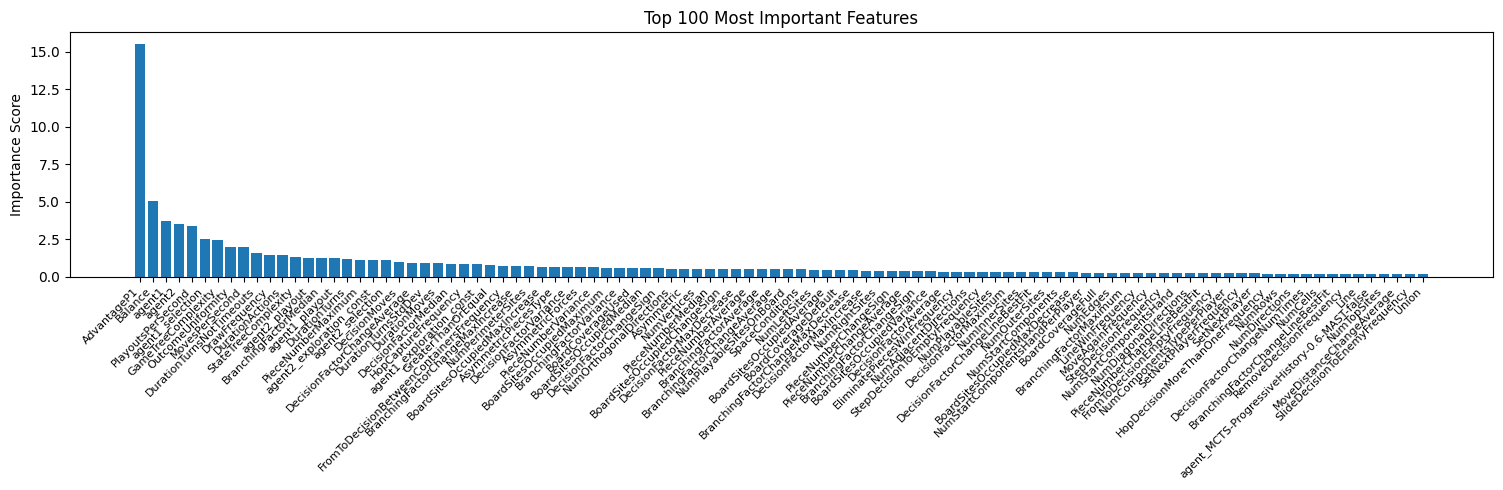

Fold 3 - RMSE: 0.42152340257738047
Fold 4


0:	learn: 0.6211083	test: 0.6061256	best: 0.6061256 (0)	total: 95.4ms	remaining: 15m 54s


50:	learn: 0.4885353	test: 0.5445705	best: 0.5445705 (50)	total: 5.53s	remaining: 17m 58s


100:	learn: 0.4440551	test: 0.5176742	best: 0.5176742 (100)	total: 11.2s	remaining: 18m 18s


150:	learn: 0.4189893	test: 0.4985013	best: 0.4985013 (150)	total: 17.1s	remaining: 18m 35s


200:	learn: 0.4009879	test: 0.4854596	best: 0.4854596 (200)	total: 23.1s	remaining: 18m 44s


250:	learn: 0.3879063	test: 0.4772452	best: 0.4772452 (250)	total: 29.1s	remaining: 18m 48s


300:	learn: 0.3765883	test: 0.4706253	best: 0.4706253 (300)	total: 35.2s	remaining: 18m 54s


350:	learn: 0.3676289	test: 0.4663955	best: 0.4663955 (350)	total: 41.4s	remaining: 18m 57s


400:	learn: 0.3606345	test: 0.4638050	best: 0.4638050 (400)	total: 47.8s	remaining: 19m 3s


450:	learn: 0.3540449	test: 0.4608730	best: 0.4608730 (450)	total: 54s	remaining: 19m 2s


500:	learn: 0.3480710	test: 0.4579328	best: 0.4579328 (500)	total: 1m	remaining: 18m 59s


550:	learn: 0.3427247	test: 0.4556450	best: 0.4556450 (550)	total: 1m 6s	remaining: 18m 56s


600:	learn: 0.3381103	test: 0.4536783	best: 0.4536783 (600)	total: 1m 12s	remaining: 18m 51s


650:	learn: 0.3338430	test: 0.4520011	best: 0.4520011 (650)	total: 1m 18s	remaining: 18m 47s


700:	learn: 0.3299000	test: 0.4507424	best: 0.4507424 (700)	total: 1m 24s	remaining: 18m 42s


750:	learn: 0.3262886	test: 0.4496745	best: 0.4496745 (750)	total: 1m 30s	remaining: 18m 38s


800:	learn: 0.3227160	test: 0.4484506	best: 0.4484506 (800)	total: 1m 36s	remaining: 18m 33s


850:	learn: 0.3193719	test: 0.4476236	best: 0.4476236 (850)	total: 1m 43s	remaining: 18m 28s


900:	learn: 0.3161770	test: 0.4468933	best: 0.4468933 (900)	total: 1m 49s	remaining: 18m 23s


950:	learn: 0.3133204	test: 0.4462319	best: 0.4462319 (950)	total: 1m 55s	remaining: 18m 19s


1000:	learn: 0.3106442	test: 0.4455725	best: 0.4455725 (1000)	total: 2m 1s	remaining: 18m 13s


1050:	learn: 0.3080665	test: 0.4448114	best: 0.4448114 (1050)	total: 2m 7s	remaining: 18m 9s


1100:	learn: 0.3054515	test: 0.4442996	best: 0.4442995 (1099)	total: 2m 14s	remaining: 18m 3s


1150:	learn: 0.3029244	test: 0.4434273	best: 0.4434273 (1150)	total: 2m 20s	remaining: 17m 57s


1200:	learn: 0.3005164	test: 0.4428794	best: 0.4428794 (1200)	total: 2m 26s	remaining: 17m 51s


1250:	learn: 0.2983627	test: 0.4424276	best: 0.4424082 (1248)	total: 2m 32s	remaining: 17m 46s


1300:	learn: 0.2963148	test: 0.4418885	best: 0.4418885 (1300)	total: 2m 38s	remaining: 17m 40s


1350:	learn: 0.2941124	test: 0.4414047	best: 0.4414045 (1349)	total: 2m 44s	remaining: 17m 34s


1400:	learn: 0.2920768	test: 0.4409925	best: 0.4409925 (1400)	total: 2m 50s	remaining: 17m 27s


1450:	learn: 0.2902105	test: 0.4406750	best: 0.4406747 (1449)	total: 2m 56s	remaining: 17m 21s


1500:	learn: 0.2884635	test: 0.4404306	best: 0.4404306 (1500)	total: 3m 2s	remaining: 17m 15s


1550:	learn: 0.2867561	test: 0.4401427	best: 0.4401427 (1550)	total: 3m 9s	remaining: 17m 9s


1600:	learn: 0.2850577	test: 0.4397593	best: 0.4397512 (1597)	total: 3m 15s	remaining: 17m 3s


1650:	learn: 0.2832876	test: 0.4394279	best: 0.4394279 (1650)	total: 3m 21s	remaining: 16m 57s


1700:	learn: 0.2815327	test: 0.4390991	best: 0.4390880 (1699)	total: 3m 27s	remaining: 16m 51s


1750:	learn: 0.2800823	test: 0.4389166	best: 0.4389095 (1749)	total: 3m 33s	remaining: 16m 45s


1800:	learn: 0.2785037	test: 0.4386413	best: 0.4386413 (1800)	total: 3m 39s	remaining: 16m 39s


1850:	learn: 0.2770623	test: 0.4384067	best: 0.4383960 (1839)	total: 3m 45s	remaining: 16m 33s


1900:	learn: 0.2756331	test: 0.4382030	best: 0.4382024 (1899)	total: 3m 51s	remaining: 16m 27s


1950:	learn: 0.2743437	test: 0.4380599	best: 0.4380599 (1950)	total: 3m 57s	remaining: 16m 21s


2000:	learn: 0.2730192	test: 0.4379472	best: 0.4379280 (1992)	total: 4m 4s	remaining: 16m 15s


2050:	learn: 0.2717322	test: 0.4378847	best: 0.4378631 (2049)	total: 4m 10s	remaining: 16m 9s


2100:	learn: 0.2705056	test: 0.4377146	best: 0.4377146 (2100)	total: 4m 16s	remaining: 16m 3s


2150:	learn: 0.2692328	test: 0.4374548	best: 0.4374538 (2147)	total: 4m 22s	remaining: 15m 57s


2200:	learn: 0.2679547	test: 0.4372539	best: 0.4372479 (2198)	total: 4m 28s	remaining: 15m 51s


2250:	learn: 0.2667309	test: 0.4369899	best: 0.4369899 (2250)	total: 4m 34s	remaining: 15m 45s


2300:	learn: 0.2655817	test: 0.4368047	best: 0.4368037 (2299)	total: 4m 41s	remaining: 15m 40s


2350:	learn: 0.2644537	test: 0.4365513	best: 0.4365513 (2350)	total: 4m 47s	remaining: 15m 34s


2400:	learn: 0.2633742	test: 0.4364292	best: 0.4364217 (2384)	total: 4m 53s	remaining: 15m 28s


2450:	learn: 0.2623563	test: 0.4362186	best: 0.4362183 (2447)	total: 4m 59s	remaining: 15m 22s


2500:	learn: 0.2612577	test: 0.4361010	best: 0.4360907 (2496)	total: 5m 5s	remaining: 15m 16s


2550:	learn: 0.2602445	test: 0.4359294	best: 0.4359222 (2541)	total: 5m 11s	remaining: 15m 10s


2600:	learn: 0.2592330	test: 0.4357805	best: 0.4357805 (2600)	total: 5m 17s	remaining: 15m 4s


2650:	learn: 0.2581950	test: 0.4356379	best: 0.4356379 (2650)	total: 5m 24s	remaining: 14m 58s


2700:	learn: 0.2572533	test: 0.4354885	best: 0.4354885 (2700)	total: 5m 30s	remaining: 14m 52s


2750:	learn: 0.2563781	test: 0.4353300	best: 0.4353300 (2750)	total: 5m 36s	remaining: 14m 46s


2800:	learn: 0.2554666	test: 0.4352132	best: 0.4352109 (2798)	total: 5m 42s	remaining: 14m 41s


2850:	learn: 0.2546261	test: 0.4351338	best: 0.4351291 (2842)	total: 5m 49s	remaining: 14m 35s


2900:	learn: 0.2536641	test: 0.4350781	best: 0.4350670 (2895)	total: 5m 55s	remaining: 14m 29s


2950:	learn: 0.2527424	test: 0.4349309	best: 0.4349309 (2950)	total: 6m 1s	remaining: 14m 23s


3000:	learn: 0.2518528	test: 0.4348023	best: 0.4347991 (2999)	total: 6m 7s	remaining: 14m 17s


3050:	learn: 0.2510248	test: 0.4346791	best: 0.4346791 (3050)	total: 6m 13s	remaining: 14m 11s


3100:	learn: 0.2502096	test: 0.4345486	best: 0.4345379 (3099)	total: 6m 20s	remaining: 14m 5s


3150:	learn: 0.2493790	test: 0.4343516	best: 0.4343516 (3150)	total: 6m 26s	remaining: 13m 59s


3200:	learn: 0.2486068	test: 0.4343004	best: 0.4342921 (3195)	total: 6m 32s	remaining: 13m 53s


3250:	learn: 0.2478071	test: 0.4342140	best: 0.4342062 (3245)	total: 6m 38s	remaining: 13m 47s


3300:	learn: 0.2470245	test: 0.4341498	best: 0.4341498 (3300)	total: 6m 44s	remaining: 13m 41s


3350:	learn: 0.2462968	test: 0.4340931	best: 0.4340931 (3350)	total: 6m 51s	remaining: 13m 35s


3400:	learn: 0.2455040	test: 0.4340330	best: 0.4340273 (3399)	total: 6m 57s	remaining: 13m 29s


3450:	learn: 0.2447509	test: 0.4339679	best: 0.4339679 (3450)	total: 7m 3s	remaining: 13m 23s


3500:	learn: 0.2440184	test: 0.4338664	best: 0.4338664 (3500)	total: 7m 9s	remaining: 13m 17s


3550:	learn: 0.2433493	test: 0.4337699	best: 0.4337699 (3550)	total: 7m 15s	remaining: 13m 11s


3600:	learn: 0.2426821	test: 0.4337102	best: 0.4337102 (3600)	total: 7m 22s	remaining: 13m 5s


3650:	learn: 0.2419905	test: 0.4336226	best: 0.4336208 (3649)	total: 7m 28s	remaining: 12m 59s


3700:	learn: 0.2413440	test: 0.4335665	best: 0.4335537 (3699)	total: 7m 34s	remaining: 12m 53s


3750:	learn: 0.2407011	test: 0.4335275	best: 0.4335214 (3747)	total: 7m 40s	remaining: 12m 46s


3800:	learn: 0.2399879	test: 0.4334460	best: 0.4334280 (3794)	total: 7m 46s	remaining: 12m 40s


3850:	learn: 0.2393325	test: 0.4334153	best: 0.4334153 (3850)	total: 7m 52s	remaining: 12m 34s


3900:	learn: 0.2386560	test: 0.4333446	best: 0.4333403 (3899)	total: 7m 58s	remaining: 12m 28s


3950:	learn: 0.2380140	test: 0.4332763	best: 0.4332650 (3946)	total: 8m 5s	remaining: 12m 22s


4000:	learn: 0.2373587	test: 0.4332621	best: 0.4332572 (3997)	total: 8m 11s	remaining: 12m 16s


4050:	learn: 0.2368115	test: 0.4332009	best: 0.4332000 (4049)	total: 8m 17s	remaining: 12m 10s


4100:	learn: 0.2361712	test: 0.4331139	best: 0.4331026 (4092)	total: 8m 23s	remaining: 12m 4s


4150:	learn: 0.2355970	test: 0.4330189	best: 0.4330189 (4150)	total: 8m 30s	remaining: 11m 58s


4200:	learn: 0.2350222	test: 0.4329768	best: 0.4329768 (4200)	total: 8m 36s	remaining: 11m 52s


4250:	learn: 0.2344438	test: 0.4329223	best: 0.4329223 (4250)	total: 8m 42s	remaining: 11m 46s


4300:	learn: 0.2338794	test: 0.4328805	best: 0.4328805 (4300)	total: 8m 48s	remaining: 11m 40s


4350:	learn: 0.2333332	test: 0.4327707	best: 0.4327661 (4349)	total: 8m 54s	remaining: 11m 34s


4400:	learn: 0.2327852	test: 0.4327365	best: 0.4327365 (4400)	total: 9m 1s	remaining: 11m 28s


4450:	learn: 0.2321983	test: 0.4326676	best: 0.4326601 (4448)	total: 9m 7s	remaining: 11m 22s


4500:	learn: 0.2316912	test: 0.4326152	best: 0.4326139 (4499)	total: 9m 13s	remaining: 11m 16s


4550:	learn: 0.2311326	test: 0.4325633	best: 0.4325593 (4549)	total: 9m 19s	remaining: 11m 10s


4600:	learn: 0.2305748	test: 0.4325077	best: 0.4325077 (4600)	total: 9m 26s	remaining: 11m 4s


4650:	learn: 0.2300442	test: 0.4324648	best: 0.4324615 (4623)	total: 9m 32s	remaining: 10m 58s


4700:	learn: 0.2295083	test: 0.4324119	best: 0.4324119 (4700)	total: 9m 38s	remaining: 10m 51s


4750:	learn: 0.2289999	test: 0.4324039	best: 0.4324039 (4750)	total: 9m 44s	remaining: 10m 45s


4800:	learn: 0.2284791	test: 0.4323525	best: 0.4323501 (4794)	total: 9m 50s	remaining: 10m 39s


4850:	learn: 0.2279557	test: 0.4323330	best: 0.4323308 (4848)	total: 9m 57s	remaining: 10m 33s


4900:	learn: 0.2275013	test: 0.4322821	best: 0.4322821 (4900)	total: 10m 3s	remaining: 10m 27s


4950:	learn: 0.2270137	test: 0.4322282	best: 0.4322282 (4950)	total: 10m 9s	remaining: 10m 21s


5000:	learn: 0.2264842	test: 0.4321867	best: 0.4321839 (4996)	total: 10m 15s	remaining: 10m 15s


5050:	learn: 0.2259684	test: 0.4321396	best: 0.4321356 (5046)	total: 10m 22s	remaining: 10m 9s


5100:	learn: 0.2254647	test: 0.4320710	best: 0.4320674 (5098)	total: 10m 28s	remaining: 10m 3s


5150:	learn: 0.2249911	test: 0.4320185	best: 0.4320147 (5147)	total: 10m 34s	remaining: 9m 57s


5200:	learn: 0.2245348	test: 0.4319741	best: 0.4319741 (5200)	total: 10m 40s	remaining: 9m 51s


5250:	learn: 0.2240315	test: 0.4319357	best: 0.4319341 (5249)	total: 10m 46s	remaining: 9m 45s


5300:	learn: 0.2235451	test: 0.4318743	best: 0.4318743 (5300)	total: 10m 53s	remaining: 9m 38s


5350:	learn: 0.2230212	test: 0.4318803	best: 0.4318738 (5301)	total: 10m 59s	remaining: 9m 32s


5400:	learn: 0.2225072	test: 0.4318170	best: 0.4318102 (5397)	total: 11m 5s	remaining: 9m 26s


5450:	learn: 0.2220344	test: 0.4317711	best: 0.4317709 (5449)	total: 11m 11s	remaining: 9m 20s


5500:	learn: 0.2215582	test: 0.4317533	best: 0.4317464 (5477)	total: 11m 17s	remaining: 9m 14s


5550:	learn: 0.2211215	test: 0.4317086	best: 0.4317086 (5550)	total: 11m 24s	remaining: 9m 8s


5600:	learn: 0.2206536	test: 0.4316634	best: 0.4316598 (5593)	total: 11m 30s	remaining: 9m 2s


5650:	learn: 0.2202181	test: 0.4316333	best: 0.4316333 (5650)	total: 11m 36s	remaining: 8m 56s


5700:	learn: 0.2198013	test: 0.4315741	best: 0.4315741 (5692)	total: 11m 42s	remaining: 8m 50s


5750:	learn: 0.2193222	test: 0.4315033	best: 0.4315014 (5749)	total: 11m 49s	remaining: 8m 44s


5800:	learn: 0.2188951	test: 0.4314574	best: 0.4314570 (5799)	total: 11m 55s	remaining: 8m 37s


5850:	learn: 0.2184692	test: 0.4314608	best: 0.4314407 (5828)	total: 12m 1s	remaining: 8m 31s


5900:	learn: 0.2180334	test: 0.4314475	best: 0.4314407 (5828)	total: 12m 7s	remaining: 8m 25s


5950:	learn: 0.2175711	test: 0.4314163	best: 0.4314133 (5939)	total: 12m 14s	remaining: 8m 19s


6000:	learn: 0.2171163	test: 0.4313854	best: 0.4313851 (5999)	total: 12m 20s	remaining: 8m 13s


6050:	learn: 0.2167020	test: 0.4313503	best: 0.4313503 (6050)	total: 12m 26s	remaining: 8m 7s


6100:	learn: 0.2162554	test: 0.4313665	best: 0.4313322 (6071)	total: 12m 32s	remaining: 8m 1s


6150:	learn: 0.2158601	test: 0.4313403	best: 0.4313246 (6129)	total: 12m 39s	remaining: 7m 54s


6200:	learn: 0.2153968	test: 0.4312974	best: 0.4312974 (6200)	total: 12m 45s	remaining: 7m 48s


6250:	learn: 0.2149774	test: 0.4312603	best: 0.4312591 (6248)	total: 12m 51s	remaining: 7m 42s


6300:	learn: 0.2145581	test: 0.4312202	best: 0.4312188 (6299)	total: 12m 57s	remaining: 7m 36s


6350:	learn: 0.2141541	test: 0.4311890	best: 0.4311840 (6345)	total: 13m 4s	remaining: 7m 30s


6400:	learn: 0.2137588	test: 0.4311252	best: 0.4311252 (6400)	total: 13m 10s	remaining: 7m 24s


6450:	learn: 0.2133707	test: 0.4310523	best: 0.4310523 (6450)	total: 13m 16s	remaining: 7m 18s


6500:	learn: 0.2129067	test: 0.4310477	best: 0.4310458 (6495)	total: 13m 22s	remaining: 7m 12s


6550:	learn: 0.2124974	test: 0.4310034	best: 0.4310034 (6550)	total: 13m 29s	remaining: 7m 5s


6600:	learn: 0.2120708	test: 0.4309880	best: 0.4309820 (6580)	total: 13m 35s	remaining: 6m 59s


6650:	learn: 0.2116702	test: 0.4309641	best: 0.4309571 (6645)	total: 13m 41s	remaining: 6m 53s


6700:	learn: 0.2112692	test: 0.4309430	best: 0.4309430 (6700)	total: 13m 47s	remaining: 6m 47s


6750:	learn: 0.2108828	test: 0.4309272	best: 0.4309227 (6737)	total: 13m 54s	remaining: 6m 41s


6800:	learn: 0.2104749	test: 0.4308639	best: 0.4308639 (6800)	total: 14m	remaining: 6m 35s


6850:	learn: 0.2100948	test: 0.4308094	best: 0.4308055 (6838)	total: 14m 6s	remaining: 6m 29s


6900:	learn: 0.2096970	test: 0.4307782	best: 0.4307760 (6897)	total: 14m 13s	remaining: 6m 23s


6950:	learn: 0.2092630	test: 0.4307263	best: 0.4307263 (6950)	total: 14m 19s	remaining: 6m 17s


7000:	learn: 0.2088881	test: 0.4306637	best: 0.4306637 (7000)	total: 14m 25s	remaining: 6m 10s


7050:	learn: 0.2084922	test: 0.4306317	best: 0.4306295 (7046)	total: 14m 32s	remaining: 6m 4s


7100:	learn: 0.2081409	test: 0.4305728	best: 0.4305728 (7100)	total: 14m 38s	remaining: 5m 58s


7150:	learn: 0.2077910	test: 0.4305812	best: 0.4305709 (7139)	total: 14m 44s	remaining: 5m 52s


7200:	learn: 0.2074120	test: 0.4305400	best: 0.4305400 (7200)	total: 14m 50s	remaining: 5m 46s


7250:	learn: 0.2070524	test: 0.4305097	best: 0.4305072 (7239)	total: 14m 57s	remaining: 5m 40s


7300:	learn: 0.2066790	test: 0.4304974	best: 0.4304955 (7298)	total: 15m 3s	remaining: 5m 33s


7350:	learn: 0.2063304	test: 0.4304697	best: 0.4304691 (7348)	total: 15m 9s	remaining: 5m 27s


7400:	learn: 0.2059433	test: 0.4304693	best: 0.4304600 (7361)	total: 15m 15s	remaining: 5m 21s


7450:	learn: 0.2055892	test: 0.4304326	best: 0.4304316 (7449)	total: 15m 22s	remaining: 5m 15s


7500:	learn: 0.2052377	test: 0.4304248	best: 0.4304163 (7492)	total: 15m 28s	remaining: 5m 9s


7550:	learn: 0.2049058	test: 0.4304106	best: 0.4304048 (7518)	total: 15m 34s	remaining: 5m 3s


7600:	learn: 0.2045177	test: 0.4303955	best: 0.4303912 (7591)	total: 15m 40s	remaining: 4m 56s


7650:	learn: 0.2041345	test: 0.4303502	best: 0.4303502 (7650)	total: 15m 46s	remaining: 4m 50s


7700:	learn: 0.2037519	test: 0.4303343	best: 0.4303280 (7694)	total: 15m 53s	remaining: 4m 44s


7750:	learn: 0.2034057	test: 0.4302926	best: 0.4302926 (7750)	total: 15m 59s	remaining: 4m 38s


7800:	learn: 0.2030724	test: 0.4302718	best: 0.4302718 (7800)	total: 16m 5s	remaining: 4m 32s


7850:	learn: 0.2027039	test: 0.4302179	best: 0.4302179 (7850)	total: 16m 11s	remaining: 4m 25s


7900:	learn: 0.2023683	test: 0.4301913	best: 0.4301913 (7900)	total: 16m 17s	remaining: 4m 19s


7950:	learn: 0.2020211	test: 0.4301735	best: 0.4301721 (7949)	total: 16m 24s	remaining: 4m 13s


8000:	learn: 0.2016855	test: 0.4301448	best: 0.4301448 (8000)	total: 16m 30s	remaining: 4m 7s


8050:	learn: 0.2013218	test: 0.4301342	best: 0.4301335 (8049)	total: 16m 36s	remaining: 4m 1s


8100:	learn: 0.2009856	test: 0.4301292	best: 0.4301176 (8070)	total: 16m 42s	remaining: 3m 55s


8150:	learn: 0.2006067	test: 0.4301187	best: 0.4301112 (8140)	total: 16m 48s	remaining: 3m 48s


8200:	learn: 0.2002655	test: 0.4300705	best: 0.4300705 (8200)	total: 16m 55s	remaining: 3m 42s


8250:	learn: 0.1999476	test: 0.4300622	best: 0.4300569 (8242)	total: 17m 1s	remaining: 3m 36s


8300:	learn: 0.1996095	test: 0.4300528	best: 0.4300451 (8296)	total: 17m 7s	remaining: 3m 30s


8350:	learn: 0.1992749	test: 0.4300043	best: 0.4300043 (8350)	total: 17m 13s	remaining: 3m 24s


8400:	learn: 0.1989434	test: 0.4299666	best: 0.4299636 (8399)	total: 17m 19s	remaining: 3m 17s


8450:	learn: 0.1986290	test: 0.4299447	best: 0.4299422 (8445)	total: 17m 26s	remaining: 3m 11s


8500:	learn: 0.1983083	test: 0.4299211	best: 0.4299211 (8500)	total: 17m 32s	remaining: 3m 5s


8550:	learn: 0.1979716	test: 0.4299281	best: 0.4299135 (8528)	total: 17m 38s	remaining: 2m 59s


8600:	learn: 0.1976226	test: 0.4298736	best: 0.4298726 (8598)	total: 17m 44s	remaining: 2m 53s


8650:	learn: 0.1973199	test: 0.4298543	best: 0.4298543 (8650)	total: 17m 50s	remaining: 2m 46s


8700:	learn: 0.1969977	test: 0.4298635	best: 0.4298527 (8653)	total: 17m 57s	remaining: 2m 40s


8750:	learn: 0.1966594	test: 0.4298506	best: 0.4298430 (8733)	total: 18m 3s	remaining: 2m 34s


8800:	learn: 0.1963362	test: 0.4298305	best: 0.4298298 (8797)	total: 18m 9s	remaining: 2m 28s


8850:	learn: 0.1960268	test: 0.4298261	best: 0.4298204 (8832)	total: 18m 15s	remaining: 2m 22s


8900:	learn: 0.1956980	test: 0.4298058	best: 0.4298058 (8900)	total: 18m 21s	remaining: 2m 16s


8950:	learn: 0.1953791	test: 0.4297845	best: 0.4297845 (8945)	total: 18m 28s	remaining: 2m 9s


9000:	learn: 0.1950430	test: 0.4297648	best: 0.4297626 (8996)	total: 18m 34s	remaining: 2m 3s


9050:	learn: 0.1947426	test: 0.4297485	best: 0.4297430 (9024)	total: 18m 40s	remaining: 1m 57s


9100:	learn: 0.1944591	test: 0.4297252	best: 0.4297251 (9098)	total: 18m 46s	remaining: 1m 51s


9150:	learn: 0.1941462	test: 0.4296839	best: 0.4296839 (9150)	total: 18m 52s	remaining: 1m 45s


9200:	learn: 0.1938794	test: 0.4297002	best: 0.4296839 (9150)	total: 18m 59s	remaining: 1m 38s


9250:	learn: 0.1935692	test: 0.4296902	best: 0.4296839 (9150)	total: 19m 5s	remaining: 1m 32s


9300:	learn: 0.1932523	test: 0.4296992	best: 0.4296839 (9150)	total: 19m 11s	remaining: 1m 26s


9350:	learn: 0.1929431	test: 0.4296561	best: 0.4296561 (9350)	total: 19m 17s	remaining: 1m 20s


9400:	learn: 0.1926460	test: 0.4296296	best: 0.4296296 (9400)	total: 19m 23s	remaining: 1m 14s


9450:	learn: 0.1923570	test: 0.4296313	best: 0.4296245 (9439)	total: 19m 30s	remaining: 1m 7s


9500:	learn: 0.1920640	test: 0.4296179	best: 0.4296174 (9488)	total: 19m 36s	remaining: 1m 1s


9550:	learn: 0.1917526	test: 0.4296078	best: 0.4296035 (9529)	total: 19m 42s	remaining: 55.6s


9600:	learn: 0.1914373	test: 0.4296200	best: 0.4296035 (9529)	total: 19m 48s	remaining: 49.4s


9650:	learn: 0.1911354	test: 0.4295902	best: 0.4295869 (9647)	total: 19m 54s	remaining: 43.2s


9700:	learn: 0.1908281	test: 0.4295628	best: 0.4295608 (9695)	total: 20m	remaining: 37s


9750:	learn: 0.1905326	test: 0.4295364	best: 0.4295364 (9750)	total: 20m 7s	remaining: 30.8s


9800:	learn: 0.1902256	test: 0.4295171	best: 0.4295171 (9800)	total: 20m 13s	remaining: 24.6s


9850:	learn: 0.1899343	test: 0.4294923	best: 0.4294923 (9850)	total: 20m 19s	remaining: 18.4s


9900:	learn: 0.1896155	test: 0.4294754	best: 0.4294754 (9900)	total: 20m 25s	remaining: 12.3s


9950:	learn: 0.1893260	test: 0.4294484	best: 0.4294484 (9950)	total: 20m 31s	remaining: 6.07s


9999:	learn: 0.1890405	test: 0.4294317	best: 0.4294291 (9978)	total: 20m 37s	remaining: 0us

bestTest = 0.4294290837
bestIteration = 9978

Shrink model to first 9979 iterations.


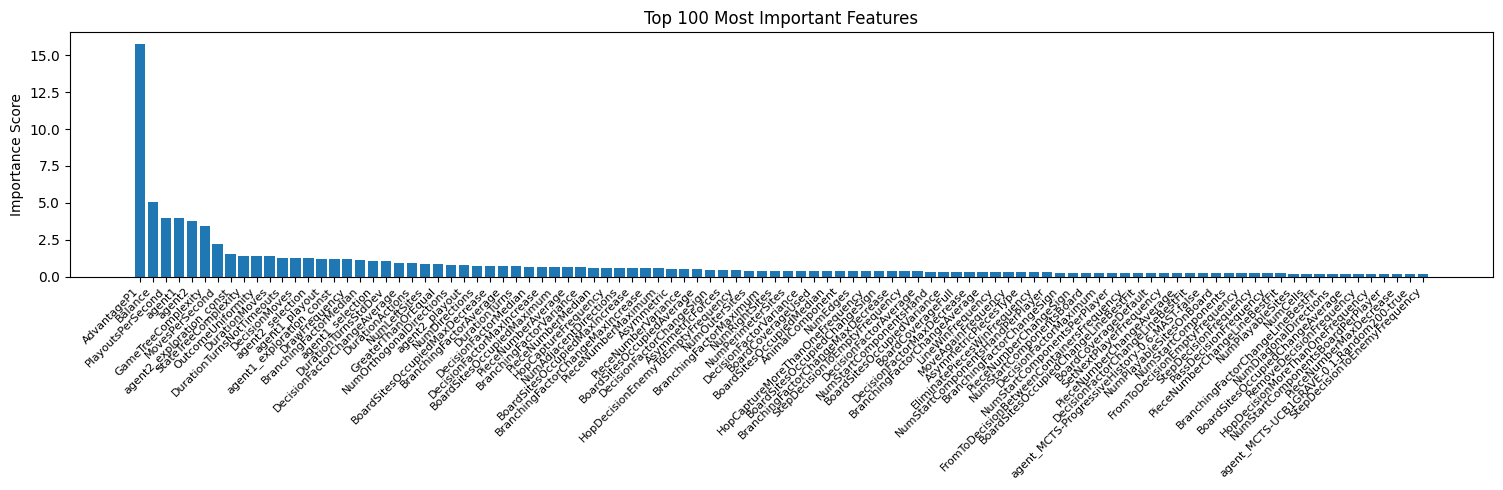

Fold 4 - RMSE: 0.42906281992199713
Fold 5


0:	learn: 0.6238561	test: 0.5916219	best: 0.5916219 (0)	total: 78.9ms	remaining: 13m 9s


50:	learn: 0.4883207	test: 0.5438866	best: 0.5438866 (50)	total: 5.51s	remaining: 17m 55s


100:	learn: 0.4410288	test: 0.5203410	best: 0.5203410 (100)	total: 11s	remaining: 18m 2s


150:	learn: 0.4161935	test: 0.5029748	best: 0.5029748 (150)	total: 16.9s	remaining: 18m 19s


200:	learn: 0.3975883	test: 0.4911316	best: 0.4911316 (200)	total: 22.8s	remaining: 18m 31s


250:	learn: 0.3839113	test: 0.4827009	best: 0.4827009 (250)	total: 28.8s	remaining: 18m 37s


300:	learn: 0.3730556	test: 0.4764543	best: 0.4764543 (300)	total: 34.8s	remaining: 18m 40s


350:	learn: 0.3645905	test: 0.4718391	best: 0.4718391 (350)	total: 40.8s	remaining: 18m 42s


400:	learn: 0.3574287	test: 0.4680684	best: 0.4680684 (400)	total: 46.9s	remaining: 18m 43s


450:	learn: 0.3511968	test: 0.4653210	best: 0.4653094 (449)	total: 53s	remaining: 18m 42s


500:	learn: 0.3455126	test: 0.4623294	best: 0.4623294 (500)	total: 59s	remaining: 18m 38s


550:	learn: 0.3401095	test: 0.4596109	best: 0.4596109 (550)	total: 1m 4s	remaining: 18m 34s


600:	learn: 0.3349803	test: 0.4573984	best: 0.4573984 (600)	total: 1m 10s	remaining: 18m 30s


650:	learn: 0.3304841	test: 0.4553252	best: 0.4553252 (650)	total: 1m 16s	remaining: 18m 25s


700:	learn: 0.3264283	test: 0.4537293	best: 0.4537293 (700)	total: 1m 22s	remaining: 18m 20s


750:	learn: 0.3224630	test: 0.4521967	best: 0.4521967 (750)	total: 1m 28s	remaining: 18m 15s


800:	learn: 0.3189608	test: 0.4506182	best: 0.4506182 (800)	total: 1m 34s	remaining: 18m 9s


850:	learn: 0.3156647	test: 0.4496447	best: 0.4496447 (850)	total: 1m 40s	remaining: 18m 4s


900:	learn: 0.3124264	test: 0.4485488	best: 0.4485488 (900)	total: 1m 46s	remaining: 17m 59s


950:	learn: 0.3095482	test: 0.4476508	best: 0.4476508 (950)	total: 1m 52s	remaining: 17m 53s


1000:	learn: 0.3069271	test: 0.4469643	best: 0.4469643 (1000)	total: 1m 58s	remaining: 17m 48s


1050:	learn: 0.3045540	test: 0.4463059	best: 0.4463059 (1050)	total: 2m 4s	remaining: 17m 42s


1100:	learn: 0.3022117	test: 0.4456218	best: 0.4456218 (1100)	total: 2m 10s	remaining: 17m 37s


1150:	learn: 0.2998609	test: 0.4448820	best: 0.4448820 (1150)	total: 2m 16s	remaining: 17m 31s


1200:	learn: 0.2977951	test: 0.4441319	best: 0.4441319 (1200)	total: 2m 22s	remaining: 17m 26s


1250:	learn: 0.2957407	test: 0.4436317	best: 0.4436317 (1250)	total: 2m 28s	remaining: 17m 21s


1300:	learn: 0.2936686	test: 0.4433212	best: 0.4433212 (1300)	total: 2m 34s	remaining: 17m 15s


1350:	learn: 0.2915143	test: 0.4427217	best: 0.4427217 (1350)	total: 2m 40s	remaining: 17m 10s


1400:	learn: 0.2896234	test: 0.4422422	best: 0.4422366 (1396)	total: 2m 46s	remaining: 17m 4s


1450:	learn: 0.2877347	test: 0.4417709	best: 0.4417709 (1450)	total: 2m 52s	remaining: 16m 59s


1500:	learn: 0.2858818	test: 0.4413269	best: 0.4413247 (1498)	total: 2m 59s	remaining: 16m 54s


1550:	learn: 0.2840809	test: 0.4408271	best: 0.4408159 (1549)	total: 3m 5s	remaining: 16m 48s


1600:	learn: 0.2824326	test: 0.4403877	best: 0.4403839 (1596)	total: 3m 11s	remaining: 16m 43s


1650:	learn: 0.2808640	test: 0.4400099	best: 0.4400099 (1650)	total: 3m 17s	remaining: 16m 37s


1700:	learn: 0.2792906	test: 0.4394940	best: 0.4394940 (1700)	total: 3m 23s	remaining: 16m 32s


1750:	learn: 0.2776575	test: 0.4390870	best: 0.4390870 (1750)	total: 3m 29s	remaining: 16m 26s


1800:	learn: 0.2761614	test: 0.4387075	best: 0.4387075 (1800)	total: 3m 35s	remaining: 16m 20s


1850:	learn: 0.2747226	test: 0.4384921	best: 0.4384921 (1850)	total: 3m 41s	remaining: 16m 14s


1900:	learn: 0.2733633	test: 0.4381353	best: 0.4381353 (1900)	total: 3m 47s	remaining: 16m 9s


1950:	learn: 0.2718478	test: 0.4377796	best: 0.4377796 (1950)	total: 3m 53s	remaining: 16m 3s


2000:	learn: 0.2705337	test: 0.4374819	best: 0.4374819 (2000)	total: 3m 59s	remaining: 15m 57s


2050:	learn: 0.2693049	test: 0.4371418	best: 0.4371418 (2050)	total: 4m 5s	remaining: 15m 52s


2100:	learn: 0.2680670	test: 0.4368673	best: 0.4368673 (2100)	total: 4m 11s	remaining: 15m 46s


2150:	learn: 0.2668195	test: 0.4367269	best: 0.4367116 (2142)	total: 4m 17s	remaining: 15m 40s


2200:	learn: 0.2655116	test: 0.4364815	best: 0.4364702 (2199)	total: 4m 23s	remaining: 15m 34s


2250:	learn: 0.2643560	test: 0.4362308	best: 0.4362308 (2250)	total: 4m 29s	remaining: 15m 28s


2300:	learn: 0.2632513	test: 0.4360753	best: 0.4360753 (2300)	total: 4m 35s	remaining: 15m 22s


2350:	learn: 0.2620938	test: 0.4358362	best: 0.4358353 (2349)	total: 4m 41s	remaining: 15m 16s


2400:	learn: 0.2609479	test: 0.4355998	best: 0.4355998 (2400)	total: 4m 47s	remaining: 15m 11s


2450:	learn: 0.2598828	test: 0.4354333	best: 0.4354333 (2450)	total: 4m 53s	remaining: 15m 5s


2500:	learn: 0.2587931	test: 0.4352560	best: 0.4352530 (2499)	total: 5m	remaining: 14m 59s


2550:	learn: 0.2577753	test: 0.4350970	best: 0.4350966 (2542)	total: 5m 6s	remaining: 14m 53s


2600:	learn: 0.2566030	test: 0.4349403	best: 0.4349403 (2600)	total: 5m 12s	remaining: 14m 47s


2650:	learn: 0.2556547	test: 0.4347475	best: 0.4347475 (2650)	total: 5m 18s	remaining: 14m 42s


2700:	learn: 0.2546608	test: 0.4346488	best: 0.4346203 (2694)	total: 5m 24s	remaining: 14m 36s


2750:	learn: 0.2537188	test: 0.4344591	best: 0.4344591 (2750)	total: 5m 30s	remaining: 14m 30s


2800:	learn: 0.2527630	test: 0.4342797	best: 0.4342781 (2798)	total: 5m 36s	remaining: 14m 24s


2850:	learn: 0.2518219	test: 0.4340826	best: 0.4340820 (2849)	total: 5m 42s	remaining: 14m 19s


2900:	learn: 0.2510058	test: 0.4339676	best: 0.4339602 (2896)	total: 5m 48s	remaining: 14m 13s


2950:	learn: 0.2500422	test: 0.4338192	best: 0.4338192 (2950)	total: 5m 54s	remaining: 14m 7s


3000:	learn: 0.2491566	test: 0.4337045	best: 0.4337029 (2995)	total: 6m	remaining: 14m 1s


3050:	learn: 0.2483606	test: 0.4335708	best: 0.4335643 (3049)	total: 6m 6s	remaining: 13m 55s


3100:	learn: 0.2474616	test: 0.4334523	best: 0.4334509 (3099)	total: 6m 12s	remaining: 13m 49s


3150:	learn: 0.2466327	test: 0.4333121	best: 0.4333109 (3147)	total: 6m 19s	remaining: 13m 43s


3200:	learn: 0.2458857	test: 0.4331884	best: 0.4331875 (3199)	total: 6m 25s	remaining: 13m 38s


3250:	learn: 0.2451156	test: 0.4331099	best: 0.4331047 (3247)	total: 6m 31s	remaining: 13m 32s


3300:	learn: 0.2443510	test: 0.4329496	best: 0.4329496 (3300)	total: 6m 37s	remaining: 13m 26s


3350:	learn: 0.2435698	test: 0.4328148	best: 0.4328148 (3350)	total: 6m 43s	remaining: 13m 20s


3400:	learn: 0.2428201	test: 0.4327218	best: 0.4327201 (3399)	total: 6m 49s	remaining: 13m 14s


3450:	learn: 0.2420742	test: 0.4325967	best: 0.4325908 (3448)	total: 6m 55s	remaining: 13m 9s


3500:	learn: 0.2413326	test: 0.4325029	best: 0.4324974 (3492)	total: 7m 1s	remaining: 13m 3s


3550:	learn: 0.2405590	test: 0.4324072	best: 0.4324042 (3547)	total: 7m 7s	remaining: 12m 57s


3600:	learn: 0.2398593	test: 0.4323443	best: 0.4323427 (3595)	total: 7m 13s	remaining: 12m 51s


3650:	learn: 0.2391136	test: 0.4322492	best: 0.4322438 (3646)	total: 7m 19s	remaining: 12m 45s


3700:	learn: 0.2383673	test: 0.4321759	best: 0.4321731 (3687)	total: 7m 25s	remaining: 12m 38s


3750:	learn: 0.2377496	test: 0.4320830	best: 0.4320825 (3749)	total: 7m 31s	remaining: 12m 32s


3800:	learn: 0.2370667	test: 0.4320140	best: 0.4320140 (3800)	total: 7m 37s	remaining: 12m 26s


3850:	learn: 0.2363855	test: 0.4318994	best: 0.4318994 (3850)	total: 7m 44s	remaining: 12m 21s


3900:	learn: 0.2356993	test: 0.4318007	best: 0.4318007 (3900)	total: 7m 50s	remaining: 12m 15s


3950:	learn: 0.2350487	test: 0.4316442	best: 0.4316442 (3950)	total: 7m 56s	remaining: 12m 9s


4000:	learn: 0.2343686	test: 0.4315795	best: 0.4315783 (3991)	total: 8m 2s	remaining: 12m 2s


4050:	learn: 0.2337481	test: 0.4314833	best: 0.4314833 (4050)	total: 8m 8s	remaining: 11m 57s


4100:	learn: 0.2330847	test: 0.4313317	best: 0.4313317 (4100)	total: 8m 14s	remaining: 11m 51s


4150:	learn: 0.2324477	test: 0.4312860	best: 0.4312860 (4150)	total: 8m 20s	remaining: 11m 45s


4200:	learn: 0.2318155	test: 0.4312041	best: 0.4312031 (4198)	total: 8m 26s	remaining: 11m 39s


4250:	learn: 0.2312233	test: 0.4311357	best: 0.4311357 (4250)	total: 8m 32s	remaining: 11m 33s


4300:	learn: 0.2306701	test: 0.4310929	best: 0.4310891 (4295)	total: 8m 38s	remaining: 11m 27s


4350:	learn: 0.2300787	test: 0.4310153	best: 0.4310153 (4350)	total: 8m 44s	remaining: 11m 20s


4400:	learn: 0.2295586	test: 0.4309579	best: 0.4309544 (4397)	total: 8m 50s	remaining: 11m 14s


4450:	learn: 0.2290162	test: 0.4308822	best: 0.4308815 (4449)	total: 8m 56s	remaining: 11m 9s


4500:	learn: 0.2284322	test: 0.4308293	best: 0.4308293 (4500)	total: 9m 2s	remaining: 11m 3s


4550:	learn: 0.2279011	test: 0.4307649	best: 0.4307649 (4550)	total: 9m 8s	remaining: 10m 57s


4600:	learn: 0.2273406	test: 0.4307058	best: 0.4307058 (4599)	total: 9m 15s	remaining: 10m 51s


4650:	learn: 0.2267858	test: 0.4306705	best: 0.4306670 (4645)	total: 9m 21s	remaining: 10m 45s


4700:	learn: 0.2262189	test: 0.4306355	best: 0.4306267 (4696)	total: 9m 27s	remaining: 10m 39s


4750:	learn: 0.2257256	test: 0.4305847	best: 0.4305847 (4750)	total: 9m 33s	remaining: 10m 33s


4800:	learn: 0.2251495	test: 0.4305129	best: 0.4305129 (4800)	total: 9m 39s	remaining: 10m 27s


4850:	learn: 0.2245550	test: 0.4304644	best: 0.4304644 (4850)	total: 9m 45s	remaining: 10m 21s


4900:	learn: 0.2240157	test: 0.4304139	best: 0.4304133 (4899)	total: 9m 51s	remaining: 10m 15s


4950:	learn: 0.2234688	test: 0.4303862	best: 0.4303862 (4950)	total: 9m 57s	remaining: 10m 9s


5000:	learn: 0.2230031	test: 0.4303484	best: 0.4303403 (4983)	total: 10m 3s	remaining: 10m 3s


5050:	learn: 0.2225446	test: 0.4302903	best: 0.4302895 (5046)	total: 10m 9s	remaining: 9m 57s


5100:	learn: 0.2221003	test: 0.4302416	best: 0.4302402 (5098)	total: 10m 15s	remaining: 9m 51s


5150:	learn: 0.2215765	test: 0.4301991	best: 0.4301971 (5148)	total: 10m 21s	remaining: 9m 45s


5200:	learn: 0.2210588	test: 0.4301345	best: 0.4301309 (5197)	total: 10m 27s	remaining: 9m 39s


5250:	learn: 0.2205818	test: 0.4301194	best: 0.4301194 (5250)	total: 10m 33s	remaining: 9m 33s


5300:	learn: 0.2201248	test: 0.4300896	best: 0.4300885 (5298)	total: 10m 40s	remaining: 9m 27s


5350:	learn: 0.2196511	test: 0.4300433	best: 0.4300433 (5350)	total: 10m 46s	remaining: 9m 21s


5400:	learn: 0.2192097	test: 0.4299749	best: 0.4299749 (5400)	total: 10m 52s	remaining: 9m 15s


5450:	learn: 0.2187085	test: 0.4299520	best: 0.4299502 (5445)	total: 10m 58s	remaining: 9m 9s


5500:	learn: 0.2182165	test: 0.4298984	best: 0.4298971 (5494)	total: 11m 4s	remaining: 9m 3s


5550:	learn: 0.2177654	test: 0.4298279	best: 0.4298253 (5546)	total: 11m 10s	remaining: 8m 57s


5600:	learn: 0.2173349	test: 0.4297711	best: 0.4297711 (5600)	total: 11m 16s	remaining: 8m 51s


5650:	learn: 0.2168606	test: 0.4297380	best: 0.4297380 (5650)	total: 11m 22s	remaining: 8m 45s


5700:	learn: 0.2164250	test: 0.4297220	best: 0.4297168 (5697)	total: 11m 28s	remaining: 8m 39s


5750:	learn: 0.2159683	test: 0.4296991	best: 0.4296929 (5745)	total: 11m 34s	remaining: 8m 33s


5800:	learn: 0.2155527	test: 0.4296823	best: 0.4296726 (5787)	total: 11m 40s	remaining: 8m 27s


5850:	learn: 0.2151480	test: 0.4296424	best: 0.4296424 (5850)	total: 11m 46s	remaining: 8m 21s


5900:	learn: 0.2147118	test: 0.4296163	best: 0.4296105 (5895)	total: 11m 52s	remaining: 8m 15s


5950:	learn: 0.2142620	test: 0.4295667	best: 0.4295662 (5936)	total: 11m 58s	remaining: 8m 9s


6000:	learn: 0.2138314	test: 0.4295378	best: 0.4295323 (5986)	total: 12m 4s	remaining: 8m 3s


6050:	learn: 0.2133789	test: 0.4295361	best: 0.4295104 (6032)	total: 12m 10s	remaining: 7m 56s


6100:	learn: 0.2129466	test: 0.4294989	best: 0.4294982 (6095)	total: 12m 16s	remaining: 7m 50s


6150:	learn: 0.2124734	test: 0.4294411	best: 0.4294411 (6150)	total: 12m 23s	remaining: 7m 44s


6200:	learn: 0.2120696	test: 0.4293838	best: 0.4293838 (6200)	total: 12m 29s	remaining: 7m 38s


6250:	learn: 0.2116811	test: 0.4293417	best: 0.4293417 (6250)	total: 12m 35s	remaining: 7m 32s


6300:	learn: 0.2112675	test: 0.4293185	best: 0.4293132 (6289)	total: 12m 41s	remaining: 7m 26s


6350:	learn: 0.2108960	test: 0.4293080	best: 0.4293046 (6335)	total: 12m 47s	remaining: 7m 20s


6400:	learn: 0.2104896	test: 0.4292962	best: 0.4292962 (6400)	total: 12m 53s	remaining: 7m 14s


6450:	learn: 0.2101153	test: 0.4292886	best: 0.4292857 (6448)	total: 12m 59s	remaining: 7m 8s


6500:	learn: 0.2097010	test: 0.4292628	best: 0.4292605 (6498)	total: 13m 5s	remaining: 7m 2s


6550:	learn: 0.2093392	test: 0.4292255	best: 0.4292180 (6548)	total: 13m 11s	remaining: 6m 56s


6600:	learn: 0.2089828	test: 0.4292147	best: 0.4292083 (6584)	total: 13m 18s	remaining: 6m 50s


6650:	learn: 0.2085945	test: 0.4292050	best: 0.4291949 (6626)	total: 13m 24s	remaining: 6m 44s


6700:	learn: 0.2082049	test: 0.4291578	best: 0.4291557 (6698)	total: 13m 30s	remaining: 6m 38s


6750:	learn: 0.2078208	test: 0.4291419	best: 0.4291380 (6748)	total: 13m 36s	remaining: 6m 32s


6800:	learn: 0.2074548	test: 0.4291040	best: 0.4291040 (6800)	total: 13m 42s	remaining: 6m 26s


6850:	learn: 0.2070418	test: 0.4290392	best: 0.4290392 (6850)	total: 13m 48s	remaining: 6m 20s


6900:	learn: 0.2066525	test: 0.4290175	best: 0.4290175 (6900)	total: 13m 54s	remaining: 6m 14s


6950:	learn: 0.2062932	test: 0.4290168	best: 0.4290116 (6926)	total: 14m	remaining: 6m 8s


7000:	learn: 0.2059255	test: 0.4289844	best: 0.4289844 (7000)	total: 14m 6s	remaining: 6m 2s


7050:	learn: 0.2055447	test: 0.4289668	best: 0.4289661 (7042)	total: 14m 12s	remaining: 5m 56s


7100:	learn: 0.2052063	test: 0.4289465	best: 0.4289465 (7100)	total: 14m 18s	remaining: 5m 50s


7150:	learn: 0.2048223	test: 0.4289151	best: 0.4289148 (7149)	total: 14m 24s	remaining: 5m 44s


7200:	learn: 0.2044677	test: 0.4288971	best: 0.4288969 (7199)	total: 14m 30s	remaining: 5m 38s


7250:	learn: 0.2041117	test: 0.4288766	best: 0.4288766 (7250)	total: 14m 36s	remaining: 5m 32s


7300:	learn: 0.2037923	test: 0.4288402	best: 0.4288402 (7300)	total: 14m 42s	remaining: 5m 26s


7350:	learn: 0.2034350	test: 0.4288031	best: 0.4288012 (7348)	total: 14m 49s	remaining: 5m 20s


7400:	learn: 0.2030944	test: 0.4287782	best: 0.4287707 (7384)	total: 14m 55s	remaining: 5m 14s


7450:	learn: 0.2027539	test: 0.4287493	best: 0.4287469 (7447)	total: 15m 1s	remaining: 5m 8s


7500:	learn: 0.2023982	test: 0.4287258	best: 0.4287246 (7498)	total: 15m 7s	remaining: 5m 2s


7550:	learn: 0.2020330	test: 0.4287121	best: 0.4287073 (7526)	total: 15m 13s	remaining: 4m 56s


7600:	learn: 0.2017029	test: 0.4286717	best: 0.4286713 (7599)	total: 15m 19s	remaining: 4m 50s


7650:	learn: 0.2013693	test: 0.4286529	best: 0.4286469 (7647)	total: 15m 25s	remaining: 4m 44s


7700:	learn: 0.2010303	test: 0.4286462	best: 0.4286427 (7695)	total: 15m 31s	remaining: 4m 38s


7750:	learn: 0.2006731	test: 0.4286487	best: 0.4286348 (7738)	total: 15m 37s	remaining: 4m 32s


7800:	learn: 0.2003470	test: 0.4286364	best: 0.4286340 (7799)	total: 15m 44s	remaining: 4m 26s


7850:	learn: 0.2000199	test: 0.4286343	best: 0.4286327 (7827)	total: 15m 50s	remaining: 4m 20s


7900:	learn: 0.1997063	test: 0.4286152	best: 0.4286126 (7880)	total: 15m 56s	remaining: 4m 14s


7950:	learn: 0.1993813	test: 0.4285869	best: 0.4285835 (7947)	total: 16m 2s	remaining: 4m 8s


8000:	learn: 0.1990749	test: 0.4285821	best: 0.4285821 (8000)	total: 16m 8s	remaining: 4m 1s


8050:	learn: 0.1987393	test: 0.4285702	best: 0.4285692 (8048)	total: 16m 14s	remaining: 3m 55s


8100:	learn: 0.1984261	test: 0.4285614	best: 0.4285575 (8092)	total: 16m 20s	remaining: 3m 49s


8150:	learn: 0.1981074	test: 0.4285547	best: 0.4285521 (8148)	total: 16m 26s	remaining: 3m 43s


8200:	learn: 0.1977822	test: 0.4285684	best: 0.4285521 (8148)	total: 16m 33s	remaining: 3m 37s


8250:	learn: 0.1974694	test: 0.4285549	best: 0.4285521 (8148)	total: 16m 39s	remaining: 3m 31s


8300:	learn: 0.1971332	test: 0.4285482	best: 0.4285441 (8293)	total: 16m 45s	remaining: 3m 25s


8350:	learn: 0.1967814	test: 0.4285375	best: 0.4285342 (8347)	total: 16m 51s	remaining: 3m 19s


8400:	learn: 0.1964517	test: 0.4285158	best: 0.4285158 (8400)	total: 16m 57s	remaining: 3m 13s


8450:	learn: 0.1961315	test: 0.4284951	best: 0.4284878 (8448)	total: 17m 3s	remaining: 3m 7s


8500:	learn: 0.1958184	test: 0.4284753	best: 0.4284678 (8497)	total: 17m 9s	remaining: 3m 1s


8550:	learn: 0.1955050	test: 0.4284683	best: 0.4284678 (8497)	total: 17m 15s	remaining: 2m 55s


8600:	learn: 0.1951792	test: 0.4284478	best: 0.4284478 (8600)	total: 17m 21s	remaining: 2m 49s


8650:	learn: 0.1948600	test: 0.4284373	best: 0.4284358 (8648)	total: 17m 28s	remaining: 2m 43s


8700:	learn: 0.1945626	test: 0.4284244	best: 0.4284244 (8700)	total: 17m 34s	remaining: 2m 37s


8750:	learn: 0.1941965	test: 0.4284152	best: 0.4284067 (8730)	total: 17m 40s	remaining: 2m 31s


8800:	learn: 0.1938770	test: 0.4284141	best: 0.4284022 (8781)	total: 17m 46s	remaining: 2m 25s


8850:	learn: 0.1935613	test: 0.4283979	best: 0.4283974 (8847)	total: 17m 52s	remaining: 2m 19s


8900:	learn: 0.1932685	test: 0.4283708	best: 0.4283659 (8898)	total: 17m 58s	remaining: 2m 13s


8950:	learn: 0.1929653	test: 0.4283538	best: 0.4283507 (8925)	total: 18m 4s	remaining: 2m 7s


9000:	learn: 0.1926698	test: 0.4283270	best: 0.4283270 (8998)	total: 18m 10s	remaining: 2m 1s


9050:	learn: 0.1923723	test: 0.4282968	best: 0.4282952 (9048)	total: 18m 16s	remaining: 1m 54s


9100:	learn: 0.1920676	test: 0.4282842	best: 0.4282837 (9097)	total: 18m 22s	remaining: 1m 48s


9150:	learn: 0.1917517	test: 0.4283100	best: 0.4282828 (9101)	total: 18m 28s	remaining: 1m 42s


9200:	learn: 0.1914508	test: 0.4283050	best: 0.4282828 (9101)	total: 18m 35s	remaining: 1m 36s


9250:	learn: 0.1911769	test: 0.4282928	best: 0.4282828 (9101)	total: 18m 41s	remaining: 1m 30s


9300:	learn: 0.1908892	test: 0.4282774	best: 0.4282771 (9289)	total: 18m 47s	remaining: 1m 24s


9350:	learn: 0.1905873	test: 0.4282782	best: 0.4282687 (9339)	total: 18m 53s	remaining: 1m 18s


9400:	learn: 0.1903174	test: 0.4282856	best: 0.4282687 (9339)	total: 18m 59s	remaining: 1m 12s


9450:	learn: 0.1900221	test: 0.4282713	best: 0.4282582 (9415)	total: 19m 5s	remaining: 1m 6s


9500:	learn: 0.1897182	test: 0.4282484	best: 0.4282484 (9500)	total: 19m 11s	remaining: 1m


9550:	learn: 0.1894082	test: 0.4282084	best: 0.4282084 (9550)	total: 19m 17s	remaining: 54.4s


9600:	learn: 0.1891249	test: 0.4282141	best: 0.4282074 (9551)	total: 19m 23s	remaining: 48.4s


9650:	learn: 0.1888210	test: 0.4282112	best: 0.4282043 (9612)	total: 19m 29s	remaining: 42.3s


9700:	learn: 0.1885499	test: 0.4281955	best: 0.4281882 (9688)	total: 19m 35s	remaining: 36.2s


9750:	learn: 0.1882830	test: 0.4281806	best: 0.4281792 (9749)	total: 19m 42s	remaining: 30.2s


9800:	learn: 0.1879879	test: 0.4281565	best: 0.4281553 (9799)	total: 19m 48s	remaining: 24.1s


9850:	learn: 0.1877035	test: 0.4281223	best: 0.4281223 (9850)	total: 19m 54s	remaining: 18.1s


9900:	learn: 0.1874318	test: 0.4281259	best: 0.4281219 (9856)	total: 20m	remaining: 12s


9950:	learn: 0.1871227	test: 0.4281234	best: 0.4281182 (9923)	total: 20m 6s	remaining: 5.94s


9999:	learn: 0.1868651	test: 0.4281347	best: 0.4281182 (9923)	total: 20m 12s	remaining: 0us

bestTest = 0.4281182462
bestIteration = 9923

Shrink model to first 9924 iterations.


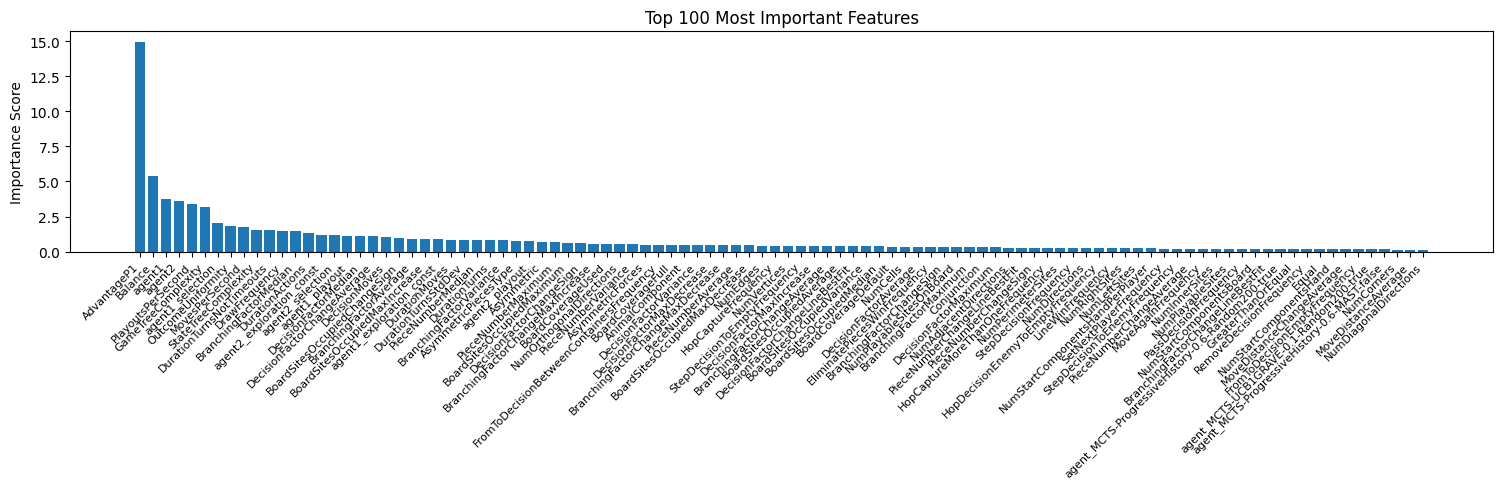

Fold 5 - RMSE: 0.427688694459286
List of oof scores: [0.40527799577858564, 0.3918960828939259, 0.42152340257738047, 0.42906281992199713, 0.427688694459286]
Average oof score: 0.415089799126235


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6272523	test: 0.5759352	best: 0.5759352 (0)	total: 79.8ms	remaining: 13m 17s


50:	learn: 0.4914256	test: 0.5239573	best: 0.5239573 (50)	total: 5.44s	remaining: 17m 41s


100:	learn: 0.4450612	test: 0.5002047	best: 0.5002047 (100)	total: 11.1s	remaining: 18m 9s


150:	learn: 0.4203828	test: 0.4843297	best: 0.4843297 (150)	total: 16.9s	remaining: 18m 22s


200:	learn: 0.4015927	test: 0.4721509	best: 0.4721509 (200)	total: 22.8s	remaining: 18m 33s


250:	learn: 0.3873987	test: 0.4646649	best: 0.4646649 (250)	total: 28.9s	remaining: 18m 41s


300:	learn: 0.3770869	test: 0.4604937	best: 0.4604937 (300)	total: 35s	remaining: 18m 47s


350:	learn: 0.3684178	test: 0.4571753	best: 0.4571753 (350)	total: 41.1s	remaining: 18m 49s


400:	learn: 0.3605817	test: 0.4541239	best: 0.4541239 (400)	total: 47.2s	remaining: 18m 50s


450:	learn: 0.3533365	test: 0.4506040	best: 0.4506040 (450)	total: 53.4s	remaining: 18m 49s


500:	learn: 0.3472599	test: 0.4480907	best: 0.4480907 (500)	total: 59.3s	remaining: 18m 44s


550:	learn: 0.3408725	test: 0.4455112	best: 0.4455112 (550)	total: 1m 5s	remaining: 18m 39s


600:	learn: 0.3358030	test: 0.4436254	best: 0.4436254 (600)	total: 1m 11s	remaining: 18m 35s


650:	learn: 0.3311984	test: 0.4418779	best: 0.4418779 (650)	total: 1m 17s	remaining: 18m 30s


700:	learn: 0.3269674	test: 0.4405443	best: 0.4405443 (700)	total: 1m 23s	remaining: 18m 24s


750:	learn: 0.3230827	test: 0.4392895	best: 0.4392895 (750)	total: 1m 29s	remaining: 18m 20s


800:	learn: 0.3193092	test: 0.4382049	best: 0.4382049 (800)	total: 1m 35s	remaining: 18m 15s


850:	learn: 0.3159022	test: 0.4373001	best: 0.4373001 (850)	total: 1m 41s	remaining: 18m 11s


900:	learn: 0.3129375	test: 0.4364531	best: 0.4364531 (900)	total: 1m 47s	remaining: 18m 6s


950:	learn: 0.3101123	test: 0.4356743	best: 0.4356743 (950)	total: 1m 53s	remaining: 18m


1000:	learn: 0.3069131	test: 0.4348527	best: 0.4348527 (1000)	total: 1m 59s	remaining: 17m 53s


1050:	learn: 0.3044490	test: 0.4341224	best: 0.4341224 (1050)	total: 2m 5s	remaining: 17m 48s


1100:	learn: 0.3017766	test: 0.4335426	best: 0.4335426 (1100)	total: 2m 11s	remaining: 17m 43s


1150:	learn: 0.2994686	test: 0.4329397	best: 0.4329397 (1150)	total: 2m 17s	remaining: 17m 38s


1200:	learn: 0.2972461	test: 0.4325764	best: 0.4325764 (1200)	total: 2m 23s	remaining: 17m 33s


1250:	learn: 0.2951274	test: 0.4321201	best: 0.4320986 (1248)	total: 2m 29s	remaining: 17m 28s


1300:	learn: 0.2929843	test: 0.4316698	best: 0.4316698 (1300)	total: 2m 35s	remaining: 17m 22s


1350:	learn: 0.2910656	test: 0.4312490	best: 0.4312490 (1350)	total: 2m 41s	remaining: 17m 16s


1400:	learn: 0.2892340	test: 0.4308572	best: 0.4308572 (1400)	total: 2m 47s	remaining: 17m 10s


1450:	learn: 0.2873393	test: 0.4306862	best: 0.4306761 (1449)	total: 2m 53s	remaining: 17m 4s


1500:	learn: 0.2856567	test: 0.4304620	best: 0.4304620 (1500)	total: 2m 59s	remaining: 16m 58s


1550:	learn: 0.2840003	test: 0.4301766	best: 0.4301766 (1550)	total: 3m 6s	remaining: 16m 53s


1600:	learn: 0.2823982	test: 0.4298152	best: 0.4298152 (1600)	total: 3m 12s	remaining: 16m 47s


1650:	learn: 0.2808010	test: 0.4294217	best: 0.4294217 (1650)	total: 3m 18s	remaining: 16m 41s


1700:	learn: 0.2792666	test: 0.4292014	best: 0.4292014 (1700)	total: 3m 24s	remaining: 16m 36s


1750:	learn: 0.2777336	test: 0.4289961	best: 0.4289925 (1749)	total: 3m 30s	remaining: 16m 31s


1800:	learn: 0.2762694	test: 0.4288138	best: 0.4288025 (1798)	total: 3m 36s	remaining: 16m 25s


1850:	learn: 0.2748554	test: 0.4286724	best: 0.4286724 (1850)	total: 3m 42s	remaining: 16m 19s


1900:	learn: 0.2734602	test: 0.4284649	best: 0.4284456 (1897)	total: 3m 48s	remaining: 16m 14s


1950:	learn: 0.2721338	test: 0.4282225	best: 0.4282225 (1950)	total: 3m 54s	remaining: 16m 8s


2000:	learn: 0.2707060	test: 0.4279604	best: 0.4279604 (2000)	total: 4m	remaining: 16m 2s


2050:	learn: 0.2694243	test: 0.4277548	best: 0.4277535 (2049)	total: 4m 6s	remaining: 15m 56s


2100:	learn: 0.2682291	test: 0.4276492	best: 0.4276492 (2100)	total: 4m 12s	remaining: 15m 50s


2150:	learn: 0.2670302	test: 0.4274748	best: 0.4274748 (2150)	total: 4m 18s	remaining: 15m 44s


2200:	learn: 0.2659771	test: 0.4273718	best: 0.4273718 (2200)	total: 4m 24s	remaining: 15m 38s


2250:	learn: 0.2647143	test: 0.4271208	best: 0.4271208 (2250)	total: 4m 31s	remaining: 15m 32s


2300:	learn: 0.2635862	test: 0.4269918	best: 0.4269918 (2300)	total: 4m 37s	remaining: 15m 26s


2350:	learn: 0.2624823	test: 0.4268413	best: 0.4268380 (2347)	total: 4m 43s	remaining: 15m 21s


2400:	learn: 0.2613950	test: 0.4266633	best: 0.4266633 (2400)	total: 4m 49s	remaining: 15m 15s


2450:	learn: 0.2603634	test: 0.4265417	best: 0.4265346 (2447)	total: 4m 55s	remaining: 15m 9s


2500:	learn: 0.2592051	test: 0.4264770	best: 0.4264702 (2497)	total: 5m 1s	remaining: 15m 3s


2550:	learn: 0.2581757	test: 0.4264107	best: 0.4263880 (2532)	total: 5m 7s	remaining: 14m 57s


2600:	learn: 0.2572615	test: 0.4262879	best: 0.4262879 (2600)	total: 5m 13s	remaining: 14m 51s


2650:	learn: 0.2562603	test: 0.4261634	best: 0.4261634 (2650)	total: 5m 19s	remaining: 14m 45s


2700:	learn: 0.2552499	test: 0.4260589	best: 0.4260589 (2700)	total: 5m 25s	remaining: 14m 40s


2750:	learn: 0.2542514	test: 0.4259963	best: 0.4259894 (2747)	total: 5m 31s	remaining: 14m 33s


2800:	learn: 0.2532682	test: 0.4258466	best: 0.4258466 (2800)	total: 5m 37s	remaining: 14m 27s


2850:	learn: 0.2523710	test: 0.4256622	best: 0.4256622 (2850)	total: 5m 43s	remaining: 14m 21s


2900:	learn: 0.2514628	test: 0.4254712	best: 0.4254619 (2897)	total: 5m 49s	remaining: 14m 15s


2950:	learn: 0.2506198	test: 0.4253743	best: 0.4253743 (2950)	total: 5m 55s	remaining: 14m 10s


3000:	learn: 0.2497859	test: 0.4252693	best: 0.4252681 (2996)	total: 6m 1s	remaining: 14m 3s


3050:	learn: 0.2488968	test: 0.4251931	best: 0.4251840 (3049)	total: 6m 7s	remaining: 13m 57s


3100:	learn: 0.2481598	test: 0.4251414	best: 0.4251359 (3096)	total: 6m 14s	remaining: 13m 52s


3150:	learn: 0.2473894	test: 0.4250599	best: 0.4250599 (3150)	total: 6m 20s	remaining: 13m 46s


3200:	learn: 0.2466130	test: 0.4250177	best: 0.4250177 (3200)	total: 6m 26s	remaining: 13m 40s


3250:	learn: 0.2457901	test: 0.4249854	best: 0.4249843 (3246)	total: 6m 32s	remaining: 13m 34s


3300:	learn: 0.2450834	test: 0.4249050	best: 0.4249050 (3300)	total: 6m 38s	remaining: 13m 28s


3350:	learn: 0.2443475	test: 0.4248701	best: 0.4248701 (3350)	total: 6m 44s	remaining: 13m 22s


3400:	learn: 0.2436252	test: 0.4247982	best: 0.4247982 (3400)	total: 6m 50s	remaining: 13m 16s


3450:	learn: 0.2429793	test: 0.4247421	best: 0.4247394 (3445)	total: 6m 56s	remaining: 13m 10s


3500:	learn: 0.2422588	test: 0.4246667	best: 0.4246622 (3478)	total: 7m 2s	remaining: 13m 4s


3550:	learn: 0.2415733	test: 0.4246473	best: 0.4246401 (3525)	total: 7m 8s	remaining: 12m 58s


3600:	learn: 0.2408502	test: 0.4245530	best: 0.4245530 (3600)	total: 7m 15s	remaining: 12m 53s


3650:	learn: 0.2401903	test: 0.4244498	best: 0.4244495 (3649)	total: 7m 21s	remaining: 12m 47s


3700:	learn: 0.2394505	test: 0.4244136	best: 0.4243975 (3681)	total: 7m 27s	remaining: 12m 41s


3750:	learn: 0.2387793	test: 0.4243737	best: 0.4243733 (3749)	total: 7m 33s	remaining: 12m 35s


3800:	learn: 0.2380820	test: 0.4242813	best: 0.4242813 (3800)	total: 7m 39s	remaining: 12m 29s


3850:	learn: 0.2374361	test: 0.4242330	best: 0.4242292 (3843)	total: 7m 45s	remaining: 12m 23s


3900:	learn: 0.2367999	test: 0.4241841	best: 0.4241725 (3893)	total: 7m 51s	remaining: 12m 17s


3950:	learn: 0.2361208	test: 0.4241220	best: 0.4241212 (3944)	total: 7m 58s	remaining: 12m 11s


4000:	learn: 0.2354573	test: 0.4240571	best: 0.4240571 (4000)	total: 8m 4s	remaining: 12m 6s


4050:	learn: 0.2348702	test: 0.4239892	best: 0.4239892 (4050)	total: 8m 10s	remaining: 12m


4100:	learn: 0.2342402	test: 0.4239291	best: 0.4239277 (4099)	total: 8m 16s	remaining: 11m 54s


4150:	learn: 0.2336806	test: 0.4238840	best: 0.4238840 (4150)	total: 8m 22s	remaining: 11m 48s


4200:	learn: 0.2330572	test: 0.4238257	best: 0.4238257 (4200)	total: 8m 28s	remaining: 11m 42s


4250:	learn: 0.2324522	test: 0.4237873	best: 0.4237821 (4240)	total: 8m 34s	remaining: 11m 36s


4300:	learn: 0.2318679	test: 0.4237526	best: 0.4237502 (4290)	total: 8m 41s	remaining: 11m 30s


4350:	learn: 0.2313071	test: 0.4236944	best: 0.4236944 (4350)	total: 8m 47s	remaining: 11m 24s


4400:	learn: 0.2307001	test: 0.4236225	best: 0.4236225 (4397)	total: 8m 53s	remaining: 11m 18s


4450:	learn: 0.2301753	test: 0.4235586	best: 0.4235507 (4448)	total: 8m 59s	remaining: 11m 12s


4500:	learn: 0.2296358	test: 0.4235252	best: 0.4235252 (4500)	total: 9m 5s	remaining: 11m 6s


4550:	learn: 0.2291118	test: 0.4234946	best: 0.4234946 (4550)	total: 9m 11s	remaining: 11m


4600:	learn: 0.2285572	test: 0.4234135	best: 0.4234135 (4600)	total: 9m 17s	remaining: 10m 54s


4650:	learn: 0.2279908	test: 0.4233813	best: 0.4233747 (4647)	total: 9m 24s	remaining: 10m 48s


4700:	learn: 0.2274376	test: 0.4233376	best: 0.4233355 (4699)	total: 9m 30s	remaining: 10m 42s


4750:	learn: 0.2268918	test: 0.4232606	best: 0.4232584 (4749)	total: 9m 36s	remaining: 10m 36s


4800:	learn: 0.2263575	test: 0.4232489	best: 0.4232384 (4779)	total: 9m 42s	remaining: 10m 30s


4850:	learn: 0.2257816	test: 0.4232357	best: 0.4232341 (4847)	total: 9m 48s	remaining: 10m 24s


4900:	learn: 0.2252325	test: 0.4231499	best: 0.4231499 (4900)	total: 9m 54s	remaining: 10m 18s


4950:	learn: 0.2247625	test: 0.4230905	best: 0.4230863 (4939)	total: 10m	remaining: 10m 12s


5000:	learn: 0.2242041	test: 0.4230410	best: 0.4230410 (5000)	total: 10m 6s	remaining: 10m 6s


5050:	learn: 0.2237059	test: 0.4230357	best: 0.4230357 (5050)	total: 10m 12s	remaining: 10m


5100:	learn: 0.2232118	test: 0.4230237	best: 0.4230080 (5073)	total: 10m 18s	remaining: 9m 54s


5150:	learn: 0.2227266	test: 0.4230058	best: 0.4229917 (5143)	total: 10m 25s	remaining: 9m 48s


5200:	learn: 0.2222344	test: 0.4229594	best: 0.4229594 (5200)	total: 10m 31s	remaining: 9m 42s


5250:	learn: 0.2217299	test: 0.4229171	best: 0.4229171 (5250)	total: 10m 37s	remaining: 9m 36s


5300:	learn: 0.2212696	test: 0.4228629	best: 0.4228629 (5300)	total: 10m 43s	remaining: 9m 30s


5350:	learn: 0.2208033	test: 0.4228388	best: 0.4228363 (5348)	total: 10m 49s	remaining: 9m 24s


5400:	learn: 0.2203439	test: 0.4227801	best: 0.4227798 (5399)	total: 10m 55s	remaining: 9m 18s


5450:	learn: 0.2198644	test: 0.4227566	best: 0.4227550 (5436)	total: 11m 1s	remaining: 9m 12s


5500:	learn: 0.2193893	test: 0.4227338	best: 0.4227232 (5475)	total: 11m 7s	remaining: 9m 5s


5550:	learn: 0.2189667	test: 0.4227120	best: 0.4227104 (5525)	total: 11m 13s	remaining: 8m 59s


5600:	learn: 0.2185111	test: 0.4226690	best: 0.4226655 (5599)	total: 11m 19s	remaining: 8m 53s


5650:	learn: 0.2180695	test: 0.4226441	best: 0.4226389 (5641)	total: 11m 26s	remaining: 8m 47s


5700:	learn: 0.2176339	test: 0.4226428	best: 0.4226386 (5672)	total: 11m 32s	remaining: 8m 41s


5750:	learn: 0.2171944	test: 0.4226227	best: 0.4226227 (5750)	total: 11m 38s	remaining: 8m 35s


5800:	learn: 0.2167095	test: 0.4226159	best: 0.4226108 (5799)	total: 11m 44s	remaining: 8m 29s


5850:	learn: 0.2162701	test: 0.4226287	best: 0.4226077 (5806)	total: 11m 50s	remaining: 8m 23s


5900:	learn: 0.2158243	test: 0.4225882	best: 0.4225882 (5900)	total: 11m 56s	remaining: 8m 17s


5950:	learn: 0.2154270	test: 0.4225896	best: 0.4225801 (5909)	total: 12m 2s	remaining: 8m 11s


6000:	learn: 0.2149890	test: 0.4225877	best: 0.4225690 (5978)	total: 12m 8s	remaining: 8m 5s


6050:	learn: 0.2145582	test: 0.4225883	best: 0.4225690 (5978)	total: 12m 14s	remaining: 7m 59s


6100:	learn: 0.2141330	test: 0.4225409	best: 0.4225390 (6098)	total: 12m 21s	remaining: 7m 53s


6150:	learn: 0.2137254	test: 0.4225320	best: 0.4225318 (6136)	total: 12m 27s	remaining: 7m 47s


6200:	learn: 0.2132871	test: 0.4224911	best: 0.4224858 (6198)	total: 12m 33s	remaining: 7m 41s


6250:	learn: 0.2128656	test: 0.4224812	best: 0.4224724 (6240)	total: 12m 39s	remaining: 7m 35s


6300:	learn: 0.2124348	test: 0.4224882	best: 0.4224680 (6259)	total: 12m 45s	remaining: 7m 29s


6350:	learn: 0.2119943	test: 0.4224713	best: 0.4224680 (6259)	total: 12m 51s	remaining: 7m 23s


6400:	learn: 0.2115797	test: 0.4224110	best: 0.4224110 (6400)	total: 12m 57s	remaining: 7m 17s


6450:	learn: 0.2111596	test: 0.4223814	best: 0.4223719 (6440)	total: 13m 3s	remaining: 7m 11s


6500:	learn: 0.2107670	test: 0.4223459	best: 0.4223426 (6495)	total: 13m 9s	remaining: 7m 5s


6550:	learn: 0.2103877	test: 0.4223222	best: 0.4223222 (6550)	total: 13m 16s	remaining: 6m 59s


6600:	learn: 0.2100162	test: 0.4223013	best: 0.4223013 (6600)	total: 13m 22s	remaining: 6m 53s


6650:	learn: 0.2095740	test: 0.4222812	best: 0.4222781 (6634)	total: 13m 28s	remaining: 6m 46s


6700:	learn: 0.2091703	test: 0.4222791	best: 0.4222781 (6634)	total: 13m 34s	remaining: 6m 40s


6750:	learn: 0.2087719	test: 0.4222798	best: 0.4222714 (6711)	total: 13m 40s	remaining: 6m 34s


6800:	learn: 0.2083911	test: 0.4222820	best: 0.4222677 (6761)	total: 13m 46s	remaining: 6m 28s


6850:	learn: 0.2080278	test: 0.4222642	best: 0.4222587 (6841)	total: 13m 52s	remaining: 6m 22s


6900:	learn: 0.2076708	test: 0.4222376	best: 0.4222373 (6899)	total: 13m 58s	remaining: 6m 16s


6950:	learn: 0.2072698	test: 0.4222201	best: 0.4222164 (6941)	total: 14m 4s	remaining: 6m 10s


7000:	learn: 0.2069136	test: 0.4222127	best: 0.4222127 (7000)	total: 14m 11s	remaining: 6m 4s


7050:	learn: 0.2065832	test: 0.4222116	best: 0.4222083 (7044)	total: 14m 17s	remaining: 5m 58s


7100:	learn: 0.2062284	test: 0.4222126	best: 0.4222083 (7044)	total: 14m 23s	remaining: 5m 52s


7150:	learn: 0.2058434	test: 0.4221763	best: 0.4221763 (7150)	total: 14m 29s	remaining: 5m 46s


7200:	learn: 0.2054987	test: 0.4221510	best: 0.4221510 (7200)	total: 14m 35s	remaining: 5m 40s


7250:	learn: 0.2051290	test: 0.4221351	best: 0.4221230 (7234)	total: 14m 41s	remaining: 5m 34s


7300:	learn: 0.2048012	test: 0.4221195	best: 0.4221183 (7299)	total: 14m 47s	remaining: 5m 28s


7350:	learn: 0.2044408	test: 0.4221126	best: 0.4221062 (7322)	total: 14m 53s	remaining: 5m 22s


7400:	learn: 0.2040890	test: 0.4221114	best: 0.4221062 (7322)	total: 14m 59s	remaining: 5m 16s


7450:	learn: 0.2037235	test: 0.4221187	best: 0.4221023 (7413)	total: 15m 6s	remaining: 5m 9s


7500:	learn: 0.2033756	test: 0.4220975	best: 0.4220961 (7490)	total: 15m 12s	remaining: 5m 3s


7550:	learn: 0.2030423	test: 0.4220819	best: 0.4220815 (7545)	total: 15m 18s	remaining: 4m 57s


7600:	learn: 0.2026994	test: 0.4220604	best: 0.4220561 (7589)	total: 15m 24s	remaining: 4m 51s


7650:	learn: 0.2023789	test: 0.4220510	best: 0.4220435 (7627)	total: 15m 30s	remaining: 4m 45s


7700:	learn: 0.2020163	test: 0.4220504	best: 0.4220435 (7627)	total: 15m 36s	remaining: 4m 39s


7750:	learn: 0.2016703	test: 0.4220425	best: 0.4220419 (7704)	total: 15m 42s	remaining: 4m 33s


7800:	learn: 0.2013531	test: 0.4220440	best: 0.4220380 (7754)	total: 15m 48s	remaining: 4m 27s


7850:	learn: 0.2009999	test: 0.4220387	best: 0.4220380 (7754)	total: 15m 55s	remaining: 4m 21s


7900:	learn: 0.2006559	test: 0.4220179	best: 0.4220135 (7890)	total: 16m 1s	remaining: 4m 15s


7950:	learn: 0.2003022	test: 0.4220116	best: 0.4220069 (7913)	total: 16m 7s	remaining: 4m 9s


8000:	learn: 0.1999973	test: 0.4220225	best: 0.4220069 (7913)	total: 16m 13s	remaining: 4m 3s


8050:	learn: 0.1996862	test: 0.4220075	best: 0.4220067 (8045)	total: 16m 19s	remaining: 3m 57s


8100:	learn: 0.1993816	test: 0.4219947	best: 0.4219915 (8078)	total: 16m 25s	remaining: 3m 51s


8150:	learn: 0.1990371	test: 0.4219698	best: 0.4219668 (8146)	total: 16m 31s	remaining: 3m 44s


8200:	learn: 0.1986949	test: 0.4219858	best: 0.4219668 (8146)	total: 16m 37s	remaining: 3m 38s


8250:	learn: 0.1983956	test: 0.4219600	best: 0.4219587 (8247)	total: 16m 44s	remaining: 3m 32s


8300:	learn: 0.1980568	test: 0.4219684	best: 0.4219587 (8247)	total: 16m 50s	remaining: 3m 26s


8350:	learn: 0.1977486	test: 0.4219660	best: 0.4219587 (8247)	total: 16m 56s	remaining: 3m 20s


8400:	learn: 0.1974533	test: 0.4219683	best: 0.4219587 (8247)	total: 17m 2s	remaining: 3m 14s


8450:	learn: 0.1971553	test: 0.4219581	best: 0.4219552 (8429)	total: 17m 8s	remaining: 3m 8s


8500:	learn: 0.1968366	test: 0.4219443	best: 0.4219412 (8479)	total: 17m 14s	remaining: 3m 2s


8550:	learn: 0.1965039	test: 0.4219234	best: 0.4219201 (8537)	total: 17m 20s	remaining: 2m 56s


8600:	learn: 0.1961969	test: 0.4219007	best: 0.4218951 (8594)	total: 17m 26s	remaining: 2m 50s


8650:	learn: 0.1958631	test: 0.4218921	best: 0.4218866 (8649)	total: 17m 32s	remaining: 2m 44s


8700:	learn: 0.1955710	test: 0.4218769	best: 0.4218741 (8685)	total: 17m 38s	remaining: 2m 38s


8750:	learn: 0.1952821	test: 0.4218677	best: 0.4218677 (8750)	total: 17m 44s	remaining: 2m 32s


8800:	learn: 0.1949588	test: 0.4218525	best: 0.4218467 (8787)	total: 17m 51s	remaining: 2m 25s


8850:	learn: 0.1946492	test: 0.4218448	best: 0.4218441 (8849)	total: 17m 57s	remaining: 2m 19s


8900:	learn: 0.1943432	test: 0.4218266	best: 0.4218266 (8900)	total: 18m 3s	remaining: 2m 13s


8950:	learn: 0.1940354	test: 0.4218019	best: 0.4217981 (8930)	total: 18m 9s	remaining: 2m 7s


9000:	learn: 0.1937391	test: 0.4217844	best: 0.4217808 (8992)	total: 18m 15s	remaining: 2m 1s


9050:	learn: 0.1934018	test: 0.4217908	best: 0.4217808 (8992)	total: 18m 21s	remaining: 1m 55s


9100:	learn: 0.1930987	test: 0.4217909	best: 0.4217808 (8992)	total: 18m 27s	remaining: 1m 49s


9150:	learn: 0.1928078	test: 0.4217858	best: 0.4217808 (8992)	total: 18m 33s	remaining: 1m 43s


9200:	learn: 0.1925072	test: 0.4217826	best: 0.4217785 (9177)	total: 18m 39s	remaining: 1m 37s


9250:	learn: 0.1922024	test: 0.4217719	best: 0.4217714 (9248)	total: 18m 46s	remaining: 1m 31s


9300:	learn: 0.1919170	test: 0.4217693	best: 0.4217659 (9263)	total: 18m 52s	remaining: 1m 25s


9350:	learn: 0.1916620	test: 0.4217512	best: 0.4217512 (9350)	total: 18m 58s	remaining: 1m 19s


9400:	learn: 0.1913644	test: 0.4217205	best: 0.4217149 (9392)	total: 19m 4s	remaining: 1m 12s


9450:	learn: 0.1910554	test: 0.4217111	best: 0.4217096 (9445)	total: 19m 10s	remaining: 1m 6s


9500:	learn: 0.1907620	test: 0.4217029	best: 0.4217029 (9500)	total: 19m 16s	remaining: 1m


9550:	learn: 0.1904716	test: 0.4216896	best: 0.4216896 (9550)	total: 19m 22s	remaining: 54.7s


9600:	learn: 0.1901867	test: 0.4216941	best: 0.4216896 (9581)	total: 19m 28s	remaining: 48.6s


9650:	learn: 0.1898809	test: 0.4217084	best: 0.4216896 (9581)	total: 19m 34s	remaining: 42.5s


9700:	learn: 0.1896317	test: 0.4216974	best: 0.4216896 (9581)	total: 19m 41s	remaining: 36.4s


9750:	learn: 0.1893577	test: 0.4216839	best: 0.4216839 (9750)	total: 19m 47s	remaining: 30.3s


9800:	learn: 0.1890427	test: 0.4216865	best: 0.4216770 (9776)	total: 19m 53s	remaining: 24.2s


9850:	learn: 0.1887769	test: 0.4216977	best: 0.4216770 (9776)	total: 19m 59s	remaining: 18.1s


9900:	learn: 0.1884889	test: 0.4216914	best: 0.4216770 (9776)	total: 20m 5s	remaining: 12.1s


9950:	learn: 0.1882157	test: 0.4216827	best: 0.4216770 (9776)	total: 20m 11s	remaining: 5.96s


9999:	learn: 0.1879482	test: 0.4216797	best: 0.4216768 (9982)	total: 20m 17s	remaining: 0us

bestTest = 0.4216768451
bestIteration = 9982

Shrink model to first 9983 iterations.


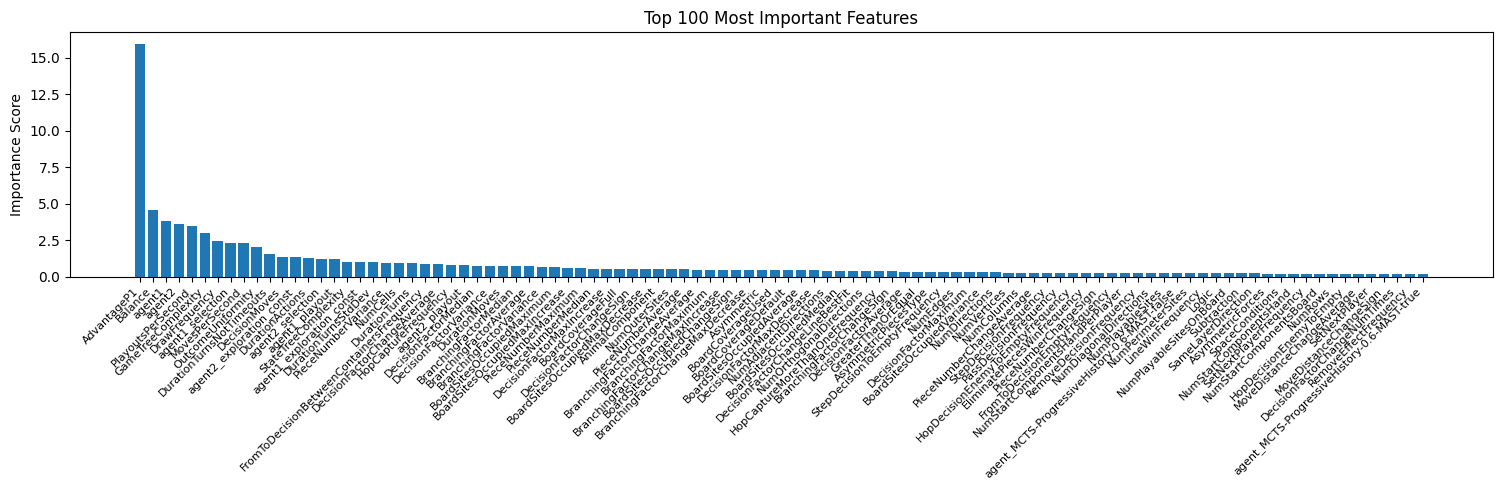

Fold 1 - RMSE: 0.42134112896867354
Fold 2


0:	learn: 0.6264529	test: 0.5749313	best: 0.5749313 (0)	total: 96.8ms	remaining: 16m 8s


50:	learn: 0.4878752	test: 0.5277817	best: 0.5277817 (50)	total: 5.58s	remaining: 18m 8s


100:	learn: 0.4434348	test: 0.5024748	best: 0.5024748 (100)	total: 11.3s	remaining: 18m 23s


150:	learn: 0.4177212	test: 0.4869483	best: 0.4869483 (150)	total: 17s	remaining: 18m 29s


200:	learn: 0.4022993	test: 0.4759765	best: 0.4759765 (200)	total: 23s	remaining: 18m 43s


250:	learn: 0.3894042	test: 0.4669490	best: 0.4669490 (250)	total: 29.1s	remaining: 18m 49s


300:	learn: 0.3794362	test: 0.4603888	best: 0.4603888 (300)	total: 35.2s	remaining: 18m 54s


350:	learn: 0.3707409	test: 0.4556008	best: 0.4556008 (350)	total: 41.4s	remaining: 18m 58s


400:	learn: 0.3626053	test: 0.4514515	best: 0.4514515 (400)	total: 47.5s	remaining: 18m 55s


450:	learn: 0.3562066	test: 0.4481643	best: 0.4481643 (450)	total: 53.7s	remaining: 18m 56s


500:	learn: 0.3503599	test: 0.4451487	best: 0.4451487 (500)	total: 59.9s	remaining: 18m 55s


550:	learn: 0.3446355	test: 0.4421777	best: 0.4421777 (550)	total: 1m 5s	remaining: 18m 50s


600:	learn: 0.3395445	test: 0.4396118	best: 0.4396118 (600)	total: 1m 12s	remaining: 18m 46s


650:	learn: 0.3349081	test: 0.4375538	best: 0.4375538 (650)	total: 1m 18s	remaining: 18m 40s


700:	learn: 0.3307358	test: 0.4358200	best: 0.4358072 (699)	total: 1m 24s	remaining: 18m 34s


750:	learn: 0.3268431	test: 0.4344027	best: 0.4344027 (750)	total: 1m 30s	remaining: 18m 28s


800:	learn: 0.3230712	test: 0.4330135	best: 0.4330135 (800)	total: 1m 35s	remaining: 18m 22s


850:	learn: 0.3196544	test: 0.4315660	best: 0.4315660 (850)	total: 1m 42s	remaining: 18m 16s


900:	learn: 0.3164630	test: 0.4306333	best: 0.4306324 (899)	total: 1m 48s	remaining: 18m 10s


950:	learn: 0.3135294	test: 0.4296479	best: 0.4296479 (950)	total: 1m 54s	remaining: 18m 5s


1000:	learn: 0.3106493	test: 0.4286409	best: 0.4286409 (1000)	total: 2m	remaining: 18m


1050:	learn: 0.3079399	test: 0.4276476	best: 0.4276476 (1050)	total: 2m 6s	remaining: 17m 53s


1100:	learn: 0.3053436	test: 0.4268161	best: 0.4268161 (1100)	total: 2m 12s	remaining: 17m 48s


1150:	learn: 0.3030090	test: 0.4260864	best: 0.4260864 (1150)	total: 2m 18s	remaining: 17m 41s


1200:	learn: 0.3008160	test: 0.4254846	best: 0.4254846 (1200)	total: 2m 24s	remaining: 17m 36s


1250:	learn: 0.2986453	test: 0.4248961	best: 0.4248961 (1250)	total: 2m 30s	remaining: 17m 30s


1300:	learn: 0.2964878	test: 0.4244989	best: 0.4244989 (1300)	total: 2m 36s	remaining: 17m 24s


1350:	learn: 0.2943557	test: 0.4238453	best: 0.4238453 (1350)	total: 2m 42s	remaining: 17m 19s


1400:	learn: 0.2924093	test: 0.4234107	best: 0.4234107 (1400)	total: 2m 48s	remaining: 17m 13s


1450:	learn: 0.2903794	test: 0.4229636	best: 0.4229636 (1450)	total: 2m 54s	remaining: 17m 7s


1500:	learn: 0.2887200	test: 0.4225347	best: 0.4225347 (1500)	total: 3m	remaining: 17m 2s


1550:	learn: 0.2869361	test: 0.4220298	best: 0.4220298 (1550)	total: 3m 6s	remaining: 16m 56s


1600:	learn: 0.2852225	test: 0.4216104	best: 0.4216104 (1600)	total: 3m 12s	remaining: 16m 51s


1650:	learn: 0.2835539	test: 0.4211647	best: 0.4211647 (1650)	total: 3m 18s	remaining: 16m 45s


1700:	learn: 0.2819166	test: 0.4207644	best: 0.4207613 (1699)	total: 3m 24s	remaining: 16m 39s


1750:	learn: 0.2803758	test: 0.4203653	best: 0.4203653 (1750)	total: 3m 31s	remaining: 16m 34s


1800:	learn: 0.2789488	test: 0.4199781	best: 0.4199772 (1799)	total: 3m 37s	remaining: 16m 28s


1850:	learn: 0.2775558	test: 0.4196228	best: 0.4196207 (1847)	total: 3m 43s	remaining: 16m 23s


1900:	learn: 0.2761078	test: 0.4192366	best: 0.4192366 (1900)	total: 3m 49s	remaining: 16m 17s


1950:	learn: 0.2745927	test: 0.4189153	best: 0.4189153 (1950)	total: 3m 55s	remaining: 16m 11s


2000:	learn: 0.2732272	test: 0.4186023	best: 0.4186023 (2000)	total: 4m 1s	remaining: 16m 5s


2050:	learn: 0.2718687	test: 0.4181831	best: 0.4181831 (2050)	total: 4m 7s	remaining: 16m


2100:	learn: 0.2706198	test: 0.4179277	best: 0.4179277 (2100)	total: 4m 13s	remaining: 15m 53s


2150:	learn: 0.2691955	test: 0.4176257	best: 0.4176257 (2150)	total: 4m 19s	remaining: 15m 48s


2200:	learn: 0.2679794	test: 0.4173268	best: 0.4173268 (2200)	total: 4m 25s	remaining: 15m 41s


2250:	learn: 0.2666936	test: 0.4170911	best: 0.4170911 (2250)	total: 4m 31s	remaining: 15m 36s


2300:	learn: 0.2654817	test: 0.4168544	best: 0.4168544 (2300)	total: 4m 38s	remaining: 15m 30s


2350:	learn: 0.2643158	test: 0.4165861	best: 0.4165861 (2350)	total: 4m 44s	remaining: 15m 24s


2400:	learn: 0.2631834	test: 0.4164079	best: 0.4164079 (2400)	total: 4m 50s	remaining: 15m 18s


2450:	learn: 0.2621838	test: 0.4161548	best: 0.4161548 (2450)	total: 4m 56s	remaining: 15m 13s


2500:	learn: 0.2610597	test: 0.4158553	best: 0.4158553 (2500)	total: 5m 2s	remaining: 15m 7s


2550:	learn: 0.2600049	test: 0.4156511	best: 0.4156511 (2550)	total: 5m 8s	remaining: 15m 1s


2600:	learn: 0.2590668	test: 0.4153771	best: 0.4153771 (2600)	total: 5m 14s	remaining: 14m 55s


2650:	learn: 0.2580404	test: 0.4151931	best: 0.4151931 (2650)	total: 5m 21s	remaining: 14m 49s


2700:	learn: 0.2569998	test: 0.4149914	best: 0.4149867 (2698)	total: 5m 27s	remaining: 14m 43s


2750:	learn: 0.2559902	test: 0.4148305	best: 0.4148305 (2750)	total: 5m 33s	remaining: 14m 38s


2800:	learn: 0.2549045	test: 0.4146186	best: 0.4146060 (2798)	total: 5m 39s	remaining: 14m 32s


2850:	learn: 0.2539411	test: 0.4144190	best: 0.4144190 (2850)	total: 5m 45s	remaining: 14m 26s


2900:	learn: 0.2530503	test: 0.4142595	best: 0.4142468 (2893)	total: 5m 51s	remaining: 14m 20s


2950:	learn: 0.2521244	test: 0.4141341	best: 0.4141316 (2949)	total: 5m 57s	remaining: 14m 15s


3000:	learn: 0.2512542	test: 0.4139417	best: 0.4139417 (3000)	total: 6m 4s	remaining: 14m 9s


3050:	learn: 0.2503569	test: 0.4137704	best: 0.4137643 (3047)	total: 6m 10s	remaining: 14m 3s


3100:	learn: 0.2494554	test: 0.4136142	best: 0.4136142 (3100)	total: 6m 16s	remaining: 13m 57s


3150:	learn: 0.2485351	test: 0.4135028	best: 0.4135028 (3150)	total: 6m 22s	remaining: 13m 51s


3200:	learn: 0.2477035	test: 0.4133558	best: 0.4133558 (3200)	total: 6m 28s	remaining: 13m 45s


3250:	learn: 0.2469103	test: 0.4131755	best: 0.4131755 (3250)	total: 6m 34s	remaining: 13m 39s


3300:	learn: 0.2460644	test: 0.4130327	best: 0.4130321 (3295)	total: 6m 41s	remaining: 13m 33s


3350:	learn: 0.2452706	test: 0.4128705	best: 0.4128705 (3350)	total: 6m 47s	remaining: 13m 28s


3400:	learn: 0.2443954	test: 0.4127219	best: 0.4127219 (3400)	total: 6m 53s	remaining: 13m 22s


3450:	learn: 0.2435904	test: 0.4126329	best: 0.4126329 (3450)	total: 6m 59s	remaining: 13m 16s


3500:	learn: 0.2428890	test: 0.4125248	best: 0.4125248 (3500)	total: 7m 5s	remaining: 13m 10s


3550:	learn: 0.2421829	test: 0.4124081	best: 0.4124081 (3550)	total: 7m 11s	remaining: 13m 4s


3600:	learn: 0.2414526	test: 0.4123441	best: 0.4123311 (3596)	total: 7m 18s	remaining: 12m 58s


3650:	learn: 0.2407673	test: 0.4122519	best: 0.4122476 (3645)	total: 7m 24s	remaining: 12m 52s


3700:	learn: 0.2400491	test: 0.4121557	best: 0.4121504 (3699)	total: 7m 30s	remaining: 12m 46s


3750:	learn: 0.2393726	test: 0.4120453	best: 0.4120453 (3750)	total: 7m 36s	remaining: 12m 40s


3800:	learn: 0.2386960	test: 0.4119418	best: 0.4119418 (3800)	total: 7m 42s	remaining: 12m 34s


3850:	learn: 0.2380527	test: 0.4118606	best: 0.4118606 (3850)	total: 7m 48s	remaining: 12m 28s


3900:	learn: 0.2373655	test: 0.4117061	best: 0.4117061 (3900)	total: 7m 55s	remaining: 12m 22s


3950:	learn: 0.2366555	test: 0.4116414	best: 0.4116414 (3950)	total: 8m 1s	remaining: 12m 16s


4000:	learn: 0.2359441	test: 0.4115604	best: 0.4115555 (3995)	total: 8m 7s	remaining: 12m 10s


4050:	learn: 0.2353460	test: 0.4115203	best: 0.4115169 (4048)	total: 8m 13s	remaining: 12m 4s


4100:	learn: 0.2347655	test: 0.4114396	best: 0.4114396 (4100)	total: 8m 19s	remaining: 11m 58s


4150:	learn: 0.2341866	test: 0.4113294	best: 0.4113226 (4145)	total: 8m 25s	remaining: 11m 52s


4200:	learn: 0.2335773	test: 0.4111925	best: 0.4111925 (4200)	total: 8m 31s	remaining: 11m 46s


4250:	learn: 0.2329856	test: 0.4111105	best: 0.4111102 (4249)	total: 8m 37s	remaining: 11m 40s


4300:	learn: 0.2324108	test: 0.4110773	best: 0.4110665 (4299)	total: 8m 44s	remaining: 11m 34s


4350:	learn: 0.2318156	test: 0.4110053	best: 0.4110011 (4346)	total: 8m 50s	remaining: 11m 28s


4400:	learn: 0.2312100	test: 0.4109390	best: 0.4109363 (4399)	total: 8m 56s	remaining: 11m 22s


4450:	learn: 0.2306605	test: 0.4108600	best: 0.4108600 (4450)	total: 9m 2s	remaining: 11m 16s


4500:	learn: 0.2301158	test: 0.4108080	best: 0.4107974 (4494)	total: 9m 8s	remaining: 11m 10s


4550:	learn: 0.2295228	test: 0.4107633	best: 0.4107569 (4529)	total: 9m 14s	remaining: 11m 3s


4600:	learn: 0.2289868	test: 0.4106902	best: 0.4106843 (4599)	total: 9m 20s	remaining: 10m 57s


4650:	learn: 0.2284533	test: 0.4106122	best: 0.4106098 (4646)	total: 9m 26s	remaining: 10m 51s


4700:	learn: 0.2278788	test: 0.4105662	best: 0.4105618 (4699)	total: 9m 32s	remaining: 10m 45s


4750:	learn: 0.2273921	test: 0.4105343	best: 0.4105325 (4749)	total: 9m 38s	remaining: 10m 39s


4800:	learn: 0.2268608	test: 0.4104740	best: 0.4104740 (4800)	total: 9m 45s	remaining: 10m 33s


4850:	learn: 0.2263542	test: 0.4104284	best: 0.4104284 (4850)	total: 9m 51s	remaining: 10m 27s


4900:	learn: 0.2258234	test: 0.4103616	best: 0.4103590 (4896)	total: 9m 57s	remaining: 10m 21s


4950:	learn: 0.2252874	test: 0.4102870	best: 0.4102848 (4949)	total: 10m 3s	remaining: 10m 15s


5000:	learn: 0.2247974	test: 0.4102277	best: 0.4102179 (4997)	total: 10m 9s	remaining: 10m 9s


5050:	learn: 0.2242753	test: 0.4102124	best: 0.4102032 (5028)	total: 10m 15s	remaining: 10m 3s


5100:	learn: 0.2237439	test: 0.4102425	best: 0.4101997 (5056)	total: 10m 21s	remaining: 9m 57s


5150:	learn: 0.2232403	test: 0.4101839	best: 0.4101790 (5138)	total: 10m 28s	remaining: 9m 51s


5200:	learn: 0.2227875	test: 0.4101105	best: 0.4101105 (5200)	total: 10m 34s	remaining: 9m 45s


5250:	learn: 0.2222345	test: 0.4100817	best: 0.4100790 (5245)	total: 10m 40s	remaining: 9m 39s


5300:	learn: 0.2217567	test: 0.4100512	best: 0.4100507 (5299)	total: 10m 46s	remaining: 9m 33s


5350:	learn: 0.2212765	test: 0.4100402	best: 0.4100319 (5338)	total: 10m 52s	remaining: 9m 26s


5400:	learn: 0.2207803	test: 0.4099798	best: 0.4099798 (5400)	total: 10m 58s	remaining: 9m 20s


5450:	learn: 0.2203742	test: 0.4099512	best: 0.4099512 (5450)	total: 11m 4s	remaining: 9m 14s


5500:	learn: 0.2199242	test: 0.4099272	best: 0.4099268 (5499)	total: 11m 10s	remaining: 9m 8s


5550:	learn: 0.2194271	test: 0.4099091	best: 0.4099035 (5536)	total: 11m 17s	remaining: 9m 2s


5600:	learn: 0.2189608	test: 0.4098685	best: 0.4098641 (5592)	total: 11m 23s	remaining: 8m 56s


5650:	learn: 0.2185020	test: 0.4098004	best: 0.4098004 (5650)	total: 11m 29s	remaining: 8m 50s


5700:	learn: 0.2180814	test: 0.4097479	best: 0.4097400 (5688)	total: 11m 35s	remaining: 8m 44s


5750:	learn: 0.2176441	test: 0.4097279	best: 0.4097279 (5750)	total: 11m 41s	remaining: 8m 38s


5800:	learn: 0.2172499	test: 0.4096822	best: 0.4096793 (5798)	total: 11m 47s	remaining: 8m 32s


5850:	learn: 0.2168254	test: 0.4096252	best: 0.4096220 (5849)	total: 11m 53s	remaining: 8m 26s


5900:	learn: 0.2164119	test: 0.4095712	best: 0.4095712 (5900)	total: 12m	remaining: 8m 20s


5950:	learn: 0.2159961	test: 0.4095205	best: 0.4095173 (5948)	total: 12m 6s	remaining: 8m 14s


6000:	learn: 0.2155438	test: 0.4094416	best: 0.4094416 (6000)	total: 12m 13s	remaining: 8m 8s


6050:	learn: 0.2151091	test: 0.4094108	best: 0.4094046 (6045)	total: 12m 19s	remaining: 8m 2s


6100:	learn: 0.2147070	test: 0.4093592	best: 0.4093592 (6100)	total: 12m 25s	remaining: 7m 56s


6150:	learn: 0.2142799	test: 0.4093466	best: 0.4093425 (6146)	total: 12m 31s	remaining: 7m 50s


6200:	learn: 0.2138217	test: 0.4093071	best: 0.4093071 (6200)	total: 12m 37s	remaining: 7m 44s


6250:	learn: 0.2134045	test: 0.4092544	best: 0.4092540 (6249)	total: 12m 44s	remaining: 7m 38s


6300:	learn: 0.2129641	test: 0.4091916	best: 0.4091916 (6300)	total: 12m 50s	remaining: 7m 32s


6350:	learn: 0.2125001	test: 0.4091732	best: 0.4091682 (6340)	total: 12m 57s	remaining: 7m 26s


6400:	learn: 0.2121213	test: 0.4091537	best: 0.4091432 (6393)	total: 13m 3s	remaining: 7m 20s


6450:	learn: 0.2117352	test: 0.4091021	best: 0.4091013 (6448)	total: 13m 9s	remaining: 7m 14s


6500:	learn: 0.2113046	test: 0.4090748	best: 0.4090715 (6496)	total: 13m 15s	remaining: 7m 8s


6550:	learn: 0.2108811	test: 0.4090633	best: 0.4090599 (6538)	total: 13m 22s	remaining: 7m 2s


6600:	learn: 0.2104394	test: 0.4090304	best: 0.4090275 (6599)	total: 13m 28s	remaining: 6m 56s


6650:	learn: 0.2100399	test: 0.4090279	best: 0.4090161 (6631)	total: 13m 34s	remaining: 6m 50s


6700:	learn: 0.2096155	test: 0.4090101	best: 0.4090085 (6680)	total: 13m 40s	remaining: 6m 44s


6750:	learn: 0.2092186	test: 0.4089715	best: 0.4089702 (6742)	total: 13m 46s	remaining: 6m 37s


6800:	learn: 0.2088175	test: 0.4089542	best: 0.4089482 (6794)	total: 13m 53s	remaining: 6m 31s


6850:	learn: 0.2084425	test: 0.4089264	best: 0.4089261 (6839)	total: 13m 59s	remaining: 6m 25s


6900:	learn: 0.2080699	test: 0.4088837	best: 0.4088837 (6900)	total: 14m 5s	remaining: 6m 19s


6950:	learn: 0.2076943	test: 0.4088722	best: 0.4088709 (6948)	total: 14m 12s	remaining: 6m 13s


7000:	learn: 0.2072578	test: 0.4088441	best: 0.4088370 (6993)	total: 14m 18s	remaining: 6m 7s


7050:	learn: 0.2068982	test: 0.4088042	best: 0.4088042 (7050)	total: 14m 24s	remaining: 6m 1s


7100:	learn: 0.2065214	test: 0.4087669	best: 0.4087665 (7099)	total: 14m 30s	remaining: 5m 55s


7150:	learn: 0.2061461	test: 0.4087551	best: 0.4087500 (7143)	total: 14m 36s	remaining: 5m 49s


7200:	learn: 0.2057933	test: 0.4087009	best: 0.4087009 (7200)	total: 14m 42s	remaining: 5m 43s


7250:	learn: 0.2054370	test: 0.4086874	best: 0.4086874 (7250)	total: 14m 48s	remaining: 5m 36s


7300:	learn: 0.2050585	test: 0.4086618	best: 0.4086552 (7295)	total: 14m 55s	remaining: 5m 30s


7350:	learn: 0.2046795	test: 0.4086573	best: 0.4086552 (7295)	total: 15m 1s	remaining: 5m 24s


7400:	learn: 0.2042922	test: 0.4086544	best: 0.4086504 (7392)	total: 15m 7s	remaining: 5m 18s


7450:	learn: 0.2039247	test: 0.4086630	best: 0.4086504 (7392)	total: 15m 13s	remaining: 5m 12s


7500:	learn: 0.2035740	test: 0.4086460	best: 0.4086403 (7498)	total: 15m 19s	remaining: 5m 6s


7550:	learn: 0.2032391	test: 0.4086347	best: 0.4086333 (7545)	total: 15m 25s	remaining: 5m


7600:	learn: 0.2029063	test: 0.4086212	best: 0.4086152 (7588)	total: 15m 31s	remaining: 4m 54s


7650:	learn: 0.2025691	test: 0.4085982	best: 0.4085964 (7647)	total: 15m 38s	remaining: 4m 48s


7700:	learn: 0.2022026	test: 0.4085635	best: 0.4085609 (7695)	total: 15m 44s	remaining: 4m 41s


7750:	learn: 0.2018554	test: 0.4085366	best: 0.4085351 (7741)	total: 15m 50s	remaining: 4m 35s


7800:	learn: 0.2015163	test: 0.4085208	best: 0.4085165 (7798)	total: 15m 56s	remaining: 4m 29s


7850:	learn: 0.2011830	test: 0.4084998	best: 0.4084958 (7847)	total: 16m 2s	remaining: 4m 23s


7900:	learn: 0.2008493	test: 0.4084531	best: 0.4084467 (7892)	total: 16m 8s	remaining: 4m 17s


7950:	learn: 0.2005263	test: 0.4084561	best: 0.4084467 (7892)	total: 16m 15s	remaining: 4m 11s


8000:	learn: 0.2001919	test: 0.4084366	best: 0.4084366 (8000)	total: 16m 21s	remaining: 4m 5s


8050:	learn: 0.1998610	test: 0.4084086	best: 0.4084057 (8028)	total: 16m 27s	remaining: 3m 58s


8100:	learn: 0.1995625	test: 0.4083784	best: 0.4083778 (8083)	total: 16m 33s	remaining: 3m 52s


8150:	learn: 0.1992342	test: 0.4083401	best: 0.4083398 (8149)	total: 16m 39s	remaining: 3m 46s


8200:	learn: 0.1989095	test: 0.4083204	best: 0.4083102 (8184)	total: 16m 45s	remaining: 3m 40s


8250:	learn: 0.1985792	test: 0.4083044	best: 0.4083009 (8234)	total: 16m 51s	remaining: 3m 34s


8300:	learn: 0.1982701	test: 0.4082953	best: 0.4082921 (8292)	total: 16m 58s	remaining: 3m 28s


8350:	learn: 0.1979582	test: 0.4082811	best: 0.4082780 (8311)	total: 17m 4s	remaining: 3m 22s


8400:	learn: 0.1976601	test: 0.4082995	best: 0.4082755 (8359)	total: 17m 10s	remaining: 3m 16s


8450:	learn: 0.1973487	test: 0.4082630	best: 0.4082626 (8449)	total: 17m 16s	remaining: 3m 10s


8500:	learn: 0.1970185	test: 0.4082364	best: 0.4082364 (8500)	total: 17m 22s	remaining: 3m 3s


8550:	learn: 0.1966869	test: 0.4082107	best: 0.4082104 (8549)	total: 17m 28s	remaining: 2m 57s


8600:	learn: 0.1963505	test: 0.4082094	best: 0.4082018 (8568)	total: 17m 35s	remaining: 2m 51s


8650:	learn: 0.1960395	test: 0.4081605	best: 0.4081599 (8646)	total: 17m 41s	remaining: 2m 45s


8700:	learn: 0.1957450	test: 0.4081164	best: 0.4081164 (8700)	total: 17m 47s	remaining: 2m 39s


8750:	learn: 0.1954101	test: 0.4080886	best: 0.4080842 (8742)	total: 17m 53s	remaining: 2m 33s


8800:	learn: 0.1951123	test: 0.4080760	best: 0.4080760 (8800)	total: 17m 59s	remaining: 2m 27s


8850:	learn: 0.1948081	test: 0.4080441	best: 0.4080440 (8848)	total: 18m 6s	remaining: 2m 20s


8900:	learn: 0.1944936	test: 0.4080134	best: 0.4080109 (8896)	total: 18m 12s	remaining: 2m 14s


8950:	learn: 0.1941727	test: 0.4079986	best: 0.4079958 (8946)	total: 18m 18s	remaining: 2m 8s


9000:	learn: 0.1938976	test: 0.4079939	best: 0.4079939 (9000)	total: 18m 24s	remaining: 2m 2s


9050:	learn: 0.1935830	test: 0.4079720	best: 0.4079679 (9044)	total: 18m 31s	remaining: 1m 56s


9100:	learn: 0.1932646	test: 0.4079521	best: 0.4079506 (9097)	total: 18m 37s	remaining: 1m 50s


9150:	learn: 0.1929828	test: 0.4079497	best: 0.4079406 (9135)	total: 18m 43s	remaining: 1m 44s


9200:	learn: 0.1926778	test: 0.4079022	best: 0.4079022 (9200)	total: 18m 49s	remaining: 1m 38s


9250:	learn: 0.1923931	test: 0.4079069	best: 0.4078997 (9203)	total: 18m 55s	remaining: 1m 31s


9300:	learn: 0.1921127	test: 0.4078825	best: 0.4078825 (9300)	total: 19m 1s	remaining: 1m 25s


9350:	learn: 0.1918287	test: 0.4078763	best: 0.4078628 (9316)	total: 19m 8s	remaining: 1m 19s


9400:	learn: 0.1915404	test: 0.4078411	best: 0.4078411 (9400)	total: 19m 14s	remaining: 1m 13s


9450:	learn: 0.1912326	test: 0.4078486	best: 0.4078411 (9400)	total: 19m 20s	remaining: 1m 7s


9500:	learn: 0.1909357	test: 0.4078282	best: 0.4078282 (9500)	total: 19m 26s	remaining: 1m 1s


9550:	learn: 0.1906358	test: 0.4077942	best: 0.4077942 (9549)	total: 19m 32s	remaining: 55.1s


9600:	learn: 0.1903428	test: 0.4077787	best: 0.4077787 (9600)	total: 19m 39s	remaining: 49s


9650:	learn: 0.1900370	test: 0.4077513	best: 0.4077509 (9649)	total: 19m 45s	remaining: 42.9s


9700:	learn: 0.1897331	test: 0.4077280	best: 0.4077267 (9681)	total: 19m 51s	remaining: 36.7s


9750:	learn: 0.1894341	test: 0.4077136	best: 0.4077135 (9749)	total: 19m 57s	remaining: 30.6s


9800:	learn: 0.1891457	test: 0.4076824	best: 0.4076824 (9800)	total: 20m 3s	remaining: 24.4s


9850:	learn: 0.1888470	test: 0.4076573	best: 0.4076557 (9830)	total: 20m 9s	remaining: 18.3s


9900:	learn: 0.1885643	test: 0.4076331	best: 0.4076320 (9892)	total: 20m 15s	remaining: 12.2s


9950:	learn: 0.1883134	test: 0.4075977	best: 0.4075952 (9948)	total: 20m 21s	remaining: 6.01s


9999:	learn: 0.1880624	test: 0.4075958	best: 0.4075938 (9957)	total: 20m 27s	remaining: 0us

bestTest = 0.4075938283
bestIteration = 9957

Shrink model to first 9958 iterations.


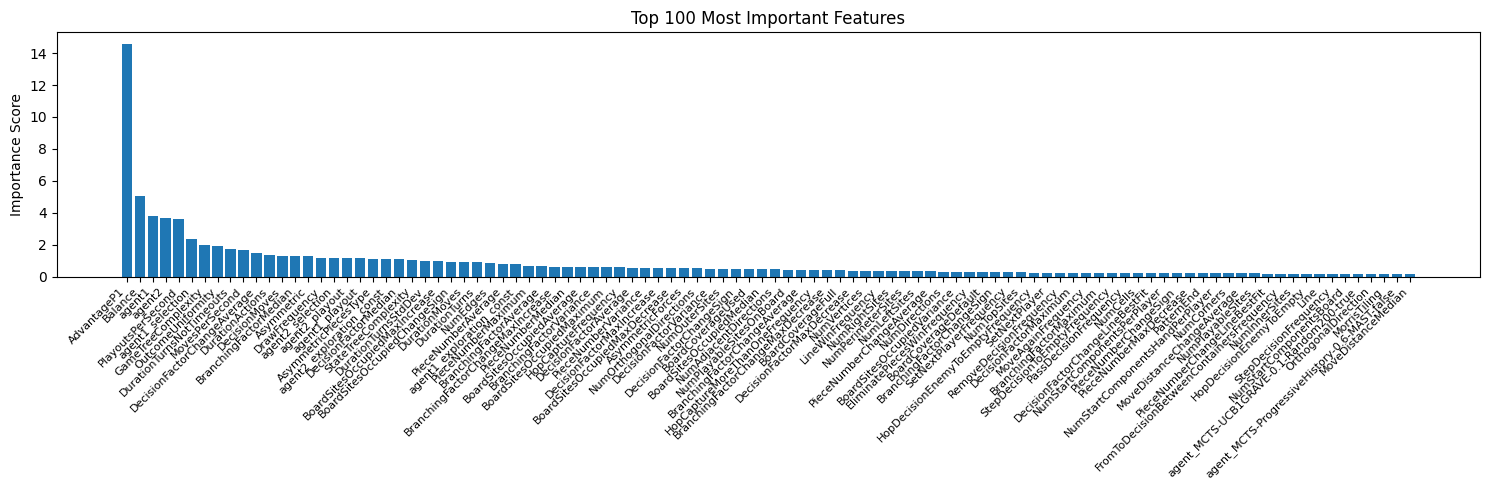

Fold 2 - RMSE: 0.4072826597913988
Fold 3


0:	learn: 0.6287903	test: 0.5773989	best: 0.5773989 (0)	total: 94.3ms	remaining: 15m 43s


50:	learn: 0.4931811	test: 0.5178798	best: 0.5178798 (50)	total: 5.33s	remaining: 17m 20s


100:	learn: 0.4468509	test: 0.4917021	best: 0.4917021 (100)	total: 10.9s	remaining: 17m 43s


150:	learn: 0.4193840	test: 0.4766936	best: 0.4766936 (150)	total: 16.5s	remaining: 17m 57s


200:	learn: 0.4018627	test: 0.4672416	best: 0.4672416 (200)	total: 22.5s	remaining: 18m 14s


250:	learn: 0.3884529	test: 0.4595659	best: 0.4595659 (250)	total: 28.3s	remaining: 18m 20s


300:	learn: 0.3781729	test: 0.4543761	best: 0.4543761 (300)	total: 34.2s	remaining: 18m 22s


350:	learn: 0.3692840	test: 0.4507850	best: 0.4507850 (350)	total: 40.2s	remaining: 18m 24s


400:	learn: 0.3612106	test: 0.4473275	best: 0.4473275 (400)	total: 46.2s	remaining: 18m 26s


450:	learn: 0.3541148	test: 0.4447236	best: 0.4447236 (450)	total: 52.2s	remaining: 18m 24s


500:	learn: 0.3473341	test: 0.4419890	best: 0.4419890 (500)	total: 58s	remaining: 18m 20s


550:	learn: 0.3415996	test: 0.4397591	best: 0.4397591 (550)	total: 1m 3s	remaining: 18m 14s


600:	learn: 0.3361370	test: 0.4378900	best: 0.4378900 (600)	total: 1m 9s	remaining: 18m 7s


650:	learn: 0.3311224	test: 0.4359154	best: 0.4359154 (650)	total: 1m 15s	remaining: 18m 1s


700:	learn: 0.3267593	test: 0.4346706	best: 0.4346697 (699)	total: 1m 21s	remaining: 17m 56s


750:	learn: 0.3228788	test: 0.4332776	best: 0.4332776 (750)	total: 1m 26s	remaining: 17m 51s


800:	learn: 0.3194753	test: 0.4322479	best: 0.4322479 (800)	total: 1m 32s	remaining: 17m 46s


850:	learn: 0.3162432	test: 0.4313846	best: 0.4313846 (850)	total: 1m 38s	remaining: 17m 42s


900:	learn: 0.3130450	test: 0.4303098	best: 0.4303098 (900)	total: 1m 44s	remaining: 17m 36s


950:	learn: 0.3103314	test: 0.4295840	best: 0.4295840 (950)	total: 1m 50s	remaining: 17m 30s


1000:	learn: 0.3076860	test: 0.4288691	best: 0.4288691 (1000)	total: 1m 56s	remaining: 17m 24s


1050:	learn: 0.3052157	test: 0.4282908	best: 0.4282908 (1050)	total: 2m 2s	remaining: 17m 19s


1100:	learn: 0.3029042	test: 0.4276917	best: 0.4276890 (1099)	total: 2m 7s	remaining: 17m 14s


1150:	learn: 0.3003445	test: 0.4271586	best: 0.4271586 (1150)	total: 2m 13s	remaining: 17m 7s


1200:	learn: 0.2979082	test: 0.4265941	best: 0.4265934 (1194)	total: 2m 19s	remaining: 17m 2s


1250:	learn: 0.2959489	test: 0.4261720	best: 0.4261720 (1250)	total: 2m 25s	remaining: 16m 57s


1300:	learn: 0.2939467	test: 0.4257588	best: 0.4257581 (1299)	total: 2m 31s	remaining: 16m 51s


1350:	learn: 0.2919337	test: 0.4253471	best: 0.4253471 (1350)	total: 2m 37s	remaining: 16m 46s


1400:	learn: 0.2899030	test: 0.4249631	best: 0.4249631 (1400)	total: 2m 43s	remaining: 16m 40s


1450:	learn: 0.2880128	test: 0.4245886	best: 0.4245886 (1450)	total: 2m 48s	remaining: 16m 35s


1500:	learn: 0.2862402	test: 0.4242976	best: 0.4242976 (1500)	total: 2m 54s	remaining: 16m 29s


1550:	learn: 0.2845548	test: 0.4238986	best: 0.4238986 (1550)	total: 3m	remaining: 16m 24s


1600:	learn: 0.2828280	test: 0.4235402	best: 0.4235402 (1600)	total: 3m 6s	remaining: 16m 19s


1650:	learn: 0.2812008	test: 0.4232674	best: 0.4232671 (1649)	total: 3m 12s	remaining: 16m 13s


1700:	learn: 0.2796285	test: 0.4230775	best: 0.4230772 (1697)	total: 3m 18s	remaining: 16m 7s


1750:	learn: 0.2780159	test: 0.4226914	best: 0.4226914 (1750)	total: 3m 24s	remaining: 16m 2s


1800:	learn: 0.2764749	test: 0.4225004	best: 0.4224723 (1791)	total: 3m 30s	remaining: 15m 57s


1850:	learn: 0.2748986	test: 0.4222937	best: 0.4222898 (1846)	total: 3m 36s	remaining: 15m 51s


1900:	learn: 0.2734906	test: 0.4220872	best: 0.4220772 (1895)	total: 3m 42s	remaining: 15m 45s


1950:	learn: 0.2722004	test: 0.4218879	best: 0.4218879 (1950)	total: 3m 48s	remaining: 15m 40s


2000:	learn: 0.2707908	test: 0.4216187	best: 0.4216187 (2000)	total: 3m 54s	remaining: 15m 35s


2050:	learn: 0.2694044	test: 0.4213860	best: 0.4213860 (2050)	total: 3m 59s	remaining: 15m 29s


2100:	learn: 0.2680668	test: 0.4211234	best: 0.4211234 (2100)	total: 4m 5s	remaining: 15m 24s


2150:	learn: 0.2668006	test: 0.4209570	best: 0.4209570 (2150)	total: 4m 11s	remaining: 15m 18s


2200:	learn: 0.2655492	test: 0.4206669	best: 0.4206669 (2200)	total: 4m 17s	remaining: 15m 12s


2250:	learn: 0.2643396	test: 0.4204569	best: 0.4204569 (2250)	total: 4m 23s	remaining: 15m 6s


2300:	learn: 0.2632030	test: 0.4202409	best: 0.4202343 (2297)	total: 4m 29s	remaining: 15m


2350:	learn: 0.2620077	test: 0.4199615	best: 0.4199615 (2350)	total: 4m 35s	remaining: 14m 54s


2400:	learn: 0.2609549	test: 0.4197745	best: 0.4197704 (2399)	total: 4m 41s	remaining: 14m 49s


2450:	learn: 0.2597761	test: 0.4195437	best: 0.4195437 (2450)	total: 4m 46s	remaining: 14m 43s


2500:	learn: 0.2587444	test: 0.4193958	best: 0.4193958 (2500)	total: 4m 52s	remaining: 14m 38s


2550:	learn: 0.2577053	test: 0.4192679	best: 0.4192679 (2550)	total: 4m 58s	remaining: 14m 32s


2600:	learn: 0.2565988	test: 0.4190881	best: 0.4190881 (2600)	total: 5m 4s	remaining: 14m 26s


2650:	learn: 0.2555414	test: 0.4189276	best: 0.4189276 (2650)	total: 5m 10s	remaining: 14m 21s


2700:	learn: 0.2544648	test: 0.4187636	best: 0.4187599 (2699)	total: 5m 16s	remaining: 14m 15s


2750:	learn: 0.2535396	test: 0.4186713	best: 0.4186713 (2750)	total: 5m 22s	remaining: 14m 9s


2800:	learn: 0.2526269	test: 0.4185142	best: 0.4185142 (2800)	total: 5m 28s	remaining: 14m 4s


2850:	learn: 0.2516942	test: 0.4184117	best: 0.4184117 (2850)	total: 5m 34s	remaining: 13m 58s


2900:	learn: 0.2507434	test: 0.4183232	best: 0.4183232 (2900)	total: 5m 40s	remaining: 13m 52s


2950:	learn: 0.2498082	test: 0.4181665	best: 0.4181541 (2947)	total: 5m 46s	remaining: 13m 46s


3000:	learn: 0.2489279	test: 0.4180925	best: 0.4180910 (2994)	total: 5m 51s	remaining: 13m 40s


3050:	learn: 0.2480863	test: 0.4179818	best: 0.4179766 (3048)	total: 5m 57s	remaining: 13m 35s


3100:	learn: 0.2472521	test: 0.4178719	best: 0.4178574 (3097)	total: 6m 3s	remaining: 13m 29s


3150:	learn: 0.2464228	test: 0.4178154	best: 0.4178154 (3150)	total: 6m 9s	remaining: 13m 24s


3200:	learn: 0.2456222	test: 0.4176970	best: 0.4176950 (3197)	total: 6m 15s	remaining: 13m 18s


3250:	learn: 0.2448163	test: 0.4176402	best: 0.4176308 (3247)	total: 6m 21s	remaining: 13m 12s


3300:	learn: 0.2440403	test: 0.4175753	best: 0.4175671 (3294)	total: 6m 27s	remaining: 13m 6s


3350:	learn: 0.2432907	test: 0.4174741	best: 0.4174732 (3349)	total: 6m 33s	remaining: 13m


3400:	learn: 0.2425427	test: 0.4173656	best: 0.4173632 (3398)	total: 6m 39s	remaining: 12m 55s


3450:	learn: 0.2417540	test: 0.4172740	best: 0.4172740 (3450)	total: 6m 45s	remaining: 12m 49s


3500:	learn: 0.2409980	test: 0.4171621	best: 0.4171604 (3497)	total: 6m 51s	remaining: 12m 43s


3550:	learn: 0.2402805	test: 0.4170111	best: 0.4170111 (3550)	total: 6m 57s	remaining: 12m 37s


3600:	learn: 0.2395691	test: 0.4169210	best: 0.4169175 (3591)	total: 7m 3s	remaining: 12m 32s


3650:	learn: 0.2388531	test: 0.4167795	best: 0.4167791 (3648)	total: 7m 9s	remaining: 12m 26s


3700:	learn: 0.2381478	test: 0.4166686	best: 0.4166686 (3700)	total: 7m 15s	remaining: 12m 20s


3750:	learn: 0.2373643	test: 0.4165284	best: 0.4165274 (3749)	total: 7m 21s	remaining: 12m 14s


3800:	learn: 0.2366940	test: 0.4164412	best: 0.4164412 (3800)	total: 7m 27s	remaining: 12m 9s


3850:	learn: 0.2361047	test: 0.4163891	best: 0.4163887 (3848)	total: 7m 32s	remaining: 12m 3s


3900:	learn: 0.2354280	test: 0.4162647	best: 0.4162647 (3900)	total: 7m 38s	remaining: 11m 57s


3950:	learn: 0.2347005	test: 0.4161568	best: 0.4161568 (3950)	total: 7m 44s	remaining: 11m 51s


4000:	learn: 0.2340013	test: 0.4161177	best: 0.4161092 (3988)	total: 7m 50s	remaining: 11m 45s


4050:	learn: 0.2333719	test: 0.4160336	best: 0.4160308 (4045)	total: 7m 56s	remaining: 11m 40s


4100:	learn: 0.2327182	test: 0.4159409	best: 0.4159396 (4099)	total: 8m 2s	remaining: 11m 34s


4150:	learn: 0.2321770	test: 0.4159005	best: 0.4159005 (4150)	total: 8m 8s	remaining: 11m 28s


4200:	learn: 0.2315806	test: 0.4158317	best: 0.4158317 (4200)	total: 8m 14s	remaining: 11m 22s


4250:	learn: 0.2309172	test: 0.4157279	best: 0.4157279 (4250)	total: 8m 20s	remaining: 11m 17s


4300:	learn: 0.2302842	test: 0.4156219	best: 0.4156219 (4300)	total: 8m 26s	remaining: 11m 11s


4350:	learn: 0.2297073	test: 0.4155593	best: 0.4155553 (4343)	total: 8m 32s	remaining: 11m 5s


4400:	learn: 0.2291069	test: 0.4155092	best: 0.4155092 (4400)	total: 8m 38s	remaining: 10m 59s


4450:	learn: 0.2285471	test: 0.4154540	best: 0.4154446 (4449)	total: 8m 44s	remaining: 10m 54s


4500:	learn: 0.2279725	test: 0.4153852	best: 0.4153852 (4500)	total: 8m 50s	remaining: 10m 48s


4550:	learn: 0.2274162	test: 0.4153502	best: 0.4153502 (4550)	total: 8m 56s	remaining: 10m 42s


4600:	learn: 0.2269075	test: 0.4153098	best: 0.4153098 (4600)	total: 9m 2s	remaining: 10m 36s


4650:	learn: 0.2263464	test: 0.4152743	best: 0.4152706 (4637)	total: 9m 8s	remaining: 10m 31s


4700:	learn: 0.2258167	test: 0.4152227	best: 0.4152227 (4700)	total: 9m 14s	remaining: 10m 25s


4750:	learn: 0.2253240	test: 0.4151734	best: 0.4151709 (4747)	total: 9m 20s	remaining: 10m 19s


4800:	learn: 0.2247924	test: 0.4151082	best: 0.4151082 (4800)	total: 9m 26s	remaining: 10m 13s


4850:	learn: 0.2242901	test: 0.4150293	best: 0.4150293 (4850)	total: 9m 32s	remaining: 10m 7s


4900:	learn: 0.2237731	test: 0.4149987	best: 0.4149943 (4898)	total: 9m 38s	remaining: 10m 2s


4950:	learn: 0.2232664	test: 0.4149545	best: 0.4149412 (4934)	total: 9m 44s	remaining: 9m 56s


5000:	learn: 0.2227709	test: 0.4149223	best: 0.4149208 (4995)	total: 9m 50s	remaining: 9m 50s


5050:	learn: 0.2222732	test: 0.4148891	best: 0.4148846 (5046)	total: 9m 56s	remaining: 9m 44s


5100:	learn: 0.2217688	test: 0.4148175	best: 0.4148167 (5098)	total: 10m 2s	remaining: 9m 38s


5150:	learn: 0.2212893	test: 0.4147983	best: 0.4147945 (5147)	total: 10m 8s	remaining: 9m 33s


5200:	learn: 0.2207580	test: 0.4147425	best: 0.4147423 (5197)	total: 10m 14s	remaining: 9m 27s


5250:	learn: 0.2202645	test: 0.4147068	best: 0.4147027 (5247)	total: 10m 20s	remaining: 9m 21s


5300:	learn: 0.2197195	test: 0.4146715	best: 0.4146715 (5300)	total: 10m 26s	remaining: 9m 15s


5350:	learn: 0.2191933	test: 0.4146585	best: 0.4146585 (5350)	total: 10m 32s	remaining: 9m 9s


5400:	learn: 0.2186678	test: 0.4145674	best: 0.4145674 (5400)	total: 10m 38s	remaining: 9m 3s


5450:	learn: 0.2181453	test: 0.4145005	best: 0.4145005 (5450)	total: 10m 44s	remaining: 8m 57s


5500:	learn: 0.2176084	test: 0.4144481	best: 0.4144481 (5500)	total: 10m 50s	remaining: 8m 51s


5550:	learn: 0.2171362	test: 0.4144116	best: 0.4144116 (5550)	total: 10m 56s	remaining: 8m 46s


5600:	learn: 0.2166900	test: 0.4143652	best: 0.4143652 (5600)	total: 11m 2s	remaining: 8m 40s


5650:	learn: 0.2162082	test: 0.4143310	best: 0.4143265 (5644)	total: 11m 8s	remaining: 8m 34s


5700:	learn: 0.2157483	test: 0.4143281	best: 0.4143251 (5693)	total: 11m 14s	remaining: 8m 28s


5750:	learn: 0.2152930	test: 0.4142754	best: 0.4142717 (5748)	total: 11m 20s	remaining: 8m 22s


5800:	learn: 0.2148263	test: 0.4142221	best: 0.4142221 (5800)	total: 11m 26s	remaining: 8m 16s


5850:	learn: 0.2143614	test: 0.4141692	best: 0.4141692 (5850)	total: 11m 32s	remaining: 8m 11s


5900:	learn: 0.2139220	test: 0.4141128	best: 0.4141128 (5900)	total: 11m 38s	remaining: 8m 5s


5950:	learn: 0.2134898	test: 0.4140761	best: 0.4140708 (5940)	total: 11m 44s	remaining: 7m 59s


6000:	learn: 0.2130710	test: 0.4140521	best: 0.4140447 (5990)	total: 11m 50s	remaining: 7m 53s


6050:	learn: 0.2125679	test: 0.4139956	best: 0.4139956 (6050)	total: 11m 56s	remaining: 7m 47s


6100:	learn: 0.2121791	test: 0.4139685	best: 0.4139676 (6099)	total: 12m 2s	remaining: 7m 41s


6150:	learn: 0.2117213	test: 0.4139528	best: 0.4139431 (6126)	total: 12m 8s	remaining: 7m 35s


6200:	learn: 0.2113075	test: 0.4139212	best: 0.4139185 (6196)	total: 12m 14s	remaining: 7m 30s


6250:	learn: 0.2108957	test: 0.4138889	best: 0.4138880 (6248)	total: 12m 20s	remaining: 7m 24s


6300:	learn: 0.2104496	test: 0.4138429	best: 0.4138429 (6300)	total: 12m 26s	remaining: 7m 18s


6350:	learn: 0.2099987	test: 0.4138228	best: 0.4138163 (6338)	total: 12m 32s	remaining: 7m 12s


6400:	learn: 0.2095305	test: 0.4137738	best: 0.4137730 (6398)	total: 12m 38s	remaining: 7m 6s


6450:	learn: 0.2091277	test: 0.4137079	best: 0.4137079 (6450)	total: 12m 44s	remaining: 7m


6500:	learn: 0.2087088	test: 0.4136561	best: 0.4136525 (6495)	total: 12m 50s	remaining: 6m 54s


6550:	learn: 0.2083190	test: 0.4136134	best: 0.4136133 (6544)	total: 12m 56s	remaining: 6m 48s


6600:	learn: 0.2079098	test: 0.4135998	best: 0.4135998 (6600)	total: 13m 2s	remaining: 6m 42s


6650:	learn: 0.2075156	test: 0.4135675	best: 0.4135591 (6630)	total: 13m 8s	remaining: 6m 37s


6700:	learn: 0.2071326	test: 0.4135280	best: 0.4135230 (6698)	total: 13m 14s	remaining: 6m 31s


6750:	learn: 0.2066916	test: 0.4135002	best: 0.4135002 (6750)	total: 13m 20s	remaining: 6m 25s


6800:	learn: 0.2062865	test: 0.4134726	best: 0.4134726 (6800)	total: 13m 26s	remaining: 6m 19s


6850:	learn: 0.2058921	test: 0.4134206	best: 0.4134200 (6847)	total: 13m 32s	remaining: 6m 13s


6900:	learn: 0.2055155	test: 0.4134275	best: 0.4134039 (6872)	total: 13m 38s	remaining: 6m 7s


6950:	learn: 0.2051124	test: 0.4133741	best: 0.4133741 (6950)	total: 13m 44s	remaining: 6m 1s


7000:	learn: 0.2047272	test: 0.4133567	best: 0.4133567 (7000)	total: 13m 50s	remaining: 5m 55s


7050:	learn: 0.2043161	test: 0.4132604	best: 0.4132581 (7044)	total: 13m 56s	remaining: 5m 49s


7100:	learn: 0.2039479	test: 0.4132407	best: 0.4132395 (7097)	total: 14m 2s	remaining: 5m 43s


7150:	learn: 0.2035737	test: 0.4132098	best: 0.4132093 (7149)	total: 14m 8s	remaining: 5m 37s


7200:	learn: 0.2031838	test: 0.4131653	best: 0.4131629 (7197)	total: 14m 14s	remaining: 5m 31s


7250:	learn: 0.2027799	test: 0.4131404	best: 0.4131404 (7250)	total: 14m 19s	remaining: 5m 26s


7300:	learn: 0.2024316	test: 0.4131348	best: 0.4131322 (7296)	total: 14m 25s	remaining: 5m 20s


7350:	learn: 0.2020908	test: 0.4131251	best: 0.4131213 (7326)	total: 14m 31s	remaining: 5m 14s


7400:	learn: 0.2017398	test: 0.4131040	best: 0.4131039 (7389)	total: 14m 37s	remaining: 5m 8s


7450:	learn: 0.2013826	test: 0.4131034	best: 0.4130916 (7424)	total: 14m 43s	remaining: 5m 2s


7500:	learn: 0.2009862	test: 0.4130661	best: 0.4130638 (7499)	total: 14m 49s	remaining: 4m 56s


7550:	learn: 0.2006134	test: 0.4130318	best: 0.4130291 (7547)	total: 14m 55s	remaining: 4m 50s


7600:	learn: 0.2002463	test: 0.4129960	best: 0.4129960 (7600)	total: 15m 1s	remaining: 4m 44s


7650:	learn: 0.1999114	test: 0.4129519	best: 0.4129502 (7645)	total: 15m 7s	remaining: 4m 38s


7700:	learn: 0.1995579	test: 0.4129572	best: 0.4129502 (7645)	total: 15m 13s	remaining: 4m 32s


7750:	learn: 0.1991496	test: 0.4129310	best: 0.4129281 (7740)	total: 15m 19s	remaining: 4m 26s


7800:	learn: 0.1988033	test: 0.4129040	best: 0.4129040 (7800)	total: 15m 25s	remaining: 4m 20s


7850:	learn: 0.1984546	test: 0.4128618	best: 0.4128618 (7850)	total: 15m 31s	remaining: 4m 14s


7900:	learn: 0.1981115	test: 0.4128415	best: 0.4128389 (7896)	total: 15m 37s	remaining: 4m 8s


7950:	learn: 0.1977911	test: 0.4128176	best: 0.4128169 (7949)	total: 15m 43s	remaining: 4m 3s


8000:	learn: 0.1974337	test: 0.4127890	best: 0.4127873 (7996)	total: 15m 49s	remaining: 3m 57s


8050:	learn: 0.1970931	test: 0.4127716	best: 0.4127685 (8042)	total: 15m 54s	remaining: 3m 51s


8100:	learn: 0.1967216	test: 0.4127218	best: 0.4127206 (8097)	total: 16m	remaining: 3m 45s


8150:	learn: 0.1964017	test: 0.4127170	best: 0.4127156 (8149)	total: 16m 7s	remaining: 3m 39s


8200:	learn: 0.1960554	test: 0.4126896	best: 0.4126896 (8200)	total: 16m 12s	remaining: 3m 33s


8250:	learn: 0.1957316	test: 0.4126706	best: 0.4126685 (8247)	total: 16m 18s	remaining: 3m 27s


8300:	learn: 0.1953901	test: 0.4126425	best: 0.4126383 (8296)	total: 16m 24s	remaining: 3m 21s


8350:	learn: 0.1950605	test: 0.4126297	best: 0.4126276 (8329)	total: 16m 30s	remaining: 3m 15s


8400:	learn: 0.1947477	test: 0.4125919	best: 0.4125911 (8395)	total: 16m 36s	remaining: 3m 9s


8450:	learn: 0.1944269	test: 0.4125740	best: 0.4125740 (8450)	total: 16m 42s	remaining: 3m 3s


8500:	learn: 0.1941001	test: 0.4125566	best: 0.4125545 (8494)	total: 16m 48s	remaining: 2m 57s


8550:	learn: 0.1937749	test: 0.4125270	best: 0.4125217 (8537)	total: 16m 54s	remaining: 2m 51s


8600:	learn: 0.1934710	test: 0.4125094	best: 0.4125081 (8584)	total: 17m	remaining: 2m 45s


8650:	learn: 0.1931239	test: 0.4124932	best: 0.4124911 (8636)	total: 17m 6s	remaining: 2m 40s


8700:	learn: 0.1928072	test: 0.4124606	best: 0.4124594 (8698)	total: 17m 12s	remaining: 2m 34s


8750:	learn: 0.1924615	test: 0.4124497	best: 0.4124497 (8750)	total: 17m 18s	remaining: 2m 28s


8800:	learn: 0.1921574	test: 0.4124373	best: 0.4124371 (8792)	total: 17m 24s	remaining: 2m 22s


8850:	learn: 0.1918141	test: 0.4124082	best: 0.4124047 (8836)	total: 17m 30s	remaining: 2m 16s


8900:	learn: 0.1914961	test: 0.4123868	best: 0.4123866 (8898)	total: 17m 36s	remaining: 2m 10s


8950:	learn: 0.1911480	test: 0.4123794	best: 0.4123782 (8946)	total: 17m 42s	remaining: 2m 4s


9000:	learn: 0.1908093	test: 0.4123568	best: 0.4123546 (8995)	total: 17m 48s	remaining: 1m 58s


9050:	learn: 0.1904976	test: 0.4123368	best: 0.4123356 (9049)	total: 17m 54s	remaining: 1m 52s


9100:	learn: 0.1901786	test: 0.4123186	best: 0.4123181 (9096)	total: 18m	remaining: 1m 46s


9150:	learn: 0.1898638	test: 0.4123067	best: 0.4123039 (9140)	total: 18m 6s	remaining: 1m 40s


9200:	learn: 0.1895540	test: 0.4122813	best: 0.4122810 (9198)	total: 18m 12s	remaining: 1m 34s


9250:	learn: 0.1892729	test: 0.4122419	best: 0.4122419 (9250)	total: 18m 18s	remaining: 1m 28s


9300:	learn: 0.1889509	test: 0.4122333	best: 0.4122247 (9289)	total: 18m 24s	remaining: 1m 22s


9350:	learn: 0.1886453	test: 0.4122275	best: 0.4122210 (9330)	total: 18m 30s	remaining: 1m 17s


9400:	learn: 0.1883329	test: 0.4121985	best: 0.4121985 (9400)	total: 18m 36s	remaining: 1m 11s


9450:	learn: 0.1880136	test: 0.4121858	best: 0.4121845 (9440)	total: 18m 42s	remaining: 1m 5s


9500:	learn: 0.1877095	test: 0.4121591	best: 0.4121591 (9500)	total: 18m 48s	remaining: 59.2s


9550:	learn: 0.1873945	test: 0.4121570	best: 0.4121516 (9532)	total: 18m 54s	remaining: 53.3s


9600:	learn: 0.1871078	test: 0.4121563	best: 0.4121510 (9587)	total: 19m	remaining: 47.4s


9650:	learn: 0.1868184	test: 0.4121277	best: 0.4121272 (9646)	total: 19m 6s	remaining: 41.4s


9700:	learn: 0.1864935	test: 0.4121034	best: 0.4121034 (9700)	total: 19m 12s	remaining: 35.5s


9750:	learn: 0.1862061	test: 0.4120955	best: 0.4120944 (9748)	total: 19m 18s	remaining: 29.6s


9800:	learn: 0.1859076	test: 0.4120671	best: 0.4120671 (9800)	total: 19m 23s	remaining: 23.6s


9850:	learn: 0.1856364	test: 0.4120610	best: 0.4120558 (9842)	total: 19m 30s	remaining: 17.7s


9900:	learn: 0.1853266	test: 0.4120580	best: 0.4120558 (9842)	total: 19m 35s	remaining: 11.8s


9950:	learn: 0.1850226	test: 0.4120705	best: 0.4120558 (9842)	total: 19m 41s	remaining: 5.82s


9999:	learn: 0.1847626	test: 0.4120669	best: 0.4120558 (9842)	total: 19m 47s	remaining: 0us

bestTest = 0.4120557638
bestIteration = 9842

Shrink model to first 9843 iterations.


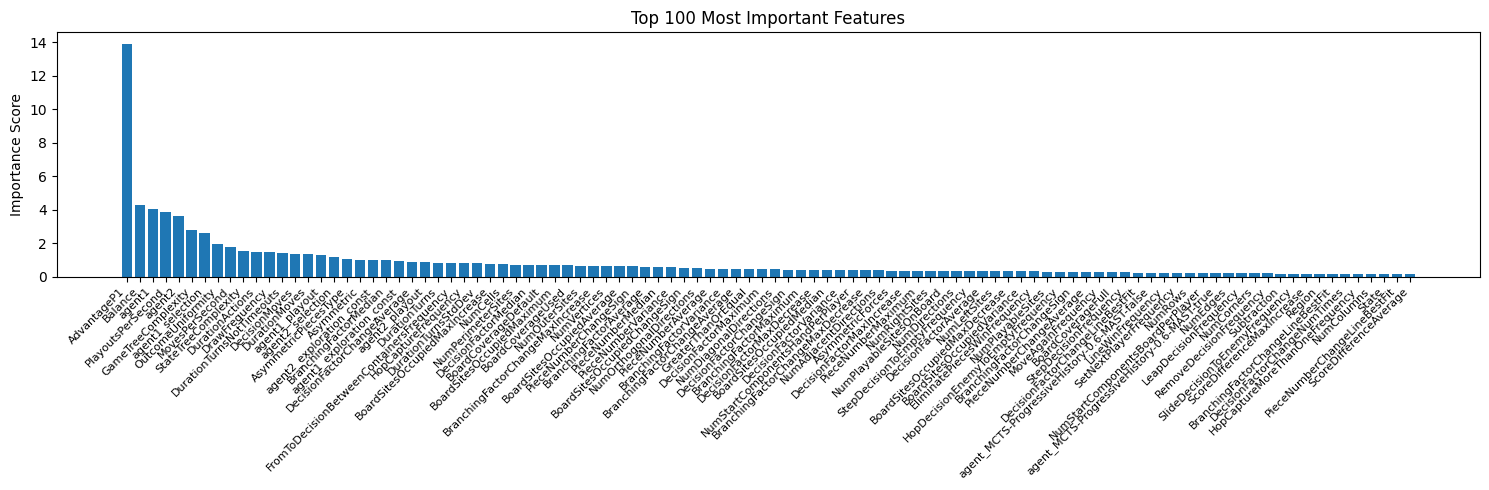

Fold 3 - RMSE: 0.4117492395680674
Fold 4


0:	learn: 0.6283556	test: 0.5759292	best: 0.5759292 (0)	total: 98.3ms	remaining: 16m 23s


50:	learn: 0.4926299	test: 0.5096431	best: 0.5096431 (50)	total: 5.47s	remaining: 17m 47s


100:	learn: 0.4448178	test: 0.4878864	best: 0.4878864 (100)	total: 11.1s	remaining: 18m 3s


150:	learn: 0.4204103	test: 0.4749484	best: 0.4749484 (150)	total: 16.7s	remaining: 18m 10s


200:	learn: 0.4029678	test: 0.4651955	best: 0.4651955 (200)	total: 22.5s	remaining: 18m 19s


250:	learn: 0.3896451	test: 0.4584328	best: 0.4584328 (250)	total: 28.5s	remaining: 18m 26s


300:	learn: 0.3783514	test: 0.4531379	best: 0.4531379 (300)	total: 34.9s	remaining: 18m 43s


350:	learn: 0.3693872	test: 0.4493723	best: 0.4493723 (350)	total: 40.9s	remaining: 18m 43s


400:	learn: 0.3619547	test: 0.4465042	best: 0.4465042 (400)	total: 46.8s	remaining: 18m 40s


450:	learn: 0.3553540	test: 0.4440258	best: 0.4440244 (449)	total: 52.8s	remaining: 18m 38s


500:	learn: 0.3493503	test: 0.4415949	best: 0.4415949 (500)	total: 58.9s	remaining: 18m 36s


550:	learn: 0.3434933	test: 0.4398638	best: 0.4398638 (550)	total: 1m 4s	remaining: 18m 30s


600:	learn: 0.3379923	test: 0.4380040	best: 0.4380040 (600)	total: 1m 10s	remaining: 18m 22s


650:	learn: 0.3331075	test: 0.4363199	best: 0.4363199 (650)	total: 1m 16s	remaining: 18m 17s


700:	learn: 0.3285043	test: 0.4352970	best: 0.4352809 (696)	total: 1m 22s	remaining: 18m 11s


750:	learn: 0.3241691	test: 0.4338391	best: 0.4338391 (750)	total: 1m 28s	remaining: 18m 3s


800:	learn: 0.3203484	test: 0.4328358	best: 0.4328358 (800)	total: 1m 33s	remaining: 17m 57s


850:	learn: 0.3169736	test: 0.4318105	best: 0.4318073 (849)	total: 1m 39s	remaining: 17m 51s


900:	learn: 0.3137039	test: 0.4308526	best: 0.4308526 (900)	total: 1m 45s	remaining: 17m 46s


950:	learn: 0.3109546	test: 0.4303058	best: 0.4303058 (950)	total: 1m 51s	remaining: 17m 41s


1000:	learn: 0.3080252	test: 0.4296850	best: 0.4296771 (999)	total: 1m 57s	remaining: 17m 36s


1050:	learn: 0.3052850	test: 0.4287907	best: 0.4287907 (1050)	total: 2m 3s	remaining: 17m 30s


1100:	learn: 0.3027098	test: 0.4281764	best: 0.4281764 (1100)	total: 2m 9s	remaining: 17m 24s


1150:	learn: 0.3003417	test: 0.4275487	best: 0.4275487 (1150)	total: 2m 15s	remaining: 17m 19s


1200:	learn: 0.2979788	test: 0.4270163	best: 0.4270163 (1200)	total: 2m 21s	remaining: 17m 13s


1250:	learn: 0.2959234	test: 0.4266233	best: 0.4266233 (1250)	total: 2m 26s	remaining: 17m 7s


1300:	learn: 0.2939854	test: 0.4262886	best: 0.4262886 (1300)	total: 2m 32s	remaining: 17m 1s


1350:	learn: 0.2920119	test: 0.4259696	best: 0.4259696 (1350)	total: 2m 38s	remaining: 16m 55s


1400:	learn: 0.2901970	test: 0.4257464	best: 0.4257464 (1400)	total: 2m 44s	remaining: 16m 50s


1450:	learn: 0.2883215	test: 0.4253909	best: 0.4253863 (1449)	total: 2m 50s	remaining: 16m 44s


1500:	learn: 0.2863342	test: 0.4249259	best: 0.4249259 (1500)	total: 2m 56s	remaining: 16m 38s


1550:	learn: 0.2847164	test: 0.4246419	best: 0.4246349 (1545)	total: 3m 2s	remaining: 16m 32s


1600:	learn: 0.2830380	test: 0.4243907	best: 0.4243907 (1600)	total: 3m 8s	remaining: 16m 27s


1650:	learn: 0.2815533	test: 0.4242603	best: 0.4242603 (1650)	total: 3m 14s	remaining: 16m 21s


1700:	learn: 0.2800787	test: 0.4240818	best: 0.4240584 (1694)	total: 3m 20s	remaining: 16m 15s


1750:	learn: 0.2785630	test: 0.4238490	best: 0.4238490 (1750)	total: 3m 25s	remaining: 16m 9s


1800:	learn: 0.2770691	test: 0.4235926	best: 0.4235926 (1800)	total: 3m 31s	remaining: 16m 3s


1850:	learn: 0.2757274	test: 0.4233914	best: 0.4233914 (1850)	total: 3m 37s	remaining: 15m 57s


1900:	learn: 0.2741774	test: 0.4231016	best: 0.4231016 (1900)	total: 3m 43s	remaining: 15m 51s


1950:	learn: 0.2728583	test: 0.4229132	best: 0.4229098 (1945)	total: 3m 49s	remaining: 15m 46s


2000:	learn: 0.2715292	test: 0.4226472	best: 0.4226411 (1999)	total: 3m 55s	remaining: 15m 40s


2050:	learn: 0.2701761	test: 0.4223765	best: 0.4223705 (2049)	total: 4m 1s	remaining: 15m 34s


2100:	learn: 0.2688622	test: 0.4221195	best: 0.4221195 (2100)	total: 4m 7s	remaining: 15m 29s


2150:	learn: 0.2675756	test: 0.4218713	best: 0.4218713 (2150)	total: 4m 13s	remaining: 15m 23s


2200:	learn: 0.2663724	test: 0.4216933	best: 0.4216914 (2199)	total: 4m 19s	remaining: 15m 18s


2250:	learn: 0.2651612	test: 0.4214767	best: 0.4214767 (2250)	total: 4m 25s	remaining: 15m 12s


2300:	learn: 0.2640065	test: 0.4213593	best: 0.4213580 (2296)	total: 4m 31s	remaining: 15m 7s


2350:	learn: 0.2628787	test: 0.4211628	best: 0.4211577 (2348)	total: 4m 37s	remaining: 15m 1s


2400:	learn: 0.2617826	test: 0.4209709	best: 0.4209709 (2400)	total: 4m 43s	remaining: 14m 55s


2450:	learn: 0.2606560	test: 0.4208176	best: 0.4208176 (2450)	total: 4m 49s	remaining: 14m 50s


2500:	learn: 0.2596415	test: 0.4206228	best: 0.4206228 (2500)	total: 4m 54s	remaining: 14m 44s


2550:	learn: 0.2585719	test: 0.4204689	best: 0.4204490 (2546)	total: 5m 1s	remaining: 14m 38s


2600:	learn: 0.2576154	test: 0.4203944	best: 0.4203837 (2594)	total: 5m 7s	remaining: 14m 33s


2650:	learn: 0.2566074	test: 0.4202630	best: 0.4202630 (2650)	total: 5m 13s	remaining: 14m 28s


2700:	learn: 0.2555925	test: 0.4201195	best: 0.4201195 (2700)	total: 5m 19s	remaining: 14m 22s


2750:	learn: 0.2546900	test: 0.4199817	best: 0.4199816 (2740)	total: 5m 25s	remaining: 14m 16s


2800:	learn: 0.2538383	test: 0.4198659	best: 0.4198591 (2794)	total: 5m 31s	remaining: 14m 11s


2850:	learn: 0.2529370	test: 0.4197378	best: 0.4197378 (2850)	total: 5m 37s	remaining: 14m 5s


2900:	learn: 0.2520040	test: 0.4195784	best: 0.4195726 (2898)	total: 5m 43s	remaining: 13m 59s


2950:	learn: 0.2510942	test: 0.4195375	best: 0.4195338 (2949)	total: 5m 49s	remaining: 13m 54s


3000:	learn: 0.2501622	test: 0.4194429	best: 0.4194291 (2995)	total: 5m 55s	remaining: 13m 48s


3050:	learn: 0.2493724	test: 0.4193623	best: 0.4193617 (3049)	total: 6m 1s	remaining: 13m 42s


3100:	learn: 0.2485678	test: 0.4193050	best: 0.4193050 (3100)	total: 6m 7s	remaining: 13m 37s


3150:	learn: 0.2477634	test: 0.4192316	best: 0.4192273 (3143)	total: 6m 13s	remaining: 13m 31s


3200:	learn: 0.2470532	test: 0.4191327	best: 0.4191327 (3200)	total: 6m 19s	remaining: 13m 26s


3250:	learn: 0.2463184	test: 0.4190768	best: 0.4190696 (3247)	total: 6m 25s	remaining: 13m 20s


3300:	learn: 0.2455851	test: 0.4189908	best: 0.4189843 (3288)	total: 6m 31s	remaining: 13m 14s


3350:	learn: 0.2448237	test: 0.4189053	best: 0.4189053 (3350)	total: 6m 37s	remaining: 13m 8s


3400:	learn: 0.2440356	test: 0.4187945	best: 0.4187815 (3398)	total: 6m 43s	remaining: 13m 3s


3450:	learn: 0.2432342	test: 0.4187145	best: 0.4187013 (3446)	total: 6m 49s	remaining: 12m 57s


3500:	learn: 0.2425370	test: 0.4185926	best: 0.4185914 (3499)	total: 6m 55s	remaining: 12m 51s


3550:	learn: 0.2417879	test: 0.4184953	best: 0.4184953 (3550)	total: 7m 1s	remaining: 12m 45s


3600:	learn: 0.2411338	test: 0.4183955	best: 0.4183947 (3599)	total: 7m 7s	remaining: 12m 39s


3650:	learn: 0.2403270	test: 0.4183113	best: 0.4183099 (3649)	total: 7m 13s	remaining: 12m 34s


3700:	learn: 0.2395929	test: 0.4181943	best: 0.4181929 (3699)	total: 7m 19s	remaining: 12m 28s


3750:	learn: 0.2389074	test: 0.4181354	best: 0.4181336 (3747)	total: 7m 25s	remaining: 12m 22s


3800:	learn: 0.2381938	test: 0.4180162	best: 0.4180162 (3800)	total: 7m 31s	remaining: 12m 16s


3850:	learn: 0.2374937	test: 0.4179618	best: 0.4179618 (3850)	total: 7m 37s	remaining: 12m 10s


3900:	learn: 0.2368438	test: 0.4179291	best: 0.4179230 (3892)	total: 7m 43s	remaining: 12m 4s


3950:	learn: 0.2362020	test: 0.4178630	best: 0.4178612 (3949)	total: 7m 49s	remaining: 11m 58s


4000:	learn: 0.2356073	test: 0.4177796	best: 0.4177796 (4000)	total: 7m 55s	remaining: 11m 52s


4050:	learn: 0.2349690	test: 0.4177175	best: 0.4177152 (4031)	total: 8m 1s	remaining: 11m 46s


4100:	learn: 0.2343497	test: 0.4176426	best: 0.4176426 (4100)	total: 8m 7s	remaining: 11m 41s


4150:	learn: 0.2337195	test: 0.4175679	best: 0.4175679 (4150)	total: 8m 13s	remaining: 11m 35s


4200:	learn: 0.2331047	test: 0.4175031	best: 0.4174947 (4196)	total: 8m 19s	remaining: 11m 29s


4250:	learn: 0.2324612	test: 0.4174459	best: 0.4174459 (4250)	total: 8m 25s	remaining: 11m 23s


4300:	learn: 0.2318940	test: 0.4174046	best: 0.4173994 (4289)	total: 8m 31s	remaining: 11m 17s


4350:	learn: 0.2313017	test: 0.4173402	best: 0.4173402 (4350)	total: 8m 37s	remaining: 11m 11s


4400:	learn: 0.2307240	test: 0.4172624	best: 0.4172624 (4400)	total: 8m 43s	remaining: 11m 5s


4450:	learn: 0.2301661	test: 0.4171811	best: 0.4171811 (4450)	total: 8m 49s	remaining: 10m 59s


4500:	learn: 0.2295885	test: 0.4171139	best: 0.4171135 (4497)	total: 8m 55s	remaining: 10m 53s


4550:	learn: 0.2289899	test: 0.4170873	best: 0.4170873 (4550)	total: 9m 1s	remaining: 10m 47s


4600:	learn: 0.2283942	test: 0.4170536	best: 0.4170480 (4598)	total: 9m 7s	remaining: 10m 42s


4650:	learn: 0.2278541	test: 0.4170383	best: 0.4170292 (4629)	total: 9m 13s	remaining: 10m 36s


4700:	learn: 0.2272991	test: 0.4170026	best: 0.4170026 (4700)	total: 9m 18s	remaining: 10m 30s


4750:	learn: 0.2267618	test: 0.4169404	best: 0.4169404 (4750)	total: 9m 24s	remaining: 10m 24s


4800:	learn: 0.2262094	test: 0.4168962	best: 0.4168931 (4798)	total: 9m 30s	remaining: 10m 18s


4850:	learn: 0.2256627	test: 0.4168720	best: 0.4168720 (4849)	total: 9m 37s	remaining: 10m 12s


4900:	learn: 0.2251448	test: 0.4168339	best: 0.4168266 (4897)	total: 9m 43s	remaining: 10m 6s


4950:	learn: 0.2246133	test: 0.4167845	best: 0.4167823 (4949)	total: 9m 49s	remaining: 10m


5000:	learn: 0.2240792	test: 0.4167285	best: 0.4167285 (5000)	total: 9m 55s	remaining: 9m 54s


5050:	learn: 0.2235136	test: 0.4166835	best: 0.4166832 (5048)	total: 10m 1s	remaining: 9m 48s


5100:	learn: 0.2230192	test: 0.4166160	best: 0.4166160 (5100)	total: 10m 7s	remaining: 9m 43s


5150:	learn: 0.2225277	test: 0.4165695	best: 0.4165695 (5150)	total: 10m 13s	remaining: 9m 37s


5200:	learn: 0.2220272	test: 0.4165136	best: 0.4165136 (5200)	total: 10m 19s	remaining: 9m 31s


5250:	learn: 0.2215504	test: 0.4164839	best: 0.4164729 (5231)	total: 10m 25s	remaining: 9m 25s


5300:	learn: 0.2210551	test: 0.4164476	best: 0.4164476 (5300)	total: 10m 31s	remaining: 9m 19s


5350:	learn: 0.2205654	test: 0.4164128	best: 0.4164107 (5346)	total: 10m 37s	remaining: 9m 13s


5400:	learn: 0.2200968	test: 0.4163836	best: 0.4163815 (5397)	total: 10m 43s	remaining: 9m 7s


5450:	learn: 0.2196629	test: 0.4163498	best: 0.4163447 (5445)	total: 10m 49s	remaining: 9m 1s


5500:	learn: 0.2191864	test: 0.4163202	best: 0.4163199 (5493)	total: 10m 55s	remaining: 8m 55s


5550:	learn: 0.2187059	test: 0.4162987	best: 0.4162951 (5549)	total: 11m 1s	remaining: 8m 49s


5600:	learn: 0.2182581	test: 0.4162507	best: 0.4162485 (5597)	total: 11m 7s	remaining: 8m 44s


5650:	learn: 0.2178358	test: 0.4162269	best: 0.4162199 (5640)	total: 11m 13s	remaining: 8m 38s


5700:	learn: 0.2173984	test: 0.4162017	best: 0.4162003 (5699)	total: 11m 19s	remaining: 8m 32s


5750:	learn: 0.2169375	test: 0.4161389	best: 0.4161382 (5745)	total: 11m 25s	remaining: 8m 26s


5800:	learn: 0.2164862	test: 0.4161031	best: 0.4161016 (5799)	total: 11m 31s	remaining: 8m 20s


5850:	learn: 0.2160269	test: 0.4161409	best: 0.4161016 (5799)	total: 11m 37s	remaining: 8m 14s


5900:	learn: 0.2156067	test: 0.4161104	best: 0.4161016 (5799)	total: 11m 43s	remaining: 8m 8s


5950:	learn: 0.2151624	test: 0.4160586	best: 0.4160578 (5949)	total: 11m 49s	remaining: 8m 2s


6000:	learn: 0.2147075	test: 0.4160347	best: 0.4160317 (5975)	total: 11m 55s	remaining: 7m 56s


6050:	learn: 0.2142663	test: 0.4159929	best: 0.4159892 (6046)	total: 12m 1s	remaining: 7m 50s


6100:	learn: 0.2138189	test: 0.4159538	best: 0.4159516 (6099)	total: 12m 7s	remaining: 7m 44s


6150:	learn: 0.2133730	test: 0.4159381	best: 0.4159320 (6142)	total: 12m 13s	remaining: 7m 38s


6200:	learn: 0.2129150	test: 0.4159159	best: 0.4159149 (6199)	total: 12m 19s	remaining: 7m 32s


6250:	learn: 0.2125013	test: 0.4158738	best: 0.4158729 (6249)	total: 12m 25s	remaining: 7m 27s


6300:	learn: 0.2120903	test: 0.4158292	best: 0.4158292 (6300)	total: 12m 31s	remaining: 7m 21s


6350:	learn: 0.2116931	test: 0.4158387	best: 0.4158234 (6308)	total: 12m 37s	remaining: 7m 15s


6400:	learn: 0.2112752	test: 0.4158201	best: 0.4158175 (6388)	total: 12m 43s	remaining: 7m 9s


6450:	learn: 0.2108714	test: 0.4158429	best: 0.4158175 (6388)	total: 12m 49s	remaining: 7m 3s


6500:	learn: 0.2104959	test: 0.4158120	best: 0.4158120 (6500)	total: 12m 55s	remaining: 6m 57s


6550:	learn: 0.2100962	test: 0.4157939	best: 0.4157935 (6549)	total: 13m 1s	remaining: 6m 51s


6600:	learn: 0.2096628	test: 0.4157758	best: 0.4157758 (6600)	total: 13m 7s	remaining: 6m 45s


6650:	learn: 0.2092464	test: 0.4157620	best: 0.4157585 (6643)	total: 13m 13s	remaining: 6m 39s


6700:	learn: 0.2088287	test: 0.4157580	best: 0.4157575 (6698)	total: 13m 20s	remaining: 6m 33s


6750:	learn: 0.2084460	test: 0.4157063	best: 0.4157053 (6742)	total: 13m 26s	remaining: 6m 27s


6800:	learn: 0.2080649	test: 0.4157161	best: 0.4157053 (6751)	total: 13m 32s	remaining: 6m 22s


6850:	learn: 0.2076834	test: 0.4156687	best: 0.4156682 (6848)	total: 13m 38s	remaining: 6m 16s


6900:	learn: 0.2073080	test: 0.4156715	best: 0.4156682 (6848)	total: 13m 44s	remaining: 6m 10s


6950:	learn: 0.2069152	test: 0.4156453	best: 0.4156453 (6950)	total: 13m 50s	remaining: 6m 4s


7000:	learn: 0.2065430	test: 0.4156226	best: 0.4156226 (6996)	total: 13m 56s	remaining: 5m 58s


7050:	learn: 0.2061895	test: 0.4155878	best: 0.4155876 (7049)	total: 14m 2s	remaining: 5m 52s


7100:	learn: 0.2058163	test: 0.4155899	best: 0.4155825 (7054)	total: 14m 8s	remaining: 5m 46s


7150:	learn: 0.2054220	test: 0.4155835	best: 0.4155790 (7137)	total: 14m 14s	remaining: 5m 40s


7200:	learn: 0.2050814	test: 0.4155962	best: 0.4155743 (7157)	total: 14m 20s	remaining: 5m 34s


7250:	learn: 0.2047311	test: 0.4155797	best: 0.4155743 (7157)	total: 14m 26s	remaining: 5m 28s


7300:	learn: 0.2043781	test: 0.4155526	best: 0.4155526 (7300)	total: 14m 32s	remaining: 5m 22s


7350:	learn: 0.2040200	test: 0.4155342	best: 0.4155342 (7350)	total: 14m 38s	remaining: 5m 16s


7400:	learn: 0.2036833	test: 0.4155177	best: 0.4155157 (7398)	total: 14m 44s	remaining: 5m 10s


7450:	learn: 0.2033310	test: 0.4155110	best: 0.4155080 (7447)	total: 14m 50s	remaining: 5m 4s


7500:	learn: 0.2029653	test: 0.4154940	best: 0.4154922 (7498)	total: 14m 56s	remaining: 4m 58s


7550:	learn: 0.2025693	test: 0.4154688	best: 0.4154673 (7546)	total: 15m 2s	remaining: 4m 52s


7600:	learn: 0.2022185	test: 0.4154498	best: 0.4154498 (7600)	total: 15m 8s	remaining: 4m 46s


7650:	learn: 0.2018644	test: 0.4154227	best: 0.4154225 (7643)	total: 15m 14s	remaining: 4m 40s


7700:	learn: 0.2015226	test: 0.4154167	best: 0.4154064 (7676)	total: 15m 20s	remaining: 4m 34s


7750:	learn: 0.2011585	test: 0.4153786	best: 0.4153786 (7750)	total: 15m 26s	remaining: 4m 28s


7800:	learn: 0.2008466	test: 0.4153635	best: 0.4153635 (7800)	total: 15m 32s	remaining: 4m 22s


7850:	learn: 0.2004511	test: 0.4153173	best: 0.4153139 (7841)	total: 15m 38s	remaining: 4m 16s


7900:	learn: 0.2001027	test: 0.4152908	best: 0.4152887 (7894)	total: 15m 44s	remaining: 4m 10s


7950:	learn: 0.1997629	test: 0.4152764	best: 0.4152740 (7947)	total: 15m 50s	remaining: 4m 4s


8000:	learn: 0.1994067	test: 0.4152687	best: 0.4152632 (7986)	total: 15m 56s	remaining: 3m 59s


8050:	learn: 0.1990847	test: 0.4152735	best: 0.4152566 (8032)	total: 16m 2s	remaining: 3m 53s


8100:	learn: 0.1987446	test: 0.4152328	best: 0.4152314 (8099)	total: 16m 8s	remaining: 3m 47s


8150:	learn: 0.1984382	test: 0.4152342	best: 0.4152263 (8149)	total: 16m 14s	remaining: 3m 41s


8200:	learn: 0.1981268	test: 0.4152317	best: 0.4152263 (8149)	total: 16m 20s	remaining: 3m 35s


8250:	learn: 0.1977782	test: 0.4152193	best: 0.4152190 (8249)	total: 16m 26s	remaining: 3m 29s


8300:	learn: 0.1974589	test: 0.4152144	best: 0.4152115 (8294)	total: 16m 32s	remaining: 3m 23s


8350:	learn: 0.1971467	test: 0.4152149	best: 0.4152101 (8305)	total: 16m 38s	remaining: 3m 17s


8400:	learn: 0.1968237	test: 0.4151935	best: 0.4151921 (8391)	total: 16m 44s	remaining: 3m 11s


8450:	learn: 0.1965160	test: 0.4151774	best: 0.4151751 (8441)	total: 16m 50s	remaining: 3m 5s


8500:	learn: 0.1961861	test: 0.4151637	best: 0.4151637 (8500)	total: 16m 57s	remaining: 2m 59s


8550:	learn: 0.1958758	test: 0.4151607	best: 0.4151607 (8550)	total: 17m 3s	remaining: 2m 53s


8600:	learn: 0.1955470	test: 0.4151536	best: 0.4151494 (8582)	total: 17m 9s	remaining: 2m 47s


8650:	learn: 0.1952203	test: 0.4151276	best: 0.4151276 (8650)	total: 17m 15s	remaining: 2m 41s


8700:	learn: 0.1948866	test: 0.4151092	best: 0.4151027 (8692)	total: 17m 21s	remaining: 2m 35s


8750:	learn: 0.1945674	test: 0.4150981	best: 0.4150910 (8738)	total: 17m 27s	remaining: 2m 29s


8800:	learn: 0.1942329	test: 0.4150497	best: 0.4150493 (8797)	total: 17m 33s	remaining: 2m 23s


8850:	learn: 0.1938939	test: 0.4150396	best: 0.4150382 (8824)	total: 17m 39s	remaining: 2m 17s


8900:	learn: 0.1935871	test: 0.4150306	best: 0.4150298 (8894)	total: 17m 45s	remaining: 2m 11s


8950:	learn: 0.1932580	test: 0.4150248	best: 0.4150222 (8948)	total: 17m 51s	remaining: 2m 5s


9000:	learn: 0.1929321	test: 0.4150030	best: 0.4150026 (8978)	total: 17m 57s	remaining: 1m 59s


9050:	learn: 0.1926038	test: 0.4149905	best: 0.4149872 (9028)	total: 18m 3s	remaining: 1m 53s


9100:	learn: 0.1922906	test: 0.4149685	best: 0.4149679 (9098)	total: 18m 9s	remaining: 1m 47s


9150:	learn: 0.1920148	test: 0.4149679	best: 0.4149643 (9145)	total: 18m 15s	remaining: 1m 41s


9200:	learn: 0.1917168	test: 0.4149530	best: 0.4149453 (9178)	total: 18m 21s	remaining: 1m 35s


9250:	learn: 0.1913770	test: 0.4149412	best: 0.4149390 (9249)	total: 18m 27s	remaining: 1m 29s


9300:	learn: 0.1910706	test: 0.4149200	best: 0.4149199 (9299)	total: 18m 33s	remaining: 1m 23s


9350:	learn: 0.1907725	test: 0.4149173	best: 0.4149145 (9322)	total: 18m 39s	remaining: 1m 17s


9400:	learn: 0.1905018	test: 0.4149038	best: 0.4149038 (9400)	total: 18m 45s	remaining: 1m 11s


9450:	learn: 0.1902018	test: 0.4149013	best: 0.4148936 (9444)	total: 18m 51s	remaining: 1m 5s


9500:	learn: 0.1899155	test: 0.4148983	best: 0.4148911 (9493)	total: 18m 57s	remaining: 59.7s


9550:	learn: 0.1896047	test: 0.4148727	best: 0.4148727 (9550)	total: 19m 3s	remaining: 53.7s


9600:	learn: 0.1893119	test: 0.4148410	best: 0.4148379 (9573)	total: 19m 9s	remaining: 47.8s


9650:	learn: 0.1889979	test: 0.4148414	best: 0.4148361 (9618)	total: 19m 15s	remaining: 41.8s


9700:	learn: 0.1886892	test: 0.4148327	best: 0.4148274 (9689)	total: 19m 21s	remaining: 35.8s


9750:	learn: 0.1883906	test: 0.4148204	best: 0.4148168 (9728)	total: 19m 27s	remaining: 29.8s


9800:	learn: 0.1881235	test: 0.4148014	best: 0.4147980 (9791)	total: 19m 33s	remaining: 23.8s


9850:	learn: 0.1878175	test: 0.4147877	best: 0.4147877 (9850)	total: 19m 39s	remaining: 17.8s


9900:	learn: 0.1875068	test: 0.4147796	best: 0.4147789 (9879)	total: 19m 45s	remaining: 11.8s


9950:	learn: 0.1872286	test: 0.4147828	best: 0.4147739 (9915)	total: 19m 51s	remaining: 5.87s


9999:	learn: 0.1869604	test: 0.4147723	best: 0.4147679 (9995)	total: 19m 56s	remaining: 0us

bestTest = 0.4147679398
bestIteration = 9995

Shrink model to first 9996 iterations.


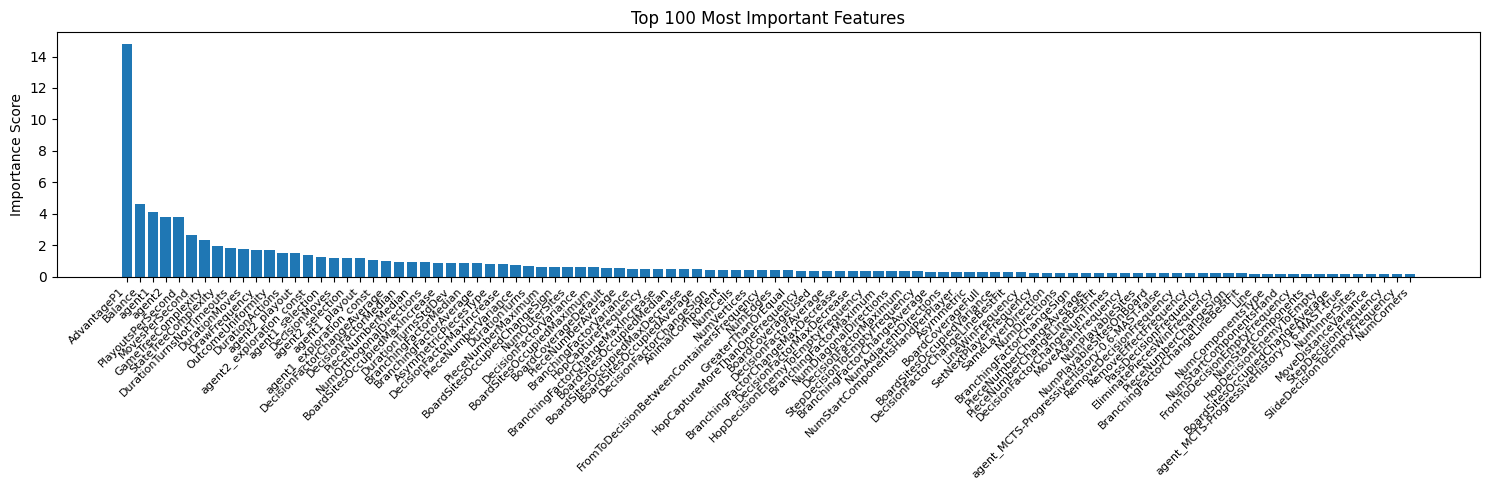

Fold 4 - RMSE: 0.41420362959306356
Fold 5


0:	learn: 0.6244757	test: 0.5865631	best: 0.5865631 (0)	total: 88.3ms	remaining: 14m 42s


50:	learn: 0.4886293	test: 0.5347411	best: 0.5347411 (50)	total: 5.48s	remaining: 17m 49s


100:	learn: 0.4428290	test: 0.5066121	best: 0.5066121 (100)	total: 11.2s	remaining: 18m 20s


150:	learn: 0.4166789	test: 0.4913756	best: 0.4913756 (150)	total: 17.1s	remaining: 18m 38s


200:	learn: 0.3995078	test: 0.4812224	best: 0.4812224 (200)	total: 23.3s	remaining: 18m 54s


250:	learn: 0.3859276	test: 0.4736156	best: 0.4736156 (250)	total: 29.4s	remaining: 19m 1s


300:	learn: 0.3752634	test: 0.4671863	best: 0.4671863 (300)	total: 35.7s	remaining: 19m 8s


350:	learn: 0.3666920	test: 0.4624866	best: 0.4624866 (350)	total: 41.9s	remaining: 19m 12s


400:	learn: 0.3593064	test: 0.4586346	best: 0.4586346 (400)	total: 48s	remaining: 19m 9s


450:	learn: 0.3526428	test: 0.4553370	best: 0.4553370 (450)	total: 54s	remaining: 19m 4s


500:	learn: 0.3463832	test: 0.4520051	best: 0.4520051 (500)	total: 1m	remaining: 19m


550:	learn: 0.3406856	test: 0.4490564	best: 0.4490564 (550)	total: 1m 6s	remaining: 18m 52s


600:	learn: 0.3357253	test: 0.4470211	best: 0.4470211 (600)	total: 1m 12s	remaining: 18m 46s


650:	learn: 0.3310010	test: 0.4452021	best: 0.4452021 (650)	total: 1m 17s	remaining: 18m 38s


700:	learn: 0.3269240	test: 0.4433668	best: 0.4433668 (700)	total: 1m 23s	remaining: 18m 33s


750:	learn: 0.3232121	test: 0.4417804	best: 0.4417804 (750)	total: 1m 29s	remaining: 18m 26s


800:	learn: 0.3195586	test: 0.4404927	best: 0.4404927 (800)	total: 1m 35s	remaining: 18m 21s


850:	learn: 0.3161246	test: 0.4394979	best: 0.4394979 (850)	total: 1m 41s	remaining: 18m 16s


900:	learn: 0.3130020	test: 0.4384522	best: 0.4384522 (900)	total: 1m 47s	remaining: 18m 9s


950:	learn: 0.3099846	test: 0.4373114	best: 0.4373114 (950)	total: 1m 53s	remaining: 18m 4s


1000:	learn: 0.3072549	test: 0.4364134	best: 0.4364134 (1000)	total: 2m	remaining: 17m 59s


1050:	learn: 0.3048013	test: 0.4358592	best: 0.4358592 (1050)	total: 2m 6s	remaining: 17m 55s


1100:	learn: 0.3023254	test: 0.4353140	best: 0.4353140 (1100)	total: 2m 12s	remaining: 17m 50s


1150:	learn: 0.2998751	test: 0.4346117	best: 0.4346117 (1150)	total: 2m 18s	remaining: 17m 45s


1200:	learn: 0.2977575	test: 0.4339873	best: 0.4339873 (1200)	total: 2m 24s	remaining: 17m 40s


1250:	learn: 0.2956756	test: 0.4335243	best: 0.4335243 (1250)	total: 2m 30s	remaining: 17m 35s


1300:	learn: 0.2936142	test: 0.4329533	best: 0.4329533 (1300)	total: 2m 37s	remaining: 17m 29s


1350:	learn: 0.2914900	test: 0.4324249	best: 0.4324249 (1350)	total: 2m 43s	remaining: 17m 24s


1400:	learn: 0.2896016	test: 0.4319520	best: 0.4319520 (1400)	total: 2m 49s	remaining: 17m 18s


1450:	learn: 0.2878445	test: 0.4316022	best: 0.4316022 (1450)	total: 2m 55s	remaining: 17m 12s


1500:	learn: 0.2860492	test: 0.4311969	best: 0.4311969 (1500)	total: 3m 1s	remaining: 17m 6s


1550:	learn: 0.2843910	test: 0.4308963	best: 0.4308963 (1550)	total: 3m 7s	remaining: 17m 1s


1600:	learn: 0.2826652	test: 0.4304602	best: 0.4304602 (1600)	total: 3m 13s	remaining: 16m 55s


1650:	learn: 0.2809998	test: 0.4301895	best: 0.4301895 (1650)	total: 3m 19s	remaining: 16m 49s


1700:	learn: 0.2794897	test: 0.4299203	best: 0.4299151 (1696)	total: 3m 25s	remaining: 16m 44s


1750:	learn: 0.2781104	test: 0.4296414	best: 0.4296378 (1749)	total: 3m 32s	remaining: 16m 38s


1800:	learn: 0.2766077	test: 0.4294868	best: 0.4294576 (1794)	total: 3m 38s	remaining: 16m 33s


1850:	learn: 0.2752090	test: 0.4291745	best: 0.4291745 (1850)	total: 3m 44s	remaining: 16m 28s


1900:	learn: 0.2737716	test: 0.4288613	best: 0.4288613 (1900)	total: 3m 50s	remaining: 16m 22s


1950:	learn: 0.2723765	test: 0.4286658	best: 0.4286658 (1950)	total: 3m 56s	remaining: 16m 16s


2000:	learn: 0.2710232	test: 0.4285403	best: 0.4285316 (1999)	total: 4m 2s	remaining: 16m 10s


2050:	learn: 0.2697361	test: 0.4281931	best: 0.4281931 (2050)	total: 4m 9s	remaining: 16m 5s


2100:	learn: 0.2684605	test: 0.4279325	best: 0.4279307 (2099)	total: 4m 15s	remaining: 15m 59s


2150:	learn: 0.2671553	test: 0.4276701	best: 0.4276652 (2133)	total: 4m 21s	remaining: 15m 53s


2200:	learn: 0.2659627	test: 0.4274851	best: 0.4274851 (2200)	total: 4m 27s	remaining: 15m 47s


2250:	learn: 0.2647775	test: 0.4272441	best: 0.4272405 (2249)	total: 4m 33s	remaining: 15m 41s


2300:	learn: 0.2636293	test: 0.4270983	best: 0.4270965 (2294)	total: 4m 39s	remaining: 15m 36s


2350:	learn: 0.2624585	test: 0.4269693	best: 0.4269619 (2347)	total: 4m 45s	remaining: 15m 29s


2400:	learn: 0.2613516	test: 0.4268822	best: 0.4268795 (2390)	total: 4m 51s	remaining: 15m 23s


2450:	learn: 0.2602661	test: 0.4266850	best: 0.4266850 (2450)	total: 4m 58s	remaining: 15m 17s


2500:	learn: 0.2592347	test: 0.4265706	best: 0.4265706 (2500)	total: 5m 4s	remaining: 15m 12s


2550:	learn: 0.2582166	test: 0.4263796	best: 0.4263746 (2548)	total: 5m 10s	remaining: 15m 6s


2600:	learn: 0.2572170	test: 0.4262880	best: 0.4262859 (2599)	total: 5m 16s	remaining: 15m


2650:	learn: 0.2562699	test: 0.4261017	best: 0.4261017 (2650)	total: 5m 22s	remaining: 14m 54s


2700:	learn: 0.2553007	test: 0.4260116	best: 0.4259989 (2694)	total: 5m 28s	remaining: 14m 49s


2750:	learn: 0.2543365	test: 0.4259244	best: 0.4259244 (2750)	total: 5m 35s	remaining: 14m 43s


2800:	learn: 0.2533869	test: 0.4257356	best: 0.4257356 (2800)	total: 5m 41s	remaining: 14m 37s


2850:	learn: 0.2525543	test: 0.4256125	best: 0.4256125 (2850)	total: 5m 47s	remaining: 14m 31s


2900:	learn: 0.2516381	test: 0.4255040	best: 0.4255040 (2900)	total: 5m 53s	remaining: 14m 25s


2950:	learn: 0.2507181	test: 0.4253553	best: 0.4253497 (2948)	total: 5m 59s	remaining: 14m 19s


3000:	learn: 0.2497989	test: 0.4252623	best: 0.4252515 (2997)	total: 6m 5s	remaining: 14m 13s


3050:	learn: 0.2488970	test: 0.4251701	best: 0.4251598 (3047)	total: 6m 12s	remaining: 14m 7s


3100:	learn: 0.2480464	test: 0.4250915	best: 0.4250909 (3095)	total: 6m 18s	remaining: 14m 1s


3150:	learn: 0.2472371	test: 0.4250085	best: 0.4250085 (3150)	total: 6m 24s	remaining: 13m 55s


3200:	learn: 0.2464434	test: 0.4248959	best: 0.4248959 (3200)	total: 6m 30s	remaining: 13m 49s


3250:	learn: 0.2456417	test: 0.4247898	best: 0.4247898 (3250)	total: 6m 36s	remaining: 13m 43s


3300:	learn: 0.2448344	test: 0.4246502	best: 0.4246502 (3300)	total: 6m 43s	remaining: 13m 38s


3350:	learn: 0.2440099	test: 0.4245583	best: 0.4245554 (3349)	total: 6m 49s	remaining: 13m 32s


3400:	learn: 0.2431694	test: 0.4244953	best: 0.4244953 (3400)	total: 6m 55s	remaining: 13m 25s


3450:	learn: 0.2424286	test: 0.4243960	best: 0.4243960 (3450)	total: 7m 1s	remaining: 13m 19s


3500:	learn: 0.2417497	test: 0.4243176	best: 0.4243146 (3499)	total: 7m 7s	remaining: 13m 13s


3550:	learn: 0.2410465	test: 0.4242271	best: 0.4242271 (3550)	total: 7m 13s	remaining: 13m 7s


3600:	learn: 0.2402938	test: 0.4241056	best: 0.4241056 (3600)	total: 7m 20s	remaining: 13m 1s


3650:	learn: 0.2395663	test: 0.4239803	best: 0.4239797 (3648)	total: 7m 26s	remaining: 12m 55s


3700:	learn: 0.2389037	test: 0.4239291	best: 0.4239277 (3691)	total: 7m 32s	remaining: 12m 50s


3750:	learn: 0.2382884	test: 0.4238769	best: 0.4238754 (3749)	total: 7m 38s	remaining: 12m 44s


3800:	learn: 0.2376446	test: 0.4237978	best: 0.4237978 (3800)	total: 7m 44s	remaining: 12m 38s


3850:	learn: 0.2369785	test: 0.4237186	best: 0.4237186 (3850)	total: 7m 51s	remaining: 12m 32s


3900:	learn: 0.2363348	test: 0.4236781	best: 0.4236756 (3880)	total: 7m 57s	remaining: 12m 26s


3950:	learn: 0.2356817	test: 0.4236404	best: 0.4236312 (3945)	total: 8m 3s	remaining: 12m 20s


4000:	learn: 0.2350286	test: 0.4235685	best: 0.4235681 (3999)	total: 8m 9s	remaining: 12m 14s


4050:	learn: 0.2344190	test: 0.4235149	best: 0.4235130 (4048)	total: 8m 15s	remaining: 12m 7s


4100:	learn: 0.2338566	test: 0.4235012	best: 0.4234987 (4060)	total: 8m 21s	remaining: 12m 1s


4150:	learn: 0.2332459	test: 0.4234607	best: 0.4234607 (4150)	total: 8m 28s	remaining: 11m 55s


4200:	learn: 0.2326582	test: 0.4233929	best: 0.4233871 (4198)	total: 8m 34s	remaining: 11m 50s


4250:	learn: 0.2320270	test: 0.4233042	best: 0.4233032 (4248)	total: 8m 40s	remaining: 11m 43s


4300:	learn: 0.2314488	test: 0.4232698	best: 0.4232612 (4278)	total: 8m 46s	remaining: 11m 37s


4350:	learn: 0.2308708	test: 0.4232692	best: 0.4232572 (4309)	total: 8m 52s	remaining: 11m 31s


4400:	learn: 0.2303075	test: 0.4232074	best: 0.4232060 (4397)	total: 8m 59s	remaining: 11m 25s


4450:	learn: 0.2297448	test: 0.4231396	best: 0.4231396 (4450)	total: 9m 5s	remaining: 11m 19s


4500:	learn: 0.2292067	test: 0.4230684	best: 0.4230625 (4498)	total: 9m 11s	remaining: 11m 13s


4550:	learn: 0.2286530	test: 0.4230465	best: 0.4230450 (4546)	total: 9m 17s	remaining: 11m 7s


4600:	learn: 0.2281609	test: 0.4229989	best: 0.4229985 (4599)	total: 9m 23s	remaining: 11m 1s


4650:	learn: 0.2276235	test: 0.4230166	best: 0.4229954 (4604)	total: 9m 29s	remaining: 10m 55s


4700:	learn: 0.2271286	test: 0.4229471	best: 0.4229469 (4694)	total: 9m 36s	remaining: 10m 49s


4750:	learn: 0.2265897	test: 0.4229652	best: 0.4229419 (4712)	total: 9m 42s	remaining: 10m 43s


4800:	learn: 0.2260742	test: 0.4229341	best: 0.4229335 (4770)	total: 9m 48s	remaining: 10m 37s


4850:	learn: 0.2255360	test: 0.4228713	best: 0.4228708 (4848)	total: 9m 54s	remaining: 10m 31s


4900:	learn: 0.2250015	test: 0.4228160	best: 0.4228160 (4900)	total: 10m	remaining: 10m 25s


4950:	learn: 0.2244990	test: 0.4227437	best: 0.4227437 (4950)	total: 10m 7s	remaining: 10m 19s


5000:	learn: 0.2239995	test: 0.4227532	best: 0.4227384 (4961)	total: 10m 13s	remaining: 10m 13s


5050:	learn: 0.2234765	test: 0.4227400	best: 0.4227357 (5032)	total: 10m 19s	remaining: 10m 7s


5100:	learn: 0.2229648	test: 0.4226997	best: 0.4226997 (5100)	total: 10m 25s	remaining: 10m 1s


5150:	learn: 0.2225105	test: 0.4226675	best: 0.4226660 (5148)	total: 10m 32s	remaining: 9m 55s


5200:	learn: 0.2220474	test: 0.4226448	best: 0.4226263 (5189)	total: 10m 38s	remaining: 9m 49s


5250:	learn: 0.2216033	test: 0.4226062	best: 0.4226062 (5250)	total: 10m 44s	remaining: 9m 42s


5300:	learn: 0.2210940	test: 0.4225546	best: 0.4225505 (5299)	total: 10m 50s	remaining: 9m 36s


5350:	learn: 0.2206254	test: 0.4225194	best: 0.4225194 (5350)	total: 10m 57s	remaining: 9m 30s


5400:	learn: 0.2201715	test: 0.4224716	best: 0.4224664 (5394)	total: 11m 3s	remaining: 9m 24s


5450:	learn: 0.2196751	test: 0.4224578	best: 0.4224482 (5433)	total: 11m 9s	remaining: 9m 18s


5500:	learn: 0.2192167	test: 0.4224250	best: 0.4224145 (5477)	total: 11m 15s	remaining: 9m 12s


5550:	learn: 0.2187732	test: 0.4223916	best: 0.4223889 (5549)	total: 11m 21s	remaining: 9m 6s


5600:	learn: 0.2182878	test: 0.4223527	best: 0.4223473 (5595)	total: 11m 28s	remaining: 9m


5650:	learn: 0.2178008	test: 0.4222858	best: 0.4222858 (5650)	total: 11m 34s	remaining: 8m 54s


5700:	learn: 0.2173093	test: 0.4222736	best: 0.4222698 (5692)	total: 11m 40s	remaining: 8m 48s


5750:	learn: 0.2168196	test: 0.4222224	best: 0.4222190 (5747)	total: 11m 46s	remaining: 8m 42s


5800:	learn: 0.2163789	test: 0.4222149	best: 0.4222149 (5788)	total: 11m 52s	remaining: 8m 35s


5850:	learn: 0.2159350	test: 0.4221665	best: 0.4221665 (5850)	total: 11m 59s	remaining: 8m 29s


5900:	learn: 0.2155011	test: 0.4221753	best: 0.4221575 (5858)	total: 12m 5s	remaining: 8m 23s


5950:	learn: 0.2150441	test: 0.4221527	best: 0.4221527 (5950)	total: 12m 11s	remaining: 8m 17s


6000:	learn: 0.2146138	test: 0.4221274	best: 0.4221274 (6000)	total: 12m 18s	remaining: 8m 11s


6050:	learn: 0.2142047	test: 0.4220931	best: 0.4220926 (6046)	total: 12m 24s	remaining: 8m 5s


6100:	learn: 0.2137743	test: 0.4220551	best: 0.4220507 (6095)	total: 12m 30s	remaining: 7m 59s


6150:	learn: 0.2133151	test: 0.4220288	best: 0.4220288 (6150)	total: 12m 37s	remaining: 7m 53s


6200:	learn: 0.2128893	test: 0.4219876	best: 0.4219876 (6200)	total: 12m 43s	remaining: 7m 47s


6250:	learn: 0.2124461	test: 0.4219713	best: 0.4219666 (6249)	total: 12m 49s	remaining: 7m 41s


6300:	learn: 0.2120141	test: 0.4219414	best: 0.4219414 (6300)	total: 12m 55s	remaining: 7m 35s


6350:	learn: 0.2115863	test: 0.4219420	best: 0.4219120 (6334)	total: 13m 1s	remaining: 7m 29s


6400:	learn: 0.2111909	test: 0.4219174	best: 0.4219120 (6334)	total: 13m 8s	remaining: 7m 23s


6450:	learn: 0.2107937	test: 0.4218762	best: 0.4218762 (6450)	total: 13m 14s	remaining: 7m 16s


6500:	learn: 0.2103896	test: 0.4218340	best: 0.4218271 (6496)	total: 13m 20s	remaining: 7m 10s


6550:	learn: 0.2099856	test: 0.4217651	best: 0.4217651 (6550)	total: 13m 26s	remaining: 7m 4s


6600:	learn: 0.2096136	test: 0.4217554	best: 0.4217544 (6599)	total: 13m 33s	remaining: 6m 58s


6650:	learn: 0.2091924	test: 0.4216914	best: 0.4216907 (6647)	total: 13m 39s	remaining: 6m 52s


6700:	learn: 0.2087811	test: 0.4216660	best: 0.4216650 (6688)	total: 13m 45s	remaining: 6m 46s


6750:	learn: 0.2084252	test: 0.4216722	best: 0.4216650 (6701)	total: 13m 51s	remaining: 6m 40s


6800:	learn: 0.2080452	test: 0.4216690	best: 0.4216611 (6769)	total: 13m 57s	remaining: 6m 34s


6850:	learn: 0.2076996	test: 0.4216700	best: 0.4216598 (6826)	total: 14m 4s	remaining: 6m 27s


6900:	learn: 0.2073195	test: 0.4216549	best: 0.4216510 (6896)	total: 14m 10s	remaining: 6m 21s


6950:	learn: 0.2069313	test: 0.4216288	best: 0.4216237 (6934)	total: 14m 16s	remaining: 6m 15s


7000:	learn: 0.2065764	test: 0.4215964	best: 0.4215958 (6998)	total: 14m 22s	remaining: 6m 9s


7050:	learn: 0.2061996	test: 0.4215659	best: 0.4215634 (7048)	total: 14m 28s	remaining: 6m 3s


7100:	learn: 0.2058118	test: 0.4215288	best: 0.4215288 (7100)	total: 14m 34s	remaining: 5m 57s


7150:	learn: 0.2054584	test: 0.4215225	best: 0.4215222 (7147)	total: 14m 41s	remaining: 5m 51s


7200:	learn: 0.2050827	test: 0.4215161	best: 0.4215161 (7200)	total: 14m 47s	remaining: 5m 44s


7250:	learn: 0.2047092	test: 0.4214978	best: 0.4214932 (7244)	total: 14m 53s	remaining: 5m 38s


7300:	learn: 0.2043349	test: 0.4214727	best: 0.4214721 (7297)	total: 14m 59s	remaining: 5m 32s


7350:	learn: 0.2039865	test: 0.4214427	best: 0.4214427 (7350)	total: 15m 5s	remaining: 5m 26s


7400:	learn: 0.2036363	test: 0.4214270	best: 0.4214176 (7381)	total: 15m 11s	remaining: 5m 20s


7450:	learn: 0.2032310	test: 0.4214317	best: 0.4214148 (7418)	total: 15m 18s	remaining: 5m 14s


7500:	learn: 0.2028603	test: 0.4214075	best: 0.4214075 (7500)	total: 15m 24s	remaining: 5m 7s


7550:	learn: 0.2025421	test: 0.4214044	best: 0.4214044 (7550)	total: 15m 30s	remaining: 5m 1s


7600:	learn: 0.2021842	test: 0.4213659	best: 0.4213659 (7600)	total: 15m 36s	remaining: 4m 55s


7650:	learn: 0.2018369	test: 0.4213455	best: 0.4213427 (7635)	total: 15m 42s	remaining: 4m 49s


7700:	learn: 0.2014638	test: 0.4213250	best: 0.4213250 (7700)	total: 15m 49s	remaining: 4m 43s


7750:	learn: 0.2011241	test: 0.4213157	best: 0.4213146 (7749)	total: 15m 55s	remaining: 4m 37s


7800:	learn: 0.2007616	test: 0.4212879	best: 0.4212836 (7785)	total: 16m 1s	remaining: 4m 31s


7850:	learn: 0.2004330	test: 0.4212790	best: 0.4212675 (7812)	total: 16m 7s	remaining: 4m 24s


7900:	learn: 0.2000749	test: 0.4212637	best: 0.4212547 (7869)	total: 16m 13s	remaining: 4m 18s


7950:	learn: 0.1997527	test: 0.4212701	best: 0.4212547 (7869)	total: 16m 20s	remaining: 4m 12s


8000:	learn: 0.1994226	test: 0.4212502	best: 0.4212461 (7999)	total: 16m 26s	remaining: 4m 6s


8050:	learn: 0.1991128	test: 0.4212433	best: 0.4212384 (8049)	total: 16m 32s	remaining: 4m


8100:	learn: 0.1987655	test: 0.4212110	best: 0.4212110 (8100)	total: 16m 38s	remaining: 3m 54s


8150:	learn: 0.1984068	test: 0.4212142	best: 0.4212102 (8142)	total: 16m 44s	remaining: 3m 47s


8200:	learn: 0.1980661	test: 0.4211822	best: 0.4211809 (8197)	total: 16m 50s	remaining: 3m 41s


8250:	learn: 0.1977612	test: 0.4211513	best: 0.4211508 (8249)	total: 16m 57s	remaining: 3m 35s


8300:	learn: 0.1974213	test: 0.4211502	best: 0.4211408 (8261)	total: 17m 3s	remaining: 3m 29s


8350:	learn: 0.1970787	test: 0.4211316	best: 0.4211262 (8343)	total: 17m 9s	remaining: 3m 23s


8400:	learn: 0.1967665	test: 0.4211027	best: 0.4211019 (8399)	total: 17m 15s	remaining: 3m 17s


8450:	learn: 0.1964468	test: 0.4210859	best: 0.4210859 (8450)	total: 17m 22s	remaining: 3m 11s


8500:	learn: 0.1961074	test: 0.4210734	best: 0.4210728 (8487)	total: 17m 28s	remaining: 3m 4s


8550:	learn: 0.1957969	test: 0.4210559	best: 0.4210559 (8550)	total: 17m 34s	remaining: 2m 58s


8600:	learn: 0.1954830	test: 0.4210431	best: 0.4210431 (8600)	total: 17m 40s	remaining: 2m 52s


8650:	learn: 0.1951859	test: 0.4210353	best: 0.4210353 (8650)	total: 17m 47s	remaining: 2m 46s


8700:	learn: 0.1948926	test: 0.4210294	best: 0.4210124 (8680)	total: 17m 53s	remaining: 2m 40s


8750:	learn: 0.1945748	test: 0.4210278	best: 0.4210124 (8680)	total: 17m 59s	remaining: 2m 34s


8800:	learn: 0.1942856	test: 0.4209925	best: 0.4209912 (8798)	total: 18m 5s	remaining: 2m 27s


8850:	learn: 0.1939696	test: 0.4209718	best: 0.4209718 (8850)	total: 18m 12s	remaining: 2m 21s


8900:	learn: 0.1936743	test: 0.4209598	best: 0.4209596 (8899)	total: 18m 18s	remaining: 2m 15s


8950:	learn: 0.1933261	test: 0.4209425	best: 0.4209347 (8915)	total: 18m 24s	remaining: 2m 9s


9000:	learn: 0.1930023	test: 0.4209292	best: 0.4209213 (8999)	total: 18m 30s	remaining: 2m 3s


9050:	learn: 0.1927067	test: 0.4209084	best: 0.4209073 (9048)	total: 18m 36s	remaining: 1m 57s


9100:	learn: 0.1924065	test: 0.4208736	best: 0.4208700 (9085)	total: 18m 43s	remaining: 1m 50s


9150:	learn: 0.1920931	test: 0.4208592	best: 0.4208539 (9145)	total: 18m 49s	remaining: 1m 44s


9200:	learn: 0.1917906	test: 0.4208446	best: 0.4208413 (9178)	total: 18m 55s	remaining: 1m 38s


9250:	learn: 0.1914982	test: 0.4208298	best: 0.4208287 (9213)	total: 19m 1s	remaining: 1m 32s


9300:	learn: 0.1912181	test: 0.4208342	best: 0.4208277 (9256)	total: 19m 7s	remaining: 1m 26s


9350:	learn: 0.1909345	test: 0.4208286	best: 0.4208238 (9324)	total: 19m 14s	remaining: 1m 20s


9400:	learn: 0.1906150	test: 0.4208215	best: 0.4208203 (9391)	total: 19m 20s	remaining: 1m 13s


9450:	learn: 0.1903327	test: 0.4208268	best: 0.4208136 (9421)	total: 19m 26s	remaining: 1m 7s


9500:	learn: 0.1900484	test: 0.4208179	best: 0.4208136 (9421)	total: 19m 32s	remaining: 1m 1s


9550:	learn: 0.1897597	test: 0.4207992	best: 0.4207967 (9547)	total: 19m 39s	remaining: 55.4s


9600:	learn: 0.1894466	test: 0.4207761	best: 0.4207761 (9600)	total: 19m 45s	remaining: 49.3s


9650:	learn: 0.1891501	test: 0.4207762	best: 0.4207665 (9617)	total: 19m 51s	remaining: 43.1s


9700:	learn: 0.1888690	test: 0.4207621	best: 0.4207590 (9683)	total: 19m 57s	remaining: 36.9s


9750:	learn: 0.1885995	test: 0.4207456	best: 0.4207456 (9750)	total: 20m 3s	remaining: 30.7s


9800:	learn: 0.1883418	test: 0.4207557	best: 0.4207350 (9782)	total: 20m 10s	remaining: 24.6s


9850:	learn: 0.1880915	test: 0.4207364	best: 0.4207334 (9842)	total: 20m 16s	remaining: 18.4s


9900:	learn: 0.1878088	test: 0.4207387	best: 0.4207334 (9842)	total: 20m 22s	remaining: 12.2s


9950:	learn: 0.1875352	test: 0.4207167	best: 0.4207167 (9950)	total: 20m 28s	remaining: 6.05s


9999:	learn: 0.1872613	test: 0.4206977	best: 0.4206972 (9997)	total: 20m 34s	remaining: 0us

bestTest = 0.4206971734
bestIteration = 9997

Shrink model to first 9998 iterations.


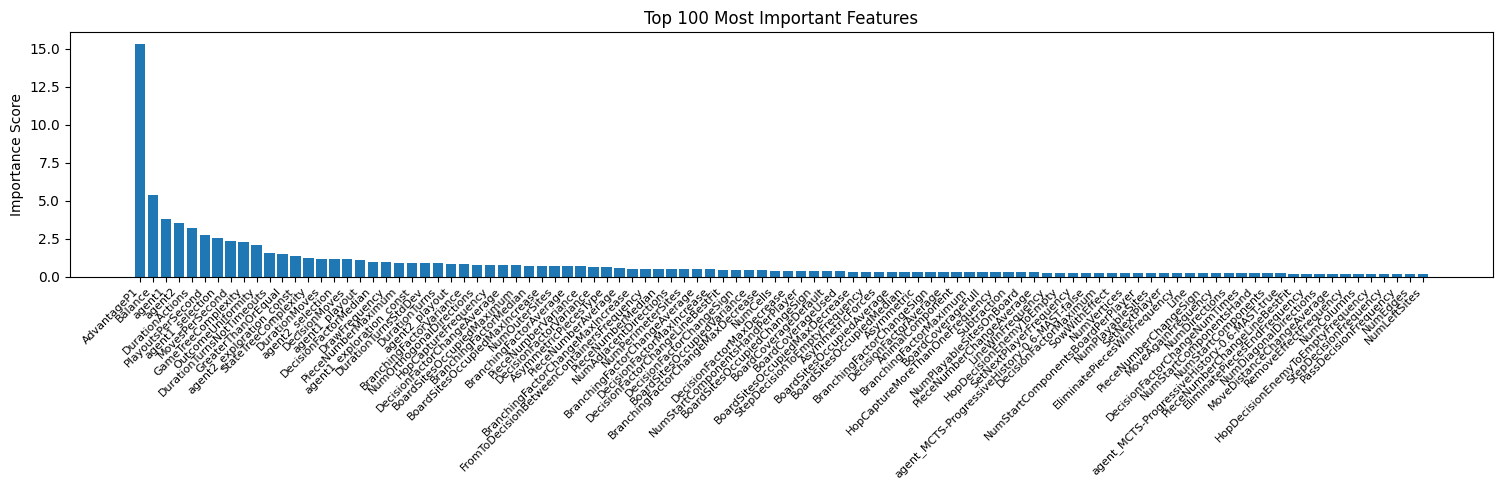

Fold 5 - RMSE: 0.4202266134207631
List of oof scores: [0.42134112896867354, 0.4072826597913988, 0.4117492395680674, 0.41420362959306356, 0.4202266134207631]
Average oof score: 0.4149606542683933


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4124
Score: 0.4374
Score: 0.4234
Score: 0.4307
Score: 0.3927
Average CV1 Score: 0.4193

CV2 OOF Scores:
Score: 0.4053
Score: 0.3919
Score: 0.4215
Score: 0.4291
Score: 0.4277
Average CV2 Score: 0.4151

CV3 OOF Scores:
Score: 0.4213
Score: 0.4073
Score: 0.4117
Score: 0.4142
Score: 0.4202
Average CV3 Score: 0.4150


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

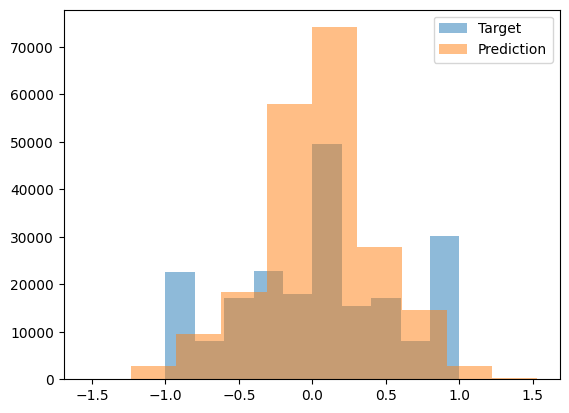

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.125003       │
│ 233235 ┆ -0.148842      │
│ 233236 ┆ -0.012607      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***